## Notes on getting it to this stage

Most striking things to tune are:
- enforcing that the state variables are positive (reduces solve time, increases identifiability, increases parameter estimation correctness)
- increasing the regularisation value
- ensuring that the correct values in the solution are being indexed

- problems occur when the sampling domain for the data is not uniform/nice. If splines are generated that are too close to each other, and the refinement of the time grid is not large enough, then you get pathological solutions. 

## New things introduced in this notebook

- positivity constraint on the state variables

In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from importlib import reload

In [2]:
plt.rcParams['figure.figsize'] = [13, 8.]

In [3]:
p_true = [2, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True) 

In [4]:
tofsol = np.linspace(0, 20, 41)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [5]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]
randdata = np.random.multivariate_normal(gendata, 10000*np.exp(-1/(2*2**2)*np.abs(tofsol.reshape(1,-1)-tofsol.reshape(-1,1))**2)).reshape(1,-1)
randdata[randdata < 0] = 0
data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)
# data = raw_data.reshape(1,-1)
data_pd = np.array([i for i in data.T])

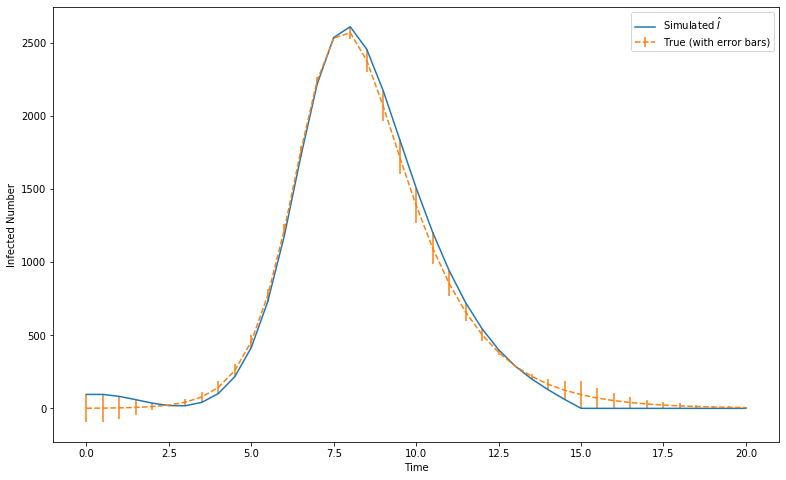

In [6]:
# plt.plot(tofsol, gendata.T)
plt.plot(tofsol, randdata.T)
plt.errorbar(tofsol, gendata.T, (randdata-gendata).flatten(), linestyle='--')
plt.xlabel('Time')
plt.ylabel("Infected Number")
plt.legend([r'Simulated $\hat{I}$', 'True (with error bars)'])

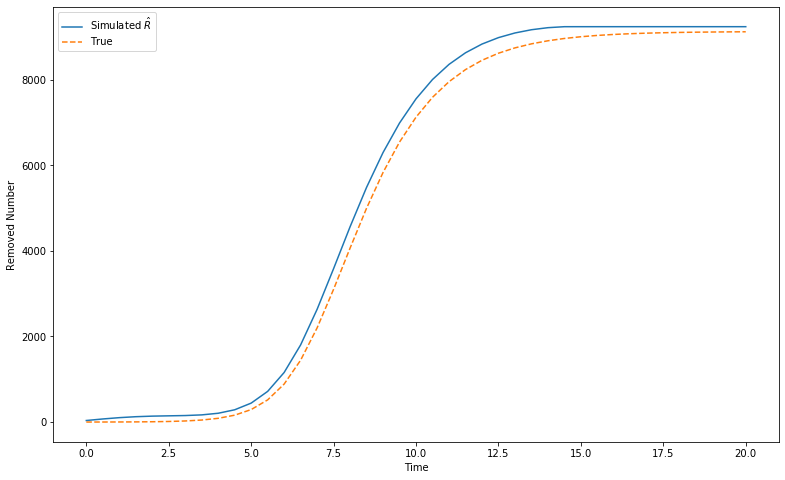

In [7]:
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')
plt.xlabel('Time')
plt.ylabel("Removed Number")
plt.legend([r"Simulated $\hat{R}$", "True"])

In [8]:
from functions import misc
reload(misc)
knot_fn = misc.knot_fn


In [9]:
config = {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_pd, "t": tofsol},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(tofsol)
    ],
    "regularisation_value": [1]*len(p_true),
}

In [10]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

opts = {
    'ipopt': {'max_iter': 300}
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, opts)

In [11]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [12]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [13]:
p0 = np.ones(2)
# p0 = p_true
c0 = [c*np.linspace(1, 0, config['basis_number'])+d for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])

In [14]:
pure_data = solver(x0=x0, p=[1e-14, 1e-14], lbx=lbx, lbg=0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

[112355, 112206, 111908, 111462, 111018, 110577, 110138, 109700, 109265, 108832, 108400, 107971, 107471, 106975, 106481, 106059, 105638, 105220, 104804, 104389, 103977, 103567, 103159, 102687, 102217, 101752, 101355, 100959, 100566, 100174, 99783.9, 99394.7, 99006.7, 98619.5, 98233.2, 97783.2, 97333.9, 96885.1, 96500.7, 96116.4, 95732.1, 95347.8, 94963.3, 94578.5, 94193.4, 93807.8, 93357.3, 92906, 92453.6, 92065.1, 91675.7, 91285.3, 90893.9, 90501.4, 90107.7, 89712.7, 89316.3, 88852.1, 88519, 88318.4, 93236, 93310.9, 93458.3, 93680.9, 93900.5, 94119.6, 94336.8, 94552.8, 94767.4, 94980.8, 95192.9, 95403.8, 95648.6, 95891.7, 96132.9, 96338.3, 96542.2, 96744.5, 96944.8, 97142.8, 97338, 97530.1, 97718.8, 97934.9, 98145.6, 98351.2, 98524.3, 98694.3, 98861.7, 99026.7, 99189.6, 99350.6, 99510.1, 99668.1, 99825, 100007, 100188, 100367, 100521, 100674, 100826, 100979, 101131, 101283, 101435, 101586, 101764, 101941, 102118, 102270, 102422, 102574, 102726, 102878, 103031, 103183, 103336, 103514, 

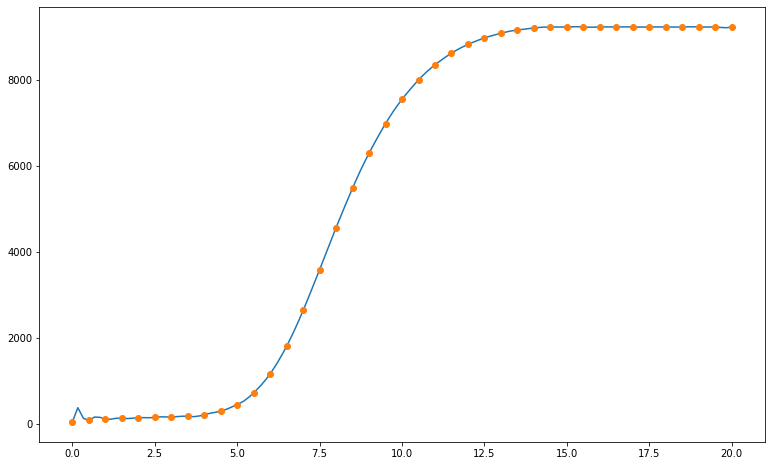

In [15]:
pure_xs = getx(pure_data['x'])
print(pure_data['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(tofsol, data.T, 'o')

In [16]:
x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)

In [17]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, 0.5], lbx=lbx, lbg=0))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  72  9.0805673e-01 0.00e+00 1.05e+00  -8.6 2.38e+03 -12.9 1.00e+00 1.00e+00f  1
  73  9.0775777e-01 0.00e+00 2.21e+00  -8.6 7.07e+03 -13.3 1.00e+00 1.00e+00f  1
  74  9.0744779e-01 0.00e+00 1.97e+00  -8.6 4.21e+04 -12.9 1.00e+00 7.25e-02f  1
  75  9.0655699e-01 0.00e+00 4.74e-01  -8.6 1.22e+03 -12.5 1.00e+00 1.00e+00f  1
  76  9.0621032e-01 0.00e+00 9.25e-01  -8.6 1.01e+04 -13.0 1.00e+00 2.50e-01f  3
  77  9.0549627e-01 0.00e+00 8.23e-01  -8.6 9.76e+03 -13.4 1.00e+00 1.00e+00f  1
  78  9.0508608e-01 0.00e+00 8.19e-01  -8.6 5.45e+04 -13.0 9.98e-01 4.35e-02f  1
  79  9.0479007e-01 0.00e+00 8.94e-01  -8.6 6.90e+04 -13.5 3.39e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  9.0442273e-01 0.00e+00 1.45e+00  -8.6 8.68e+03 -12.2 7.16e-01 3.44e-01f  1
  81  9.0387653e-01 0.00e+00 2.70e-01  -8.6 2.01e+03 -12.6 8.74e-01 1.00e+00f  1
  82  9.0358004e-01 0.00e+00 1.25e+00  -8.6 6.05e+03 -13.1 5.13e-01 5.00e-01f  2
  83  9.0316571e-01 0.00e+00

  27  1.4506981e+00 0.00e+00 5.42e-02  -8.6 9.02e+02 -10.7 1.00e+00 1.00e+00f  1
  28  1.4395632e+00 0.00e+00 1.00e+00  -8.6 4.01e+03 -11.2 1.00e+00 1.00e+00f  1
  29  1.4147346e+00 0.00e+00 4.68e+00  -8.6 1.49e+05 -11.6 1.26e-01 6.06e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.3353003e+00 0.00e+00 3.02e+00  -8.6 3.70e+03 -12.1 1.00e+00 1.00e+00f  1
  31  1.2741124e+00 0.00e+00 3.14e+00  -8.6 1.52e+04 -12.6 6.19e-01 7.20e-01f  1
  32  1.1180833e+00 0.00e+00 2.84e+00  -8.6 2.00e+05    -  1.73e-08 1.87e-01f  1
  33  6.0391134e-01 0.00e+00 3.09e-01  -8.6 2.71e+03  -9.5 7.32e-01 1.00e+00f  1
  34  3.3627085e-01 0.00e+00 6.04e-01  -8.6 2.01e+03  -9.0 1.00e+00 8.10e-01f  1
  35  1.8792453e-01 0.00e+00 6.70e-01  -8.6 1.28e+03  -9.5 8.87e-01 1.00e+00f  1
  36  9.5487573e-02 0.00e+00 2.07e-01  -8.6 2.47e+03    -  1.00e+00 1.00e+00f  1
  37  7.4617628e-02 0.00e+00 7.81e-02  -8.6 3.37e+03    -  9.41e-01 9.17e-01f  1
  38  6.8849617e-02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.5147750e-02 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.

  11  1.3756567e-01 0.00e+00 2.63e-01  -3.8 5.35e+03    -  7.91e-01 5.00e-01f  2
  12  1.1212951e-01 0.00e+00 5.22e-02  -3.8 1.67e+03    -  1.00e+00 1.00e+00f  1
  13  1.1226614e-01 0.00e+00 1.74e-02  -3.8 3.26e+03    -  1.00e+00 1.00e+00f  1
  14  1.1268994e-01 0.00e+00 7.23e-04  -3.8 8.85e+02    -  1.00e+00 1.00e+00f  1
  15  1.1010892e-01 0.00e+00 1.09e-01  -5.7 1.73e+04    -  9.31e-01 5.00e-01f  2
  16  1.0671239e-01 0.00e+00 2.29e-03  -5.7 2.15e+02    -  1.00e+00 1.00e+00f  1
  17  1.0657071e-01 0.00e+00 1.26e-04  -5.7 1.05e+02    -  1.00e+00 1.00e+00f  1
  18  1.0654617e-01 0.00e+00 1.27e-05  -5.7 1.50e+01    -  1.00e+00 1.00e+00h  1
  19  1.0653053e-01 0.00e+00 2.34e-05  -8.6 5.79e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0652779e-01 0.00e+00 2.94e-06  -8.6 5.20e+00    -  1.00e+00 1.00e+00h  1
  21  1.0652733e-01 0.00e+00 5.18e-07  -8.6 1.79e+00    -  1.00e+00 1.00e+00h  1
  22  1.0652727e-01 0.00e+00

Dual infeasibility......:   8.8144079814233893e-11    8.8144079814233893e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.050
Total CPU secs in NLP function evaluations           =      0.014

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 893.00us ( 24.14us) 899.28us ( 24.30us)  

   1  1.6219663e-01 0.00e+00 1.03e-02  -1.0 1.95e-01    -  9.90e-01 1.00e+00f  1
   2  1.6512401e-01 0.00e+00 7.14e-04  -1.0 2.26e+01    -  9.65e-01 1.00e+00f  1
   3  4.5488408e-01 0.00e+00 3.42e-02  -1.0 7.83e+02    -  9.62e-01 1.00e+00f  1
   4  9.0403390e-01 0.00e+00 2.54e+00  -1.7 3.11e+03    -  9.41e-01 1.00e+00f  1
   5  1.6281355e+00 0.00e+00 3.94e+00  -1.7 1.65e+04    -  6.86e-01 1.00e+00f  1
   6  2.1124646e+00 0.00e+00 4.44e+00  -1.7 1.49e+04    -  5.05e-01 3.59e-01f  2
   7  2.5564548e+00 0.00e+00 1.07e+01  -1.7 2.30e+04    -  1.00e+00 1.00e+00f  1
   8  3.2813238e+00 0.00e+00 3.52e+01  -1.7 3.00e+04    -  6.40e-01 1.00e+00f  1
   9  2.6542571e+00 0.00e+00 1.82e-04  -1.7 3.77e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3161507e+00 0.00e+00 4.59e+00  -3.8 6.29e+03    -  8.28e-01 1.00e+00f  1
  11  2.2884473e+00 0.00e+00 3.56e-05  -3.8 1.07e+00  -4.5 1.00e+00 1.00e+00f  1
  12  2.2880441e+00 0.00e+00

   7  3.0691408e+00 0.00e+00 9.62e+00  -1.7 7.05e+04    -  3.06e-01 2.05e-01f  2
   8  3.0488438e+00 0.00e+00 1.68e+00  -1.7 4.48e+04    -  1.00e+00 1.00e+00f  1
   9  3.2182662e+00 0.00e+00 1.16e+01  -1.7 9.14e+03    -  7.34e-01 4.63e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3804355e+00 0.00e+00 2.03e+01  -1.7 3.30e+04    -  4.44e-01 1.87e-01f  3
  11  3.6274956e+00 0.00e+00 5.37e+01  -1.7 1.18e+04    -  1.00e+00 5.00e-01f  2
  12  3.2185434e+00 0.00e+00 6.32e-05  -1.7 6.31e-01  -4.0 1.00e+00 1.00e+00f  1
  13  3.0342908e+00 0.00e+00 1.13e+01  -3.8 7.09e+03    -  9.02e-01 1.00e+00f  1
  14  3.0105400e+00 0.00e+00 3.57e-05  -3.8 1.07e+00  -4.5 1.00e+00 1.00e+00f  1
  15  3.0101349e+00 0.00e+00 2.46e-05  -5.7 2.22e+00  -5.0 1.00e+00 1.00e+00f  1
  16  3.0096634e+00 0.00e+00 1.44e-05  -5.7 3.89e+00  -5.4 1.00e+00 1.00e+00f  1
  17  3.0089303e+00 0.00e+00 1.14e-05  -8.6 7.42e+00  -5.9 9.89e-01 1.00e+00f  1
  18  3.0075872e+00 0.00e+00

  16  1.2380207e+00 0.00e+00 1.26e-04  -5.7 1.05e+01  -5.4 8.90e-01 1.00e+00f  1
  17  1.2267276e+00 0.00e+00 3.59e-04  -5.7 2.22e+01  -5.9 1.00e+00 1.00e+00f  1
  18  1.2013810e+00 0.00e+00 1.79e-03  -5.7 4.05e+01  -6.4 1.00e+00 1.00e+00f  1
  19  1.1466419e+00 0.00e+00 1.36e-02  -5.7 7.64e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0191590e+00 0.00e+00 1.13e-01  -5.7 1.98e+02  -7.3 1.00e+00 1.00e+00f  1
  21  7.4180203e-01 0.00e+00 7.09e-01  -5.7 4.98e+02  -7.8 1.00e+00 1.00e+00f  1
  22  5.4059727e-01 0.00e+00 7.48e-01  -5.7 5.09e+02  -8.3 1.00e+00 1.00e+00f  1
  23  3.9271594e-01 0.00e+00 1.98e-01  -5.7 9.06e+02  -8.8 1.00e+00 1.00e+00f  1
  24  3.0428394e-01 0.00e+00 1.36e-01  -5.7 1.16e+03  -9.2 1.00e+00 1.00e+00f  1
  25  2.8601716e-01 0.00e+00 2.40e-02  -5.7 7.73e+02  -9.7 1.00e+00 1.00e+00f  1
  26  2.8287329e-01 0.00e+00 1.66e-03  -5.7 5.95e+02 -10.2 1.00e+00 1.00e+00f  1
  27  2.7448227e-01 0.00e+00

  29  5.7413696e+00 0.00e+00 4.22e+01  -5.7 8.40e+03 -10.7 1.00e+00 3.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.7173324e+00 0.00e+00 1.92e+00  -5.7 3.14e+03 -11.2 1.00e+00 1.00e+00f  1
  31  5.7027663e+00 0.00e+00 1.48e+01  -5.7 6.35e+03 -11.7 1.00e+00 8.50e-01f  1
  32  5.6939053e+00 0.00e+00 2.54e+01  -5.7 2.24e+04    -  8.10e-01 2.50e-01f  3
  33  5.6939092e+00 0.00e+00 2.54e+01  -5.7 3.06e+04 -11.3 1.00e+00 3.05e-05f 16
  34  5.6796445e+00 0.00e+00 3.27e+01  -5.7 7.52e+03    -  1.00e+00 1.00e+00f  1
  35  5.6591759e+00 0.00e+00 1.30e+01  -5.7 3.38e+03    -  1.00e+00 1.00e+00f  1
  36  5.6472957e+00 0.00e+00 2.58e+01  -5.7 1.05e+04    -  7.62e-01 5.00e-01f  2
  37  5.6390481e+00 0.00e+00 1.53e+01  -5.7 8.64e+03 -11.7 1.00e+00 5.00e-01f  2
  38  5.6341680e+00 0.00e+00 1.03e+01  -5.7 6.43e+05    -  6.48e-01 7.62e-02f  2
  39  5.6285447e+00 0.00e+00 2.79e+01  -5.7 1.22e+04 -12.2 1.00e+00 4.29e-01f  1
iter    objective    inf_pr 

   5  5.5580354e+00 0.00e+00 1.93e+01  -1.0 5.16e+04    -  1.31e-01 9.57e-02f  2
   6  9.0438029e+00 0.00e+00 5.92e+01  -1.0 2.88e+04    -  4.13e-01 4.17e-01f  2
   7  9.2747001e+00 0.00e+00 3.60e+01  -1.0 8.76e+04    -  1.54e-01 1.51e-01f  2
   8  1.2273188e+01 0.00e+00 1.24e+02  -1.0 4.67e+04    -  1.00e+00 1.00e+00f  1
   9  1.0423212e+01 0.00e+00 2.18e-03  -1.0 2.07e+00  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.0591438e+00 0.00e+00 2.43e+01  -2.5 7.89e+03    -  8.62e-01 1.00e+00f  1
  11  7.9518030e+00 0.00e+00 1.30e-04  -2.5 3.54e+00  -4.5 1.00e+00 1.00e+00f  1
  12  7.9473032e+00 0.00e+00 6.42e-05  -3.8 5.77e+00  -5.0 1.00e+00 1.00e+00f  1
  13  7.9410832e+00 0.00e+00 5.03e-05  -5.7 1.03e+01  -5.4 9.98e-01 1.00e+00f  1
  14  7.9297895e+00 0.00e+00 3.50e-04  -5.7 2.06e+01  -5.9 1.00e+00 1.00e+00f  1
  15  7.9098937e+00 0.00e+00 1.71e-03  -5.7 3.90e+01  -6.4 1.00e+00 1.00e+00f  1
  16  7.8777225e+00 0.00e+00

   3  5.1774974e+00 0.00e+00 8.47e+00  -1.0 3.69e+03    -  3.17e-01 1.00e+00f  1
   4  4.2981175e+00 0.00e+00 3.81e+00  -1.0 1.69e+03    -  9.55e-01 1.00e+00f  1
   5  8.0143017e+00 0.00e+00 2.98e+01  -1.0 4.74e+04    -  1.18e-01 1.10e-01f  2
   6  1.1606918e+01 0.00e+00 8.19e+01  -1.0 3.16e+04    -  2.50e-01 2.02e-01f  2
   7  9.2547368e+00 0.00e+00 8.42e-03  -1.0 2.26e+00  -4.0 1.00e+00 1.00e+00f  1
   8  5.3116957e+00 0.00e+00 2.28e+01  -2.5 5.74e+03    -  6.97e-01 1.00e+00f  1
   9  2.8101769e+00 0.00e+00 6.87e+00  -2.5 3.71e+03    -  7.30e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9948958e+00 0.00e+00 5.63e+00  -2.5 1.88e+03    -  8.33e-01 3.62e-01f  2
  11  1.0595288e+00 0.00e+00 4.20e+00  -2.5 2.62e+03    -  1.00e+00 1.00e+00f  1
  12  6.2836300e-01 0.00e+00 1.40e+00  -2.5 4.99e+02    -  1.00e+00 1.00e+00f  1
  13  5.2593685e-01 0.00e+00 1.93e-01  -2.5 2.16e+02    -  1.00e+00 1.00e+00f  1
  14  5.2689080e-01 0.00e+00

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7363124e-01 0.00e+00 1.12e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.7384394e-01 0.00e+00 1.03e-02  -1.0 1.92e-01    -  9.90e-01 1.00e+00f  1
   2  4.8492859e-01 0.00e+00 2.53e-03  -1.0 2.42e+01    -  9.88e-01 1.00e+00f  1
   3  7.2377721e+00 0.00e+00 1.23e+01  -1.0 3.29e+03    -  1.75e-01 1.00e+00f  1
   4  5.3517423e+00 0.00e+00 3.23e+00  -1.0 1.27e+03    -  9.63e-01 1.00e+00f  1
 

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0347722e-01 0.00e+00 1.12e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.0368356e-01 0.00e+00 1.03e-02  -1.0 1.92e-01    -  9.90e-01 1.00e+00f  1
   2  5.1636724e-01 0.00e+00 3.17e-03  -1.0 2.68e+01    -  9.87e-01 1.00e+00f  1
   3  8.2343674e+00 0.00e+00 1.42e+01  -1.0 3.11e+03    -  1.45e-01 1.00e+00f  1
   4  5.6025850e+00 0.00e+00 2.90e+00  -1.0 1.16e+03    -  9.68e-01 1.00e+00f  1
 

  28  5.1735573e-01 0.00e+00 2.70e-05  -5.7 1.02e+00    -  1.00e+00 1.00e+00f  1
  29  5.1735102e-01 0.00e+00 2.13e-06  -5.7 3.09e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.1734716e-01 0.00e+00 6.58e-06  -8.6 4.79e-01    -  1.00e+00 1.00e+00h  1
  31  5.1734692e-01 0.00e+00 4.14e-07  -8.6 1.48e-01    -  1.00e+00 1.00e+00h  1
  32  5.1734692e-01 0.00e+00 6.87e-09  -8.6 2.13e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   5.1734691915508213e-01    5.1734691915508213e-01
Dual infeasibility......:   6.8669307226174330e-09    6.8669307226174330e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.0967670286128941e-09    4.0967670286128941e-09
Overall NLP error.......:   6.8669307226174330e-09    6.8669307226174330e-09


Number of objective funct

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.6466801e-01 0.00e+00 1.13e+00  -1.0 0.00e+00    -  0.00e+00 0.

Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.037
Total CPU secs in NLP function evaluations           =      0.012

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.14ms ( 23.31us)   1.15ms ( 23.51us)        49
       nlp_g  | 445.00us (  9.08us) 441.07us (  9.00us)        49
    nlp_grad  |  54.00us ( 54.00us)  53.38us ( 53.38us)         1
  nlp_grad_f  |   1.56ms ( 50.45us)   1.53ms ( 49.27us)        31
  nlp_hess_l  |   8.88ms (306.31us)   8.96ms (308.80us)        29
   nlp_jac_g  | 378.00us ( 12.19us) 378.83us ( 12.22us)        31
       total  |  53.92ms ( 53.92ms)  52.10ms ( 52.10ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other li

  27  4.6968358e+00 0.00e+00 1.22e-04  -5.7 5.36e+01  -8.8 1.00e+00 1.00e+00f  1
  28  4.6946947e+00 0.00e+00 7.94e-05  -5.7 1.43e+02  -9.2 1.00e+00 1.00e+00f  1
  29  4.6883895e+00 0.00e+00 7.16e-04  -5.7 4.33e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.6683409e+00 0.00e+00 7.15e-03  -5.7 1.35e+03 -10.2 1.00e+00 1.00e+00f  1
  31  4.5945321e+00 0.00e+00 9.14e-02  -5.7 4.56e+03 -10.7 1.00e+00 1.00e+00f  1
  32  4.0878202e+00 0.00e+00 4.20e+00  -5.7 2.33e+04 -11.2 1.00e+00 1.00e+00f  1
  33  3.9396382e+00 0.00e+00 1.20e+01  -5.7 1.75e+05    -  4.33e-01 9.39e-02f  2
  34  2.6226561e+00 0.00e+00 2.51e+00  -5.7 3.63e+03    -  1.00e+00 1.00e+00f  1
  35  2.2643007e+00 0.00e+00 2.30e+00  -5.7 8.01e+04 -10.7 3.56e-01 4.18e-02f  3
  36  1.9280563e+00 0.00e+00 4.18e+00  -5.7 6.02e+03    -  1.00e+00 5.00e-01f  2
  37  1.5138095e+00 0.00e+00 1.60e+00  -5.7 1.58e+03    -  1.00e+00 1.00e+00f  1
  38  1.3149471e+00 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.0852935e-01 0.00e+00 1.14e+00  -1.0 0.00e+00    -  0.00e+00 0.

  44  8.8769686e-01 0.00e+00 2.81e+00  -5.7 1.05e+03    -  1.00e+00 5.00e-01f  2
  45  8.2222884e-01 0.00e+00 1.25e+00  -5.7 3.12e+02    -  1.00e+00 1.00e+00f  1
  46  7.9186555e-01 0.00e+00 3.42e+00  -5.7 4.99e+02    -  1.00e+00 1.00e+00f  1
  47  7.5514371e-01 0.00e+00 2.77e-01  -5.7 1.23e+02    -  1.00e+00 1.00e+00f  1
  48  7.5375699e-01 0.00e+00 3.03e+00  -5.7 4.02e+02    -  1.00e+00 1.00e+00f  1
  49  7.3759677e-01 0.00e+00 1.27e-02  -5.7 1.96e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  7.3731371e-01 0.00e+00 7.44e-02  -5.7 5.78e+01    -  1.00e+00 1.00e+00f  1
  51  7.3730484e-01 0.00e+00 1.99e-05  -5.7 1.16e+00    -  1.00e+00 1.00e+00f  1
  52  7.3730484e-01 0.00e+00 5.93e-08  -5.7 5.18e-02    -  1.00e+00 1.00e+00h  1
  53  7.3730290e-01 0.00e+00 3.57e-06  -8.6 1.72e-01    -  1.00e+00 1.00e+00h  1
  54  7.3730285e-01 0.00e+00 9.42e-08  -8.6 3.51e-02    -  1.00e+00 1.00e+00h  1
  55  7.3730285e-01 0.00e+00

  21  6.8166597e+00 0.00e+00 4.91e-03  -3.8 2.91e+00  -4.5 1.00e+00 1.00e+00f  1
  22  6.8032754e+00 0.00e+00 1.81e-03  -3.8 6.51e+00  -5.0 1.00e+00 1.00e+00f  1
  23  6.7927585e+00 0.00e+00 2.56e-03  -3.8 1.16e+01  -5.4 1.00e+00 1.00e+00f  1
  24  6.7818203e+00 0.00e+00 2.64e-03  -3.8 1.75e+01  -5.9 1.00e+00 1.00e+00f  1
  25  6.7726695e+00 0.00e+00 8.80e-04  -3.8 2.24e+01  -6.4 1.00e+00 1.00e+00f  1
  26  6.7629309e+00 0.00e+00 8.13e-04  -5.7 3.08e+01  -6.9 1.00e+00 1.00e+00f  1
  27  6.7563616e+00 0.00e+00 2.53e-04  -5.7 3.35e+01  -7.3 1.00e+00 1.00e+00f  1
  28  6.7542885e+00 0.00e+00 2.32e-04  -5.7 3.29e+01  -7.8 1.00e+00 1.00e+00f  1
  29  6.7528815e+00 0.00e+00 4.16e-06  -5.7 4.31e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.7489261e+00 0.00e+00 1.41e-04  -8.6 1.14e+02  -8.8 1.00e+00 1.00e+00f  1
  31  6.7369030e+00 0.00e+00 1.31e-03  -8.6 3.46e+02  -9.2 1.00e+00 1.00e+00f  1
  32  6.6987858e+00 0.00e+00

  24  3.8786079e+00 0.00e+00 9.17e+00  -1.7 8.36e+03    -  1.00e+00 5.00e-01f  2
  25  3.3414095e+00 0.00e+00 2.15e+00  -1.7 9.61e+02    -  1.00e+00 1.00e+00f  1
  26  2.9213548e+00 0.00e+00 4.77e+00  -1.7 3.95e+03    -  1.00e+00 5.00e-01f  2
  27  2.6676075e+00 0.00e+00 1.70e+00  -1.7 6.28e+02    -  1.00e+00 1.00e+00f  1
  28  2.4562079e+00 0.00e+00 2.32e+00  -1.7 1.78e+03    -  1.00e+00 5.00e-01f  2
  29  2.2649303e+00 0.00e+00 2.27e+00  -1.7 7.62e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0953933e+00 0.00e+00 2.16e+00  -1.7 6.97e+02    -  1.00e+00 1.00e+00f  1
  31  1.9721334e+00 0.00e+00 1.73e+00  -1.7 5.16e+02    -  1.00e+00 1.00e+00f  1
  32  1.8585814e+00 0.00e+00 2.00e+00  -1.7 5.15e+02    -  1.00e+00 1.00e+00f  1
  33  1.7868208e+00 0.00e+00 1.01e+00  -1.7 3.20e+02    -  1.00e+00 1.00e+00f  1
  34  1.7047045e+00 0.00e+00 1.73e+00  -1.7 4.00e+02    -  1.00e+00 1.00e+00f  1
  35  1.6745071e+00 0.00e+00

  22  7.6017612e+00 0.00e+00 6.50e+00  -1.7 1.15e+04    -  1.00e+00 1.00e+00f  1
  23  6.7141211e+00 0.00e+00 9.89e+00  -1.7 2.86e+04    -  1.00e+00 2.31e-01f  3
  24  5.3602782e+00 0.00e+00 1.04e+01  -1.7 6.70e+03    -  1.00e+00 1.00e+00f  1
  25  4.3896352e+00 0.00e+00 3.19e+00  -1.7 2.59e+03    -  1.00e+00 1.00e+00f  1
  26  3.8904838e+00 0.00e+00 4.86e+00  -1.7 3.93e+03    -  1.00e+00 5.00e-01f  2
  27  3.3942333e+00 0.00e+00 3.65e+00  -1.7 1.63e+03    -  1.00e+00 1.00e+00f  1
  28  3.0168892e+00 0.00e+00 3.02e+00  -1.7 1.21e+03    -  1.00e+00 1.00e+00f  1
  29  2.7367801e+00 0.00e+00 3.34e+00  -1.7 9.94e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.5176045e+00 0.00e+00 2.48e+00  -1.7 7.37e+02    -  1.00e+00 1.00e+00f  1
  31  2.3280843e+00 0.00e+00 3.56e+00  -1.7 7.70e+02    -  1.00e+00 1.00e+00f  1
  32  2.1929291e+00 0.00e+00 1.68e+00  -1.7 4.46e+02    -  1.00e+00 1.00e+00f  1
  33  2.0462748e+00 0.00e+00

  43  2.3946734e+00 0.00e+00 3.88e+00  -5.7 2.70e+03    -  9.22e-01 2.50e-01f  3
  44  2.2032934e+00 0.00e+00 6.90e+00  -5.7 8.26e+02    -  1.00e+00 1.00e+00f  1
  45  1.9949693e+00 0.00e+00 2.20e+00  -5.7 4.11e+02    -  1.00e+00 1.00e+00f  1
  46  1.8823902e+00 0.00e+00 5.19e+00  -5.7 1.06e+03    -  1.00e+00 5.00e-01f  2
  47  1.7311007e+00 0.00e+00 4.08e+00  -5.7 4.64e+02    -  1.00e+00 1.00e+00f  1
  48  1.6139805e+00 0.00e+00 6.85e+00  -5.7 5.54e+02    -  1.00e+00 1.00e+00f  1
  49  1.4850549e+00 0.00e+00 2.50e+00  -5.7 2.97e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.4158200e+00 0.00e+00 4.88e+00  -5.7 6.80e+02    -  1.00e+00 5.00e-01f  2
  51  1.3278342e+00 0.00e+00 4.33e+00  -5.7 3.39e+02    -  1.00e+00 1.00e+00f  1
  52  1.2602271e+00 0.00e+00 4.34e+00  -5.7 3.16e+02    -  1.00e+00 1.00e+00f  1
  53  1.2102629e+00 0.00e+00 2.89e+00  -5.7 2.40e+02    -  1.00e+00 1.00e+00f  1
  54  1.1811069e+00 0.00e+00

  13  6.3082790e+00 0.00e+00 4.08e+00  -1.0 1.23e+03    -  1.00e+00 5.00e-01f  2
  14  6.5935534e+00 0.00e+00 3.73e+00  -1.0 8.00e+02    -  1.00e+00 1.00e+00f  1
  15  6.8088627e+00 0.00e+00 2.50e+00  -1.0 7.15e+02    -  1.00e+00 1.00e+00f  1
  16  7.1078372e+00 0.00e+00 3.35e+00  -1.0 9.18e+02    -  1.00e+00 1.00e+00f  1
  17  7.3453626e+00 0.00e+00 1.38e+00  -1.0 6.69e+02    -  1.00e+00 1.00e+00f  1
  18  7.7180674e+00 0.00e+00 3.71e+00  -1.0 1.18e+03    -  1.00e+00 1.00e+00f  1
  19  7.9129213e+00 0.00e+00 4.37e-01  -1.0 4.83e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.5167011e+00 0.00e+00 1.40e+01  -1.7 1.87e+04    -  7.09e-01 1.39e-01f  3
  21  3.6028389e+00 0.00e+00 6.03e+00  -1.7 1.28e+03    -  1.00e+00 1.00e+00f  1
  22  3.3443729e+00 0.00e+00 6.66e+00  -1.7 1.87e+03    -  1.00e+00 5.00e-01f  2
  23  3.0933684e+00 0.00e+00 2.97e+00  -1.7 7.66e+02    -  1.00e+00 1.00e+00f  1
  24  2.8993871e+00 0.00e+00

  26  2.0831183e+00 0.00e+00 3.02e-01  -1.7 6.15e+01    -  1.00e+00 1.00e+00f  1
  27  2.0613470e+00 0.00e+00 5.61e-01  -1.7 8.20e+01    -  1.00e+00 1.00e+00f  1
  28  2.0603334e+00 0.00e+00 3.24e-03  -1.7 6.27e+00    -  1.00e+00 1.00e+00f  1
  29  1.8537924e+00 0.00e+00 1.03e+01  -3.8 8.84e+02    -  8.80e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6397950e+00 0.00e+00 4.99e-01  -3.8 8.84e+01    -  1.00e+00 1.00e+00f  1
  31  1.6243873e+00 0.00e+00 5.35e+00  -3.8 2.24e+02    -  1.00e+00 1.00e+00f  1
  32  1.6128049e+00 0.00e+00 3.24e-03  -3.8 7.91e+00    -  1.00e+00 1.00e+00f  1
  33  1.6124264e+00 0.00e+00 4.68e-03  -3.8 6.29e+00    -  1.00e+00 1.00e+00f  1
  34  1.6123981e+00 0.00e+00 4.44e-07  -3.8 4.63e-02    -  1.00e+00 1.00e+00h  1
  35  1.6117759e+00 0.00e+00 5.35e-04  -5.7 3.33e+00    -  1.00e+00 1.00e+00f  1
  36  1.6116909e+00 0.00e+00 7.35e-05  -5.7 4.84e-01    -  1.00e+00 1.00e+00f  1
  37  1.6116813e+00 0.00e+00

  28  2.1561354e+00 0.00e+00 1.30e-03  -3.8 3.85e+00    -  1.00e+00 1.00e+00f  1
  29  2.1550051e+00 0.00e+00 1.35e-03  -5.7 1.38e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1548357e+00 0.00e+00 1.43e-04  -5.7 5.63e-01    -  1.00e+00 1.00e+00f  1
  31  2.1548156e+00 0.00e+00 2.00e-05  -5.7 1.72e-01    -  1.00e+00 1.00e+00f  1
  32  2.1548140e+00 0.00e+00 9.91e-07  -5.7 4.15e-02    -  1.00e+00 1.00e+00h  1
  33  2.1548133e+00 0.00e+00 1.26e-06  -8.6 3.89e-02    -  1.00e+00 1.00e+00h  1
  34  2.1548133e+00 0.00e+00 4.37e-09  -8.6 2.85e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   2.1548133371443106e+00    2.1548133371443106e+00
Dual infeasibility......:   4.3671704787120934e-09    4.3671704787120934e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  26  2.9782535e+00 0.00e+00 1.85e-01  -3.8 3.95e+01    -  1.00e+00 1.00e+00f  1
  27  2.9749637e+00 0.00e+00 1.15e-03  -3.8 2.89e+00    -  1.00e+00 1.00e+00f  1
  28  2.9739494e+00 0.00e+00 1.22e-03  -5.7 9.05e-01    -  1.00e+00 1.00e+00f  1
  29  2.9738065e+00 0.00e+00 1.30e-04  -5.7 4.09e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9737916e+00 0.00e+00 1.56e-05  -5.7 1.26e-01    -  1.00e+00 1.00e+00f  1
  31  2.9737902e+00 0.00e+00 2.51e-06  -8.6 4.89e-02    -  1.00e+00 1.00e+00h  1
  32  2.9737902e+00 0.00e+00 1.72e-08  -8.6 4.72e-03    -  1.00e+00 1.00e+00h  1
  33  2.9737902e+00 0.00e+00 3.50e-12  -9.0 7.24e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   2.9737901608899189e+00    2.9737901608899189e+00
Dual infeasibility......:   3.4987111311145635e-12    3.4987111311145635e-12
Constraint viol

  11  5.7612821e+00 0.00e+00 1.80e+00  -1.7 5.06e+01    -  1.00e+00 1.00e+00f  1
  12  5.6639631e+00 0.00e+00 1.19e+01  -1.7 3.39e+02    -  1.00e+00 5.00e-01f  2
  13  5.6258164e+00 0.00e+00 1.11e+00  -1.7 5.18e+01    -  1.00e+00 1.00e+00f  1
  14  5.6103623e+00 0.00e+00 1.02e+00  -1.7 4.51e+01    -  1.00e+00 1.00e+00f  1
  15  5.6097505e+00 0.00e+00 3.90e-03  -1.7 2.83e+00    -  1.00e+00 1.00e+00f  1
  16  5.4076762e+00 0.00e+00 7.95e+00  -3.8 1.69e+02    -  9.78e-01 1.00e+00f  1
  17  5.3670394e+00 0.00e+00 1.11e-02  -3.8 8.78e+00    -  1.00e+00 1.00e+00f  1
  18  5.3612221e+00 0.00e+00 3.14e-02  -3.8 8.10e+00    -  1.00e+00 1.00e+00f  1
  19  5.3601998e+00 0.00e+00 3.44e-04  -3.8 6.68e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.3596798e+00 0.00e+00 6.66e-04  -5.7 5.31e-01    -  1.00e+00 1.00e+00f  1
  21  5.3596237e+00 0.00e+00 6.10e-05  -5.7 1.74e-01    -  1.00e+00 1.00e+00f  1
  22  5.3596201e+00 0.00e+00

Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1425975e+01 0.00e+00 1.16e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.1422283e+01 0.00e+00 1.33e-02  -1.0 4.13e-01    -  9.87e-01 1.00e+00f  1
   2  1.1812765e+01 0.00e+00 6.22e-01  -1.0 3.15e+01    -  9.88e-01 1.00e+00f  1
   3  1.3358891e+01 0.00e+00 1.46e

  12  2.4726729e+01 0.00e+00 6.54e-04  -5.7 2.18e-01    -  1.00e+00 1.00e+00f  1
  13  2.4726696e+01 0.00e+00 4.44e-05  -5.7 6.95e-02    -  1.00e+00 1.00e+00f  1
  14  2.4726696e+01 0.00e+00 8.13e-07  -5.7 1.02e-02    -  1.00e+00 1.00e+00h  1
  15  2.4726696e+01 0.00e+00 1.22e-07  -8.6 3.19e-03    -  1.00e+00 1.00e+00h  1
  16  2.4726696e+01 0.00e+00 3.89e-12  -8.6 2.23e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   2.4726695653225981e+01    2.4726695653225981e+01
Dual infeasibility......:   3.8890310082914923e-12    3.8890310082914923e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5071077363742675e-09    2.5071077363742675e-09
Overall NLP error.......:   2.5071077363742675e-09    2.5071077363742675e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations        

    nlp_grad  |  54.00us ( 54.00us)  53.70us ( 53.70us)         1
  nlp_grad_f  | 938.00us ( 52.11us) 942.38us ( 52.35us)        18
  nlp_hess_l  |   5.30ms (331.12us)   5.33ms (332.82us)        16
   nlp_jac_g  | 233.00us ( 12.94us) 232.66us ( 12.93us)        18
       total  |  31.09ms ( 31.09ms)  30.53ms ( 30.53ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number o

Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 15
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 385.00us ( 25.67us) 388.12us ( 25.87us)        15
       nlp_g  | 145.00us (  9.67us) 144.17us (  9.61us)        15
    nlp_grad  |  53.00us ( 53.00us)  52.51us ( 52.51us)         1
  nlp_grad_f  | 837.00us ( 52.31us) 803.97us ( 50.25us)        16
  nlp_hess_l  |   4.23ms (301.93us)   4.23ms (301.92us)        14
   nlp_jac_g  | 203.00us ( 12.69us) 204.30us ( 12.77us)        16
       total  |  27.03ms ( 27.03ms)  25.90ms ( 25.90ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other li

   1  8.5223345e+01 0.00e+00 2.73e-02  -1.0 8.90e-01    -  9.74e-01 1.00e+00f  1
   2  8.5702105e+01 0.00e+00 1.14e+00  -1.0 6.47e+00    -  9.90e-01 1.00e+00f  1
   3  8.6134798e+01 0.00e+00 7.41e+00  -1.0 3.06e+01    -  1.00e+00 1.00e+00f  1
   4  8.6090219e+01 0.00e+00 4.01e-01  -1.0 6.41e+00    -  1.00e+00 1.00e+00f  1
   5  8.5442472e+01 0.00e+00 5.22e+00  -1.7 3.21e+01    -  1.00e+00 1.00e+00f  1
   6  8.5337247e+01 0.00e+00 2.10e-02  -1.7 1.95e+00    -  1.00e+00 1.00e+00f  1
   7  8.5225995e+01 0.00e+00 1.81e-01  -3.8 6.34e+00    -  1.00e+00 1.00e+00f  1
   8  8.5207795e+01 0.00e+00 9.47e-03  -3.8 9.01e-01    -  1.00e+00 1.00e+00f  1
   9  8.5205046e+01 0.00e+00 2.13e-03  -3.8 2.50e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5204702e+01 0.00e+00 1.94e-04  -3.8 7.32e-02    -  1.00e+00 1.00e+00f  1
  11  8.5204570e+01 0.00e+00 2.15e-04  -5.7 6.73e-02    -  1.00e+00 1.00e+00f  1
  12  8.5204567e+01 0.00e+00

   5  1.4922089e+02 0.00e+00 3.66e+00  -2.5 2.03e+01    -  1.00e+00 1.00e+00f  1
   6  1.4910279e+02 0.00e+00 4.52e-02  -2.5 1.98e+00    -  1.00e+00 1.00e+00f  1
   7  1.4908047e+02 0.00e+00 6.96e-03  -2.5 4.86e-01    -  1.00e+00 1.00e+00f  1
   8  1.4906887e+02 0.00e+00 1.21e-02  -3.8 3.15e-01    -  1.00e+00 1.00e+00f  1
   9  1.4906709e+02 0.00e+00 1.26e-03  -3.8 1.31e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4906671e+02 0.00e+00 4.69e-04  -5.7 7.67e-02    -  1.00e+00 1.00e+00f  1
  11  1.4906668e+02 0.00e+00 3.09e-05  -5.7 2.28e-02    -  1.00e+00 1.00e+00f  1
  12  1.4906668e+02 0.00e+00 3.95e-07  -5.7 2.75e-03    -  1.00e+00 1.00e+00h  1
  13  1.4906668e+02 0.00e+00 7.11e-08  -8.6 9.80e-04    -  1.00e+00 1.00e+00h  1
  14  1.4906668e+02 0.00e+00 4.40e-11  -8.6 5.07e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objecti


Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.8342777712857890e+02    1.8342777712857890e+02
Dual infeasibility......:   4.3678451346923007e-10    4.3678451346923007e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7026336012315546e-09    2.7026336012315546e-09
Overall NLP error.......:   2.7026336012315546e-09    2.7026336012315546e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 15
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluation

  12  2.9372273e+02 0.00e+00 4.12e-04  -5.7 3.40e-02    -  1.00e+00 8.35e-01f  1
  13  2.9372247e+02 0.00e+00 6.57e-04  -5.7 1.36e-02    -  1.00e+00 9.50e-01f  1
  14  2.9372244e+02 0.00e+00 1.07e-03  -5.7 3.48e-03    -  9.05e-01 1.00e+00f  1
  15  2.9372243e+02 0.00e+00 3.84e-08  -5.7 8.14e-04    -  1.00e+00 1.00e+00h  1
  16  2.9372242e+02 0.00e+00 4.13e-04  -8.6 6.82e-04    -  9.93e-01 8.30e-01h  1
  17  2.9372242e+02 0.00e+00 8.64e-04  -8.6 1.98e-04    -  1.00e+00 7.93e-01f  1
  18  2.9372242e+02 0.00e+00 1.48e-04  -8.6 5.62e-05    -  1.00e+00 9.40e-01f  1
  19  2.9372242e+02 0.00e+00 2.43e-11  -8.6 3.71e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   2.9372242330864208e+02    2.9372242330864208e+02
Dual infeasibility......:   2.4278651225400483e-11    2.4278651225400483e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   5  4.7064600e+02 0.00e+00 1.73e-01  -1.0 1.37e+00    -  1.00e+00 1.00e+00f  1
   6  4.6985569e+02 0.00e+00 1.28e+00  -2.5 5.08e+00    -  1.00e+00 1.00e+00f  1
   7  4.6966194e+02 0.00e+00 3.67e-02  -2.5 7.78e-01    -  1.00e+00 1.00e+00f  1
   8  4.6962895e+02 0.00e+00 1.86e-03  -2.5 1.74e-01    -  1.00e+00 1.00e+00f  1
   9  4.6960315e+02 0.00e+00 3.13e-03  -3.8 7.98e-02    -  1.00e+00 8.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6959940e+02 0.00e+00 1.56e-04  -3.8 3.44e-02    -  1.00e+00 1.00e+00f  1
  11  4.6959790e+02 0.00e+00 5.18e-03  -5.7 1.72e-02    -  1.00e+00 8.28e-01f  1
  12  4.6959763e+02 0.00e+00 1.15e-03  -5.7 1.27e-02    -  1.00e+00 9.72e-01f  1
  13  4.6959761e+02 0.00e+00 6.55e-07  -5.7 3.37e-03    -  1.00e+00 1.00e+00f  1
  14  4.6959759e+02 0.00e+00 1.57e-04  -8.6 6.21e-04    -  8.87e-01 9.28e-01f  1
  15  4.6959759e+02 0.00e+00 1.78e-02  -8.6 2.61e-04    -  8.69e-01 4.63e-01f  1
  16  4.6959759e+02 0.00e+00

   6  6.7815668e+02 0.00e+00 6.85e-01  -1.7 2.52e+00    -  1.00e+00 1.00e+00f  1
   7  6.7803499e+02 0.00e+00 1.44e-02  -1.7 3.53e-01    -  1.00e+00 1.00e+00f  1
   8  6.7784825e+02 0.00e+00 1.81e-02  -3.8 3.88e-01    -  1.00e+00 9.54e-01f  1
   9  6.7782841e+02 0.00e+00 3.97e-03  -3.8 1.18e-01    -  1.00e+00 9.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7782613e+02 0.00e+00 9.71e-05  -3.8 2.77e-02    -  1.00e+00 1.00e+00f  1
  11  6.7782457e+02 0.00e+00 2.41e-03  -5.7 5.28e-03    -  1.00e+00 9.25e-01f  1
  12  6.7782452e+02 0.00e+00 3.30e-02  -5.7 1.05e-03    -  1.00e+00 6.85e-01f  1
  13  6.7782451e+02 0.00e+00 1.88e-02  -5.7 6.05e-04    -  7.85e-01 1.00e+00f  1
  14  6.7782451e+02 0.00e+00 8.46e-08  -5.7 3.04e-04    -  1.00e+00 1.00e+00h  1
  15  6.7782450e+02 0.00e+00 4.04e-04  -8.6 1.26e-04    -  9.48e-01 9.26e-01h  1
  16  6.7782449e+02 0.00e+00 3.65e-09  -8.6 4.80e-05    -  1.00e+00 1.00e+00f  1
  17  6.7782449e+02 0.00e+00

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2418580e+02 0.00e+00 1.17e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  9.2163118e+02 0.00e+00 1.62e+01  -1.0 1.83e+00    -  8.80e-01 1.00e+00f  1
   2  9.2203691e+02 0.00e+00 1.25e+01  -1.0 3.83e+00    -  3.71e-01 1.00e+00f  1
   3  9.2201260e+02 0.00e+00 1.13e+01  -1.0 5.26e+00    -  9.89e-01 1.00e+00f  1
   4  9.2189853e+02 0.00e+00 3.28e+02  -1.0 2.87e+01    -  9.99e-01 1.00e+00f  1
 

   4  9.8378292e+02 0.00e+00 3.78e+02  -1.0 2.73e+01    -  9.97e-01 1.00e+00f  1
   5  9.8377427e+02 0.00e+00 2.45e+00  -1.0 2.18e+00    -  1.00e+00 1.00e+00f  1
   6  9.8377443e+02 0.00e+00 6.93e-02  -1.0 3.64e-01    -  1.00e+00 1.00e+00f  1
   7  9.8344898e+02 0.00e+00 1.09e+00  -2.5 1.62e+00    -  1.00e+00 1.00e+00f  1
   8  9.8339116e+02 0.00e+00 1.50e-01  -2.5 6.75e-01    -  1.00e+00 1.00e+00f  1
   9  9.8338003e+02 0.00e+00 1.15e-02  -2.5 1.86e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.8337360e+02 0.00e+00 4.27e-03  -3.8 1.08e-01    -  1.00e+00 1.00e+00f  1
  11  9.8337239e+02 0.00e+00 1.19e-03  -3.8 5.91e-02    -  1.00e+00 1.00e+00f  1
  12  9.8337197e+02 0.00e+00 3.33e-04  -5.7 3.10e-02    -  1.00e+00 1.00e+00f  1
  13  9.8337190e+02 0.00e+00 6.74e-05  -5.7 9.59e-03    -  1.00e+00 9.89e-01f  1
  14  9.8337190e+02 0.00e+00 6.09e-08  -5.7 4.01e-04    -  1.00e+00 1.00e+00f  1
  15  9.8337190e+02 0.00e+00


Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   1.1132496857212648e+03    1.1132496857212648e+03
Dual infeasibility......:   6.3153639574346009e-09    6.3153639574346009e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091612584664e-10    9.0909091612584664e-10
Overall NLP error.......:   6.3153639574346009e-09    6.3153639574346009e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluation

Total CPU secs in IPOPT (w/o function evaluations)   =      0.022
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 680.00us ( 26.15us) 685.22us ( 26.35us)        26
       nlp_g  | 253.00us (  9.73us) 248.27us (  9.55us)        26
    nlp_grad  |  53.00us ( 53.00us)  52.68us ( 52.68us)         1
  nlp_grad_f  | 823.00us ( 51.44us) 825.28us ( 51.58us)        16
  nlp_hess_l  |   4.69ms (334.71us)   4.67ms (333.48us)        14
   nlp_jac_g  | 226.00us ( 14.12us) 245.90us ( 15.37us)        16
       total  |  30.00ms ( 30.00ms)  29.20ms ( 29.20ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2440679e+03 0.00e+00 1.18e+00  -1.0 0.00e+00    -  0.00e+00 0.

       total  |  36.54ms ( 36.54ms)  36.03ms ( 36.03ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    

   6  1.2986863e+03 0.00e+00 4.35e-05  -1.7 2.55e-03    -  1.00e+00 1.00e+00h  1
   7  1.2986861e+03 0.00e+00 1.00e+00  -3.8 4.64e-01    -  1.00e+00 1.00e+00f  1
   8  1.2986861e+03 0.00e+00 2.93e-07  -3.8 1.93e-04    -  1.00e+00 1.00e+00h  1
   9  1.2986861e+03 0.00e+00 5.58e-05  -5.7 3.47e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2986861e+03 0.00e+00 4.06e-08  -5.7 1.08e-08    -  1.00e+00 1.00e+00h  1
  11  1.2986861e+03 0.00e+00 8.55e-08  -8.6 4.30e-05    -  1.00e+00 1.00e+00h  1
  12  1.2986861e+03 0.00e+00 8.16e-08  -8.6 2.85e-11    -  1.00e+00 1.00e+00h  1
  13  1.2986861e+03 0.00e+00 9.91e-08  -8.6 8.66e-12    -  1.00e+00 1.00e+00H  1
  14  1.2986861e+03 0.00e+00 7.20e-08  -8.6 1.07e-11    -  1.00e+00 1.00e+00f  1
  15  1.2986861e+03 0.00e+00 3.03e-08  -8.6 1.46e-11    -  1.00e+00 1.00e+00h  1
  16  1.2986861e+03 0.00e+00 3.83e-08  -8.6 1.66e-11    -  1.00e+00 1.00e+00h  1
  17  1.2986861e+03 0.00e+00

  10  1.3313079e+03 0.00e+00 1.02e-04  -5.7 3.57e-03    -  1.00e+00 1.00e+00h  1
  11  1.3313079e+03 0.00e+00 1.24e-08  -5.7 4.27e-09    -  1.00e+00 1.00e+00h  1
  12  1.3313079e+03 0.00e+00 3.67e-08  -8.6 4.42e-05    -  1.00e+00 1.00e+00h  1
  13  1.3313079e+03 0.00e+00 4.43e-08  -8.6 9.97e-12    -  1.00e+00 1.00e+00h  1
  14  1.3313079e+03 0.00e+00 1.34e-07  -8.6 1.36e-11    -  1.00e+00 1.00e+00h  1
  15  1.3313079e+03 0.00e+00 7.63e-08  -8.6 1.66e-11    -  1.00e+00 1.00e+00h  1
  16  1.3313079e+03 0.00e+00 6.41e-08  -8.6 1.06e-11    -  1.00e+00 1.00e+00h  1
  17  1.3313079e+03 0.00e+00 7.81e-08  -8.6 5.93e-12    -  1.00e+00 1.00e+00H  1
  18  1.3313079e+03 0.00e+00 5.52e-08  -8.6 8.72e-12    -  1.00e+00 1.00e+00F  1
  19  1.3313079e+03 0.00e+00 4.59e-08  -8.6 6.43e-12    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3313079e+03 0.00e+00 8.24e-08  -8.6 2.08e-11    -  1.00e+00 1.00e+00H  1
  21  1.3313079e+03 0.00e+00


                                   (scaled)                 (unscaled)
Objective...............:   1.3706730681414695e+03    1.3706730681414695e+03
Dual infeasibility......:   7.2633795914676110e-08    7.2633795914676110e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801126e-09    2.5059035596801126e-09
Overall NLP error.......:   7.2633795914676110e-08    7.2633795914676110e-08


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 26
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 26
Number of Lagrangian Hessian evaluations             = 25
Total CPU secs in IPOPT (w/o function evaluations)   =      0.033
Total CPU secs in NLP function evaluations           =      0.012

EX

  17  1.4284600e+03 0.00e+00 3.19e-07  -8.6 6.83e-11    -  1.00e+00 1.00e+00H  1
  18  1.4284600e+03 0.00e+00 3.41e-07  -8.6 6.92e-11    -  1.00e+00 1.00e+00f  1
  19  1.4284600e+03 0.00e+00 2.92e-07  -8.6 4.08e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4284600e+03 0.00e+00 4.22e-07  -8.6 4.95e-11    -  1.00e+00 1.00e+00F  1
  21  1.4284600e+03 0.00e+00 3.65e-07  -8.6 7.40e-11    -  1.00e+00 1.00e+00F  1
  22  1.4284600e+03 0.00e+00 3.58e-07  -8.6 8.00e-11    -  1.00e+00 1.25e-01f  4
  23  1.4284600e+03 0.00e+00 2.01e-07  -8.6 1.11e-11    -  1.00e+00 1.00e+00H  1
  24  1.4284600e+03 0.00e+00 4.79e-07  -8.6 1.53e-11    -  1.00e+00 1.00e+00f  1
  25  1.4284600e+03 0.00e+00 3.54e-07  -8.6 1.58e-11    -  1.00e+00 1.00e+00h  1
  26  1.4284600e+03 0.00e+00 4.12e-07  -8.6 8.82e-11    -  1.00e+00 1.00e+00H  1
  27  1.4284600e+03 0.00e+00 5.88e-07  -8.6 8.20e-11    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 2

  12  1.5215894e+03 0.00e+00 5.65e-04  -5.7 3.72e-03    -  1.00e+00 1.00e+00h  1
  13  1.5215894e+03 0.00e+00 7.54e-07  -5.7 1.56e-09    -  1.00e+00 1.00e+00h  1
  14  1.5215894e+03 0.00e+00 7.19e-08  -8.6 4.62e-05    -  1.00e+00 1.00e+00h  1
  15  1.5215894e+03 0.00e+00 8.81e-07  -8.6 1.93e-10    -  1.00e+00 1.00e+00H  1
  16  1.5215894e+03 0.00e+00 2.96e-07  -8.6 3.62e-10    -  1.00e+00 1.00e+00f  1
  17  1.5215894e+03 0.00e+00 2.40e-07  -8.6 1.61e-10    -  1.00e+00 1.00e+00h  1
  18  1.5215894e+03 0.00e+00 2.58e-07  -8.6 5.51e-11    -  1.00e+00 1.00e+00H  1
  19  1.5215894e+03 0.00e+00 5.76e-07  -8.6 4.52e-11    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5215894e+03 0.00e+00 3.34e-07  -8.6 6.23e-12    -  1.00e+00 1.00e+00h  1
  21  1.5215894e+03 0.00e+00 1.30e-06  -8.6 2.84e-10    -  1.00e+00 1.00e+00H  1
  22  1.5215894e+03 0.00e+00 8.09e-07  -8.6 1.57e-11    -  1.00e+00 2.50e-01f  3
  23  1.5215894e+03 0.00e+00

  77  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  78  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  79  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  81  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  82  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  83  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  84  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  85  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  86  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
  87  1.5889723e+03 0.00e+00 1.03e-06  -8.6 2.62e-10    -  1.00e+00 1.00e+00w  1
  88  1.5889723e+03 0.00e+00

 182  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 183  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 184  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 185  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 186  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 187  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 188  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 189  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 191  1.5889723e+03 0.00e+00 1.03e-06  -8.6 2.62e-10    -  1.00e+00 1.00e+00w  1
 192  1.5889723e+03 0.00e+00 1.67e-07  -8.6 9.99e-11    -  1.00e+00 1.00e+00w  1
 193  1.5889723e+03 0.00e+00

 281  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 282  1.5889723e+03 0.00e+00 1.03e-06  -8.6 2.62e-10    -  1.00e+00 1.00e+00w  1
 283  1.5889723e+03 0.00e+00 1.67e-07  -8.6 9.99e-11    -  1.00e+00 1.00e+00w  1
 284  1.5889723e+03 0.00e+00 2.53e-07  -8.6 1.80e-10    -  1.00e+00 1.00e+00w  1
 285  1.5889723e+03 0.00e+00 1.42e-06  -8.6 3.40e-10    -  1.00e+00 4.88e-04f 11
 286  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 287  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 288  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 289  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 291  1.5889723e+03 0.00e+00 1.42e-06  -8.6 2.62e-10    -  1.00e+00 4.88e-04f 12
 292  1.5889723e+03 0.00e+00

  12  1.6756424e+03 0.00e+00 4.12e+02  -2.5 2.45e+00    -  1.00e+00 1.00e+00f  1
  13  1.6756423e+03 0.00e+00 1.32e-05  -2.5 8.21e-04    -  1.00e+00 1.00e+00f  1
  14  1.6756423e+03 0.00e+00 3.17e-01  -3.8 6.78e-02    -  1.00e+00 1.00e+00h  1
  15  1.6756423e+03 0.00e+00 3.30e-07  -3.8 7.35e-07    -  1.00e+00 1.00e+00H  1
  16  1.6756423e+03 0.00e+00 9.69e-04  -5.7 3.75e-03    -  1.00e+00 1.00e+00f  1
  17  1.6756423e+03 0.00e+00 6.89e-07  -5.7 1.89e-09    -  1.00e+00 1.00e+00h  1
  18  1.6756423e+03 0.00e+00 9.47e-07  -8.6 4.65e-05    -  1.00e+00 1.00e+00h  1
  19  1.6756423e+03 0.00e+00 1.48e-06  -8.6 3.33e-10    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6756423e+03 0.00e+00 4.39e-07  -8.6 3.30e-10    -  1.00e+00 1.00e+00h  1
  21  1.6756423e+03 0.00e+00 4.09e-07  -8.6 1.83e-10    -  1.00e+00 1.00e+00h  1
  22  1.6756423e+03 0.00e+00 5.17e-07  -8.6 2.19e-10    -  1.00e+00 1.00e+00H  1
  23  1.6756423e+03 0.00e+00

  70  1.7277386e+03 0.00e+00 1.43e-07  -8.6 6.83e-11    -  1.00e+00 1.00e+00H  1
  71  1.7277386e+03 0.00e+00 1.40e-06  -8.6 3.55e-10    -  1.00e+00 1.00e+00F  1
  72  1.7277386e+03 0.00e+00 8.80e-07  -8.6 1.38e-10    -  1.00e+00 1.00e+00F  1
  73  1.7277386e+03 0.00e+00 8.89e-07  -8.6 2.39e-10    -  1.00e+00 1.00e+00F  1
  74  1.7277386e+03 0.00e+00 1.86e-07  -8.6 4.79e-11    -  1.00e+00 1.00e+00F  1
  75  1.7277386e+03 0.00e+00 1.46e-06  -8.6 1.06e-10    -  1.00e+00 1.00e+00F  1
  76  1.7277386e+03 0.00e+00 1.70e-06  -8.6 4.11e-10    -  1.00e+00 1.56e-02f  7
  77  1.7277386e+03 0.00e+00 1.26e-06  -8.6 3.08e-11    -  1.00e+00 1.00e+00H  1
  78  1.7277386e+03 0.00e+00 1.92e-06  -8.6 1.30e-10    -  1.00e+00 1.00e+00F  1
  79  1.7277386e+03 0.00e+00 3.21e-07  -8.6 1.47e-10    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.7277386e+03 0.00e+00 8.07e-07  -8.6 1.03e-10    -  1.00e+00 1.00e+00F  1
  81  1.7277386e+03 0.00e+00

 216  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 217  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 218  1.7277386e+03 0.00e+00 1.22e-06  -8.6 5.75e-10    -  1.00e+00 1.00e+00w  1
 219  1.7277386e+03 0.00e+00 6.89e-07  -8.6 4.40e-10    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.7277386e+03 0.00e+00 3.45e-07  -8.6 4.96e-10    -  1.00e+00 1.00e+00w  1
 221  1.7277386e+03 0.00e+00 1.66e-06  -8.6 3.30e-10    -  1.00e+00 2.44e-04f 12
 222  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 223  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 224  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 225  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 226  1.7277386e+03 0.00e+00 1.66e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
 227  1.7277386e+03 0.00e+00

Number of inequality constraint evaluations          = 3106
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs in IPOPT (w/o function evaluations)   =      0.515
Total CPU secs in NLP function evaluations           =      0.227

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  71.51ms ( 23.02us)  72.22ms ( 23.25us)      3106
       nlp_g  |  26.31ms (  8.47us)  26.23ms (  8.44us)      3106
    nlp_grad  |  55.00us ( 55.00us)  55.10us ( 55.10us)         1
  nlp_grad_f  |  16.15ms ( 53.48us)  16.23ms ( 53.74us)       302
  nlp_hess_l  |  98.47ms (328.23us)  99.43ms (331.42us)       300
   nlp_jac_g  |   4.07ms ( 13.48us)   4.09ms ( 13.56us)       302
       total  | 786.67ms (786.67ms) 785.64ms (785.64ms)         1
This is Ipopt version 3.12.3, running with linear solver mu

  52  1.8528401e+03 0.00e+00 1.97e-06  -8.6 6.25e-10    -  1.00e+00 4.88e-04f 12
  53  1.8528401e+03 0.00e+00 1.56e-06  -8.6 4.51e-10    -  1.00e+00 1.00e+00H  1
  54  1.8528401e+03 0.00e+00 1.56e-06  -8.6 1.64e-10    -  1.00e+00 1.00e+00F  1
  55  1.8528401e+03 0.00e+00 2.31e-06  -8.6 1.11e-10    -  1.00e+00 1.00e+00F  1
  56  1.8528401e+03 0.00e+00 2.02e-07  -8.6 3.15e-10    -  1.00e+00 1.25e-01f  4
  57  1.8528401e+03 0.00e+00 9.84e-07  -8.6 6.67e-10    -  1.00e+00 1.00e+00H  1
  58  1.8528401e+03 0.00e+00 1.05e-06  -8.6 8.92e-10    -  1.00e+00 1.00e+00F  1
  59  1.8528401e+03 0.00e+00 1.53e-06  -8.6 8.60e-11    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.8528401e+03 0.00e+00 9.14e-07  -8.6 4.08e-11    -  1.00e+00 1.00e+00F  1
  61  1.8528401e+03 0.00e+00 1.44e-07  -8.6 4.62e-10    -  1.00e+00 1.56e-02f  7
  62  1.8528401e+03 0.00e+00 4.10e-07  -8.6 6.69e-10    -  1.00e+00 1.00e+00H  1
  63  1.8528401e+03 0.00e+00

 106  1.9272478e+03 0.00e+00 9.08e-07  -8.6 2.65e-11    -  1.00e+00 1.00e+00H  1
 107  1.9272478e+03 0.00e+00 6.38e-07  -8.6 1.86e-10    -  1.00e+00 1.00e+00F  1
 108  1.9272478e+03 0.00e+00 1.80e-06  -8.6 4.67e-11    -  1.00e+00 1.25e-01f  4
 109  1.9272478e+03 0.00e+00 2.07e-06  -8.6 6.64e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.9272478e+03 0.00e+00 2.53e-06  -8.6 1.14e-09    -  1.00e+00 1.00e+00F  1
 111  1.9272478e+03 0.00e+00 1.60e-06  -8.6 9.74e-10    -  1.00e+00 1.00e+00F  1
 112  1.9272478e+03 0.00e+00 3.08e-06  -8.6 4.96e-10    -  1.00e+00 1.95e-03f 10
 113  1.9272478e+03 0.00e+00 2.20e-06  -8.6 3.23e-11    -  1.00e+00 1.00e+00H  1
 114  1.9272478e+03 0.00e+00 1.29e-07  -8.6 3.86e-10    -  1.00e+00 1.00e+00F  1
 115  1.9272478e+03 0.00e+00 1.36e-06  -8.6 4.58e-11    -  1.00e+00 1.56e-02f  7
 116  1.9272478e+03 0.00e+00 1.07e-06  -8.6 6.07e-10    -  1.00e+00 1.00e+00H  1
 117  1.9272478e+03 0.00e+00

 268  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
 269  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.9272478e+03 0.00e+00 3.03e-06  -8.6 1.21e-09    -  1.00e+00 1.00e+00w  1
 271  1.9272478e+03 0.00e+00 4.84e-07  -8.6 1.56e-10    -  1.00e+00 1.00e+00w  1
 272  1.9272478e+03 0.00e+00 1.98e-06  -8.6 4.81e-10    -  1.00e+00 1.00e+00w  1
 273  1.9272478e+03 0.00e+00 1.07e-06  -8.6 4.99e-10    -  1.00e+00 1.22e-04f 13
 274  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
 275  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
 276  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
 277  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
 278  1.9272478e+03 0.00e+00 1.07e-06  -8.6 1.21e-09    -  1.00e+00 1.22e-04f 14
 279  1.9272478e+03 0.00e+00

  76  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  77  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  78  2.0104636e+03 0.00e+00 1.64e-06  -8.6 1.96e-10    -  1.00e+00 1.00e+00w  1
  79  2.0104636e+03 0.00e+00 1.55e-06  -8.6 4.78e-10    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.0104636e+03 0.00e+00 9.82e-07  -8.6 4.78e-10    -  1.00e+00 1.00e+00w  1
  81  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.01e-10    -  1.00e+00 9.77e-04f 10
  82  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  83  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  84  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  85  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  86  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
  87  2.0104636e+03 0.00e+00

 253  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
 254  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
 255  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
 256  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
 257  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
 258  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
 259  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.96e-10    -  1.00e+00 9.77e-04f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  2.0104636e+03 0.00e+00 1.64e-06  -8.6 1.96e-10    -  1.00e+00 1.00e+00w  1
 261  2.0104636e+03 0.00e+00 1.55e-06  -8.6 4.78e-10    -  1.00e+00 1.00e+00w  1
 262  2.0104636e+03 0.00e+00 9.82e-07  -8.6 4.78e-10    -  1.00e+00 1.00e+00w  1
 263  2.0104636e+03 0.00e+00 2.33e-06  -8.6 1.01e-10    -  1.00e+00 9.77e-04f 10
 264  2.0104636e+03 0.00e+00

  60  2.1030823e+03 0.00e+00 1.60e-06  -8.6 2.35e-12    -  1.00e+00 1.95e-03f 10
  61  2.1030823e+03 0.00e+00 1.60e-06  -8.6 2.35e-12    -  1.00e+00 1.95e-03f 10
  62  2.1030823e+03 0.00e+00 1.63e-06  -8.6 2.35e-12    -  1.00e+00 6.25e-02f  5
  63  2.1030823e+03 0.00e+00 1.58e-06  -8.6 9.34e-11    -  1.00e+00 1.00e+00H  1
  64  2.1030823e+03 0.00e+00 9.47e-07  -8.6 9.91e-11    -  1.00e+00 1.00e+00f  1
  65  2.1030823e+03 0.00e+00 1.16e-06  -8.6 1.20e-10    -  1.00e+00 5.00e-01h  2
  66  2.1030823e+03 0.00e+00 3.81e-06  -8.6 4.00e-10    -  1.00e+00 1.00e+00H  1
  67  2.1030823e+03 0.00e+00 2.34e-06  -8.6 3.44e-10    -  1.00e+00 1.25e-01f  4
  68  2.1030823e+03 0.00e+00 3.61e-07  -8.6 5.13e-11    -  1.00e+00 1.00e+00h  1
  69  2.1030823e+03 0.00e+00 1.05e-06  -8.6 6.12e-10    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.1030823e+03 0.00e+00 2.06e-06  -8.6 5.07e-10    -  1.00e+00 1.00e+00H  1
  71  2.1030823e+03 0.00e+00

 291  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 292  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 293  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 294  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 295  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 296  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 297  2.1030823e+03 0.00e+00 2.14e-06  -8.6 7.57e-11    -  1.00e+00 1.95e-03f 10
 298  2.1030823e+03 0.00e+00 1.97e-06  -8.6 7.57e-11    -  1.00e+00 1.00e+00w  1
 299  2.1030823e+03 0.00e+00 3.18e-06  -8.6 3.96e-10    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.1030823e+03 0.00e+00 2.91e-06  -8.6 7.60e-10    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Object

 101  2.2055699e+03 0.00e+00 6.79e-07  -8.6 5.41e-11    -  1.00e+00 3.91e-03h  9

Number of Iterations....: 101

                                   (scaled)                 (unscaled)
Objective...............:   2.2055699274708236e+03    2.2055699274708236e+03
Dual infeasibility......:   6.7864878942532955e-07    6.7864878942532955e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801002e-09    2.5059035596801002e-09
Overall NLP error.......:   6.7864878942532955e-07    6.7864878942532955e-07


Number of objective function evaluations             = 473
Number of objective gradient evaluations             = 102
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 473
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 102
Number of Lagrangian Hessian evaluations             = 101
Total CPU secs in IP

  81  2.3182008e+03 0.00e+00 1.48e-06  -8.6 3.62e-10    -  1.00e+00 1.00e+00w  1
  82  2.3182008e+03 0.00e+00 5.83e-07  -8.6 1.21e-09    -  1.00e+00 1.00e+00w  1
  83  2.3182008e+03 0.00e+00 2.46e-06  -8.6 4.41e-10    -  1.00e+00 1.00e+00w  1
  84  2.3182008e+03 0.00e+00 2.24e-06  -8.6 1.13e-09    -  1.00e+00 4.88e-04f 11
  85  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
  86  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
  87  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
  88  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
  89  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
  91  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
  92  2.3182008e+03 0.00e+00

 225  2.3182008e+03 0.00e+00 5.83e-07  -8.6 1.21e-09    -  1.00e+00 1.00e+00w  1
 226  2.3182008e+03 0.00e+00 2.46e-06  -8.6 4.41e-10    -  1.00e+00 1.00e+00w  1
 227  2.3182008e+03 0.00e+00 2.24e-06  -8.6 1.13e-09    -  1.00e+00 4.88e-04f 11
 228  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 229  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 231  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 232  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 233  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 234  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 235  2.3182008e+03 0.00e+00 2.24e-06  -8.6 3.62e-10    -  1.00e+00 4.88e-04f 12
 236  2.3182008e+03 0.00e+00

  18  2.4412816e+03 0.00e+00 1.67e+04  -1.0 1.55e+01    -  1.00e+00 5.00e-01f  2
  19  2.4412146e+03 0.00e+00 5.62e+03  -1.0 4.88e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.4411799e+03 0.00e+00 1.06e+04  -1.0 1.15e+01    -  1.00e+00 5.00e-01f  2
  21  2.4411355e+03 0.00e+00 8.62e+03  -1.0 6.05e+00    -  1.00e+00 1.00e+00f  1
  22  2.4411007e+03 0.00e+00 9.57e+03  -1.0 6.38e+00    -  1.00e+00 1.00e+00f  1
  23  2.4410700e+03 0.00e+00 5.85e+03  -1.0 4.99e+00    -  1.00e+00 1.00e+00f  1
  24  2.4410506e+03 0.00e+00 1.00e+04  -1.0 6.55e+00    -  1.00e+00 1.00e+00f  1
  25  2.4410293e+03 0.00e+00 2.60e+03  -1.0 3.33e+00    -  1.00e+00 1.00e+00f  1
  26  2.4410200e+03 0.00e+00 5.31e+03  -1.0 8.29e+00    -  1.00e+00 5.00e-01f  2
  27  2.4410096e+03 0.00e+00 3.87e+03  -1.0 4.08e+00    -  1.00e+00 1.00e+00f  1
  28  2.4410030e+03 0.00e+00 3.86e+03  -1.0 4.07e+00    -  1.00e+00 1.00e+00f  1
  29  2.4409985e+03 0.00e+00

 118  2.4409940e+03 0.00e+00 2.26e-06  -8.6 5.12e-10    -  1.00e+00 1.00e+00w  1
 119  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.53e-09    -  1.00e+00 6.10e-05f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 121  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 122  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 123  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 124  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 125  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 126  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 127  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 128  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 129  2.4409940e+03 0.00e+00

 224  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 225  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 226  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 227  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 228  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 229  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 231  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 232  2.4409940e+03 0.00e+00 4.77e-06  -8.6 2.43e-09    -  1.00e+00 6.10e-05f 15
 233  2.4409940e+03 0.00e+00 1.15e-06  -8.6 2.43e-09    -  1.00e+00 1.00e+00w  1
 234  2.4409940e+03 0.00e+00 1.48e-06  -8.6 3.67e-11    -  1.00e+00 1.00e+00w  1
 235  2.4409940e+03 0.00e+00

  12  2.5750318e+03 0.00e+00 4.10e+04  -1.0 1.26e+01    -  1.00e+00 1.00e+00f  1
  13  2.5747938e+03 0.00e+00 5.07e+03  -1.0 4.42e+00    -  1.00e+00 1.00e+00f  1
  14  2.5746968e+03 0.00e+00 1.65e+04  -1.0 2.80e+01    -  1.00e+00 2.50e-01f  3
  15  2.5745710e+03 0.00e+00 2.37e+04  -1.0 9.59e+00    -  1.00e+00 1.00e+00f  1
  16  2.5744334e+03 0.00e+00 1.02e+04  -1.0 6.29e+00    -  1.00e+00 1.00e+00f  1
  17  2.5744221e+03 0.00e+00 4.24e+04  -1.0 1.29e+01    -  1.00e+00 1.00e+00f  1
  18  2.5742122e+03 0.00e+00 2.30e+03  -1.0 2.99e+00    -  1.00e+00 1.00e+00f  1
  19  2.5741523e+03 0.00e+00 2.06e+04  -1.0 3.44e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.5740603e+03 0.00e+00 6.94e+03  -1.0 5.22e+00    -  1.00e+00 1.00e+00f  1
  21  2.5740110e+03 0.00e+00 1.41e+04  -1.0 1.29e+01    -  1.00e+00 5.00e-01f  2
  22  2.5739448e+03 0.00e+00 1.03e+04  -1.0 6.37e+00    -  1.00e+00 1.00e+00f  1
  23  2.5738943e+03 0.00e+00

 115  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 116  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 117  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 118  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 119  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 121  2.5736633e+03 0.00e+00 1.71e-06  -8.6 1.17e-09    -  1.00e+00 1.00e+00w  1
 122  2.5736633e+03 0.00e+00 1.34e-06  -8.6 1.22e-10    -  1.00e+00 1.00e+00w  1
 123  2.5736633e+03 0.00e+00 1.39e-06  -8.6 1.64e-09    -  1.00e+00 1.00e+00w  1
 124  2.5736633e+03 0.00e+00 2.24e-06  -8.6 6.42e-10    -  1.00e+00 1.22e-04f 13
 125  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 126  2.5736633e+03 0.00e+00

 229  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 231  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 232  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 233  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 234  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 235  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 236  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 237  2.5736633e+03 0.00e+00 2.24e-06  -8.6 1.17e-09    -  1.00e+00 1.22e-04f 14
 238  2.5736633e+03 0.00e+00 1.71e-06  -8.6 1.17e-09    -  1.00e+00 1.00e+00w  1
 239  2.5736633e+03 0.00e+00 1.34e-06  -8.6 1.22e-10    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr 

  14  2.7171668e+03 0.00e+00 2.93e+04  -1.0 1.03e+01    -  1.00e+00 1.00e+00f  1
  15  2.7169765e+03 0.00e+00 1.26e+04  -1.0 6.75e+00    -  1.00e+00 1.00e+00f  1
  16  2.7169784e+03 0.00e+00 5.56e+04  -1.0 1.42e+01    -  1.00e+00 1.00e+00f  1
  17  2.7166578e+03 0.00e+00 2.72e+03  -1.0 3.14e+00    -  1.00e+00 1.00e+00f  1
  18  2.7165867e+03 0.00e+00 3.38e+04  -1.0 4.30e+01    -  1.00e+00 2.50e-01f  3
  19  2.7164229e+03 0.00e+00 5.69e+03  -1.0 4.56e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7163798e+03 0.00e+00 3.56e+04  -1.0 2.19e+01    -  1.00e+00 5.00e-01f  2
  21  2.7162223e+03 0.00e+00 3.88e+03  -1.0 3.77e+00    -  1.00e+00 1.00e+00f  1
  22  2.7161602e+03 0.00e+00 1.42e+04  -1.0 2.57e+01    -  1.00e+00 2.50e-01f  3
  23  2.7160794e+03 0.00e+00 1.77e+04  -1.0 8.08e+00    -  1.00e+00 1.00e+00f  1
  24  2.7159982e+03 0.00e+00 9.78e+03  -1.0 6.01e+00    -  1.00e+00 1.00e+00f  1
  25  2.7159546e+03 0.00e+00

 114  2.7155957e+03 0.00e+00 5.30e-06  -8.6 1.47e-09    -  1.00e+00 3.91e-03f  9
 115  2.7155957e+03 0.00e+00 4.18e-06  -8.6 1.56e-09    -  1.00e+00 1.00e+00H  1
 116  2.7155957e+03 0.00e+00 4.18e-06  -8.6 1.09e-09    -  1.00e+00 1.22e-04f 14
 117  2.7155957e+03 0.00e+00 4.18e-06  -8.6 1.09e-09    -  1.00e+00 1.22e-04f 14
 118  2.7155957e+03 0.00e+00 4.18e-06  -8.6 1.09e-09    -  1.00e+00 1.22e-04f 14
 119  2.7155957e+03 0.00e+00 4.18e-06  -8.6 1.09e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.7155957e+03 0.00e+00 4.18e-06  -8.6 1.09e-09    -  1.00e+00 1.22e-04f 14
 121  2.7155957e+03 0.00e+00 1.11e-06  -8.6 1.09e-09    -  1.00e+00 5.00e-01f  2
 122  2.7155957e+03 0.00e+00 3.64e-06  -8.6 1.91e-09    -  1.00e+00 1.00e+00h  1
 123  2.7155957e+03 0.00e+00 4.17e-06  -8.6 1.17e-10    -  1.00e+00 1.00e+00h  1
 124  2.7155957e+03 0.00e+00 4.72e-06  -8.6 8.17e-10    -  1.00e+00 1.00e+00H  1
 125  2.7155957e+03 0.00e+00

 207  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 208  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 209  2.7155957e+03 0.00e+00 1.10e-05  -8.6 6.67e-10    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.7155957e+03 0.00e+00 5.15e-06  -8.6 7.57e-10    -  1.00e+00 1.00e+00w  1
 211  2.7155957e+03 0.00e+00 2.71e-06  -8.6 5.12e-11    -  1.00e+00 1.00e+00w  1
 212  2.7155957e+03 0.00e+00 3.56e-06  -8.6 2.16e-09    -  1.00e+00 2.44e-04f 12
 213  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 214  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 215  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 216  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 217  2.7155957e+03 0.00e+00 3.56e-06  -8.6 6.67e-10    -  1.00e+00 2.44e-04f 13
 218  2.7155957e+03 0.00e+00

  53  2.8658737e+03 0.00e+00 6.50e-06  -2.5 1.06e-04    -  1.00e+00 1.00e+00h  1
  54  2.8658737e+03 0.00e+00 1.46e-01  -3.8 2.98e-02    -  1.00e+00 1.00e+00h  1
  55  2.8658737e+03 0.00e+00 7.07e-07  -3.8 3.30e-08    -  1.00e+00 1.00e+00h  1
  56  2.8658737e+03 0.00e+00 4.48e-04  -5.7 1.65e-03    -  1.00e+00 1.00e+00h  1
  57  2.8658737e+03 0.00e+00 9.02e-07  -5.7 5.84e-10    -  1.00e+00 1.00e+00h  1
  58  2.8658737e+03 0.00e+00 3.59e-06  -8.6 2.05e-05    -  1.00e+00 1.00e+00H  1
  59  2.8658737e+03 0.00e+00 1.15e-06  -8.6 1.96e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.8658737e+03 0.00e+00 1.68e-06  -8.6 4.90e-10    -  1.00e+00 1.00e+00F  1
  61  2.8658737e+03 0.00e+00 1.72e-06  -8.6 2.90e-09    -  1.00e+00 4.88e-04f 12
  62  2.8658737e+03 0.00e+00 1.76e-06  -8.6 4.13e-09    -  1.00e+00 1.00e+00H  1
  63  2.8658737e+03 0.00e+00 3.96e-06  -8.6 4.65e-09    -  1.00e+00 6.25e-02f  5
  64  2.8658737e+03 0.00e+00

 175  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 176  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 177  2.8658737e+03 0.00e+00 9.00e-07  -8.6 5.72e-10    -  1.00e+00 1.00e+00w  1
 178  2.8658737e+03 0.00e+00 4.06e-06  -8.6 9.93e-10    -  1.00e+00 1.00e+00w  1
 179  2.8658737e+03 0.00e+00 6.70e-06  -8.6 3.70e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  2.8658737e+03 0.00e+00 2.98e-06  -8.6 4.16e-09    -  1.00e+00 2.44e-04f 12
 181  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 182  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 183  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 184  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 185  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
 186  2.8658737e+03 0.00e+00

 299  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.8658737e+03 0.00e+00 2.98e-06  -8.6 5.72e-10    -  1.00e+00 2.44e-04f 13

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   2.8658737273897004e+03    2.8658737273897004e+03
Dual infeasibility......:   2.9752109722839605e-06    2.9752109722839605e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596804869e-09    2.5059035596804869e-09
Overall NLP error.......:   2.9752109722839605e-06    2.9752109722839605e-06


Number of objective function evaluations             = 3121
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3121
Number of equality constraint J

  73  3.0233431e+03 0.00e+00 4.36e-06  -8.6 1.90e-09    -  1.00e+00 1.00e+00F  1
  74  3.0233431e+03 0.00e+00 5.01e-07  -8.6 4.49e-10    -  1.00e+00 2.50e-01f  3
  75  3.0233431e+03 0.00e+00 1.41e-06  -8.6 1.31e-09    -  1.00e+00 1.00e+00H  1
  76  3.0233431e+03 0.00e+00 4.33e-06  -8.6 2.38e-09    -  1.00e+00 1.56e-02f  7
  77  3.0233431e+03 0.00e+00 2.77e-06  -8.6 3.27e-09    -  1.00e+00 1.00e+00H  1
  78  3.0233431e+03 0.00e+00 6.48e-06  -8.6 5.97e-09    -  1.00e+00 1.00e+00F  1
  79  3.0233431e+03 0.00e+00 8.14e-07  -8.6 3.63e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.0233431e+03 0.00e+00 2.31e-06  -8.6 4.26e-10    -  1.00e+00 1.25e-01f  4
  81  3.0233431e+03 0.00e+00 3.17e-06  -8.6 1.78e-09    -  1.00e+00 1.00e+00H  1
  82  3.0233431e+03 0.00e+00 3.27e-06  -8.6 3.19e-09    -  1.00e+00 1.00e+00F  1
  83  3.0233431e+03 0.00e+00 3.33e-06  -8.6 1.70e-09    -  1.00e+00 2.44e-04f 13
  84  3.0233431e+03 0.00e+00

 222  3.0233431e+03 0.00e+00 2.35e-06  -8.6 1.16e-09    -  1.00e+00 1.00e+00w  1
 223  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.30e-09    -  1.00e+00 1.22e-04f 13
 224  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 225  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 226  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 227  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 228  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 229  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 231  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 232  3.0233431e+03 0.00e+00 4.98e-06  -8.6 1.59e-09    -  1.00e+00 1.22e-04f 14
 233  3.0233431e+03 0.00e+00

 198  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 199  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 201  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 202  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 203  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 204  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 205  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 206  3.1867142e+03 0.00e+00 3.02e-06  -8.6 4.21e-09    -  1.00e+00 6.10e-05f 15
 207  3.1867142e+03 0.00e+00 3.33e-06  -8.6 4.21e-09    -  1.00e+00 1.00e+00w  1
 208  3.1867142e+03 0.00e+00 3.71e-06  -8.6 5.71e-09    -  1.00e+00 1.00e+00w  1
 209  3.1867142e+03 0.00e+00

  56  3.3546942e+03 0.00e+00 7.24e+03  -1.0 4.90e+00    -  1.00e+00 1.00e+00f  1
  57  3.3546876e+03 0.00e+00 1.57e+03  -1.0 2.29e+00    -  1.00e+00 1.00e+00f  1
  58  3.3546846e+03 0.00e+00 3.70e+03  -1.0 6.22e+00    -  1.00e+00 5.00e-01f  2
  59  3.3546814e+03 0.00e+00 2.28e+03  -1.0 2.75e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.3546795e+03 0.00e+00 2.74e+03  -1.0 3.02e+00    -  1.00e+00 1.00e+00f  1
  61  3.3546782e+03 0.00e+00 9.70e+02  -1.0 1.80e+00    -  1.00e+00 1.00e+00f  1
  62  3.3546776e+03 0.00e+00 1.73e+03  -1.0 2.40e+00    -  1.00e+00 1.00e+00f  1
  63  3.3546772e+03 0.00e+00 2.06e+02  -1.0 8.28e-01    -  1.00e+00 1.00e+00f  1
  64  3.3546771e+03 0.00e+00 3.69e+02  -1.0 1.11e+00    -  1.00e+00 1.00e+00f  1
  65  3.3546771e+03 0.00e+00 7.39e+00  -1.0 1.57e-01    -  1.00e+00 1.00e+00f  1
  66  3.3546771e+03 0.00e+00 8.45e-01  -1.0 5.31e-02    -  1.00e+00 1.00e+00h  1
  67  3.3546758e+03 0.00e+00

 174  3.3546757e+03 0.00e+00 6.91e-06  -8.6 5.85e-09    -  1.00e+00 1.00e+00H  1
 175  3.3546757e+03 0.00e+00 6.91e-06  -8.6 2.17e-09    -  1.00e+00 1.22e-04f 14
 176  3.3546757e+03 0.00e+00 3.83e-06  -8.6 2.17e-09    -  1.00e+00 1.00e+00H  1
 177  3.3546757e+03 0.00e+00 6.01e-07  -8.6 3.72e-10    -  1.00e+00 1.00e+00F  1
 178  3.3546757e+03 0.00e+00 3.88e-06  -8.6 9.90e-10    -  1.00e+00 3.12e-02f  6
 179  3.3546757e+03 0.00e+00 5.99e-06  -8.6 1.13e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  3.3546757e+03 0.00e+00 6.24e-06  -8.6 7.84e-11    -  1.00e+00 1.00e+00F  1
 181  3.3546757e+03 0.00e+00 2.31e-06  -8.6 1.65e-09    -  1.00e+00 1.00e+00F  1
 182  3.3546757e+03 0.00e+00 5.12e-06  -8.6 3.80e-09    -  1.00e+00 5.00e-01f  2
 183  3.3546757e+03 0.00e+00 3.43e-06  -8.6 1.65e-09    -  1.00e+00 1.00e+00H  1
 184  3.3546757e+03 0.00e+00 3.43e-06  -8.6 1.18e-09    -  1.00e+00 2.44e-04f 13
 185  3.3546757e+03 0.00e+00

 296  3.3546757e+03 0.00e+00 4.68e-06  -8.6 4.44e-09    -  1.00e+00 1.00e+00F  1
 297  3.3546757e+03 0.00e+00 4.81e-06  -8.6 5.50e-09    -  1.00e+00 1.00e+00F  1
 298  3.3546757e+03 0.00e+00 3.64e-06  -8.6 4.17e-10    -  1.00e+00 1.25e-01f  4
 299  3.3546757e+03 0.00e+00 8.25e-06  -8.6 4.57e-09    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.3546757e+03 0.00e+00 5.10e-06  -8.6 9.20e-10    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   3.3546757376985506e+03    3.3546757376985506e+03
Dual infeasibility......:   5.1036278833541057e-06    5.1036278833541057e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   5.1036278833541057e-06    5.1036278833541057e-06


Number of objective func

 109  3.5259971e+03 0.00e+00 4.08e-06  -8.6 6.53e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.5259971e+03 0.00e+00 3.31e-06  -8.6 1.21e-08    -  1.00e+00 1.00e+00F  1
 111  3.5259971e+03 0.00e+00 4.22e-06  -8.6 6.40e-09    -  1.00e+00 1.00e+00H  1
 112  3.5259971e+03 0.00e+00 5.04e-06  -8.6 3.32e-10    -  1.00e+00 1.56e-02f  7
 113  3.5259971e+03 0.00e+00 5.32e-06  -8.6 1.33e-09    -  1.00e+00 1.00e+00H  1
 114  3.5259971e+03 0.00e+00 5.66e-06  -8.6 5.49e-09    -  1.00e+00 1.00e+00F  1
 115  3.5259971e+03 0.00e+00 6.27e-06  -8.6 4.56e-09    -  1.00e+00 1.00e+00F  1
 116  3.5259971e+03 0.00e+00 1.33e-05  -8.6 4.54e-09    -  1.00e+00 1.25e-01f  4
 117  3.5259971e+03 0.00e+00 3.16e-06  -8.6 5.68e-09    -  1.00e+00 1.00e+00H  1
 118  3.5259971e+03 0.00e+00 3.74e-06  -8.6 1.29e-08    -  1.00e+00 1.00e+00F  1
 119  3.5259971e+03 0.00e+00 5.28e-06  -8.6 9.93e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr 

 242  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
 243  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
 244  3.5259971e+03 0.00e+00 3.18e-06  -8.6 1.02e-09    -  1.00e+00 1.00e+00w  1
 245  3.5259971e+03 0.00e+00 6.89e-06  -8.6 1.97e-09    -  1.00e+00 1.00e+00w  1
 246  3.5259971e+03 0.00e+00 1.42e-05  -8.6 4.01e-09    -  1.00e+00 1.00e+00w  1
 247  3.5259971e+03 0.00e+00 3.54e-06  -8.6 7.64e-09    -  1.00e+00 2.44e-04h 12
 248  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
 249  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
 251  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
 252  3.5259971e+03 0.00e+00 3.54e-06  -8.6 1.02e-09    -  1.00e+00 2.44e-04h 13
 253  3.5259971e+03 0.00e+00

  17  3.7047539e+03 0.00e+00 6.07e+04  -1.0 1.35e+01    -  1.00e+00 1.00e+00f  1
  18  3.7043866e+03 0.00e+00 1.21e+04  -1.0 6.04e+00    -  1.00e+00 1.00e+00f  1
  19  3.7042817e+03 0.00e+00 7.01e+04  -1.0 2.78e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.7038782e+03 0.00e+00 8.08e+03  -1.0 4.94e+00    -  1.00e+00 1.00e+00f  1
  21  3.7037044e+03 0.00e+00 3.57e+04  -1.0 3.79e+01    -  1.00e+00 2.50e-01f  3
  22  3.7034486e+03 0.00e+00 2.75e+04  -1.0 9.14e+00    -  1.00e+00 1.00e+00f  1
  23  3.7032360e+03 0.00e+00 4.27e+04  -1.0 1.14e+01    -  1.00e+00 1.00e+00f  1
  24  3.7029822e+03 0.00e+00 1.69e+04  -1.0 7.18e+00    -  1.00e+00 1.00e+00f  1
  25  3.7028328e+03 0.00e+00 3.22e+04  -1.0 1.71e+01    -  1.00e+00 5.00e-01f  2
  26  3.7026171e+03 0.00e+00 2.59e+04  -1.0 8.92e+00    -  1.00e+00 1.00e+00f  1
  27  3.7024325e+03 0.00e+00 3.69e+04  -1.0 1.06e+01    -  1.00e+00 1.00e+00f  1
  28  3.7022235e+03 0.00e+00

 142  3.6996086e+03 0.00e+00 1.69e-06  -8.6 9.15e-10    -  1.00e+00 4.88e-04f 12
 143  3.6996086e+03 0.00e+00 1.16e-05  -8.6 7.80e-10    -  1.00e+00 1.00e+00H  1
 144  3.6996086e+03 0.00e+00 1.56e-05  -8.6 1.06e-09    -  1.00e+00 1.56e-02f  7
 145  3.6996086e+03 0.00e+00 2.79e-06  -8.6 6.88e-09    -  1.00e+00 1.00e+00H  1
 146  3.6996086e+03 0.00e+00 1.24e-05  -8.6 9.52e-09    -  1.00e+00 1.00e+00F  1
 147  3.6996086e+03 0.00e+00 1.08e-05  -8.6 4.27e-09    -  1.00e+00 1.95e-03f 10
 148  3.6996086e+03 0.00e+00 9.05e-06  -8.6 5.85e-09    -  1.00e+00 1.00e+00H  1
 149  3.6996086e+03 0.00e+00 1.12e-05  -8.6 5.10e-09    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.6996086e+03 0.00e+00 6.84e-06  -8.6 5.93e-09    -  1.00e+00 1.00e+00H  1
 151  3.6996086e+03 0.00e+00 1.01e-05  -8.6 1.73e-09    -  1.00e+00 4.88e-04f 12
 152  3.6996086e+03 0.00e+00 3.39e-06  -8.6 4.74e-09    -  1.00e+00 1.00e+00H  1
 153  3.6996086e+03 0.00e+00

 254  3.6996086e+03 0.00e+00 1.15e-05  -8.6 3.91e-09    -  1.00e+00 1.00e+00F  1
 255  3.6996086e+03 0.00e+00 6.78e-06  -8.6 2.46e-09    -  1.00e+00 1.56e-02f  7
 256  3.6996086e+03 0.00e+00 1.20e-06  -8.6 8.74e-09    -  1.00e+00 1.00e+00H  1
 257  3.6996086e+03 0.00e+00 9.19e-06  -8.6 7.46e-09    -  1.00e+00 1.00e+00F  1
 258  3.6996086e+03 0.00e+00 9.19e-06  -8.6 1.53e-09    -  1.00e+00 2.44e-04f 13
 259  3.6996086e+03 0.00e+00 4.89e-06  -8.6 1.25e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  3.6996086e+03 0.00e+00 2.12e-06  -8.6 3.30e-09    -  1.00e+00 1.00e+00F  1
 261  3.6996086e+03 0.00e+00 6.36e-06  -8.6 2.35e-10    -  1.00e+00 1.25e-01f  4
 262  3.6996086e+03 0.00e+00 3.20e-06  -8.6 8.50e-09    -  1.00e+00 1.00e+00H  1
 263  3.6996086e+03 0.00e+00 9.32e-06  -8.6 3.54e-09    -  1.00e+00 1.00e+00H  1
 264  3.6996086e+03 0.00e+00 9.32e-06  -8.6 6.79e-09    -  1.00e+00 3.05e-05f 16
 265  3.6996086e+03 0.00e+00

  36  3.8764334e+03 0.00e+00 2.37e+04  -1.0 1.43e+01    -  1.00e+00 5.00e-01f  2
  37  3.8763023e+03 0.00e+00 2.50e+04  -1.0 8.86e+00    -  1.00e+00 1.00e+00f  1
  38  3.8761736e+03 0.00e+00 2.07e+04  -1.0 8.09e+00    -  1.00e+00 1.00e+00f  1
  39  3.8760613e+03 0.00e+00 2.73e+04  -1.0 9.29e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.8759404e+03 0.00e+00 1.47e+04  -1.0 6.81e+00    -  1.00e+00 1.00e+00f  1
  41  3.8758878e+03 0.00e+00 4.46e+04  -1.0 1.19e+01    -  1.00e+00 1.00e+00f  1
  42  3.8757312e+03 0.00e+00 4.61e+03  -1.0 3.83e+00    -  1.00e+00 1.00e+00f  1
  43  3.8756663e+03 0.00e+00 2.19e+04  -1.0 3.06e+01    -  1.00e+00 2.50e-01f  3
  44  3.8755732e+03 0.00e+00 1.60e+04  -1.0 7.15e+00    -  1.00e+00 1.00e+00f  1
  45  3.8754994e+03 0.00e+00 2.65e+04  -1.0 9.20e+00    -  1.00e+00 1.00e+00f  1
  46  3.8754098e+03 0.00e+00 8.99e+03  -1.0 5.37e+00    -  1.00e+00 1.00e+00f  1
  47  3.8753587e+03 0.00e+00

 160  3.8746537e+03 0.00e+00 5.69e-06  -8.6 8.46e-10    -  1.00e+00 1.00e+00w  1
 161  3.8746537e+03 0.00e+00 7.66e-06  -8.6 8.14e-09    -  1.00e+00 1.00e+00w  1
 162  3.8746537e+03 0.00e+00 7.67e-06  -8.6 3.63e-09    -  1.00e+00 6.10e-05h 14
 163  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 164  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 165  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 166  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 167  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 168  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 169  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 171  3.8746537e+03 0.00e+00

 255  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 256  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 257  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 258  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 259  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 261  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 262  3.8746537e+03 0.00e+00 7.67e-06  -8.6 4.07e-09    -  1.00e+00 6.10e-05h 15
 263  3.8746537e+03 0.00e+00 5.84e-06  -8.6 4.07e-09    -  1.00e+00 1.00e+00w  1
 264  3.8746537e+03 0.00e+00 5.69e-06  -8.6 8.46e-10    -  1.00e+00 1.00e+00w  1
 265  3.8746537e+03 0.00e+00 7.66e-06  -8.6 8.14e-09    -  1.00e+00 1.00e+00w  1
 266  3.8746537e+03 0.00e+00

  67  4.0505974e+03 0.00e+00 1.49e+03  -1.0 2.22e+00    -  1.00e+00 1.00e+00f  1
  68  4.0505872e+03 0.00e+00 7.46e+03  -1.0 1.84e+01    -  1.00e+00 2.50e-01f  3
  69  4.0505743e+03 0.00e+00 6.74e+03  -1.0 4.74e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.0505634e+03 0.00e+00 6.44e+03  -1.0 4.64e+00    -  1.00e+00 1.00e+00f  1
  71  4.0505540e+03 0.00e+00 5.44e+03  -1.0 4.26e+00    -  1.00e+00 1.00e+00f  1
  72  4.0505463e+03 0.00e+00 5.64e+03  -1.0 4.34e+00    -  1.00e+00 1.00e+00f  1
  73  4.0505397e+03 0.00e+00 3.92e+03  -1.0 3.62e+00    -  1.00e+00 1.00e+00f  1
  74  4.0505347e+03 0.00e+00 5.39e+03  -1.0 4.25e+00    -  1.00e+00 1.00e+00f  1
  75  4.0505303e+03 0.00e+00 2.10e+03  -1.0 2.66e+00    -  1.00e+00 1.00e+00f  1
  76  4.0505283e+03 0.00e+00 6.87e+03  -1.0 4.81e+00    -  1.00e+00 1.00e+00f  1
  77  4.0505247e+03 0.00e+00 5.04e+02  -1.0 1.30e+00    -  1.00e+00 1.00e+00f  1
  78  4.0505233e+03 0.00e+00

 175  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 176  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 177  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 178  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 179  4.0505188e+03 0.00e+00 5.39e-06  -8.6 1.01e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  4.0505188e+03 0.00e+00 1.85e-06  -8.6 7.82e-11    -  1.00e+00 1.00e+00w  1
 181  4.0505188e+03 0.00e+00 1.11e-05  -8.6 4.72e-09    -  1.00e+00 1.00e+00w  1
 182  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.12e-09    -  1.00e+00 3.05e-05f 15
 183  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 184  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 185  4.0505188e+03 0.00e+00 1.13e-05  -8.6 1.01e-08    -  1.00e+00 3.05e-05f 16
 186  4.0505188e+03 0.00e+00

  27  4.2307485e+03 0.00e+00 1.06e+04  -1.0 5.76e+00    -  1.00e+00 1.00e+00f  1
  28  4.2306923e+03 0.00e+00 6.96e+04  -1.0 2.84e+01    -  1.00e+00 5.00e-01f  2
  29  4.2303601e+03 0.00e+00 6.36e+03  -1.0 4.46e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2302325e+03 0.00e+00 4.12e+04  -1.0 4.28e+01    -  1.00e+00 2.50e-01f  3
  31  4.2300229e+03 0.00e+00 1.62e+04  -1.0 7.13e+00    -  1.00e+00 1.00e+00f  1
  32  4.2298988e+03 0.00e+00 3.16e+04  -1.0 1.72e+01    -  1.00e+00 5.00e-01f  2
  33  4.2297182e+03 0.00e+00 2.45e+04  -1.0 8.80e+00    -  1.00e+00 1.00e+00f  1
  34  4.2295676e+03 0.00e+00 3.79e+04  -1.0 1.10e+01    -  1.00e+00 1.00e+00f  1
  35  4.2293878e+03 0.00e+00 1.50e+04  -1.0 6.91e+00    -  1.00e+00 1.00e+00f  1
  36  4.2292815e+03 0.00e+00 2.88e+04  -1.0 1.65e+01    -  1.00e+00 5.00e-01f  2
  37  4.2291278e+03 0.00e+00 2.31e+04  -1.0 8.58e+00    -  1.00e+00 1.00e+00f  1
  38  4.2289960e+03 0.00e+00

 161  4.2268451e+03 0.00e+00 8.42e-06  -8.6 7.42e-09    -  1.00e+00 1.00e+00H  1
 162  4.2268451e+03 0.00e+00 2.29e-06  -8.6 8.67e-10    -  1.00e+00 1.00e+00F  1
 163  4.2268451e+03 0.00e+00 1.09e-05  -8.6 1.25e-08    -  1.00e+00 6.25e-02f  5
 164  4.2268451e+03 0.00e+00 9.95e-06  -8.6 8.98e-09    -  1.00e+00 1.00e+00H  1
 165  4.2268451e+03 0.00e+00 5.92e-06  -8.6 1.49e-08    -  1.00e+00 1.00e+00F  1
 166  4.2268451e+03 0.00e+00 2.66e-06  -8.6 1.46e-08    -  1.00e+00 7.81e-03f  8
 167  4.2268451e+03 0.00e+00 1.51e-05  -8.6 9.61e-09    -  1.00e+00 1.00e+00H  1
 168  4.2268451e+03 0.00e+00 3.30e-06  -8.6 3.51e-09    -  1.00e+00 9.77e-04f 11
 169  4.2268451e+03 0.00e+00 8.49e-06  -8.6 2.07e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.2268451e+03 0.00e+00 1.08e-05  -8.6 3.83e-09    -  1.00e+00 1.00e+00F  1
 171  4.2268451e+03 0.00e+00 5.65e-06  -8.6 4.60e-10    -  1.00e+00 3.91e-03f  9
 172  4.2268451e+03 0.00e+00

  34  4.4064667e+03 0.00e+00 1.32e+04  -1.0 6.51e+00    -  1.00e+00 1.00e+00f  1
  35  4.4063580e+03 0.00e+00 3.78e+04  -1.0 2.01e+01    -  1.00e+00 5.00e-01f  2
  36  4.4061830e+03 0.00e+00 1.54e+04  -1.0 7.05e+00    -  1.00e+00 1.00e+00f  1
  37  4.4060790e+03 0.00e+00 2.85e+04  -1.0 1.64e+01    -  1.00e+00 5.00e-01f  2
  38  4.4059292e+03 0.00e+00 2.42e+04  -1.0 8.84e+00    -  1.00e+00 1.00e+00f  1
  39  4.4057958e+03 0.00e+00 3.13e+04  -1.0 1.01e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.4056513e+03 0.00e+00 1.76e+04  -1.0 7.57e+00    -  1.00e+00 1.00e+00f  1
  41  4.4055807e+03 0.00e+00 5.07e+04  -1.0 1.29e+01    -  1.00e+00 1.00e+00f  1
  42  4.4053950e+03 0.00e+00 5.92e+03  -1.0 4.40e+00    -  1.00e+00 1.00e+00f  1
  43  4.4053142e+03 0.00e+00 2.53e+04  -1.0 3.30e+01    -  1.00e+00 2.50e-01f  3
  44  4.4051968e+03 0.00e+00 2.09e+04  -1.0 8.27e+00    -  1.00e+00 1.00e+00f  1
  45  4.4050943e+03 0.00e+00

 150  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
 151  4.4035307e+03 0.00e+00 4.06e-06  -8.6 1.05e-08    -  1.00e+00 1.00e+00w  1
 152  4.4035307e+03 0.00e+00 1.88e-05  -8.6 2.31e-09    -  1.00e+00 1.00e+00w  1
 153  4.4035307e+03 0.00e+00 1.28e-05  -8.6 8.11e-09    -  1.00e+00 1.00e+00w  1
 154  4.4035307e+03 0.00e+00 1.26e-05  -8.6 8.05e-09    -  1.00e+00 3.05e-05f 15
 155  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
 156  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
 157  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
 158  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
 159  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.4035307e+03 0.00e+00 1.26e-05  -8.6 1.05e-08    -  1.00e+00 3.05e-05f 16
 161  4.4035307e+03 0.00e+00

Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5932946e+03 0.00e+00 1.32e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.5925444e+03 0.00e+00 1.38e+04  -1.0 4.75e+00    -  9.88e-01 1.00e+00f  1
   2  4.5922313e+03 0.00e+00 3.38e+04  -1.0 4.28e+0

 271  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
 272  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
 273  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
 274  4.5807252e+03 0.00e+00 9.87e-06  -8.6 6.31e-09    -  1.00e+00 1.00e+00w  1
 275  4.5807252e+03 0.00e+00 1.81e-05  -8.6 1.08e-08    -  1.00e+00 1.00e+00w  1
 276  4.5807252e+03 0.00e+00 1.78e-05  -8.6 5.75e-09    -  1.00e+00 1.00e+00w  1
 277  4.5807252e+03 0.00e+00 1.56e-05  -8.6 1.09e-08    -  1.00e+00 6.10e-05f 14
 278  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
 279  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
 281  4.5807252e+03 0.00e+00 1.56e-05  -8.6 6.31e-09    -  1.00e+00 6.10e-05f 15
 282  4.5807252e+03 0.00e+00

  99  4.7588259e+03 0.00e+00 3.53e+02  -1.0 1.13e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7588256e+03 0.00e+00 6.22e+02  -1.0 1.50e+00    -  1.00e+00 1.00e+00f  1
 101  4.7588255e+03 0.00e+00 4.55e+01  -1.0 4.07e-01    -  1.00e+00 1.00e+00f  1
 102  4.7588254e+03 0.00e+00 3.31e+01  -1.0 3.47e-01    -  1.00e+00 1.00e+00h  1
 103  4.7588254e+03 0.00e+00 1.34e-01  -1.0 2.20e-02    -  1.00e+00 1.00e+00h  1
 104  4.7588244e+03 0.00e+00 5.10e+03  -2.5 4.12e+00    -  1.00e+00 1.00e+00f  1
 105  4.7588232e+03 0.00e+00 1.51e-05  -2.5 1.89e-03    -  1.00e+00 1.00e+00f  1
 106  4.7588232e+03 0.00e+00 4.27e+00  -3.8 1.20e-01    -  1.00e+00 1.00e+00h  1
 107  4.7588232e+03 0.00e+00 1.39e-05  -3.8 5.22e-06    -  1.00e+00 1.00e+00h  1
 108  4.7588232e+03 0.00e+00 1.20e-02  -5.7 6.32e-03    -  1.00e+00 1.00e+00h  1
 109  4.7588232e+03 0.00e+00 2.26e-06  -5.7 3.96e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

 272  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 273  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 274  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 275  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 276  4.7588232e+03 0.00e+00 5.89e-06  -8.6 1.46e-08    -  1.00e+00 1.00e+00w  1
 277  4.7588232e+03 0.00e+00 1.90e-05  -8.6 1.00e-08    -  1.00e+00 1.00e+00w  1
 278  4.7588232e+03 0.00e+00 9.19e-06  -8.6 3.84e-10    -  1.00e+00 1.00e+00w  1
 279  4.7588232e+03 0.00e+00 6.61e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 281  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 282  4.7588232e+03 0.00e+00 6.61e-06  -8.6 1.46e-08    -  1.00e+00 3.05e-05f 16
 283  4.7588232e+03 0.00e+00

  67  4.9390164e+03 0.00e+00 1.59e+04  -1.0 2.73e+01    -  1.00e+00 2.50e-01f  3
  68  4.9389716e+03 0.00e+00 1.37e+04  -1.0 7.02e+00    -  1.00e+00 1.00e+00f  1
  69  4.9389315e+03 0.00e+00 1.66e+04  -1.0 7.72e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.9388902e+03 0.00e+00 1.05e+04  -1.0 6.14e+00    -  1.00e+00 1.00e+00f  1
  71  4.9388623e+03 0.00e+00 2.32e+04  -1.0 9.14e+00    -  1.00e+00 1.00e+00f  1
  72  4.9388183e+03 0.00e+00 4.47e+03  -1.0 4.01e+00    -  1.00e+00 1.00e+00f  1
  73  4.9388031e+03 0.00e+00 2.51e+04  -1.0 1.82e+01    -  1.00e+00 5.00e-01f  2
  74  4.9387591e+03 0.00e+00 3.17e+03  -1.0 3.38e+00    -  1.00e+00 1.00e+00f  1
  75  4.9387397e+03 0.00e+00 1.09e+04  -1.0 2.22e+01    -  1.00e+00 2.50e-01f  3
  76  4.9387134e+03 0.00e+00 1.37e+04  -1.0 7.04e+00    -  1.00e+00 1.00e+00f  1
  77  4.9386863e+03 0.00e+00 7.86e+03  -1.0 5.34e+00    -  1.00e+00 1.00e+00f  1
  78  4.9386704e+03 0.00e+00

 186  4.9384549e+03 0.00e+00 1.49e-06  -8.6 1.52e-09    -  1.00e+00 6.10e-05f 14
 187  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 188  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 189  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 191  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 192  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 193  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 194  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 195  4.9384549e+03 0.00e+00 1.49e-06  -8.6 7.18e-09    -  1.00e+00 6.10e-05f 15
 196  4.9384549e+03 0.00e+00 2.70e-05  -8.6 7.18e-09    -  1.00e+00 1.00e+00w  1
 197  4.9384549e+03 0.00e+00

  11  5.1286302e+03 0.00e+00 1.98e+04  -1.0 8.06e+00    -  1.00e+00 1.00e+00f  1
  12  5.1284472e+03 0.00e+00 4.97e+04  -1.0 2.29e+01    -  1.00e+00 5.00e-01f  2
  13  5.1281605e+03 0.00e+00 2.53e+04  -1.0 9.14e+00    -  1.00e+00 1.00e+00f  1
  14  5.1280903e+03 0.00e+00 9.19e+04  -1.0 1.74e+01    -  1.00e+00 1.00e+00f  1
  15  5.1276357e+03 0.00e+00 6.88e+03  -1.0 4.77e+00    -  1.00e+00 1.00e+00f  1
  16  5.1275115e+03 0.00e+00 6.83e+04  -1.0 5.79e+01    -  1.00e+00 2.50e-01f  3
  17  5.1271898e+03 0.00e+00 1.16e+04  -1.0 6.20e+00    -  1.00e+00 1.00e+00f  1
  18  5.1270413e+03 0.00e+00 3.11e+04  -1.0 3.46e+01    -  1.00e+00 2.50e-01f  3
  19  5.1268393e+03 0.00e+00 5.16e+04  -1.0 1.31e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.1265826e+03 0.00e+00 1.82e+04  -1.0 7.80e+00    -  1.00e+00 1.00e+00f  1
  21  5.1264321e+03 0.00e+00 4.30e+04  -1.0 2.13e+01    -  1.00e+00 5.00e-01f  2
  22  5.1262011e+03 0.00e+00

 148  5.1204782e+03 0.00e+00 1.34e-05  -8.6 2.72e-08    -  1.00e+00 1.00e+00H  1
 149  5.1204782e+03 0.00e+00 2.25e-05  -8.6 3.16e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  5.1204782e+03 0.00e+00 1.13e-05  -8.6 8.37e-09    -  1.00e+00 1.00e+00h  1
 151  5.1204782e+03 0.00e+00 1.81e-05  -8.6 1.68e-09    -  1.00e+00 1.25e-01h  4
 152  5.1204782e+03 0.00e+00 1.77e-05  -8.6 1.29e-08    -  1.00e+00 1.00e+00H  1
 153  5.1204782e+03 0.00e+00 1.04e-05  -8.6 3.99e-08    -  1.00e+00 1.00e+00H  1
 154  5.1204782e+03 0.00e+00 1.45e-05  -8.6 2.34e-08    -  1.00e+00 1.00e+00F  1
 155  5.1204782e+03 0.00e+00 1.69e-05  -8.6 2.01e-09    -  1.00e+00 1.00e+00H  1
 156  5.1204782e+03 0.00e+00 1.74e-05  -8.6 2.53e-08    -  1.00e+00 1.00e+00H  1
 157  5.1204782e+03 0.00e+00 2.03e-05  -8.6 2.67e-08    -  1.00e+00 5.00e-01f  2
 158  5.1204782e+03 0.00e+00 1.81e-05  -8.6 3.23e-08    -  1.00e+00 1.00e+00H  1
 159  5.1204782e+03 0.00e+00

 289  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
 291  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
 292  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
 293  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
 294  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
 295  5.1204782e+03 0.00e+00 1.17e-05  -8.6 7.60e-09    -  1.00e+00 6.10e-05f 15
 296  5.1204782e+03 0.00e+00 7.25e-06  -8.6 7.60e-09    -  1.00e+00 1.00e+00w  1
 297  5.1204782e+03 0.00e+00 2.87e-05  -8.6 2.12e-08    -  1.00e+00 1.00e+00w  1
 298  5.1204782e+03 0.00e+00 1.86e-05  -8.6 2.80e-08    -  1.00e+00 1.00e+00w  1
 299  5.1204782e+03 0.00e+00 1.17e-05  -8.6 6.59e-09    -  1.00e+00 6.10e-05f 14
iter    objective    inf_pr 

 109  5.3059773e+03 0.00e+00 3.14e+02  -1.0 1.10e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.3059764e+03 0.00e+00 2.80e+03  -1.0 6.39e+00    -  1.00e+00 5.00e-01f  2
 111  5.3059757e+03 0.00e+00 3.32e+02  -1.0 1.13e+00    -  1.00e+00 1.00e+00f  1
 112  5.3059752e+03 0.00e+00 9.79e+02  -1.0 3.54e+00    -  1.00e+00 5.00e-01f  2
 113  5.3059748e+03 0.00e+00 5.14e+02  -1.0 1.41e+00    -  1.00e+00 1.00e+00f  1
 114  5.3059745e+03 0.00e+00 4.25e+02  -1.0 1.28e+00    -  1.00e+00 1.00e+00f  1
 115  5.3059744e+03 0.00e+00 1.15e+02  -1.0 6.67e-01    -  1.00e+00 1.00e+00f  1
 116  5.3059743e+03 0.00e+00 4.54e+01  -1.0 4.19e-01    -  1.00e+00 1.00e+00h  1
 117  5.3059743e+03 0.00e+00 1.63e+00  -1.0 7.95e-02    -  1.00e+00 1.00e+00h  1
 118  5.3059743e+03 0.00e+00 1.06e-02  -1.0 6.40e-03    -  1.00e+00 1.00e+00h  1
 119  5.3059726e+03 0.00e+00 2.71e+03  -2.5 6.33e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 216  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 217  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 218  5.3059716e+03 0.00e+00 2.01e-05  -8.6 1.85e-08    -  1.00e+00 1.00e+00w  1
 219  5.3059716e+03 0.00e+00 5.29e-06  -8.6 2.58e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  5.3059716e+03 0.00e+00 1.47e-05  -8.6 2.07e-08    -  1.00e+00 1.00e+00w  1
 221  5.3059716e+03 0.00e+00 8.17e-06  -8.6 2.50e-08    -  1.00e+00 3.05e-05f 15
 222  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 223  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 224  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 225  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 226  5.3059716e+03 0.00e+00 8.17e-06  -8.6 1.85e-08    -  1.00e+00 3.05e-05f 16
 227  5.3059716e+03 0.00e+00

   5  5.5053228e+03 0.00e+00 1.30e+04  -1.0 6.79e+00    -  1.00e+00 1.00e+00f  1
   6  5.5053140e+03 0.00e+00 1.01e+05  -1.0 3.58e+01    -  1.00e+00 5.00e-01f  2
   7  5.5048169e+03 0.00e+00 6.53e+03  -1.0 4.72e+00    -  1.00e+00 1.00e+00f  1
   8  5.5047462e+03 0.00e+00 8.68e+04  -1.0 6.67e+01    -  1.00e+00 2.50e-01f  3
   9  5.5043455e+03 0.00e+00 8.37e+03  -1.0 5.34e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5041895e+03 0.00e+00 5.49e+04  -1.0 5.15e+01    -  1.00e+00 2.50e-01f  3
  11  5.5039192e+03 0.00e+00 1.96e+04  -1.0 8.19e+00    -  1.00e+00 1.00e+00f  1
  12  5.5037598e+03 0.00e+00 4.58e+04  -1.0 2.22e+01    -  1.00e+00 5.00e-01f  2
  13  5.5035149e+03 0.00e+00 2.65e+04  -1.0 9.53e+00    -  1.00e+00 1.00e+00f  1
  14  5.5033930e+03 0.00e+00 7.56e+04  -1.0 1.61e+01    -  1.00e+00 1.00e+00f  1
  15  5.5030662e+03 0.00e+00 9.10e+03  -1.0 5.60e+00    -  1.00e+00 1.00e+00f  1
  16  5.5029211e+03 0.00e+00

 155  5.4962276e+03 0.00e+00 3.45e-06  -8.6 5.17e-08    -  1.00e+00 1.00e+00H  1
 156  5.4962276e+03 0.00e+00 1.02e-05  -8.6 1.22e-08    -  1.00e+00 1.00e+00f  1
 157  5.4962276e+03 0.00e+00 3.09e-05  -8.6 3.17e-08    -  1.00e+00 1.00e+00H  1
 158  5.4962276e+03 0.00e+00 1.92e-05  -8.6 3.45e-08    -  1.00e+00 1.00e+00h  1
 159  5.4962276e+03 0.00e+00 6.92e-06  -8.6 3.52e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.4962276e+03 0.00e+00 8.90e-06  -8.6 5.32e-08    -  1.00e+00 1.00e+00H  1
 161  5.4962276e+03 0.00e+00 3.27e-05  -8.6 6.88e-09    -  1.00e+00 1.00e+00H  1
 162  5.4962276e+03 0.00e+00 3.38e-05  -8.6 1.18e-08    -  1.00e+00 1.00e+00F  1
 163  5.4962276e+03 0.00e+00 2.58e-05  -8.6 9.54e-09    -  1.00e+00 1.00e+00H  1
 164  5.4962276e+03 0.00e+00 2.31e-05  -8.6 1.50e-08    -  1.00e+00 1.00e+00H  1
 165  5.4962276e+03 0.00e+00 3.72e-06  -8.6 4.88e-08    -  1.00e+00 1.00e+00F  1
 166  5.4962276e+03 0.00e+00

 268  5.4962276e+03 0.00e+00 3.24e-05  -8.6 6.37e-08    -  1.00e+00 1.00e+00w  1
 269  5.4962276e+03 0.00e+00 3.46e-05  -8.6 2.92e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  5.4962276e+03 0.00e+00 1.10e-05  -8.6 2.66e-08    -  1.00e+00 1.53e-05f 16
 271  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 272  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 273  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 274  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 275  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 276  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 277  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 278  5.4962276e+03 0.00e+00 1.10e-05  -8.6 4.18e-08    -  1.00e+00 1.53e-05f 17
 279  5.4962276e+03 0.00e+00

  85  5.6930657e+03 0.00e+00 2.76e+04  -1.0 1.04e+01    -  1.00e+00 1.00e+00f  1
  86  5.6930256e+03 0.00e+00 2.05e+03  -1.0 2.83e+00    -  1.00e+00 1.00e+00f  1
  87  5.6930110e+03 0.00e+00 1.64e+04  -1.0 3.05e+01    -  1.00e+00 2.50e-01f  3
  88  5.6929873e+03 0.00e+00 4.90e+03  -1.0 4.38e+00    -  1.00e+00 1.00e+00f  1
  89  5.6929736e+03 0.00e+00 1.37e+04  -1.0 1.33e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.6929532e+03 0.00e+00 5.93e+03  -1.0 4.82e+00    -  1.00e+00 1.00e+00f  1
  91  5.6929411e+03 0.00e+00 9.66e+03  -1.0 1.02e+01    -  1.00e+00 5.00e-01f  2
  92  5.6929243e+03 0.00e+00 9.88e+03  -1.0 6.23e+00    -  1.00e+00 1.00e+00f  1
  93  5.6929083e+03 0.00e+00 8.54e+03  -1.0 5.79e+00    -  1.00e+00 1.00e+00f  1
  94  5.6928940e+03 0.00e+00 1.02e+04  -1.0 6.33e+00    -  1.00e+00 1.00e+00f  1
  95  5.6928796e+03 0.00e+00 6.50e+03  -1.0 5.06e+00    -  1.00e+00 1.00e+00f  1
  96  5.6928693e+03 0.00e+00

 201  5.6927484e+03 0.00e+00 9.47e-06  -8.6 4.59e-08    -  1.00e+00 1.00e+00f  1
 202  5.6927484e+03 0.00e+00 2.51e-05  -8.6 4.29e-08    -  1.00e+00 3.05e-05h 16
 203  5.6927484e+03 0.00e+00 3.02e-05  -8.6 5.46e-08    -  1.00e+00 1.00e+00H  1
 204  5.6927484e+03 0.00e+00 1.62e-06  -8.6 4.13e-09    -  1.00e+00 1.00e+00F  1
 205  5.6927484e+03 0.00e+00 1.62e-06  -8.6 2.01e-08    -  1.00e+00 3.05e-05f 16
 206  5.6927484e+03 0.00e+00 1.62e-06  -8.6 2.01e-08    -  1.00e+00 3.05e-05f 16
 207  5.6927484e+03 0.00e+00 4.53e-05  -8.6 2.01e-08    -  1.00e+00 1.25e-01f  4
 208  5.6927484e+03 0.00e+00 2.23e-05  -8.6 3.74e-09    -  1.00e+00 1.00e+00H  1
 209  5.6927484e+03 0.00e+00 3.77e-05  -8.6 7.92e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  5.6927484e+03 0.00e+00 3.01e-05  -8.6 6.48e-08    -  1.00e+00 1.00e+00H  1
 211  5.6927484e+03 0.00e+00 1.23e-05  -8.6 3.42e-09    -  1.00e+00 1.00e+00H  1
 212  5.6927484e+03 0.00e+00

Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9075195e+03 0.00e+00 1.47e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.9067797e+03 0.00e+00 3.96e+04  -1.0 4.67e+00    -  9.88e-01 1.00e+00f  1
   2  5.9063646e+03 0.00e+00 4.58e+04  -1.0 1.89e+0

 123  5.8972486e+03 0.00e+00 3.33e+03  -1.0 7.16e+00    -  1.00e+00 5.00e-01f  2
 124  5.8972478e+03 0.00e+00 2.93e+02  -1.0 1.09e+00    -  1.00e+00 1.00e+00f  1
 125  5.8972472e+03 0.00e+00 1.57e+03  -1.0 4.81e+00    -  1.00e+00 5.00e-01f  2
 126  5.8972468e+03 0.00e+00 3.79e+02  -1.0 1.24e+00    -  1.00e+00 1.00e+00f  1
 127  5.8972463e+03 0.00e+00 1.32e+03  -1.0 2.32e+00    -  1.00e+00 1.00e+00f  1
 128  5.8972462e+03 0.00e+00 5.97e+01  -1.0 4.93e-01    -  1.00e+00 1.00e+00f  1
 129  5.8972459e+03 0.00e+00 3.83e+02  -1.0 1.25e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  5.8972459e+03 0.00e+00 1.92e+00  -1.0 8.83e-02    -  1.00e+00 1.00e+00h  1
 131  5.8972459e+03 0.00e+00 1.31e+00  -1.0 7.31e-02    -  1.00e+00 1.00e+00h  1
 132  5.8972459e+03 0.00e+00 2.50e-05  -1.0 3.03e-04    -  1.00e+00 1.00e+00h  1
 133  5.8972445e+03 0.00e+00 5.36e+03  -2.5 9.28e+00    -  1.00e+00 5.00e-01f  2
 134  5.8972427e+03 0.00e+00

 260  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
 261  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
 262  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
 263  5.8972425e+03 0.00e+00 2.35e-05  -8.6 3.88e-08    -  1.00e+00 1.00e+00w  1
 264  5.8972425e+03 0.00e+00 1.43e-05  -8.6 7.21e-08    -  1.00e+00 1.00e+00w  1
 265  5.8972425e+03 0.00e+00 8.49e-06  -8.6 6.69e-08    -  1.00e+00 1.00e+00w  1
 266  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.40e-08    -  1.00e+00 1.53e-05f 16
 267  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
 268  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
 269  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  5.8972425e+03 0.00e+00 2.52e-05  -8.6 3.88e-08    -  1.00e+00 1.53e-05f 17
 271  5.8972425e+03 0.00e+00

 110  6.1116860e+03 0.00e+00 9.94e+03  -1.0 2.45e+01    -  1.00e+00 2.50e-01f  3
 111  6.1116784e+03 0.00e+00 2.31e+03  -1.0 3.07e+00    -  1.00e+00 1.00e+00f  1
 112  6.1116741e+03 0.00e+00 8.70e+03  -1.0 1.11e+01    -  1.00e+00 5.00e-01f  2
 113  6.1116677e+03 0.00e+00 2.31e+03  -1.0 3.07e+00    -  1.00e+00 1.00e+00f  1
 114  6.1116639e+03 0.00e+00 6.94e+03  -1.0 9.72e+00    -  1.00e+00 5.00e-01f  2
 115  6.1116588e+03 0.00e+00 2.72e+03  -1.0 3.34e+00    -  1.00e+00 1.00e+00f  1
 116  6.1116557e+03 0.00e+00 4.65e+03  -1.0 7.33e+00    -  1.00e+00 5.00e-01f  2
 117  6.1116516e+03 0.00e+00 4.40e+03  -1.0 4.24e+00    -  1.00e+00 1.00e+00f  1
 118  6.1116480e+03 0.00e+00 4.06e+03  -1.0 4.08e+00    -  1.00e+00 1.00e+00f  1
 119  6.1116447e+03 0.00e+00 3.88e+03  -1.0 3.99e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.1116418e+03 0.00e+00 3.43e+03  -1.0 3.75e+00    -  1.00e+00 1.00e+00f  1
 121  6.1116393e+03 0.00e+00

 215  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 216  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 217  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 218  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 219  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 221  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 222  6.1116228e+03 0.00e+00 5.93e-05  -8.6 6.29e-08    -  1.00e+00 7.63e-06f 18
 223  6.1116228e+03 0.00e+00 2.26e-05  -8.6 6.29e-08    -  1.00e+00 1.00e+00w  1
 224  6.1116228e+03 0.00e+00 1.56e-05  -8.6 4.83e-08    -  1.00e+00 1.00e+00w  1
 225  6.1116228e+03 0.00e+00 2.79e-05  -8.6 5.13e-09    -  1.00e+00 1.00e+00w  1
 226  6.1116228e+03 0.00e+00

   1  6.3469338e+03 0.00e+00 6.56e+04  -1.0 4.64e+00    -  9.88e-01 1.00e+00f  1
   2  6.3463421e+03 0.00e+00 2.52e+04  -1.0 1.56e+01    -  9.90e-01 1.00e+00f  1
   3  6.3462003e+03 0.00e+00 3.63e+04  -1.0 1.98e+01    -  1.00e+00 5.00e-01f  2
   4  6.3459966e+03 0.00e+00 3.30e+04  -1.0 1.10e+01    -  1.00e+00 1.00e+00f  1
   5  6.3458213e+03 0.00e+00 4.92e+04  -1.0 1.35e+01    -  1.00e+00 1.00e+00f  1
   6  6.3456120e+03 0.00e+00 2.15e+04  -1.0 8.81e+00    -  1.00e+00 1.00e+00f  1
   7  6.3454848e+03 0.00e+00 3.78e+04  -1.0 1.98e+01    -  1.00e+00 5.00e-01f  2
   8  6.3452989e+03 0.00e+00 3.49e+04  -1.0 1.12e+01    -  1.00e+00 1.00e+00f  1
   9  6.3451225e+03 0.00e+00 3.98e+04  -1.0 1.20e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.3449383e+03 0.00e+00 2.98e+04  -1.0 1.04e+01    -  1.00e+00 1.00e+00f  1
  11  6.3447879e+03 0.00e+00 5.12e+04  -1.0 1.36e+01    -  1.00e+00 1.00e+00f  1
  12  6.3445913e+03 0.00e+00

 127  6.3380218e+03 0.00e+00 2.92e+03  -1.0 3.48e+00    -  1.00e+00 1.00e+00f  1
 128  6.3380197e+03 0.00e+00 3.37e+03  -1.0 3.74e+00    -  1.00e+00 1.00e+00f  1
 129  6.3380179e+03 0.00e+00 2.02e+03  -1.0 2.90e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.3380163e+03 0.00e+00 3.90e+03  -1.0 4.03e+00    -  1.00e+00 1.00e+00f  1
 131  6.3380149e+03 0.00e+00 8.59e+02  -1.0 1.89e+00    -  1.00e+00 1.00e+00f  1
 132  6.3380139e+03 0.00e+00 2.47e+03  -1.0 5.83e+00    -  1.00e+00 5.00e-01f  2
 133  6.3380130e+03 0.00e+00 1.11e+03  -1.0 2.15e+00    -  1.00e+00 1.00e+00f  1
 134  6.3380121e+03 0.00e+00 2.95e+03  -1.0 3.51e+00    -  1.00e+00 1.00e+00f  1
 135  6.3380114e+03 0.00e+00 3.24e+02  -1.0 1.16e+00    -  1.00e+00 1.00e+00f  1
 136  6.3380108e+03 0.00e+00 1.49e+03  -1.0 4.71e+00    -  1.00e+00 5.00e-01f  2
 137  6.3380104e+03 0.00e+00 4.09e+02  -1.0 1.31e+00    -  1.00e+00 1.00e+00f  1
 138  6.3380099e+03 0.00e+00

 290  6.3380052e+03 0.00e+00 3.83e-05  -8.6 9.25e-08    -  1.00e+00 1.00e+00w  1
 291  6.3380052e+03 0.00e+00 1.67e-05  -8.6 1.15e-08    -  1.00e+00 1.00e+00w  1
 292  6.3380052e+03 0.00e+00 1.71e-05  -8.6 4.25e-09    -  1.00e+00 1.00e+00w  1
 293  6.3380052e+03 0.00e+00 2.89e-06  -8.6 7.74e-08    -  1.00e+00 7.63e-06f 17
 294  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18
 295  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18
 296  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18
 297  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18
 298  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18
 299  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.3380052e+03 0.00e+00 2.89e-06  -8.6 9.25e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3

  58  6.5805452e+03 0.00e+00 4.80e+04  -1.0 1.37e+01    -  1.00e+00 1.00e+00f  1
  59  6.5804398e+03 0.00e+00 4.30e+03  -1.0 4.11e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  6.5804001e+03 0.00e+00 3.11e+04  -1.0 4.19e+01    -  1.00e+00 2.50e-01f  3
  61  6.5803294e+03 0.00e+00 9.51e+03  -1.0 6.12e+00    -  1.00e+00 1.00e+00f  1
  62  6.5802896e+03 0.00e+00 2.81e+04  -1.0 1.92e+01    -  1.00e+00 5.00e-01f  2
  63  6.5802245e+03 0.00e+00 1.08e+04  -1.0 6.54e+00    -  1.00e+00 1.00e+00f  1
  64  6.5801851e+03 0.00e+00 2.24e+04  -1.0 1.64e+01    -  1.00e+00 5.00e-01f  2
  65  6.5801271e+03 0.00e+00 1.59e+04  -1.0 7.93e+00    -  1.00e+00 1.00e+00f  1
  66  6.5800820e+03 0.00e+00 2.98e+04  -1.0 1.09e+01    -  1.00e+00 1.00e+00f  1
  67  6.5800199e+03 0.00e+00 8.21e+03  -1.0 5.71e+00    -  1.00e+00 1.00e+00f  1
  68  6.5799871e+03 0.00e+00 2.87e+04  -1.0 1.98e+01    -  1.00e+00 5.00e-01f  2
  69  6.5799285e+03 0.00e+00

 161  6.5787081e+03 0.00e+00 3.85e-05  -3.8 3.07e-05    -  1.00e+00 1.00e+00h  1
 162  6.5787081e+03 0.00e+00 1.01e-01  -5.7 2.08e-02    -  1.00e+00 1.00e+00h  1
 163  6.5787081e+03 0.00e+00 1.81e-05  -5.7 1.23e-07    -  1.00e+00 1.00e+00H  1
 164  6.5787081e+03 0.00e+00 3.44e-05  -8.6 2.59e-04    -  1.00e+00 1.00e+00h  1
 165  6.5787081e+03 0.00e+00 1.19e-05  -8.6 1.27e-07    -  1.00e+00 1.00e+00h  1
 166  6.5787081e+03 0.00e+00 2.22e-05  -8.6 5.10e-08    -  1.00e+00 1.00e+00h  1
 167  6.5787081e+03 0.00e+00 3.21e-05  -8.6 8.42e-08    -  1.00e+00 1.00e+00H  1
 168  6.5787081e+03 0.00e+00 2.13e-05  -8.6 2.14e-08    -  1.00e+00 1.00e+00H  1
 169  6.5787081e+03 0.00e+00 4.48e-05  -8.6 6.16e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  6.5787081e+03 0.00e+00 9.41e-06  -8.6 9.23e-10    -  1.00e+00 1.00e+00H  1
 171  6.5787081e+03 0.00e+00 3.42e-05  -8.6 1.11e-07    -  1.00e+00 7.81e-03f  8
 172  6.5787081e+03 0.00e+00

 274  6.5787081e+03 0.00e+00 1.49e-04  -8.6 3.22e-08    -  1.00e+00 1.53e-05f 16
 275  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 276  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 277  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 278  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 279  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 281  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 282  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 283  6.5787081e+03 0.00e+00 1.49e-04  -8.6 4.42e-08    -  1.00e+00 1.53e-05f 17
 284  6.5787081e+03 0.00e+00 3.55e-05  -8.6 4.42e-08    -  1.00e+00 1.00e+00w  1
 285  6.5787081e+03 0.00e+00

  78  6.8371869e+03 0.00e+00 6.34e+03  -1.0 5.06e+00    -  1.00e+00 1.00e+00f  1
  79  6.8371669e+03 0.00e+00 3.03e+04  -1.0 2.10e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  6.8371174e+03 0.00e+00 4.90e+03  -1.0 4.45e+00    -  1.00e+00 1.00e+00f  1
  81  6.8370941e+03 0.00e+00 1.38e+04  -1.0 2.56e+01    -  1.00e+00 2.50e-01f  3
  82  6.8370620e+03 0.00e+00 2.16e+04  -1.0 9.36e+00    -  1.00e+00 1.00e+00f  1
  83  6.8370238e+03 0.00e+00 8.49e+03  -1.0 5.87e+00    -  1.00e+00 1.00e+00f  1
  84  6.8370006e+03 0.00e+00 1.69e+04  -1.0 1.43e+01    -  1.00e+00 5.00e-01f  2
  85  6.8369669e+03 0.00e+00 1.28e+04  -1.0 7.21e+00    -  1.00e+00 1.00e+00f  1
  86  6.8369387e+03 0.00e+00 2.10e+04  -1.0 9.24e+00    -  1.00e+00 1.00e+00f  1
  87  6.8369043e+03 0.00e+00 7.52e+03  -1.0 5.54e+00    -  1.00e+00 1.00e+00f  1
  88  6.8368835e+03 0.00e+00 1.70e+04  -1.0 1.47e+01    -  1.00e+00 5.00e-01f  2
  89  6.8368530e+03 0.00e+00

 198  6.8362504e+03 0.00e+00 9.21e-05  -8.6 2.44e-07    -  1.00e+00 1.00e+00F  1
 199  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 201  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 202  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 203  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 204  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 205  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 206  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 207  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 208  6.8362504e+03 0.00e+00 9.21e-05  -8.6 1.02e-07    -  1.00e+00 7.63e-06f 18
 209  6.8362504e+03 0.00e+00

 102  7.1137567e+03 0.00e+00 1.64e+04  -1.0 1.50e+01    -  1.00e+00 5.00e-01f  2
 103  7.1137349e+03 0.00e+00 6.58e+03  -1.0 5.23e+00    -  1.00e+00 1.00e+00f  1
 104  7.1137214e+03 0.00e+00 1.25e+04  -1.0 1.24e+01    -  1.00e+00 5.00e-01f  2
 105  7.1137022e+03 0.00e+00 1.01e+04  -1.0 6.50e+00    -  1.00e+00 1.00e+00f  1
 106  7.1136853e+03 0.00e+00 1.45e+04  -1.0 7.76e+00    -  1.00e+00 1.00e+00f  1
 107  7.1136665e+03 0.00e+00 6.79e+03  -1.0 5.32e+00    -  1.00e+00 1.00e+00f  1
 108  7.1136632e+03 0.00e+00 2.79e+04  -1.0 1.08e+01    -  1.00e+00 1.00e+00f  1
 109  7.1136323e+03 0.00e+00 1.61e+03  -1.0 2.60e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.1136258e+03 0.00e+00 2.19e+04  -1.0 3.72e+01    -  1.00e+00 2.50e-01f  3
 111  7.1136037e+03 0.00e+00 2.33e+03  -1.0 3.12e+00    -  1.00e+00 1.00e+00f  1
 112  7.1135935e+03 0.00e+00 1.15e+04  -1.0 2.56e+01    -  1.00e+00 2.50e-01f  3
 113  7.1135790e+03 0.00e+00

 227  7.1133481e+03 0.00e+00 4.69e-05  -8.6 4.97e-08    -  1.00e+00 5.00e-01f  2
 228  7.1133481e+03 0.00e+00 4.69e-05  -8.6 1.06e-07    -  1.00e+00 1.00e+00h  1
 229  7.1133481e+03 0.00e+00 2.09e-05  -8.6 8.16e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  7.1133481e+03 0.00e+00 3.87e-05  -8.6 3.99e-08    -  1.00e+00 1.00e+00H  1
 231  7.1133481e+03 0.00e+00 3.12e-05  -8.6 2.61e-07    -  1.00e+00 1.00e+00H  1
 232  7.1133481e+03 0.00e+00 3.12e-05  -8.6 3.90e-09    -  1.00e+00 2.44e-04f 13
 233  7.1133481e+03 0.00e+00 3.91e-05  -8.6 1.67e-09    -  1.00e+00 1.00e+00H  1
 234  7.1133481e+03 0.00e+00 2.42e-05  -8.6 1.04e-07    -  1.00e+00 1.00e+00H  1
 235  7.1133481e+03 0.00e+00 7.78e-05  -8.6 2.07e-08    -  1.00e+00 1.00e+00F  1
 236  7.1133481e+03 0.00e+00 4.75e-05  -8.6 2.34e-07    -  1.00e+00 1.00e+00F  1
 237  7.1133481e+03 0.00e+00 3.22e-05  -8.6 2.07e-07    -  1.00e+00 9.77e-04f 11
 238  7.1133481e+03 0.00e+00

  34  7.4165523e+03 0.00e+00 5.45e+04  -1.0 5.64e+01    -  1.00e+00 2.50e-01f  3
  35  7.4164252e+03 0.00e+00 6.57e+03  -1.0 5.06e+00    -  1.00e+00 1.00e+00f  1
  36  7.4163679e+03 0.00e+00 3.04e+04  -1.0 3.99e+01    -  1.00e+00 2.50e-01f  3
  37  7.4162801e+03 0.00e+00 2.01e+04  -1.0 8.86e+00    -  1.00e+00 1.00e+00f  1
  38  7.4162189e+03 0.00e+00 4.43e+04  -1.0 1.32e+01    -  1.00e+00 1.00e+00f  1
  39  7.4161168e+03 0.00e+00 8.95e+03  -1.0 5.92e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.4160921e+03 0.00e+00 5.53e+04  -1.0 2.82e+01    -  1.00e+00 5.00e-01f  2
  41  7.4159680e+03 0.00e+00 5.46e+03  -1.0 4.63e+00    -  1.00e+00 1.00e+00f  1
  42  7.4159180e+03 0.00e+00 3.51e+04  -1.0 4.42e+01    -  1.00e+00 2.50e-01f  3
  43  7.4158328e+03 0.00e+00 1.29e+04  -1.0 7.12e+00    -  1.00e+00 1.00e+00f  1
  44  7.4157816e+03 0.00e+00 2.91e+04  -1.0 1.89e+01    -  1.00e+00 5.00e-01f  2
  45  7.4157040e+03 0.00e+00

 184  7.4129084e+03 0.00e+00 5.90e+00  -2.5 1.60e-01    -  1.00e+00 1.00e+00h  1
 185  7.4129084e+03 0.00e+00 2.52e+00  -2.5 1.05e-01    -  1.00e+00 1.00e+00h  1
 186  7.4129084e+03 0.00e+00 9.92e-04  -2.5 2.06e-03    -  1.00e+00 1.00e+00h  1
 187  7.4129083e+03 0.00e+00 7.39e+01  -3.8 5.81e-01    -  1.00e+00 1.00e+00h  1
 188  7.4129083e+03 0.00e+00 1.82e-05  -3.8 7.86e-05    -  1.00e+00 1.00e+00h  1
 189  7.4129083e+03 0.00e+00 2.28e-01  -5.7 3.22e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  7.4129083e+03 0.00e+00 3.46e-05  -5.7 2.12e-06    -  1.00e+00 1.00e+00h  1
 191  7.4129083e+03 0.00e+00 6.15e-05  -5.7 4.47e-09    -  1.00e+00 5.00e-01h  2
 192  7.4129083e+03 0.00e+00 1.19e-04  -5.7 9.87e-08    -  1.00e+00 1.00e+00H  1
 193  7.4129083e+03 0.00e+00 7.21e-05  -5.7 9.29e-08    -  1.00e+00 1.00e+00H  1
 194  7.4129083e+03 0.00e+00 6.41e-05  -5.7 1.10e-07    -  1.00e+00 1.00e+00H  1
 195  7.4129083e+03 0.00e+00

 293  7.4129083e+03 0.00e+00 1.09e-04  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 18
 294  7.4129083e+03 0.00e+00 1.09e-04  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 18
 295  7.4129083e+03 0.00e+00 1.09e-04  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 18
 296  7.4129083e+03 0.00e+00 1.09e-04  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 18
 297  7.4129083e+03 0.00e+00 1.09e-04  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 18
 298  7.4129083e+03 0.00e+00 1.09e-04  -8.6 1.19e-07    -  1.00e+00 7.63e-06f 18
 299  7.4129083e+03 0.00e+00 1.51e-05  -8.6 1.19e-07    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  7.4129083e+03 0.00e+00 2.36e-05  -8.6 2.02e-07    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   7.4129083477489676e+03    7.4129083477489676e+03
Dual infeasibility......:   2.3624662786524207e-05    2.3624662786524207e-05
Constraint vio

  67  7.7397127e+03 0.00e+00 3.32e+03  -1.0 3.67e+00    -  1.00e+00 1.00e+00f  1
  68  7.7396956e+03 0.00e+00 4.16e+04  -1.0 5.04e+01    -  1.00e+00 2.50e-01f  3
  69  7.7396251e+03 0.00e+00 4.48e+03  -1.0 4.27e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  7.7395942e+03 0.00e+00 2.45e+04  -1.0 3.71e+01    -  1.00e+00 2.50e-01f  3
  71  7.7395460e+03 0.00e+00 1.22e+04  -1.0 7.04e+00    -  1.00e+00 1.00e+00f  1
  72  7.7395361e+03 0.00e+00 4.69e+04  -1.0 1.38e+01    -  1.00e+00 1.00e+00f  1
  73  7.7394565e+03 0.00e+00 3.12e+03  -1.0 3.57e+00    -  1.00e+00 1.00e+00f  1
  74  7.7394408e+03 0.00e+00 3.90e+04  -1.0 4.90e+01    -  1.00e+00 2.50e-01f  3
  75  7.7393784e+03 0.00e+00 4.23e+03  -1.0 4.16e+00    -  1.00e+00 1.00e+00f  1
  76  7.7393509e+03 0.00e+00 2.27e+04  -1.0 3.58e+01    -  1.00e+00 2.50e-01f  3
  77  7.7393082e+03 0.00e+00 1.17e+04  -1.0 6.93e+00    -  1.00e+00 1.00e+00f  1
  78  7.7392953e+03 0.00e+00

 216  7.7380170e+03 0.00e+00 1.23e-04  -8.6 6.49e-09    -  1.00e+00 1.00e+00H  1
 217  7.7380170e+03 0.00e+00 8.48e-05  -8.6 5.15e-08    -  1.00e+00 1.00e+00F  1
 218  7.7380170e+03 0.00e+00 6.18e-05  -8.6 4.33e-08    -  1.00e+00 1.00e+00H  1
 219  7.7380170e+03 0.00e+00 9.77e-05  -8.6 7.91e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  7.7380170e+03 0.00e+00 1.99e-04  -8.6 5.17e-08    -  1.00e+00 1.00e+00H  1
 221  7.7380170e+03 0.00e+00 4.84e-06  -8.6 2.10e-07    -  1.00e+00 7.81e-03f  8
 222  7.7380170e+03 0.00e+00 1.40e-04  -8.6 2.21e-07    -  1.00e+00 1.00e+00H  1
 223  7.7380170e+03 0.00e+00 4.37e-05  -8.6 1.42e-08    -  1.00e+00 1.00e+00F  1
 224  7.7380170e+03 0.00e+00 7.95e-05  -8.6 3.06e-07    -  1.00e+00 1.00e+00H  1
 225  7.7380170e+03 0.00e+00 4.63e-05  -8.6 3.31e-07    -  1.00e+00 1.00e+00F  1
 226  7.7380170e+03 0.00e+00 1.16e-04  -8.6 2.30e-07    -  1.00e+00 6.25e-02f  5
 227  7.7380170e+03 0.00e+00

   8  8.0979234e+03 0.00e+00 6.95e+04  -1.0 6.35e+01    -  1.00e+00 2.50e-01f  3
   9  8.0977506e+03 0.00e+00 6.45e+03  -1.0 4.99e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.0976863e+03 0.00e+00 4.75e+04  -1.0 5.13e+01    -  1.00e+00 2.50e-01f  3
  11  8.0975645e+03 0.00e+00 1.33e+04  -1.0 7.17e+00    -  1.00e+00 1.00e+00f  1
  12  8.0975010e+03 0.00e+00 4.71e+04  -1.0 2.50e+01    -  1.00e+00 5.00e-01f  2
  13  8.0973817e+03 0.00e+00 1.30e+04  -1.0 7.09e+00    -  1.00e+00 1.00e+00f  1
  14  8.0973203e+03 0.00e+00 4.72e+04  -1.0 2.51e+01    -  1.00e+00 5.00e-01f  2
  15  8.0972028e+03 0.00e+00 1.25e+04  -1.0 6.96e+00    -  1.00e+00 1.00e+00f  1
  16  8.0971453e+03 0.00e+00 4.87e+04  -1.0 2.57e+01    -  1.00e+00 5.00e-01f  2
  17  8.0970274e+03 0.00e+00 1.13e+04  -1.0 6.62e+00    -  1.00e+00 1.00e+00f  1
  18  8.0969816e+03 0.00e+00 5.54e+04  -1.0 2.78e+01    -  1.00e+00 5.00e-01f  2
  19  8.0968529e+03 0.00e+00

 147  8.0920394e+03 0.00e+00 2.15e+03  -1.0 3.06e+00    -  1.00e+00 1.00e+00f  1
 148  8.0920369e+03 0.00e+00 1.54e+04  -1.0 1.58e+01    -  1.00e+00 5.00e-01f  2
 149  8.0920276e+03 0.00e+00 1.21e+03  -1.0 2.30e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  8.0920234e+03 0.00e+00 9.28e+03  -1.0 2.41e+01    -  1.00e+00 2.50e-01f  3
 151  8.0920175e+03 0.00e+00 2.89e+03  -1.0 3.55e+00    -  1.00e+00 1.00e+00f  1
 152  8.0920135e+03 0.00e+00 7.74e+03  -1.0 1.05e+01    -  1.00e+00 5.00e-01f  2
 153  8.0920082e+03 0.00e+00 3.59e+03  -1.0 3.96e+00    -  1.00e+00 1.00e+00f  1
 154  8.0920062e+03 0.00e+00 1.46e+04  -1.0 7.98e+00    -  1.00e+00 1.00e+00f  1
 155  8.0919984e+03 0.00e+00 8.53e+02  -1.0 1.93e+00    -  1.00e+00 1.00e+00f  1
 156  8.0919955e+03 0.00e+00 9.94e+03  -1.0 2.55e+01    -  1.00e+00 2.50e-01f  3
 157  8.0919904e+03 0.00e+00 1.55e+03  -1.0 2.60e+00    -  1.00e+00 1.00e+00f  1
 158  8.0919888e+03 0.00e+00

 253  8.0919200e+03 0.00e+00 6.31e-05  -8.6 2.63e-07    -  1.00e+00 1.00e+00H  1
 254  8.0919200e+03 0.00e+00 1.27e-04  -8.6 8.62e-08    -  1.00e+00 1.00e+00F  1
 255  8.0919200e+03 0.00e+00 5.87e-05  -8.6 1.15e-07    -  1.00e+00 1.00e+00H  1
 256  8.0919200e+03 0.00e+00 8.01e-05  -8.6 6.91e-08    -  1.00e+00 1.00e+00H  1
 257  8.0919200e+03 0.00e+00 6.76e-05  -8.6 1.24e-07    -  1.00e+00 1.22e-04f 14
 258  8.0919200e+03 0.00e+00 4.37e-05  -8.6 9.12e-08    -  1.00e+00 1.00e+00H  1
 259  8.0919200e+03 0.00e+00 4.65e-05  -8.6 5.58e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  8.0919200e+03 0.00e+00 8.93e-05  -8.6 3.25e-08    -  1.00e+00 1.00e+00H  1
 261  8.0919200e+03 0.00e+00 5.41e-05  -8.6 1.37e-07    -  1.00e+00 1.00e+00F  1
 262  8.0919200e+03 0.00e+00 5.41e-05  -8.6 1.83e-07    -  1.00e+00 7.63e-06f 18
 263  8.0919200e+03 0.00e+00 5.41e-05  -8.6 1.86e-07    -  1.00e+00 7.63e-06h 18
 264  8.0919200e+03 0.00e+00

  25  8.9461478e+03 0.00e+00 2.36e+02  -1.0 9.04e+00    -  1.00e+00 1.00e+00f  1
  26  8.9462367e+03 0.00e+00 2.92e+02  -1.0 1.01e+01    -  1.00e+00 1.00e+00f  1
  27  8.9462940e+03 0.00e+00 1.87e+02  -1.0 8.03e+00    -  1.00e+00 1.00e+00f  1
  28  8.9464291e+03 0.00e+00 4.44e+02  -1.0 1.24e+01    -  1.00e+00 1.00e+00f  1
  29  8.9464363e+03 0.00e+00 7.74e+01  -1.0 5.17e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.9465040e+03 0.00e+00 2.06e+02  -1.0 2.85e+01    -  1.00e+00 2.50e-01f  3
  31  8.9466120e+03 0.00e+00 3.45e+02  -1.0 1.09e+01    -  1.00e+00 1.00e+00f  1
  32  8.9466477e+03 0.00e+00 1.21e+02  -1.0 6.44e+00    -  1.00e+00 1.00e+00f  1
  33  8.9467395e+03 0.00e+00 2.95e+02  -1.0 1.80e+01    -  1.00e+00 5.00e-01f  2
  34  8.9467920e+03 0.00e+00 1.58e+02  -1.0 7.37e+00    -  1.00e+00 1.00e+00f  1
  35  8.9469599e+03 0.00e+00 5.31e+02  -1.0 1.35e+01    -  1.00e+00 1.00e+00f  1
  36  8.9469420e+03 0.00e+00

 161  8.9209865e+03 0.00e+00 4.89e+02  -1.7 5.12e+01    -  1.00e+00 2.50e-01f  3
 162  8.9206711e+03 0.00e+00 2.76e+02  -1.7 1.21e+01    -  1.00e+00 1.00e+00f  1
 163  8.9205464e+03 0.00e+00 8.39e+02  -1.7 1.62e+01    -  1.00e+00 1.00e+00f  1
 164  8.9203374e+03 0.00e+00 1.06e+02  -1.7 6.10e+00    -  1.00e+00 1.00e+00f  1
 165  8.9202160e+03 0.00e+00 4.64e+02  -1.7 4.44e+01    -  1.00e+00 2.50e-01f  3
 166  8.9200493e+03 0.00e+00 3.35e+02  -1.7 1.04e+01    -  1.00e+00 1.00e+00f  1
 167  8.9199007e+03 0.00e+00 6.31e+02  -1.7 1.43e+01    -  1.00e+00 1.00e+00f  1
 168  8.9197280e+03 0.00e+00 1.76e+02  -1.7 7.54e+00    -  1.00e+00 1.00e+00f  1
 169  8.9196110e+03 0.00e+00 6.32e+02  -1.7 2.65e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  8.9194405e+03 0.00e+00 1.70e+02  -1.7 7.43e+00    -  1.00e+00 1.00e+00f  1
 171  8.9193266e+03 0.00e+00 6.48e+02  -1.7 2.70e+01    -  1.00e+00 5.00e-01f  2
 172  8.9191564e+03 0.00e+00

In [18]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

0.0001289890261253308


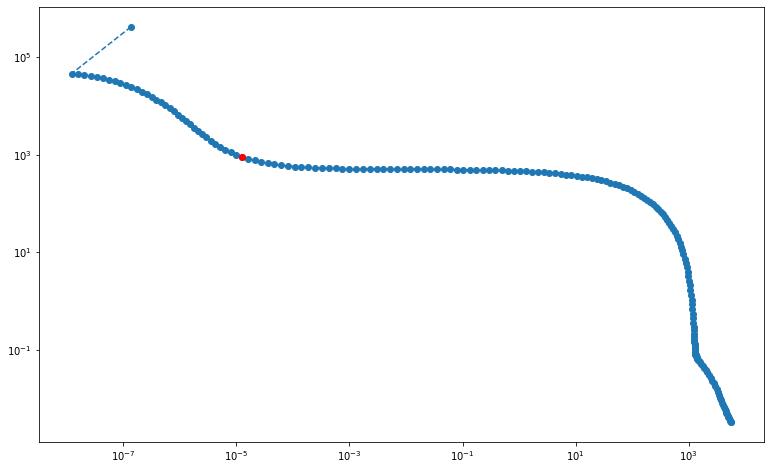

In [19]:
plt.loglog(*fsvals.T, 'o--')
idx=35
print(prange[idx])
plt.loglog(*fsvals[idx], 'ro')

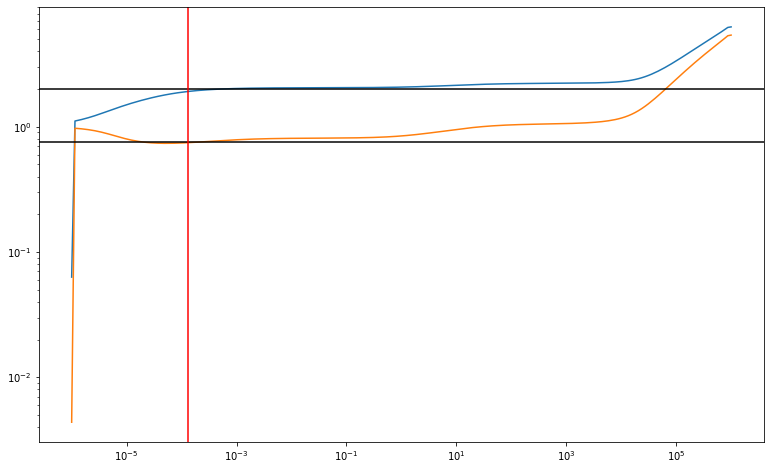

In [20]:
plt.loglog(prange, [float(getp(s['x'])[0]) for s in solutions])
plt.loglog(prange, [float(getp(s['x'])[1]) for s in solutions])
for p in p_true:
    plt.axhline(p, color='k')
idx = 35
plt.axvline(prange[idx], color='r')

[1.9109817986678923, 0.7459157201309916]


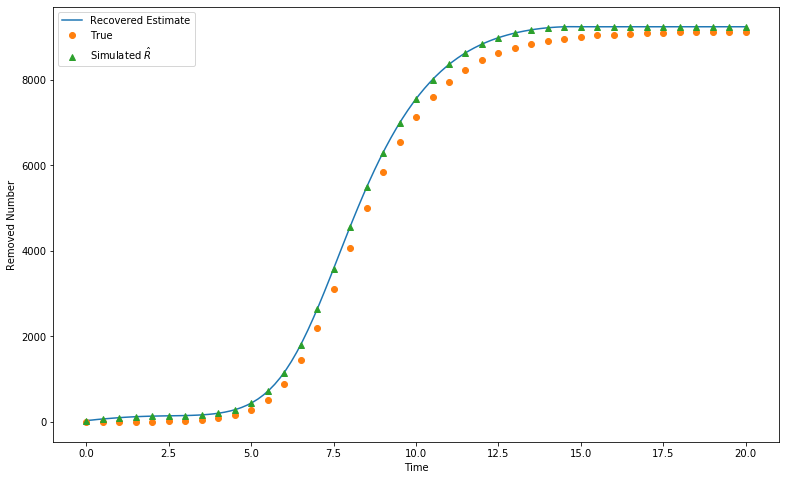

In [21]:
idx = 35
print([float(p) for p in getp(solutions[idx]['x'])])
plt.plot(model.observation_times, getx(solutions[idx]['x'])[-1], label='model')
plt.plot(tofsol, raw_data, 'o', label='data')
plt.plot(tofsol, data.T, '^')
plt.xlabel("Time")
plt.ylabel("Removed Number")
plt.legend([r"Recovered Estimate", "True", r"Simulated $\hat{R}$"])

Text(0, 0.5, 'Number')

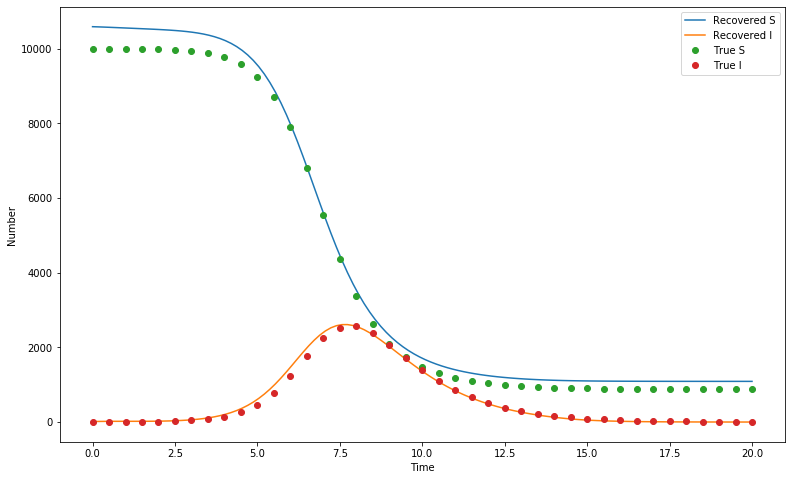

In [22]:
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], label='model, S')
plt.plot(model.observation_times, getx(solutions[idx]['x'])[1], label='model, I')
plt.plot(tofsol, sol.sol(tofsol)[:2,:].T, 'o', label='data')
plt.legend(["Recovered S", "Recovered I", "True S", "True I"])
plt.xlabel("Time")
plt.ylabel("Number")

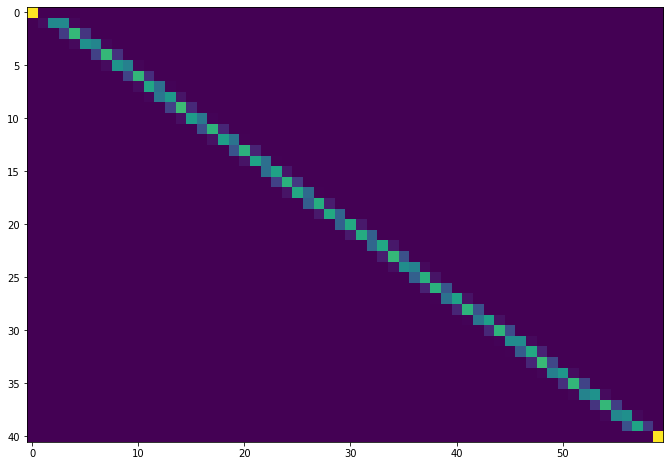

In [23]:
plt.imshow(objective.collocation_matrices[0])

[10561.48069587567, 20.131832043576754, 92.7177430288012]
[1.9109817986678923, 0.7459157201309916]


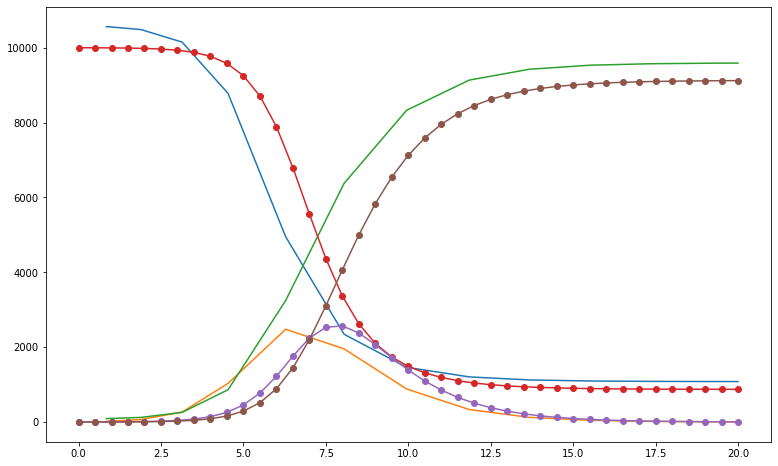

In [24]:
idx = 35
fidx = 5
xs_recovered = getx(solutions[idx]['x'])
print([float(x[fidx]) for x in xs_recovered])
p_recovered = [float(p) for p in getp(solutions[idx]['x'])]
print(p_recovered)
t0t1 = [model.observation_times[fidx], tspan[1]]
sol_recovered = solve_ivp(lambda t, y: system(t, y, p_recovered), t0t1, [x[fidx] for x in getx(solutions[idx]['x'])])
plt.plot(sol_recovered.t, sol_recovered.y.T)
plt.plot(tofsol, sol.sol(tofsol).T, 'o-')

In [25]:
err = lambda i: np.sum([((a-b)/b)**2 for a, b in zip([float(p) for p in getp(solutions[i]['x'])], p_true)])
errs = [err(i) for i in range(200)]
plt.loglog(prange, errs)
idx = 35
plt.loglog(prange[idx], errs[idx], 'ro')

In [26]:
err2 = lambda i: [min(0, xi) for xi in np.concatenate(getx(solutions[i]['x'])).flatten()]
errs2 = np.array([err2(i) for i in range(200)])
plt.imshow(errs2)
plt.colorbar()

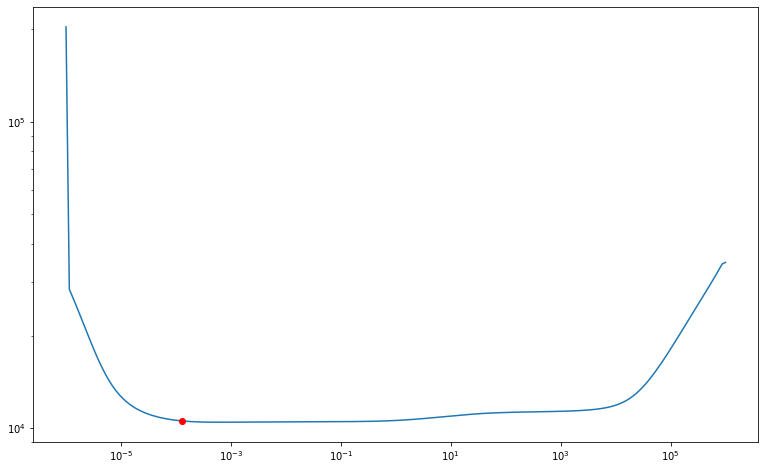

In [27]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(solutions[idx]['x'])]).sum(axis=1))
gotNs = [getN(i) for i,_ in enumerate(prange)]
plt.loglog(prange, gotNs)
idx = 35
plt.loglog(prange[idx], gotNs[idx], 'ro')

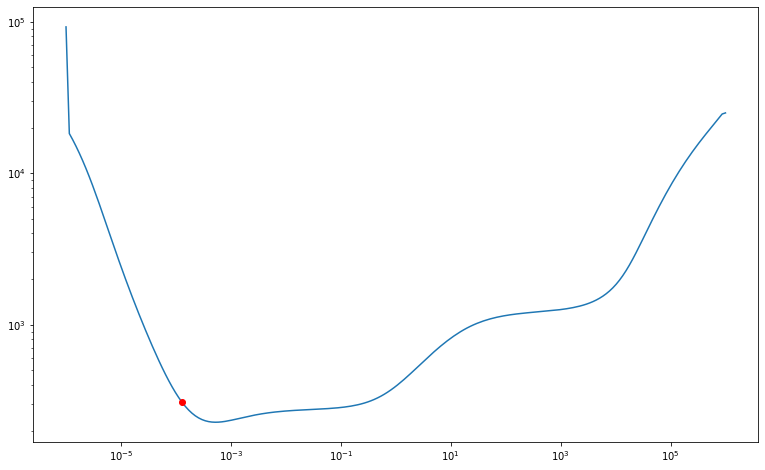

In [28]:
cvfn = lambda idx : np.sqrt(np.sum(((np.array(getx(solutions[idx]['x'])[0]).flatten()) - sol.sol(model.observation_times)[0])**2)/len(model.observation_times))
cerr = [cvfn(i) for i, _ in enumerate(prange)]
plt.loglog(prange, cerr)
idx = 35
plt.loglog(prange[idx], cerr[idx], 'ro')


In [29]:
sol.sol(model.observation_times)[0]

array([9999.        , 9998.62600086, 9998.16454604, 9997.59539931,
       9996.89333883, 9996.02705931, 9994.95817603, 9993.64058799,
       9992.01695166, 9990.01370108, 9987.54095529, 9984.49222877,
       9980.7334291 , 9976.10815557, 9970.4146376 , 9963.39613343,
       9954.74093009, 9944.0823434 , 9930.98405836, 9914.90069302,
       9895.17228682, 9870.96657296, 9841.27607932, 9804.91812847,
       9760.53483761, 9706.6430565 , 9641.32549681, 9562.14426865,
       9466.54442177, 9351.86323507, 9215.33021653, 9054.06710325,
       8865.35987486, 8647.25096967, 8396.62035366, 8111.86495851,
       7793.25855743, 7442.95176519, 7064.97203812, 6665.22367409,
       6251.43316919, 5831.36500039, 5412.49348004, 5001.77446302,
       4605.27068067, 4228.15174083, 3874.69412782, 3548.28120242,
       3251.4032019 , 2985.53451065, 2748.523494  , 2537.3743487 ,
       2349.71237565, 2183.29968472, 2036.03519471, 1905.95463337,
       1791.23053741, 1690.17225246, 1601.21095241, 1522.72700

In [30]:
idx = 35
for x in getx(solutions[idx]['x']):
    xx = np.array(x).flatten()
    plt.plot(model.observation_times, xx/np.max(np.abs(xx)), linewidth=5)
plt.plot(model.observation_times, model.phi, '--');


In [31]:
lbx = [-np.inf]*(config['basis_number']*3) + p_true
ubx = [np.inf]*(config['basis_number']*3) + p_true
correct_data = solver(x0=x0, p=[prange[idx], 0], lbx=lbx, lbg=0, ubx=ubx);

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     1926

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

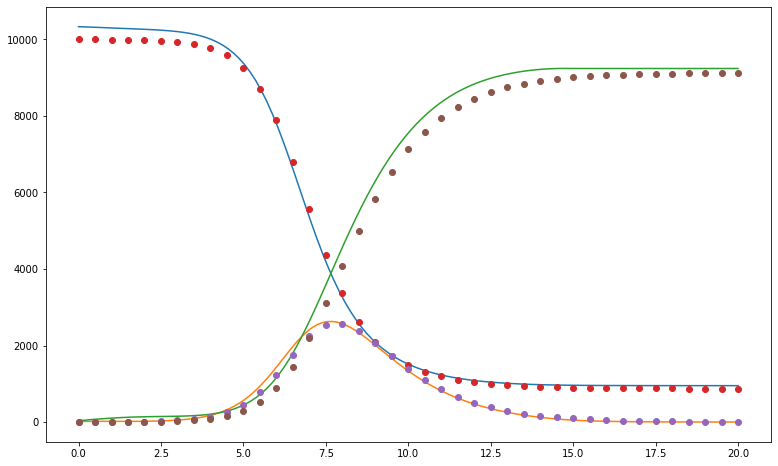

In [32]:
correct_xs = getx(correct_data['x'])
plt.plot(model.observation_times, np.hstack([np.array(c) for c in correct_xs]))
plt.plot(tofsol, sol.sol(tofsol).T, 'o')

In [33]:
pref = getp(solutions[idx]['x'])

In [34]:
conf = stats.chi.ppf(0.95, 1) 

In [35]:
idx = 35
rho = prange[idx]
pvals = np.linspace(-1, 4, 100)
profile = []
profile_r = []
for pval in pvals:
    lbxp = [-np.inf]*(config['basis_number']*3) + [pval, -np.inf]
    ubxp = [np.inf]*(config['basis_number']*3) + [pval, np.inf]
    profile.append(solver(x0=solutions[idx]['x'], p=[rho, 0], lbx=lbxp, ubx=ubxp, lbg=0))
    profile_r.append(solver(x0=solutions[idx]['x'], p=[rho, 0.5], lbx=lbxp, ubx=ubxp, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 126  3.8931162e+01 0.00e+00 1.16e-03  -8.6 7.05e+00    -  1.00e+00 1.00e+00H  1
 127  3.8930860e+01 0.00e+00 3.08e-06  -8.6 3.02e-01    -  1.00e+00 1.00e+00f  1
 128  3.8930860e+01 0.00e+00 7.10e-07  -8.6 6.10e-02  -5.0 1.00e+00 1.00e+00h  1
 129  3.8930857e+01 0.00e+00 2.09e-04  -8.6 4.82e+01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  3.8930854e+01 0.00e+00 1.23e-04  -8.6 2.42e+00    -  1.00e+00 1.00e+00h  1
 131  3.8930849e+01 0.00e+00 1.89e-05  -8.6 1.00e+00    -  1.00e+00 1.00e+00h  1
 132  3.8930931e+01 0.00e+00 6.94e-04  -8.6 5.74e+00    -  1.00e+00 1.00e+00H  1
 133  3.8930837e+01 0.00e+00 1.01e-06  -8.6 2.94e-01    -  1.00e+00 1.00e+00f  1
 134  3.8930837e+01 0.00e+00 3.85e-04  -8.6 8.87e+01    -  1.00e+00 3.12e-02h  6
 135  3.8930831e+01 0.00e+00 1.14e-05  -8.6 8.22e-01    -  1.00e+00 1.00e+00h  1
 136  3.8931243e+01 0.00e+00 1.61e-03  -8.6 8.95e+00    -  1.00e+00 1.00e+00H  1
 137  3.8930816e+01 0.00e+00

 239  3.8930705e+01 0.00e+00 1.35e-04  -8.6 4.91e+00  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  3.8930705e+01 0.00e+00 5.05e-06  -8.6 1.01e+00    -  1.00e+00 1.00e+00h  1
 241  3.8930833e+01 0.00e+00 3.07e-03  -8.6 2.32e+01    -  1.00e+00 1.00e+00H  1
 242  3.8930704e+01 0.00e+00 4.43e-06  -8.6 5.62e-01    -  1.00e+00 1.00e+00f  1
 243  3.8930704e+01 0.00e+00 5.67e-05  -8.6 3.29e+00  -8.4 1.00e+00 1.00e+00h  1
 244  3.8930704e+01 0.00e+00 2.84e-05  -8.6 2.36e+00    -  1.00e+00 1.00e+00h  1
 245  3.8930704e+01 0.00e+00 1.11e-04  -8.6 4.64e+00    -  1.00e+00 1.00e+00h  1
 246  3.8930703e+01 0.00e+00 7.20e-06  -8.6 1.22e+00    -  1.00e+00 1.00e+00h  1
 247  3.8930705e+01 0.00e+00 3.84e-04  -8.6 1.71e+01    -  1.00e+00 5.00e-01h  2
 248  3.8930703e+01 0.00e+00 3.27e-07  -8.6 4.16e-01    -  1.00e+00 1.00e+00h  1
 249  3.9042199e+01 0.00e+00 1.15e-01  -8.6 1.36e+02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

 116  4.2520660e+01 0.00e+00 1.28e-01  -8.6 8.95e+01    -  4.22e-02 1.35e-02f  1
 117  4.2500671e+01 0.00e+00 1.24e-01  -8.6 8.83e+01    -  4.48e-02 3.54e-02f  1
 118  4.2483897e+01 1.68e-13 1.20e-01  -8.6 8.53e+01    -  4.09e-02 3.09e-02f  1
 119  4.2462751e+01 0.00e+00 1.15e-01  -8.6 8.28e+01    -  2.42e-02 4.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.2462154e+01 0.00e+00 1.15e-01  -8.6 7.02e+01    -  1.47e-02 1.18e-03f  1
 121  4.2453894e+01 0.00e+00 1.13e-01  -8.6 7.02e+01    -  4.54e-02 1.65e-02f  1
 122  4.2450988e+01 0.00e+00 1.13e-01  -8.6 7.00e+01    -  4.06e-03 5.88e-03f  1
 123  4.2408002e+01 0.00e+00 1.04e-01  -8.6 6.99e+01    -  1.43e-02 9.14e-02f  1
 124  4.2386413e+01 0.00e+00 9.94e-02  -8.6 6.86e+01    -  1.83e-01 5.01e-02f  1
 125  4.2378760e+01 0.00e+00 9.76e-02  -8.6 6.78e+01    -  2.08e-03 1.86e-02f  1
 126  4.2376138e+01 0.00e+00 9.70e-02  -8.6 6.75e+01    -  1.07e-02 6.46e-03f  1
 127  4.2362071e+01 0.00e+00

  65  3.8931287e+01 0.00e+00 6.33e-04  -8.6 4.19e+00    -  1.00e+00 1.00e+00h  1
  66  3.8931079e+01 0.00e+00 1.44e-06  -8.6 2.98e-01    -  1.00e+00 1.00e+00f  1
  67  3.8931070e+01 0.00e+00 1.96e-04  -8.6 4.44e+01    -  1.00e+00 3.12e-02f  6
  68  3.8931060e+01 0.00e+00 1.09e-04  -8.6 1.84e+00    -  1.00e+00 1.00e+00h  1
  69  3.8931046e+01 0.00e+00 3.67e-05  -8.6 1.11e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.8931063e+01 0.00e+00 2.97e-04  -8.6 3.04e+00    -  1.00e+00 1.00e+00h  1
  71  3.8931022e+01 0.00e+00 5.12e-06  -8.6 4.58e-01    -  1.00e+00 1.00e+00f  1
  72  3.8931017e+01 0.00e+00 1.40e-04  -8.6 1.68e+01    -  1.00e+00 1.25e-01f  4
  73  3.8931004e+01 0.00e+00 2.09e-05  -8.6 8.83e-01    -  1.00e+00 1.00e+00h  1
  74  3.8931202e+01 0.00e+00 7.81e-04  -8.6 5.03e+00    -  1.00e+00 1.00e+00H  1
  75  3.8930974e+01 0.00e+00 1.87e-06  -8.6 2.87e-01    -  1.00e+00 1.00e+00f  1
  76  3.8930973e+01 0.00e+00

  17  5.2910697e+01 0.00e+00 4.49e-05  -5.7 2.92e+00  -5.9 1.00e+00 1.00e+00f  1
  18  5.2910201e+01 0.00e+00 2.57e-06  -5.7 3.59e+00  -6.4 1.00e+00 1.00e+00f  1
  19  5.2909614e+01 0.00e+00 5.60e-06  -8.6 5.95e+00  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.2909202e+01 0.00e+00 1.80e-06  -8.6 8.00e+00  -7.3 1.00e+00 1.00e+00f  1
  21  5.2908973e+01 0.00e+00 6.62e-07  -8.6 8.93e+00  -7.8 1.00e+00 7.99e-01f  1
  22  5.2908817e+01 0.00e+00 4.63e-08  -8.6 9.11e+00  -8.3 1.00e+00 1.00e+00f  1
  23  5.2908792e+01 0.00e+00 1.68e-07  -8.6 6.42e+00  -8.8 1.00e+00 8.26e-01h  1
  24  5.2908758e+01 0.00e+00 6.29e-09  -8.6 1.11e+01  -9.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   1.6940719157401851e+01    5.2908757540420240e+01
Dual infeasibility......:   6.2908026512503636e-09    1.9647250457145575e-08
Constraint viol

 100  3.8930713e+01 0.00e+00 1.31e-05  -8.6 2.89e-01  -4.9 1.00e+00 1.00e+00f  1
 101  3.8930724e+01 0.00e+00 7.52e-04  -8.6 1.00e+01    -  1.00e+00 1.00e+00h  1
 102  3.8930712e+01 0.00e+00 4.03e-07  -8.6 3.03e-01    -  1.00e+00 1.00e+00h  1
 103  4.4440254e+01 0.00e+00 8.05e-01  -8.6 2.65e+02    -  1.00e+00 1.00e+00H  1
 104  4.1953994e+01 0.00e+00 8.54e-01  -8.6 3.01e+02    -  1.00e+00 1.00e+00F  1
 105  3.9433515e+01 0.00e+00 3.99e-01  -8.6 1.45e+02  -4.5 1.00e+00 1.00e+00F  1
 106  3.8936249e+01 0.00e+00 4.48e-02  -8.6 7.82e+01    -  1.00e+00 1.00e+00F  1
 107  3.8930695e+01 0.00e+00 2.01e-05  -8.6 2.73e-01  -4.9 1.00e+00 1.00e+00f  1
 108  3.8930695e+01 0.00e+00 1.41e-04  -8.6 7.48e+00    -  1.00e+00 1.00e+00h  1
 109  3.8930695e+01 0.00e+00 2.73e-06  -8.6 1.09e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.8930793e+01 0.00e+00 6.26e-03  -8.6 4.91e+01    -  1.00e+00 1.00e+00H  1
 111  3.8930694e+01 0.00e+00

 115  4.2711238e+01 0.00e+00 1.52e-01  -9.0 1.56e+02    -  2.72e-05 5.37e-04f  1
 116  4.2704621e+01 0.00e+00 1.52e-01  -9.0 1.52e+02    -  1.44e-03 6.45e-03f  1
 117  4.2699392e+01 1.38e-12 1.51e-01  -9.0 1.44e+02    -  5.03e-02 5.16e-03f  1
 118  4.2696520e+01 0.00e+00 1.50e-01  -9.0 1.27e+02    -  1.01e-02 2.88e-03f  1
 119  4.2692119e+01 0.00e+00 1.50e-01  -9.0 1.21e+02    -  2.41e-03 4.45e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.2684414e+01 0.00e+00 1.48e-01  -9.0 1.20e+02    -  1.81e-02 7.85e-03f  1
 121  4.2671839e+01 0.00e+00 1.47e-01  -9.0 1.19e+02    -  1.53e-02 1.29e-02f  1
 122  4.2655895e+01 2.94e-12 1.44e-01  -9.0 1.18e+02    -  9.84e-03 1.67e-02f  1
 123  4.2598663e+01 2.62e-12 1.36e-01  -9.0 1.16e+02    -  3.51e-02 6.22e-02f  1
 124  4.2551310e+01 2.61e-12 1.29e-01  -9.0 1.10e+02    -  8.84e-02 5.47e-02f  1
 125  4.2537293e+01 0.00e+00 1.27e-01  -9.0 1.04e+02    -  5.60e-02 1.68e-02f  1
 126  4.2536293e+01 2.00e-13

  53  3.8932384e+01 0.00e+00 3.31e-04  -5.7 1.39e+00    -  1.00e+00 1.00e+00f  1
  54  3.8932335e+01 0.00e+00 1.28e-04  -5.7 8.92e-01    -  1.00e+00 1.00e+00f  1
  55  3.8932303e+01 0.00e+00 2.35e-04  -5.7 2.11e+00    -  1.00e+00 5.00e-01f  2
  56  3.8932260e+01 0.00e+00 1.87e-04  -5.7 1.14e+00    -  1.00e+00 1.00e+00f  1
  57  3.8932221e+01 0.00e+00 2.46e-04  -5.7 1.35e+00    -  1.00e+00 1.00e+00f  1
  58  3.8932183e+01 0.00e+00 1.23e-04  -5.7 9.86e-01    -  1.00e+00 1.00e+00f  1
  59  3.8932161e+01 0.00e+00 3.98e-04  -5.7 1.83e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.8932113e+01 0.00e+00 3.55e-05  -5.7 5.68e-01    -  1.00e+00 1.00e+00f  1
  61  3.8932089e+01 0.00e+00 2.10e-04  -5.7 5.24e+00    -  1.00e+00 2.50e-01f  3
  62  3.8932058e+01 0.00e+00 9.19e-05  -5.7 9.55e-01    -  1.00e+00 1.00e+00f  1
  63  3.8932047e+01 0.00e+00 3.87e-04  -5.7 2.02e+00    -  1.00e+00 1.00e+00h  1
  64  3.8932000e+01 0.00e+00

 187  3.8930717e+01 0.00e+00 1.54e-04  -8.6 4.34e+00    -  1.00e+00 1.00e+00H  1
 188  3.8930716e+01 0.00e+00 5.91e-06  -8.6 9.07e-01    -  1.00e+00 1.00e+00f  1
 189  3.8930971e+01 0.00e+00 3.29e-03  -8.6 1.98e+01    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.8930714e+01 0.00e+00 6.71e-06  -8.6 5.70e-01    -  1.00e+00 1.00e+00f  1
 191  3.8930714e+01 0.00e+00 1.20e-04  -8.6 2.91e+01  -8.6 1.00e+00 1.25e-01h  4
 192  3.8930713e+01 0.00e+00 1.51e-05  -8.6 1.44e+00    -  1.00e+00 1.00e+00h  1
 193  3.8930720e+01 0.00e+00 5.67e-04  -8.6 8.59e+00    -  1.00e+00 1.00e+00H  1
 194  3.8930713e+01 0.00e+00 7.21e-08  -8.6 3.34e-01    -  1.00e+00 1.00e+00f  1
 195  3.8930713e+01 0.00e+00 7.22e-04  -8.6 1.58e+02    -  1.00e+00 3.12e-02h  6
 196  3.8930712e+01 0.00e+00 3.88e-06  -8.6 7.89e-01    -  1.00e+00 1.00e+00h  1
 197  3.8930712e+01 0.00e+00 1.19e-04  -8.6 2.87e+01    -  1.00e+00 1.25e-01h  4
 198  3.8930712e+01 0.00e+00

  89  3.8931008e+01 0.00e+00 2.63e-04  -8.6 1.14e+01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.8930981e+01 0.00e+00 6.05e-06  -8.6 5.30e-01    -  1.00e+00 1.00e+00f  1
  91  3.8930975e+01 0.00e+00 9.48e-05  -8.6 1.37e+01    -  1.00e+00 1.25e-01h  4
  92  3.8930967e+01 0.00e+00 5.11e-05  -8.6 1.34e+00    -  1.00e+00 1.00e+00h  1
  93  3.8930963e+01 0.00e+00 1.68e-04  -8.6 2.39e+00    -  1.00e+00 1.00e+00h  1
  94  3.8930951e+01 0.00e+00 1.54e-05  -8.6 7.88e-01    -  1.00e+00 1.00e+00h  1
  95  3.8931479e+01 0.00e+00 1.44e-03  -8.6 6.93e+00    -  1.00e+00 1.00e+00H  1
  96  3.8930921e+01 0.00e+00 5.00e-06  -8.6 3.18e-01    -  1.00e+00 1.00e+00f  1
  97  3.8930921e+01 0.00e+00 1.84e-04  -8.6 2.11e+01  -7.2 1.00e+00 1.25e-01h  4
  98  3.8930909e+01 0.00e+00 1.17e-05  -8.6 7.29e-01    -  1.00e+00 1.00e+00h  1
  99  3.8930907e+01 0.00e+00 1.37e-04  -8.6 8.83e+00    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7717551e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.0127107e+02 0.00e+00 4.81e-02  -1.0 1.06e+01    -  9.89e-01 1.00e+00f  1
   2  2.5742324e+02 0.00e+00 3.70e-01  -1.0 5.98e+02    -  9.41e-01 1.00e+00f  1
   3  1.4022729e+02 0.00e+00 3.43e+00  -1.0 1.79e+03    -  3.50e-01 1.00e+00f  1
   4  1.0547720e+02 0.00e+00 7.55e-01  -1.0 1.70e+03    -  5.22e-01 1.00e+00f  1
 

 183  3.8930849e+01 0.00e+00 5.17e-04  -8.6 1.08e+02    -  9.92e-01 1.56e-02f  7
 184  3.8930846e+01 0.00e+00 9.20e-05  -8.6 2.04e+00    -  1.00e+00 1.00e+00h  1
 185  3.8930842e+01 0.00e+00 4.37e-05  -8.6 1.43e+00    -  1.00e+00 1.00e+00h  1
 186  3.8930842e+01 0.00e+00 1.85e-04  -8.6 2.91e+00    -  1.00e+00 1.00e+00h  1
 187  3.8930835e+01 0.00e+00 1.00e-05  -8.6 7.45e-01    -  1.00e+00 1.00e+00h  1
 188  3.8930883e+01 0.00e+00 6.25e-04  -8.6 1.06e+01    -  1.00e+00 5.00e-01h  2
 189  3.8930825e+01 0.00e+00 4.79e-07  -8.6 3.11e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.8930823e+01 0.00e+00 3.15e-04  -8.6 6.63e+01    -  1.00e+00 3.12e-02h  6
 191  3.8930820e+01 0.00e+00 4.38e-05  -8.6 1.49e+00    -  1.00e+00 1.00e+00h  1
 192  3.8930819e+01 0.00e+00 1.72e-04  -8.6 2.92e+00    -  1.00e+00 1.00e+00h  1
 193  3.8930814e+01 0.00e+00 1.10e-05  -8.6 8.01e-01    -  1.00e+00 1.00e+00h  1
 194  3.8931332e+01 0.00e+00

  47  3.9302913e+01 0.00e+00 1.80e-01  -5.7 4.06e+02    -  1.79e-01 1.99e-01f  1
  48  3.9233932e+01 0.00e+00 1.42e-01  -5.7 3.02e+02    -  7.70e-02 2.96e-01f  1
  49  3.9204685e+01 0.00e+00 1.23e-01  -5.7 1.93e+02    -  3.88e-01 1.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.9187365e+01 0.00e+00 1.11e-01  -5.7 1.59e+02    -  1.00e+00 1.29e-01f  1
  51  3.9171468e+01 0.00e+00 1.00e-01  -5.7 1.25e+02    -  1.00e+00 1.29e-01f  1
  52  3.9140327e+01 0.00e+00 9.14e-02  -5.7 1.02e+02    -  1.00e+00 3.03e-01f  1
  53  3.9109032e+01 0.00e+00 8.78e-02  -5.7 6.46e+01    -  1.00e+00 4.18e-01f  1
  54  3.9072706e+01 0.00e+00 1.28e-01  -5.7 3.34e+01    -  8.60e-01 9.85e-01f  1
  55  3.9042763e+01 0.00e+00 4.27e-02  -5.7 1.24e+01    -  1.00e+00 8.56e-01f  1
  56  3.9034815e+01 0.00e+00 1.23e-01  -5.7 3.08e+01    -  9.48e-01 1.00e+00f  1
  57  3.9002729e+01 0.00e+00 9.02e-03  -5.7 4.34e+00    -  1.00e+00 1.00e+00f  1
  58  3.8993035e+01 0.00e+00

 194  3.8931289e+01 0.00e+00 2.48e-03  -8.6 1.17e+01    -  1.00e+00 1.00e+00H  1
 195  3.8930773e+01 0.00e+00 7.45e-06  -8.6 4.32e-01    -  1.00e+00 1.00e+00f  1
 196  3.8930777e+01 0.00e+00 3.03e-04  -8.6 4.30e+00  -7.2 1.00e+00 1.00e+00H  1
 197  3.8930769e+01 0.00e+00 2.51e-06  -8.6 5.02e-01    -  1.00e+00 1.00e+00f  1
 198  3.8949449e+01 0.00e+00 1.76e-02  -8.6 3.12e+01    -  1.00e+00 1.00e+00H  1
 199  3.8930756e+01 0.00e+00 3.03e-04  -8.6 2.75e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8930750e+01 0.00e+00 6.54e-07  -8.6 1.47e-01  -5.8 1.00e+00 1.00e+00h  1
 201  3.9074416e+01 0.00e+00 6.14e-02  -8.6 6.04e+01    -  1.00e+00 1.00e+00H  1
 202  3.8931097e+01 0.00e+00 3.22e-03  -8.6 1.02e+01    -  1.00e+00 1.00e+00F  1
 203  3.8930728e+01 0.00e+00 9.31e-06  -8.6 3.83e-01  -5.4 1.00e+00 1.00e+00f  1
 204  3.8930735e+01 0.00e+00 4.98e-04  -8.6 1.36e+01    -  1.00e+00 5.00e-01h  2
 205  3.8930726e+01 0.00e+00

   9  8.8028322e+01 0.00e+00 4.53e+01  -1.0 2.47e+04    -  6.42e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6528666e+01 0.00e+00 3.37e+02  -1.0 4.18e+04    -  7.36e-01 1.00e+00f  1
  11  8.7128397e+01 0.00e+00 6.82e-03  -1.0 8.87e+00  -4.0 1.00e+00 1.00e+00f  1
  12  7.9833733e+01 0.00e+00 3.70e+00  -2.5 2.35e+03    -  9.46e-01 1.00e+00f  1
  13  7.9448726e+01 0.00e+00 1.02e+02  -2.5 1.72e+04    -  8.31e-01 1.00e+00f  1
  14  7.7928732e+01 0.00e+00 7.02e+01  -2.5 3.78e+04    -  1.00e+00 1.00e+00f  1
  15  7.7817956e+01 0.00e+00 1.53e-04  -2.5 3.50e+00  -4.5 1.00e+00 1.00e+00f  1
  16  7.7563073e+01 0.00e+00 2.42e+00  -3.8 2.88e+03    -  1.00e+00 1.00e+00f  1
  17  7.7554990e+01 0.00e+00 6.08e+00  -3.8 8.43e+04    -  1.00e+00 1.25e-01f  4
  18  7.7519738e+01 0.00e+00 4.66e+00  -3.8 3.04e+03    -  1.00e+00 1.00e+00f  1
  19  7.7511608e+01 0.00e+00 5.19e+00  -3.8 1.78e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 193  3.8167148e+01 0.00e+00 8.33e+02  -8.6 8.70e+04    -  1.00e+00 1.00e+00f  1
 194  3.8145250e+01 0.00e+00 5.77e+01  -8.6 3.79e+04    -  1.00e+00 1.00e+00f  1
 195  3.8136377e+01 0.00e+00 3.64e+02  -8.6 2.31e+05    -  1.00e+00 2.50e-01f  3
 196  3.8124819e+01 0.00e+00 4.65e+02  -8.6 7.62e+04    -  1.00e+00 1.00e+00f  1
 197  3.8113637e+01 0.00e+00 3.09e+02  -8.6 6.74e+04    -  1.00e+00 1.00e+00f  1
 198  3.8105905e+01 0.00e+00 6.98e+02  -8.6 9.76e+04    -  1.00e+00 1.00e+00f  1
 199  3.8095592e+01 0.00e+00 1.44e+02  -8.6 5.56e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8090596e+01 0.00e+00 6.57e+02  -8.6 1.86e+05    -  1.00e+00 5.00e-01f  2
 201  3.8082616e+01 0.00e+00 1.79e+02  -8.6 6.31e+04    -  1.00e+00 1.00e+00f  1
 202  3.8078349e+01 0.00e+00 5.34e+02  -8.6 1.74e+05    -  1.00e+00 5.00e-01f  2
 203  3.8072436e+01 0.00e+00 2.84e+02  -8.6 7.86e+04    -  1.00e+00 1.00e+00f  1
 204  3.8069419e+01 0.00e+00

  81  6.4542946e+01 0.00e+00 8.75e+00  -8.6 1.77e+04  -9.7 3.06e-02 1.16e-02f  1
  82  6.3465849e+01 0.00e+00 8.55e+00  -8.6 5.65e+03  -9.3 2.24e-02 6.60e-02f  1
  83  6.3461792e+01 3.05e-14 8.55e+00  -8.6 2.14e+04  -9.8 1.80e-03 1.26e-04f  1
  84  6.3358576e+01 0.00e+00 8.51e+00  -8.6 6.82e+03  -9.3 2.16e-03 5.67e-03f  1
  85  6.2967550e+01 0.00e+00 8.68e+00  -8.6 2.61e+04  -9.8 9.16e-03 1.07e-02f  1
  86  6.2674598e+01 0.00e+00 8.59e+00  -8.6 8.05e+03  -9.4 1.77e-04 1.48e-02f  1
  87  6.2674574e+01 0.00e+00 8.59e+00  -8.6 4.19e+04  -9.9 1.53e-02 4.60e-07f  1
  88  6.2543523e+01 0.00e+00 8.55e+00  -8.6 8.97e+03  -9.4 4.13e-03 6.27e-03f  1
  89  6.2031414e+01 0.00e+00 8.97e+00  -8.6 3.52e+04  -9.9 1.05e-02 1.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  6.2006426e+01 0.00e+00 8.96e+00  -8.6 1.07e+04  -9.5 6.70e-02 1.08e-03f  1
  91  6.1948511e+01 0.00e+00 8.97e+00  -8.6 7.66e+04 -10.0 1.65e-03 6.57e-04f  1
  92  6.1911096e+01 0.00e+00

 224  3.9985061e+01 0.00e+00 4.54e+02  -8.6 1.28e+05    -  1.00e+00 5.00e-01f  2
 225  3.9973368e+01 0.00e+00 3.14e+02  -8.6 6.65e+04    -  1.00e+00 1.00e+00f  1
 226  3.9964964e+01 0.00e+00 6.60e+02  -8.6 9.34e+04    -  1.00e+00 1.00e+00f  1
 227  3.9954414e+01 0.00e+00 1.60e+02  -8.6 5.64e+04    -  1.00e+00 1.00e+00f  1
 228  3.9948932e+01 0.00e+00 5.78e+02  -8.6 1.69e+05    -  1.00e+00 5.00e-01f  2
 229  3.9940923e+01 0.00e+00 2.31e+02  -8.6 6.77e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.9940557e+01 0.00e+00 1.26e+03  -8.6 1.42e+05    -  1.00e+00 1.00e+00f  1
 231  3.9928255e+01 0.00e+00 2.17e+01  -8.6 4.27e+04    -  1.00e+00 1.00e+00f  1
 232  3.9925225e+01 0.00e+00 7.56e+02  -8.6 4.61e+05    -  1.00e+00 2.50e-01f  3
 233  3.9919689e+01 0.00e+00 1.30e+02  -8.6 6.21e+04    -  1.00e+00 1.00e+00f  1
 234  3.9917275e+01 0.00e+00 7.00e+02  -8.6 2.29e+05    -  1.00e+00 5.00e-01f  2
 235  3.9913189e+01 0.00e+00

  91  4.1618596e+01 0.00e+00 1.81e+02  -5.7 1.02e+04    -  1.14e-01 1.00e+00f  1
  92  4.0992381e+01 0.00e+00 2.33e+01  -5.7 7.84e+03    -  1.86e-01 1.00e+00f  1
  93  4.0690689e+01 0.00e+00 1.87e+02  -5.7 2.17e+04    -  1.44e-01 5.00e-01f  2
  94  4.0293583e+01 0.00e+00 6.03e+01  -5.7 1.05e+04    -  7.18e-01 1.00e+00f  1
  95  4.0254657e+01 0.00e+00 5.19e+02  -5.7 2.15e+04    -  1.00e+00 1.00e+00f  1
  96  3.9742989e+01 0.00e+00 4.95e+01  -5.7 1.02e+04    -  1.00e+00 1.00e+00f  1
  97  3.9629802e+01 0.00e+00 3.95e+02  -5.7 1.80e+05    -  4.55e-01 1.25e-01f  4
  98  3.9406851e+01 0.00e+00 1.35e+01  -5.7 1.30e+04    -  1.00e+00 1.00e+00f  1
  99  3.9384831e+01 0.00e+00 6.06e+02  -5.7 6.11e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9165354e+01 0.00e+00 2.31e+01  -5.7 1.40e+04    -  1.00e+00 1.00e+00f  1
 101  3.9126538e+01 0.00e+00 5.64e+02  -5.7 1.38e+05    -  1.00e+00 2.50e-01f  3
 102  3.8996394e+01 0.00e+00

  83  5.7599773e+01 0.00e+00 1.06e+02  -5.7 8.47e+03    -  1.00e+00 1.00e+00f  1
  84  5.3886804e+01 0.00e+00 2.80e+01  -5.7 2.91e+03    -  1.00e+00 1.00e+00f  1
  85  5.1004256e+01 0.00e+00 4.62e+01  -5.7 3.77e+03    -  1.00e+00 1.00e+00f  1
  86  4.8734127e+01 0.00e+00 2.23e+02  -5.7 1.08e+04    -  1.00e+00 1.00e+00f  1
  87  4.7730456e+01 0.00e+00 2.26e+02  -5.7 1.44e+04    -  1.00e+00 3.44e-01f  2
  88  4.5375539e+01 0.00e+00 1.56e+01  -5.7 7.08e+03    -  1.00e+00 1.00e+00f  1
  89  4.4795756e+01 0.00e+00 8.07e+00  -5.7 9.39e+03 -10.8 1.00e+00 2.24e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.4231373e+01 0.00e+00 2.56e+02  -5.7 2.34e+04    -  8.65e-01 5.00e-01f  2
  91  4.3323165e+01 0.00e+00 2.96e+01  -5.7 6.58e+03    -  1.00e+00 1.00e+00f  1
  92  4.2879998e+01 0.00e+00 2.87e+02  -5.7 2.85e+04    -  1.00e+00 5.00e-01f  2
  93  4.2285469e+01 0.00e+00 2.07e+01  -5.7 9.12e+03    -  1.00e+00 1.00e+00f  1
  94  4.2039281e+01 0.00e+00

  87  4.7042730e+01 0.00e+00 7.87e+00  -5.7 1.22e+03    -  2.06e-02 3.16e-02f  1
  88  4.6053495e+01 0.00e+00 6.97e+00  -5.7 1.14e+03    -  1.41e-01 1.40e-01f  1
  89  4.5392222e+01 0.00e+00 6.28e+00  -5.7 8.51e+02    -  4.06e-02 1.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.5370400e+01 0.00e+00 6.25e+00  -5.7 7.48e+02    -  1.49e-01 4.18e-03f  1
  91  4.4944886e+01 0.00e+00 5.77e+00  -5.7 7.16e+02    -  2.47e-01 8.59e-02f  1
  92  4.4857991e+01 0.00e+00 5.67e+00  -5.7 5.99e+02    -  2.94e-02 1.89e-02f  1
  93  4.4706029e+01 0.00e+00 5.48e+00  -5.7 5.85e+02    -  6.03e-02 3.41e-02f  1
  94  4.4588420e+01 0.00e+00 5.34e+00  -5.7 5.60e+02    -  1.23e-02 2.71e-02f  1
  95  4.3908600e+01 0.00e+00 4.61e+00  -5.7 5.41e+02    -  2.53e-01 1.74e-01f  1
  96  4.3776092e+01 0.00e+00 4.45e+00  -5.7 4.12e+02    -  1.39e-02 3.81e-02f  1
  97  4.3714007e+01 0.00e+00 4.37e+00  -5.7 3.93e+02    -  5.76e-02 1.84e-02f  1
  98  4.3397596e+01 0.00e+00

 216  3.8930947e+01 0.00e+00 8.93e-05  -8.6 1.70e+00    -  1.00e+00 1.00e+00h  1
 217  3.8930940e+01 0.00e+00 7.36e-05  -8.6 1.56e+00    -  1.00e+00 1.00e+00h  1
 218  3.8930933e+01 0.00e+00 1.06e-04  -8.6 1.87e+00    -  1.00e+00 1.00e+00h  1
 219  3.8930926e+01 0.00e+00 5.09e-05  -8.6 1.33e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.8930925e+01 0.00e+00 2.11e-04  -8.6 2.65e+00    -  1.00e+00 1.00e+00h  1
 221  3.8930913e+01 0.00e+00 1.19e-05  -8.6 7.04e-01    -  1.00e+00 1.00e+00h  1
 222  3.8932218e+01 0.00e+00 2.70e-03  -8.6 9.34e+00    -  1.00e+00 1.00e+00H  1
 223  3.8930883e+01 0.00e+00 1.31e-05  -8.6 4.42e-01    -  1.00e+00 1.00e+00f  1
 224  3.8930879e+01 0.00e+00 5.38e-04  -8.6 1.77e+02  -7.2 5.85e-01 1.15e-02f  7
 225  3.8930874e+01 0.00e+00 5.29e-05  -8.6 1.44e+00    -  1.00e+00 1.00e+00h  1
 226  3.8930872e+01 0.00e+00 1.75e-04  -8.6 2.59e+00    -  1.00e+00 1.00e+00h  1
 227  3.8930865e+01 0.00e+00

  25  7.0935106e+01 0.00e+00 1.27e+01  -5.7 9.32e+02  -9.4 1.01e-04 3.27e-01f  1
  26  6.7093151e+01 0.00e+00 1.07e+01  -5.7 2.74e+03  -9.8 1.00e+00 2.28e-01f  1
  27  6.4069759e+01 0.00e+00 9.01e+00  -5.7 7.38e+03 -10.3 2.02e-01 1.91e-01f  1
  28  6.0121675e+01 0.00e+00 6.93e+00  -5.7 2.29e+03  -9.9 7.12e-02 3.10e-01f  1
  29  5.4887876e+01 0.00e+00 4.49e+00  -5.7 8.04e+03 -10.4 2.16e-01 5.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.9893237e+01 0.00e+00 2.49e+00  -5.7 2.81e+03  -9.9 5.11e-01 1.00e+00f  1
  31  4.3767679e+01 0.00e+00 2.50e+00  -5.7 3.98e+04 -10.4 1.00e+00 2.94e-01f  1
  32  4.3767364e+01 0.00e+00 2.50e+00  -5.7 2.89e+03  -8.2 2.66e-01 2.90e-05f  1
  33  4.3576563e+01 0.00e+00 2.48e+00  -5.7 1.05e+04  -8.7 2.19e-01 5.83e-03f  1
  34  4.3540020e+01 0.00e+00 2.47e+00  -5.7 2.12e+03    -  1.96e-02 4.43e-03f  1
  35  4.3445343e+01 0.00e+00 2.44e+00  -5.7 1.91e+03    -  2.39e-02 1.25e-02f  1
  36  4.3411023e+01 0.00e+00

 108  3.8942524e+01 0.00e+00 1.60e-03  -5.7 1.65e+00    -  1.00e+00 1.00e+00f  1
 109  3.8942253e+01 0.00e+00 8.73e-03  -5.7 8.48e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.8941007e+01 0.00e+00 9.45e-04  -5.7 1.13e+00    -  1.00e+00 1.00e+00f  1
 111  3.8940503e+01 0.00e+00 4.28e-03  -5.7 1.08e+01    -  1.00e+00 2.50e-01f  3
 112  3.8939777e+01 0.00e+00 2.39e-03  -5.7 2.02e+00    -  1.00e+00 1.00e+00f  1
 113  3.8939374e+01 0.00e+00 5.74e-03  -5.7 3.25e+00    -  1.00e+00 1.00e+00f  1
 114  3.8938546e+01 0.00e+00 8.33e-04  -5.7 1.03e+00    -  1.00e+00 1.00e+00f  1
 115  3.8938189e+01 0.00e+00 2.30e-03  -5.7 6.77e+00    -  1.00e+00 2.50e-01f  3
 116  3.8937722e+01 0.00e+00 3.15e-03  -5.7 2.23e+00    -  1.00e+00 1.00e+00f  1
 117  3.8937209e+01 0.00e+00 1.34e-03  -5.7 1.36e+00    -  1.00e+00 1.00e+00f  1
 118  3.8936914e+01 0.00e+00 2.05e-03  -5.7 2.87e+00    -  1.00e+00 5.00e-01f  2
 119  3.8936516e+01 0.00e+00

 246  3.8930739e+01 0.00e+00 3.17e-05  -8.6 1.58e+00    -  1.00e+00 1.00e+00h  1
 247  3.8930738e+01 0.00e+00 8.53e-05  -8.6 4.60e+00    -  1.00e+00 5.00e-01h  2
 248  3.8930738e+01 0.00e+00 4.01e-05  -8.6 1.78e+00    -  1.00e+00 1.00e+00h  1
 249  3.8930738e+01 0.00e+00 1.76e-04  -8.6 3.68e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  3.8930736e+01 0.00e+00 8.94e-06  -8.6 8.88e-01    -  1.00e+00 1.00e+00h  1
 251  3.8931007e+01 0.00e+00 2.83e-03  -8.6 1.46e+01    -  1.00e+00 1.00e+00H  1
 252  3.8930732e+01 0.00e+00 6.17e-06  -8.6 4.51e-01    -  1.00e+00 1.00e+00f  1
 253  3.8930733e+01 0.00e+00 2.45e-04  -8.6 4.47e+00  -7.6 1.00e+00 1.00e+00H  1
 254  3.8930731e+01 0.00e+00 4.11e-06  -8.6 6.60e-01    -  1.00e+00 1.00e+00f  1
 255  3.8933382e+01 0.00e+00 9.79e-03  -8.6 2.75e+01    -  1.00e+00 1.00e+00H  1
 256  3.8930725e+01 0.00e+00 6.23e-05  -8.6 1.40e+00    -  1.00e+00 1.00e+00f  1
 257  3.8930724e+01 0.00e+00

 176  4.1095379e+01 0.00e+00 5.47e+02  -5.7 1.26e+05    -  1.00e+00 1.00e+00f  1
 177  4.1092889e+01 0.00e+00 2.97e+02  -5.7 9.93e+04    -  1.00e+00 1.00e+00f  1
 178  4.1090950e+01 0.00e+00 8.15e+02  -5.7 1.58e+05    -  1.00e+00 1.00e+00f  1
 179  4.1088770e+01 0.00e+00 1.01e+02  -5.7 6.81e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  4.1087353e+01 0.00e+00 7.37e+02  -5.7 2.98e+05    -  1.00e+00 5.00e-01f  2
 181  4.1085736e+01 0.00e+00 9.09e+01  -5.7 6.62e+04    -  1.00e+00 1.00e+00f  1
 182  4.1084525e+01 0.00e+00 5.78e+02  -5.7 2.73e+05    -  1.00e+00 5.00e-01f  2
 183  4.1083410e+01 0.00e+00 9.62e+01  -5.7 6.75e+04    -  1.00e+00 1.00e+00f  1
 184  4.1082500e+01 0.00e+00 3.47e+02  -5.7 2.13e+05    -  1.00e+00 5.00e-01f  2
 185  4.1081701e+01 0.00e+00 1.40e+02  -5.7 7.85e+04    -  1.00e+00 1.00e+00h  1
 186  4.1080846e+01 0.00e+00 3.78e+02  -5.7 1.24e+05    -  1.00e+00 1.00e+00h  1
 187  4.1080396e+01 0.00e+00

  89  3.8937415e+01 0.00e+00 2.94e-03  -5.7 3.82e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.8936938e+01 0.00e+00 1.40e-03  -5.7 1.36e+00    -  1.00e+00 1.00e+00f  1
  91  3.8936789e+01 0.00e+00 4.50e-03  -5.7 2.57e+00    -  1.00e+00 1.00e+00f  1
  92  3.8936140e+01 0.00e+00 3.82e-04  -5.7 5.89e-01    -  1.00e+00 1.00e+00f  1
  93  3.8935901e+01 0.00e+00 2.20e-03  -5.7 6.48e+00    -  1.00e+00 2.50e-01f  3
  94  3.8935558e+01 0.00e+00 9.50e-04  -5.7 1.04e+00    -  1.00e+00 1.00e+00f  1
  95  3.8935524e+01 0.00e+00 3.70e-03  -5.7 2.17e+00    -  1.00e+00 1.00e+00f  1
  96  3.8934977e+01 0.00e+00 2.22e-04  -5.7 4.19e-01    -  1.00e+00 1.00e+00f  1
  97  3.8934838e+01 0.00e+00 2.19e-03  -5.7 6.23e+00    -  1.00e+00 2.50e-01f  3
  98  3.8934545e+01 0.00e+00 3.82e-04  -5.7 5.88e-01    -  1.00e+00 1.00e+00f  1
  99  3.8934468e+01 0.00e+00 2.29e-03  -5.7 3.07e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 180  4.1655667e+01 0.00e+00 3.80e+01  -8.6 5.65e+04    -  1.00e+00 1.00e+00h  1
 181  4.1655664e+01 0.00e+00 3.80e+02  -8.6 1.61e+05    -  1.00e+00 1.00e+00h  1
 182  4.1655615e+01 0.00e+00 1.62e+00  -8.6 1.63e+04    -  1.00e+00 1.00e+00h  1
 183  4.1655613e+01 0.00e+00 3.00e+01  -8.6 4.62e+04    -  1.00e+00 1.00e+00h  1
 184  4.1655612e+01 0.00e+00 1.57e-03  -8.6 8.56e+02    -  1.00e+00 1.00e+00h  1
 185  4.1655612e+01 0.00e+00 4.26e-04  -8.6 1.75e+02    -  1.00e+00 1.00e+00h  1
 186  4.1655612e+01 0.00e+00 2.21e-08  -8.6 8.12e-03    -  1.00e+00 1.00e+00h  1
 187  4.1655612e+01 0.00e+00 7.68e-02  -9.0 2.36e+03    -  1.00e+00 1.00e+00h  1
 188  4.1655612e+01 0.00e+00 5.79e-08  -9.0 8.38e-01    -  1.00e+00 1.00e+00h  1
 189  4.1655612e+01 0.00e+00 1.11e-08  -9.0 2.56e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.1655612e+01 0.00e+00 9.90e-08  -9.0 5.92e-06    -  1.00e+00 1.00e+00H  1
 191  4.1655612e+01 0.00e+00

 126  4.0881617e+01 0.00e+00 1.21e-07  -8.6 2.69e-03    -  1.00e+00 1.00e+00h  1
 127  4.0881617e+01 0.00e+00 1.23e-07  -8.6 3.03e-05    -  1.00e+00 1.00e+00h  1
 128  4.0881617e+01 0.00e+00 1.26e-07  -8.6 3.54e-05    -  1.00e+00 1.00e+00h  1
 129  4.0881617e+01 0.00e+00 1.07e-07  -8.6 9.08e-05    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.0881617e+01 0.00e+00 7.53e-08  -8.6 1.15e-04    -  1.00e+00 5.00e-01h  2
 131  4.0881617e+01 0.00e+00 1.02e-07  -8.6 1.98e-05    -  1.00e+00 1.00e+00h  1
 132  4.0881617e+01 0.00e+00 1.40e-07  -8.6 4.53e-06    -  1.00e+00 1.00e+00H  1
 133  4.0881617e+01 0.00e+00 8.37e-08  -8.6 4.11e-05    -  1.00e+00 1.00e+00h  1
 134  4.0881617e+01 0.00e+00 1.59e-08  -8.6 2.52e-05    -  1.00e+00 1.00e+00H  1
 135  4.0881617e+01 0.00e+00 3.66e-01  -9.0 5.94e+03    -  1.00e+00 1.00e+00f  1
 136  4.0881617e+01 0.00e+00 2.20e-08  -9.0 4.26e+00    -  1.00e+00 1.00e+00h  1
 137  4.0881617e+01 0.00e+00

  nlp_hess_l  |  41.94ms (308.40us)  42.07ms (309.33us)       136
   nlp_jac_g  |   1.75ms ( 12.65us)   1.75ms ( 12.70us)       138
       total  | 228.12ms (228.12ms) 223.28ms (223.28ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality cons

 125  4.3184385e+01 0.00e+00 1.56e+02  -8.6 1.46e+05    -  1.00e+00 1.00e+00h  1
 126  4.3184378e+01 0.00e+00 8.38e+02  -8.6 3.23e+05    -  1.00e+00 1.00e+00h  1
 127  4.3184309e+01 0.00e+00 2.17e+01  -8.6 6.41e+04    -  1.00e+00 1.00e+00h  1
 128  4.3184295e+01 0.00e+00 3.09e+02  -8.6 3.93e+05    -  1.00e+00 5.00e-01h  2
 129  4.3184282e+01 0.00e+00 4.00e+01  -8.6 7.67e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.3184278e+01 0.00e+00 1.89e+02  -8.6 1.59e+05    -  1.00e+00 1.00e+00h  1
 131  4.3184274e+01 0.00e+00 3.32e+00  -8.6 2.36e+04    -  1.00e+00 1.00e+00h  1
 132  4.3184274e+01 0.00e+00 1.03e+01  -8.6 3.76e+04    -  1.00e+00 1.00e+00h  1
 133  4.3184274e+01 0.00e+00 7.57e-03  -8.6 1.15e+03    -  1.00e+00 1.00e+00h  1
 134  4.3184274e+01 0.00e+00 7.45e-05  -8.6 1.01e+02    -  1.00e+00 1.00e+00h  1
 135  4.3184274e+01 0.00e+00 3.05e-07  -8.6 4.85e-03    -  1.00e+00 1.00e+00h  1
 136  4.3184274e+01 0.00e+00

 104  4.2836082e+01 0.00e+00 1.70e+02  -8.6 1.19e+05    -  1.00e+00 1.00e+00f  1
 105  4.2835471e+01 0.00e+00 6.87e+02  -8.6 7.25e+05    -  1.00e+00 2.50e-01f  3
 106  4.2834630e+01 0.00e+00 9.11e+02  -8.6 2.42e+05    -  1.00e+00 1.00e+00f  1
 107  4.2833746e+01 0.00e+00 5.43e+02  -8.6 1.97e+05    -  1.00e+00 1.00e+00f  1
 108  4.2833239e+01 0.00e+00 1.52e+03  -8.6 3.19e+05    -  1.00e+00 1.00e+00f  1
 109  4.2832215e+01 0.00e+00 1.97e+02  -8.6 1.37e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.2831766e+01 0.00e+00 6.70e+02  -8.6 7.73e+05    -  1.00e+00 2.50e-01f  3
 111  4.2831167e+01 0.00e+00 1.11e+03  -8.6 2.91e+05    -  1.00e+00 1.00e+00f  1
 112  4.2830464e+01 0.00e+00 4.23e+02  -8.6 1.94e+05    -  1.00e+00 1.00e+00f  1
 113  4.2830055e+01 0.00e+00 8.65e+02  -8.6 4.59e+05    -  1.00e+00 5.00e-01h  2
 114  4.2829473e+01 0.00e+00 7.22e+02  -8.6 2.53e+05    -  1.00e+00 1.00e+00f  1
 115  4.2828976e+01 0.00e+00

 124  4.4159004e+01 0.00e+00 1.16e+03  -8.6 1.72e+06    -  1.00e+00 2.50e-01h  3
 125  4.4158905e+01 0.00e+00 1.47e+02  -8.6 1.73e+05    -  1.00e+00 1.00e+00h  1
 126  4.4159481e+01 0.00e+00 4.24e+03  -8.6 8.39e+05    -  1.00e+00 1.00e+00H  1
 127  4.4158749e+01 0.00e+00 1.33e+01  -8.6 5.96e+04    -  1.00e+00 1.00e+00f  1
 128  4.4158744e+01 0.00e+00 1.11e+03  -8.6 1.79e+06    -  1.00e+00 2.50e-01h  3
 129  4.4158688e+01 0.00e+00 4.02e+01  -8.6 1.01e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.4158682e+01 0.00e+00 8.18e+02  -8.6 7.74e+05    -  1.00e+00 5.00e-01h  2
 131  4.4158653e+01 0.00e+00 2.94e+01  -8.6 8.62e+04    -  1.00e+00 1.00e+00h  1
 132  4.4158646e+01 0.00e+00 3.62e+02  -8.6 5.20e+05    -  1.00e+00 5.00e-01h  2
 133  4.4158638e+01 0.00e+00 4.23e+01  -8.6 9.63e+04    -  1.00e+00 1.00e+00h  1
 134  4.4158636e+01 0.00e+00 2.88e+02  -8.6 2.40e+05    -  1.00e+00 1.00e+00h  1
 135  4.4158632e+01 0.00e+00

  96  4.5288989e+01 0.00e+00 3.89e+00  -5.7 1.45e+04    -  1.00e+00 1.00e+00h  1
  97  4.5288963e+01 0.00e+00 4.94e-01  -5.7 5.12e+03    -  1.00e+00 1.00e+00h  1
  98  4.5288961e+01 0.00e+00 1.84e-03  -5.7 3.15e+02    -  1.00e+00 1.00e+00h  1
  99  4.5288961e+01 0.00e+00 8.94e-08  -5.7 2.43e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.5288588e+01 0.00e+00 1.47e+03  -8.6 2.15e+06    -  6.73e-01 1.25e-01f  4
 101  4.5287208e+01 0.00e+00 1.34e+02  -8.6 1.05e+05    -  1.00e+00 1.00e+00f  1
 102  4.5286625e+01 0.00e+00 7.67e+02  -8.6 7.63e+05    -  1.00e+00 2.50e-01f  3
 103  4.5285781e+01 0.00e+00 5.92e+02  -8.6 1.93e+05    -  1.00e+00 1.00e+00f  1
 104  4.5285099e+01 0.00e+00 1.02e+03  -8.6 2.51e+05    -  1.00e+00 1.00e+00f  1
 105  4.5284274e+01 0.00e+00 3.63e+02  -8.6 1.63e+05    -  1.00e+00 1.00e+00f  1
 106  4.5283796e+01 0.00e+00 8.31e+02  -8.6 4.11e+05    -  1.00e+00 5.00e-01f  2
 107  4.5283101e+01 0.00e+00

 110  4.5295908e+01 0.00e+00 7.92e+02  -8.6 2.38e+05    -  1.00e+00 1.00e+00h  1
 111  4.5295414e+01 0.00e+00 4.99e+02  -8.6 1.97e+05    -  1.00e+00 1.00e+00h  1
 112  4.5295101e+01 0.00e+00 1.27e+03  -8.6 3.07e+05    -  1.00e+00 1.00e+00h  1
 113  4.5294540e+01 0.00e+00 2.02e+02  -8.6 1.41e+05    -  1.00e+00 1.00e+00f  1
 114  4.5294466e+01 0.00e+00 1.71e+03  -8.6 7.03e+05    -  1.00e+00 5.00e-01f  2
 115  4.5293777e+01 0.00e+00 1.07e+02  -8.6 1.17e+05    -  1.00e+00 1.00e+00f  1
 116  4.5293553e+01 0.00e+00 1.17e+03  -8.6 1.20e+06    -  1.00e+00 2.50e-01f  3
 117  4.5293121e+01 0.00e+00 2.76e+02  -8.6 1.70e+05    -  1.00e+00 1.00e+00h  1
 118  4.5292917e+01 0.00e+00 1.22e+03  -8.6 6.18e+05    -  1.00e+00 5.00e-01h  2
 119  4.5292514e+01 0.00e+00 2.69e+02  -8.6 1.73e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.5292339e+01 0.00e+00 1.33e+03  -8.6 6.69e+05    -  1.00e+00 5.00e-01h  2
 121  4.5291949e+01 0.00e+00

 134  4.6499370e+01 0.00e+00 2.11e+03  -8.6 5.53e+05    -  1.00e+00 1.00e+00h  1
 135  4.6499070e+01 0.00e+00 1.27e+02  -8.6 1.67e+05    -  1.00e+00 1.00e+00h  1
 136  4.6498982e+01 0.00e+00 1.53e+03  -8.6 1.86e+06    -  1.00e+00 2.50e-01h  3
 137  4.6498786e+01 0.00e+00 2.75e+02  -8.6 2.28e+05    -  1.00e+00 1.00e+00h  1
 138  4.6498737e+01 0.00e+00 1.94e+03  -8.6 1.07e+06    -  1.00e+00 5.00e-01h  2
 139  4.6498512e+01 0.00e+00 1.70e+02  -8.6 1.94e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  4.6498419e+01 0.00e+00 1.13e+03  -8.6 1.65e+06    -  1.00e+00 2.50e-01h  3
 141  4.6498276e+01 0.00e+00 5.54e+02  -8.6 3.24e+05    -  1.00e+00 1.00e+00h  1
 142  4.6498244e+01 0.00e+00 2.25e+03  -8.6 6.33e+05    -  1.00e+00 1.00e+00h  1
 143  4.6498019e+01 0.00e+00 1.30e+02  -8.6 1.85e+05    -  1.00e+00 1.00e+00h  1
 144  4.6497957e+01 0.00e+00 1.68e+03  -8.6 2.17e+06    -  1.00e+00 2.50e-01h  3
 145  4.6497807e+01 0.00e+00

 121  4.6626692e+01 0.00e+00 2.13e+02  -8.6 1.47e+05    -  1.00e+00 1.00e+00h  1
 122  4.6626574e+01 0.00e+00 1.08e+03  -8.6 5.77e+05    -  1.00e+00 5.00e-01h  2
 123  4.6626297e+01 0.00e+00 1.82e+02  -8.6 1.41e+05    -  1.00e+00 1.00e+00h  1
 124  4.6626252e+01 0.00e+00 1.44e+03  -8.6 6.96e+05    -  1.00e+00 5.00e-01h  2
 125  4.6625913e+01 0.00e+00 1.01e+02  -8.6 1.17e+05    -  1.00e+00 1.00e+00h  1
 126  4.6625796e+01 0.00e+00 9.61e+02  -8.6 1.16e+06    -  1.00e+00 2.50e-01h  3
 127  4.6625579e+01 0.00e+00 2.60e+02  -8.6 1.73e+05    -  1.00e+00 1.00e+00h  1
 128  4.6625465e+01 0.00e+00 9.36e+02  -8.6 5.74e+05    -  1.00e+00 5.00e-01h  2
 129  4.6625268e+01 0.00e+00 2.89e+02  -8.6 1.86e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.6625633e+01 0.00e+00 2.87e+03  -8.6 5.49e+05    -  1.00e+00 1.00e+00H  1
 131  4.6624889e+01 0.00e+00 1.04e+01  -8.6 8.19e+04    -  1.00e+00 1.00e+00f  1
 132  4.6624780e+01 0.00e+00

 238  4.6620419e+01 0.00e+00 1.13e+02  -8.6 2.87e+05    -  1.00e+00 1.00e+00h  1
 239  4.6620413e+01 0.00e+00 7.96e+02  -8.6 7.48e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  4.6620411e+01 0.00e+00 1.36e+01  -8.6 1.09e+05    -  1.00e+00 1.00e+00h  1
 241  4.6620407e+01 0.00e+00 4.74e+02  -8.6 1.15e+06    -  1.00e+00 5.00e-01h  2
 242  4.6620405e+01 0.00e+00 1.61e+01  -8.6 1.14e+05    -  1.00e+00 1.00e+00h  1
 243  4.6620402e+01 0.00e+00 2.39e+02  -8.6 8.17e+05    -  1.00e+00 5.00e-01h  2
 244  4.6620401e+01 0.00e+00 1.93e+01  -8.6 1.21e+05    -  1.00e+00 1.00e+00h  1
 245  4.6620399e+01 0.00e+00 1.13e+02  -8.6 2.88e+05    -  1.00e+00 1.00e+00h  1
 246  4.6620398e+01 0.00e+00 1.18e+01  -8.6 9.43e+04    -  1.00e+00 1.00e+00h  1
 247  4.6620397e+01 0.00e+00 3.91e+01  -8.6 1.70e+05    -  1.00e+00 1.00e+00h  1
 248  4.6620397e+01 0.00e+00 2.39e+00  -8.6 4.25e+04    -  1.00e+00 1.00e+00h  1
 249  4.6620396e+01 0.00e+00

 149  4.7774504e+01 0.00e+00 2.80e+03  -8.6 2.72e+06    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.7774214e+01 0.00e+00 3.42e+01  -8.6 1.18e+05    -  1.00e+00 1.00e+00h  1
 151  4.7774174e+01 0.00e+00 1.44e+03  -8.6 4.02e+06    -  1.00e+00 1.25e-01h  4
 152  4.7774068e+01 0.00e+00 1.99e+02  -8.6 2.11e+05    -  1.00e+00 1.00e+00h  1
 153  4.7774092e+01 0.00e+00 2.29e+03  -8.6 1.28e+06    -  1.00e+00 5.00e-01h  2
 154  4.7773919e+01 0.00e+00 7.06e+01  -8.6 1.48e+05    -  1.00e+00 1.00e+00h  1
 155  4.7773987e+01 0.00e+00 2.76e+03  -8.6 2.90e+06    -  1.00e+00 2.50e-01h  3
 156  4.7773772e+01 0.00e+00 4.37e+01  -8.6 1.33e+05    -  1.00e+00 1.00e+00h  1
 157  4.7773730e+01 0.00e+00 1.26e+03  -8.6 4.02e+06    -  1.00e+00 1.25e-01h  4
 158  4.7773653e+01 0.00e+00 2.96e+02  -8.6 2.68e+05    -  1.00e+00 1.00e+00h  1
 159  4.7773617e+01 0.00e+00 1.35e+03  -8.6 1.02e+06    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

 239  4.7914487e+01 0.00e+00 7.78e+02  -8.6 4.37e+06    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  4.7914477e+01 0.00e+00 1.94e+02  -8.6 2.90e+05    -  1.00e+00 1.00e+00h  1
 241  4.7914469e+01 0.00e+00 7.86e+02  -8.6 1.06e+06    -  1.00e+00 5.00e-01h  2
 242  4.7914460e+01 0.00e+00 1.83e+02  -8.6 2.85e+05    -  1.00e+00 1.00e+00h  1
 243  4.7914453e+01 0.00e+00 8.23e+02  -8.6 1.11e+06    -  1.00e+00 5.00e-01h  2
 244  4.7914444e+01 0.00e+00 1.60e+02  -8.6 2.70e+05    -  1.00e+00 1.00e+00h  1
 245  4.7914437e+01 0.00e+00 9.87e+02  -8.6 1.24e+06    -  1.00e+00 5.00e-01h  2
 246  4.7914427e+01 0.00e+00 1.04e+02  -8.6 2.25e+05    -  1.00e+00 1.00e+00h  1
 247  4.7914421e+01 0.00e+00 5.11e+02  -8.6 1.74e+06    -  1.00e+00 2.50e-01h  3
 248  4.7914412e+01 0.00e+00 3.79e+02  -8.6 4.15e+05    -  1.00e+00 1.00e+00h  1
 249  4.7914404e+01 0.00e+00 6.52e+02  -8.6 5.43e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 214  4.9009918e+01 0.00e+00 6.69e+02  -8.6 1.57e+06    -  1.00e+00 2.50e-01h  3
 215  4.9009898e+01 0.00e+00 3.02e+02  -8.6 2.91e+05    -  1.00e+00 1.00e+00h  1
 216  4.9009895e+01 0.00e+00 1.44e+03  -8.6 6.21e+05    -  1.00e+00 1.00e+00h  1
 217  4.9009861e+01 0.00e+00 6.01e+01  -8.6 1.47e+05    -  1.00e+00 1.00e+00h  1
 218  4.9009861e+01 0.00e+00 1.50e+03  -8.6 2.52e+06    -  1.00e+00 2.50e-01h  3
 219  4.9009827e+01 0.00e+00 5.51e+01  -8.6 1.44e+05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.9009832e+01 0.00e+00 1.73e+03  -8.6 2.75e+06    -  1.00e+00 2.50e-01h  3
 221  4.9009793e+01 0.00e+00 3.95e+01  -8.6 1.30e+05    -  1.00e+00 1.00e+00h  1
 222  4.9009781e+01 0.00e+00 6.86e+02  -8.6 3.50e+06    -  1.00e+00 1.25e-01h  4
 223  4.9009765e+01 0.00e+00 2.89e+02  -8.6 3.03e+05    -  1.00e+00 1.00e+00h  1
 224  4.9009763e+01 0.00e+00 1.55e+03  -8.6 6.85e+05    -  1.00e+00 1.00e+00h  1
 225  4.9009733e+01 0.00e+00

Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations             = 62
Total CPU secs in IPOPT (w/o function evaluations)   =      0.068
Total CPU secs in NLP function evaluations           =      0.026

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.20ms ( 23.86us)   2.21ms ( 24.01us)        92
       nlp_g  | 858.00us (  9.33us) 842.91us (  9.16us)        92
    nlp_grad  |  55.00us ( 55.00us)  54.45us ( 54.45us)         1
  nlp_grad_f  |   3.17ms ( 49.50us)   3.18ms ( 49.67us)        64
  nlp_hess_l  |  18.75ms (302.45us)  18.81ms (303.40us)        62
   nlp_jac_g  | 784.00us ( 12.25us) 790.01us ( 12.34us)        64
       total  |  98.23ms ( 98.23ms)  96.38ms ( 96.38ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian

  29  4.6992091e+01 0.00e+00 2.98e+00  -8.6 4.89e+03 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.6905226e+01 0.00e+00 6.93e+00  -8.6 3.92e+04    -  1.00e+00 1.00e+00f  1
  31  4.6826064e+01 0.00e+00 8.57e-01  -8.6 3.20e+04    -  1.00e+00 1.00e+00f  1
  32  4.6800300e+01 0.00e+00 7.75e-01  -8.6 5.38e+04    -  1.00e+00 1.00e+00f  1
  33  4.6782436e+01 0.00e+00 5.59e-01  -8.6 7.50e+04    -  1.00e+00 1.00e+00f  1
  34  4.6769875e+01 0.00e+00 4.30e-01  -8.6 1.12e+05    -  1.00e+00 1.00e+00f  1
  35  4.6761131e+01 0.00e+00 3.17e-01  -8.6 1.65e+05    -  1.00e+00 1.00e+00f  1
  36  4.6755084e+01 0.00e+00 2.30e-01  -8.6 2.45e+05    -  1.00e+00 1.00e+00f  1
  37  4.6750936e+01 0.00e+00 1.63e-01  -8.6 3.66e+05    -  1.00e+00 1.00e+00f  1
  38  4.6748109e+01 0.00e+00 1.14e-01  -8.6 5.48e+05    -  1.00e+00 1.00e+00f  1
  39  4.6746195e+01 0.00e+00 7.90e-02  -8.6 8.19e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  11  3.9706096e+01 0.00e+00 1.16e+01  -2.5 1.74e+04    -  6.55e-01 1.00e+00f  1
  12  3.8572659e+01 0.00e+00 1.45e+01  -2.5 3.36e+04    -  9.96e-01 1.00e+00f  1
  13  3.7969598e+01 0.00e+00 2.73e+00  -2.5 2.89e+04    -  1.00e+00 1.00e+00f  1
  14  3.7543834e+01 0.00e+00 6.35e+00  -2.5 4.68e+04    -  1.00e+00 4.65e-01f  2
  15  3.7061361e+01 0.00e+00 5.92e+00  -2.5 2.42e+04    -  1.00e+00 1.00e+00f  1
  16  3.6615912e+01 0.00e+00 4.73e+00  -2.5 6.48e+02    -  1.00e+00 1.00e+00f  1
  17  3.6310700e+01 0.00e+00 2.28e+00  -2.5 2.66e+03    -  1.00e+00 1.00e+00f  1
  18  3.6087182e+01 0.00e+00 1.74e+00  -2.5 2.51e+03    -  1.00e+00 1.00e+00f  1
  19  3.6017853e+01 0.00e+00 3.41e-01  -2.5 1.40e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.5971959e+01 0.00e+00 1.58e-01  -2.5 9.34e+02    -  1.00e+00 1.00e+00f  1
  21  3.5968752e+01 0.00e+00 2.81e-03  -2.5 1.29e+02    -  1.00e+00 1.00e+00f  1
  22  3.5836772e+01 0.00e+00

  38  2.8806438e+01 0.00e+00 2.38e-03  -8.6 8.97e+06    -  1.00e+00 1.00e+00f  1
  39  2.8805817e+01 0.00e+00 1.51e-03  -8.6 1.28e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.8805411e+01 0.00e+00 9.29e-04  -8.6 1.77e+07    -  1.00e+00 1.00e+00h  1
  41  2.8805172e+01 0.00e+00 4.36e-04  -8.6 2.02e+07    -  1.00e+00 1.00e+00h  1
  42  2.8805051e+01 0.00e+00 1.35e-04  -8.6 1.68e+07    -  1.00e+00 1.00e+00h  1
  43  2.8805027e+01 0.00e+00 5.51e-06  -8.6 4.20e+06    -  1.00e+00 1.00e+00h  1
  44  2.8805025e+01 0.00e+00 4.51e-08  -8.6 3.97e+05    -  1.00e+00 1.00e+00h  1
  45  2.8805025e+01 0.00e+00 1.71e-11  -8.6 7.74e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   1.5982597675555912e+01    2.8805024980785287e+01
Dual infeasibility......:   1.7068560362115685e-11    3.0762227617650573e-11
Constraint viol

  35  2.6163668e+01 0.00e+00 4.59e-03  -8.6 6.01e+06    -  1.00e+00 1.00e+00f  1
  36  2.6162769e+01 0.00e+00 2.99e-03  -8.6 8.82e+06    -  1.00e+00 1.00e+00f  1
  37  2.6162190e+01 0.00e+00 1.80e-03  -8.6 1.22e+07    -  1.00e+00 1.00e+00h  1
  38  2.6161823e+01 0.00e+00 1.02e-03  -8.6 1.58e+07    -  1.00e+00 1.00e+00h  1
  39  2.6161593e+01 0.00e+00 5.37e-04  -8.6 1.87e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.6161486e+01 0.00e+00 1.37e-04  -8.6 1.38e+07    -  1.00e+00 1.00e+00h  1
  41  2.6161444e+01 0.00e+00 2.31e-05  -8.6 6.96e+06    -  1.00e+00 1.00e+00h  1
  42  2.6161431e+01 0.00e+00 2.38e-06  -8.6 2.44e+06    -  1.00e+00 1.00e+00h  1
  43  2.6161427e+01 0.00e+00 1.76e-07  -8.6 6.84e+05    -  1.00e+00 1.00e+00h  1
  44  2.6161425e+01 0.00e+00 4.05e-08  -8.6 3.30e+05    -  1.00e+00 1.00e+00h  1
  45  2.6161426e+01 0.00e+00 4.27e-09  -8.6 1.08e+05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 4

Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w/o function evaluations)   =      0.047
Total CPU secs in NLP function evaluations           =      0.017

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.19ms ( 24.85us)   1.20ms ( 25.09us)        48
       nlp_g  | 469.00us (  9.77us) 462.71us (  9.64us)        48
    nlp_grad  |  84.00us ( 84.00us)  53.32us ( 53.32us)         1
  nlp_grad_f  |   2.21ms ( 50.27us)   2.22ms ( 50.39us)        44
  nlp_hess_l  |  13.10ms (311.98us)  13.18ms (313.72us)        42
   nlp_jac_g  | 536.00us ( 12.18us) 544.30us ( 12.37us)        44
       total  |  68.78ms ( 68.78ms)  67.47ms ( 67.47ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian

  18  1.7147525e+01 0.00e+00 5.20e-02  -3.8 4.85e+04    -  1.00e+00 1.00e+00f  1
  19  1.7142713e+01 0.00e+00 8.00e-03  -3.8 2.35e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.7142115e+01 0.00e+00 1.09e-04  -3.8 2.97e+03    -  1.00e+00 1.00e+00h  1
  21  1.7121986e+01 0.00e+00 1.59e-01  -5.7 1.40e+05    -  7.12e-01 1.00e+00f  1
  22  1.7107131e+01 0.00e+00 1.37e-01  -5.7 2.16e+05    -  1.00e+00 1.00e+00f  1
  23  1.7097077e+01 0.00e+00 9.12e-02  -5.7 3.04e+05    -  1.00e+00 1.00e+00f  1
  24  1.7090390e+01 0.00e+00 5.78e-02  -5.7 4.13e+05    -  1.00e+00 1.00e+00f  1
  25  1.7086215e+01 0.00e+00 3.06e-02  -5.7 4.92e+05    -  1.00e+00 1.00e+00f  1
  26  1.7083920e+01 0.00e+00 1.15e-02  -5.7 4.52e+05    -  1.00e+00 1.00e+00f  1
  27  1.7083033e+01 0.00e+00 1.91e-03  -5.7 2.39e+05    -  1.00e+00 1.00e+00h  1
  28  1.7082887e+01 0.00e+00 5.27e-05  -5.7 4.40e+04    -  1.00e+00 1.00e+00h  1
  29  1.7082883e+01 0.00e+00

   9  1.9180852e+01 0.00e+00 4.23e+00  -1.0 1.04e+04    -  7.77e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0258279e+01 0.00e+00 6.51e+00  -1.0 1.68e+04    -  1.00e+00 1.00e+00f  1
  11  1.9109092e+01 0.00e+00 2.99e+00  -1.0 2.34e+04    -  9.65e-01 1.00e+00f  1
  12  1.9576593e+01 0.00e+00 1.42e+00  -1.0 2.52e+04    -  1.00e+00 1.00e+00f  1
  13  1.9672156e+01 0.00e+00 1.34e-02  -1.0 1.91e+03    -  1.00e+00 1.00e+00f  1
  14  1.5029438e+01 0.00e+00 5.10e+00  -2.5 2.11e+03    -  1.00e+00 1.00e+00f  1
  15  1.4977248e+01 0.00e+00 1.28e-03  -2.5 9.64e-01  -4.0 1.00e+00 1.00e+00f  1
  16  1.4626857e+01 0.00e+00 1.72e+00  -3.8 4.93e+05    -  1.54e-01 3.07e-01f  2
  17  1.4218885e+01 0.00e+00 3.64e-02  -3.8 7.07e+03    -  1.00e+00 1.00e+00f  1
  18  1.4212354e+01 0.00e+00 7.86e-03  -3.8 1.31e+04    -  1.00e+00 1.00e+00f  1
  19  1.4211836e+01 0.00e+00 8.09e-05  -3.8 8.52e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6751970e+01 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.1251040e+01 0.00e+00 1.31e-01  -1.0 9.90e+00    -  9.88e-01 1.00e+00f  1
   2  4.9820291e+01 0.00e+00 2.17e-01  -1.0 3.82e+02    -  8.63e-01 1.00e+00f  1
   3  2.7622938e+01 0.00e+00 1.35e+00  -1.0 6.94e+02    -  4.95e-01 1.00e+00f  1
   4  1.8040631e+01 0.00e+00 7.90e+00  -1.0 6.03e+02    -  5.19e-01 1.00e+00f  1
 

  28  1.0974353e+01 0.00e+00 1.92e-02  -5.7 2.12e+03    -  1.00e+00 1.00e+00f  1
  29  1.0974139e+01 0.00e+00 6.44e-02  -5.7 4.73e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0974035e+01 0.00e+00 6.11e-03  -5.7 1.46e+03    -  1.00e+00 1.00e+00f  1
  31  1.0974021e+01 0.00e+00 6.63e-03  -5.7 1.70e+03    -  1.00e+00 1.00e+00h  1
  32  1.0974020e+01 0.00e+00 2.03e-04  -5.7 2.93e+02    -  1.00e+00 1.00e+00h  1
  33  1.0974020e+01 0.00e+00 3.39e-06  -5.7 3.94e+01    -  1.00e+00 1.00e+00h  1
  34  1.0974018e+01 0.00e+00 4.08e-05  -8.6 1.32e+02    -  1.00e+00 1.00e+00h  1
  35  1.0974018e+01 0.00e+00 4.06e-08  -8.6 2.71e+00    -  1.00e+00 1.00e+00h  1
  36  1.0974018e+01 0.00e+00 5.39e-12  -8.6 2.91e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   8.7911618135131633e+00    1.0974018472356850e+01
Dual infeas

  34  9.1874699e+00 0.00e+00 1.21e+00  -8.6 8.63e+04    -  1.00e+00 1.54e-01f  3
  35  9.1820420e+00 0.00e+00 2.72e+00  -8.6 1.84e+04    -  1.00e+00 1.00e+00f  1
  36  9.0398677e+00 0.00e+00 8.92e-01  -8.6 2.34e+03    -  1.00e+00 1.00e+00f  1
  37  9.0361092e+00 0.00e+00 2.02e+00  -8.6 1.50e+04 -11.3 1.00e+00 5.00e-01f  2
  38  8.9280052e+00 0.00e+00 8.34e-01  -8.6 9.79e+02    -  1.00e+00 1.00e+00f  1
  39  8.9049114e+00 0.00e+00 1.29e-01  -8.6 1.99e+04    -  4.18e-01 1.40e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  8.8770984e+00 0.00e+00 2.21e-01  -8.6 7.22e+02    -  1.00e+00 1.00e+00f  1
  41  8.8733116e+00 0.00e+00 2.24e-02  -8.6 1.50e+03    -  1.00e+00 1.00e+00f  1
  42  8.8680005e+00 0.00e+00 7.65e-03  -8.6 9.38e+01    -  1.00e+00 1.00e+00f  1
  43  8.8679981e+00 0.00e+00 8.09e-05  -8.6 1.94e+01    -  1.00e+00 1.00e+00h  1
  44  8.8679981e+00 0.00e+00 1.38e-09  -8.6 7.06e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 4


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 887.00us ( 25.34us) 895.74us ( 25.59us)        35
       nlp_g  | 365.00us ( 10.43us) 356.89us ( 10.20us)        35
    nlp_grad  |  95.00us ( 95.00us)  53.04us ( 53.04us)         1
  nlp_grad_f  |   1.48ms ( 52.75us)   1.55ms ( 55.41us)        28
  nlp_hess_l  |   8.31ms (319.62us)   8.31ms (319.70us)        26
   nlp_jac_g  | 356.00us ( 12.71us) 357.06us ( 12.75us)        28
       total  |  48.31ms ( 48.31ms)  47.06ms ( 47.06ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only 

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8309844e+01 0.00e+00 9.20e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.0526598e+01 0.00e+00 1.48e-01  -1.0 8.95e+00    -  9.87e-01 1.00e+00f  1
   2  2.2101882e+01 0.00e+00 1.85e-01  -1.0 2.74e+02    -  8.49e-01 1.00e+00f  1
   3  9.7638613e+00 0.00e+00 3.87e+00  -1.0 5.42e+02    -  5.83e-01 1.00e+00f  1
   4  6.4408375e+00 0.00e+00 5.10e+00  -1.0 6.46e+02    -  8.55e-01 1.00e+00f  1
   5  8.0449818e+00 0.00e+00 7.12e+00  -1.0 2.33e+03    -  8.98e-01 1.00e+00f  1
   6  7.7509213e+00 0.00e+00 1.02e+01  -1.0 7.60e+03    -  4.98e-01 2.50e-01f  3
   7  8.5941262e+00 0.00e+00 4.64e+00  -1.0 6.34e+03    -  1.00e+00 5.00e-01f  2
   8  9.1487065e+00 0.00e+00 3.33e+00  -1.0 2.88e+03    -  1.00e+00 1.00e+00f  1
   9  9.9549232e+00 0.00e+00 3.51e-01  -1.0 1.43e+04    -  5.

  20  6.0485758e+00 0.00e+00 1.68e-04  -3.8 1.50e+00  -4.5 1.00e+00 1.00e+00f  1
  21  6.0401017e+00 0.00e+00 1.16e-03  -5.7 3.89e+00  -5.0 1.00e+00 1.00e+00f  1
  22  6.0286483e+00 0.00e+00 3.88e-03  -5.7 7.64e+00  -5.4 1.00e+00 1.00e+00f  1
  23  6.0201526e+00 0.00e+00 4.98e-03  -5.7 1.30e+01  -5.9 1.00e+00 1.00e+00f  1
  24  6.0144015e+00 0.00e+00 2.77e-03  -5.7 2.35e+01  -6.4 1.00e+00 1.00e+00f  1
  25  6.0101594e+00 0.00e+00 1.35e-03  -5.7 3.03e+01  -6.9 1.00e+00 1.00e+00f  1
  26  6.0074897e+00 0.00e+00 6.32e-04  -5.7 3.12e+01  -7.3 1.00e+00 1.00e+00f  1
  27  6.0055899e+00 0.00e+00 6.54e-04  -5.7 3.48e+01  -7.8 1.00e+00 1.00e+00f  1
  28  6.0046648e+00 0.00e+00 7.75e-04  -5.7 4.31e+01  -8.3 1.00e+00 1.00e+00f  1
  29  6.0038095e+00 0.00e+00 2.00e-05  -5.7 6.01e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.0013857e+00 0.00e+00 2.71e-04  -5.7 1.56e+02  -9.2 1.00e+00 1.00e+00f  1
  31  5.9938011e+00 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2292326e+01 0.00e+00 6.99e+01  -1.0 0.00e+00    -  0.00e+00 0.

  20  4.8553497e+00 0.00e+00 7.23e-03  -5.7 2.22e+01  -5.9 1.00e+00 1.00e+00f  1
  21  4.8396425e+00 0.00e+00 3.91e-03  -5.7 3.85e+01  -6.4 1.00e+00 1.00e+00f  1
  22  4.8266869e+00 0.00e+00 2.87e-03  -5.7 5.17e+01  -6.9 1.00e+00 1.00e+00f  1
  23  4.8194964e+00 0.00e+00 1.81e-03  -5.7 5.49e+01  -7.3 1.00e+00 1.00e+00f  1
  24  4.8153549e+00 0.00e+00 5.63e-04  -5.7 4.85e+01  -7.8 1.00e+00 1.00e+00f  1
  25  4.8139025e+00 0.00e+00 1.13e-03  -5.7 4.37e+01  -8.3 1.00e+00 1.00e+00f  1
  26  4.8136544e+00 0.00e+00 1.44e-04  -5.7 3.35e+01  -8.8 1.00e+00 1.00e+00f  1
  27  4.8132645e+00 0.00e+00 6.92e-06  -5.7 6.33e+01  -9.2 1.00e+00 1.00e+00f  1
  28  4.8120800e+00 0.00e+00 6.64e-05  -8.6 1.87e+02  -9.7 1.00e+00 1.00e+00f  1
  29  4.8084524e+00 0.00e+00 5.54e-04  -8.6 5.70e+02 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.7965568e+00 0.00e+00 5.82e-03  -8.6 1.80e+03 -10.7 1.00e+00 1.00e+00f  1
  31  4.7475635e+00 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0601652e+01 0.00e+00 4.79e+01  -1.0 0.00e+00    -  0.00e+00 0.

  24  3.6739966e+00 0.00e+00 2.95e-04  -5.7 4.82e+01  -7.8 1.00e+00 1.00e+00f  1
  25  3.6725095e+00 0.00e+00 8.53e-04  -5.7 4.63e+01  -8.3 1.00e+00 1.00e+00f  1
  26  3.6721200e+00 0.00e+00 1.03e-04  -5.7 4.26e+01  -8.8 1.00e+00 1.00e+00f  1
  27  3.6712931e+00 0.00e+00 1.88e-05  -5.7 9.15e+01  -9.2 1.00e+00 1.00e+00f  1
  28  3.6687809e+00 0.00e+00 1.52e-04  -5.7 2.74e+02  -9.7 1.00e+00 1.00e+00f  1
  29  3.6608899e+00 0.00e+00 1.48e-03  -5.7 8.44e+02 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.6333879e+00 0.00e+00 1.74e-02  -5.7 2.77e+03 -10.7 1.00e+00 1.00e+00f  1
  31  3.4842965e+00 0.00e+00 4.60e-01  -5.7 1.17e+04 -11.2 1.00e+00 1.00e+00f  1
  32  3.3702013e+00 0.00e+00 1.49e-01  -5.7 5.83e+03 -10.7 1.00e+00 1.00e+00f  1
  33  3.1207369e+00 0.00e+00 3.73e+00  -5.7 1.15e+05 -11.2 6.36e-01 1.35e-01f  2
  34  2.5070032e+00 0.00e+00 8.54e-01  -5.7 5.84e+03    -  1.00e+00 1.00e+00f  1
  35  2.2198708e+00 0.00e+00

  12  5.4045005e-01 0.00e+00 5.86e-02  -3.8 2.42e+02  -7.3 1.00e+00 1.00e+00f  1
  13  4.8424898e-01 0.00e+00 7.04e-01  -3.8 1.12e+04    -  2.72e-01 5.32e-02f  3
  14  3.9536485e-01 0.00e+00 2.15e-01  -3.8 7.01e+02    -  1.00e+00 1.00e+00f  1
  15  3.9258402e-01 0.00e+00 8.39e-02  -3.8 8.55e+01    -  1.00e+00 1.00e+00f  1
  16  3.9238692e-01 0.00e+00 5.90e-03  -3.8 3.30e+01    -  1.00e+00 1.00e+00f  1
  17  3.9238486e-01 0.00e+00 1.33e-05  -3.8 1.23e+00    -  1.00e+00 1.00e+00h  1
  18  3.9154116e-01 0.00e+00 6.46e-04  -5.7 2.10e+01    -  1.00e+00 1.00e+00f  1
  19  3.9143976e-01 0.00e+00 1.34e-04  -5.7 1.94e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.9142874e-01 0.00e+00 1.31e-05  -5.7 6.67e-01    -  1.00e+00 1.00e+00h  1
  21  3.9142701e-01 0.00e+00 3.90e-06  -8.6 3.47e-01    -  1.00e+00 1.00e+00h  1
  22  3.9142699e-01 0.00e+00 4.10e-08  -8.6 4.17e-02    -  1.00e+00 1.00e+00h  1
  23  3.9142699e-01 0.00e+00

   5  3.6104614e+00 0.00e+00 4.92e+00  -1.0 2.30e+03    -  9.65e-01 1.00e+00f  1
   6  5.2345717e+00 0.00e+00 3.20e-01  -1.0 3.91e+03    -  8.59e-01 1.00e+00f  1
   7  1.9114694e+00 0.00e+00 1.07e+00  -1.7 8.76e+02    -  1.00e+00 1.00e+00f  1
   8  2.0112912e+00 0.00e+00 9.68e-01  -1.7 8.46e+03    -  9.04e-01 2.50e-01f  3
   9  2.1218853e+00 0.00e+00 9.76e-01  -1.7 6.38e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0897119e+00 0.00e+00 3.76e-01  -1.7 2.46e+03    -  1.00e+00 1.00e+00f  1
  11  2.4184791e+00 0.00e+00 9.34e-01  -1.7 1.32e+04    -  1.00e+00 5.00e-01f  2
  12  2.7724820e+00 0.00e+00 1.86e+00  -1.7 1.31e+04    -  1.00e+00 1.00e+00f  1
  13  2.7912153e+00 0.00e+00 1.57e-01  -1.7 6.11e+03    -  1.00e+00 1.00e+00f  1
  14  2.2389563e+00 0.00e+00 4.25e+00  -2.5 2.26e+04    -  1.00e+00 1.00e+00f  1
  15  1.6526545e+00 0.00e+00 1.59e+00  -2.5 3.36e+03    -  1.00e+00 1.00e+00f  1
  16  1.6422387e+00 0.00e+00

  41  1.0720418e-01 0.00e+00 1.53e-01  -8.6 8.23e+01    -  1.00e+00 1.00e+00f  1
  42  1.0668572e-01 0.00e+00 7.48e-01  -8.6 4.97e+02    -  1.00e+00 1.00e+00f  1
  43  9.7799794e-02 0.00e+00 1.75e-03  -8.6 3.14e+01    -  1.00e+00 1.00e+00f  1
  44  9.7791230e-02 0.00e+00 9.89e-04  -8.6 1.43e+01    -  1.00e+00 1.00e+00h  1
  45  9.7791221e-02 0.00e+00 5.34e-09  -8.6 9.13e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   9.7791220959870098e-02    9.7791220959870098e-02
Dual infeasibility......:   5.3351089223558376e-09    5.3351089223558376e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036168741256e-09    2.5059036168741256e-09
Overall NLP error.......:   5.3351089223558376e-09    5.3351089223558376e-09


Number of objective function evaluations             = 66
Number of objective gradient evaluations        

  19  2.2284306e+00 0.00e+00 7.44e-01  -2.5 4.94e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2253002e+00 0.00e+00 5.79e-04  -2.5 5.47e-01  -4.0 1.00e+00 1.00e+00f  1
  21  2.2150034e+00 0.00e+00 5.21e-04  -3.8 1.96e+00  -4.5 1.00e+00 1.00e+00f  1
  22  2.1984716e+00 0.00e+00 2.43e-03  -5.7 4.34e+00  -5.0 1.00e+00 1.00e+00f  1
  23  2.1867534e+00 0.00e+00 3.38e-03  -5.7 6.34e+00  -5.4 1.00e+00 1.00e+00f  1
  24  2.1808646e+00 0.00e+00 1.58e-03  -5.7 1.37e+01  -5.9 1.00e+00 1.00e+00f  1
  25  2.1750167e+00 0.00e+00 7.62e-04  -5.7 2.23e+01  -6.4 1.00e+00 1.00e+00f  1
  26  2.1697756e+00 0.00e+00 6.84e-04  -5.7 2.93e+01  -6.9 1.00e+00 1.00e+00f  1
  27  2.1662941e+00 0.00e+00 5.42e-04  -5.7 2.86e+01  -7.3 1.00e+00 1.00e+00f  1
  28  2.1633973e+00 0.00e+00 1.39e-04  -5.7 4.82e+01  -7.8 1.00e+00 1.00e+00f  1
  29  2.1597836e+00 0.00e+00 8.24e-05  -5.7 8.19e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  30  3.0196127e+00 0.00e+00 2.63e-01  -5.7 1.84e+04 -11.6 1.00e+00 1.00e+00f  1
  31  2.9212451e+00 0.00e+00 1.16e-01  -5.7 9.59e+03 -11.2 1.00e+00 1.00e+00f  1
  32  2.6177864e+00 0.00e+00 2.44e+00  -5.7 6.19e+05 -11.7 3.13e-01 4.00e-02f  2
  33  2.2464683e+00 0.00e+00 2.02e+00  -5.7 1.76e+04    -  1.00e+00 5.00e-01f  2
  34  1.8381512e+00 0.00e+00 2.01e+00  -5.7 8.38e+03    -  1.00e+00 1.00e+00f  1
  35  1.2523272e+00 0.00e+00 1.45e+00  -5.7 1.46e+03    -  1.00e+00 1.00e+00f  1
  36  1.0795772e+00 0.00e+00 7.56e-01  -5.7 1.53e+04    -  6.88e-01 1.21e-01f  3
  37  9.1317363e-01 0.00e+00 6.97e-01  -5.7 2.22e+03    -  1.00e+00 1.00e+00f  1
  38  7.3231043e-01 0.00e+00 7.26e-01  -5.7 4.34e+02    -  1.00e+00 1.00e+00f  1
  39  6.7967911e-01 0.00e+00 3.18e-01  -5.7 1.83e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  6.3723601e-01 0.00e+00 2.53e-01  -5.7 3.84e+02    -  1.00e+00 1.00e+00f  1
  41  6.2273489e-01 0.00e+00

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4892332e+00 0.00e+00 2.38e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.9534654e+00 0.00e+00 1.37e-02  -1.0 2.39e+00    -  9.90e-01 1.00e+00f  1
   2  1.0463646e+00 0.00e+00 5.08e-02  -1.0 7.01e+01    -  9.85e-01 1.00e+00f  1
   3  1.1582610e+01 0.00e+00 1.90e+01  -1.0 1.90e+03    -  1.46e-01 1.00e+00f  1
   4  5.0001669e+00 0.00e+00 8.72e+00  -1.0 1.20e+03    -  7.58e-01 4.45e-01f  2
 

  24  3.1859572e+00 0.00e+00 4.41e-04  -3.8 4.77e+01  -8.8 1.00e+00 1.00e+00f  1
  25  3.1839923e+00 0.00e+00 6.44e-04  -5.7 6.30e+01  -9.2 1.00e+00 1.00e+00f  1
  26  3.1828693e+00 0.00e+00 1.40e-04  -5.7 1.51e+02  -9.7 1.00e+00 1.00e+00f  1
  27  3.1804885e+00 0.00e+00 1.20e-04  -5.7 4.53e+02 -10.2 1.00e+00 1.00e+00f  1
  28  3.1732316e+00 0.00e+00 9.36e-04  -5.7 1.40e+03 -10.7 1.00e+00 1.00e+00f  1
  29  3.1476481e+00 0.00e+00 1.12e-02  -5.7 4.62e+03 -11.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9953363e+00 0.00e+00 3.36e-01  -5.7 2.05e+04 -11.6 1.00e+00 1.00e+00f  1
  31  2.8571877e+00 0.00e+00 1.87e-01  -5.7 1.13e+04 -11.2 1.00e+00 1.00e+00f  1
  32  2.7632935e+00 0.00e+00 7.76e-02  -5.7 5.73e+03 -10.8 1.00e+00 1.00e+00f  1
  33  2.4278605e+00 0.00e+00 2.57e+00  -5.7 5.60e+04 -11.3 1.00e+00 3.46e-01f  2
  34  1.9781537e+00 0.00e+00 2.02e+00  -5.7 1.03e+04    -  1.00e+00 1.00e+00f  1
  35  1.3701589e+00 0.00e+00

Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9625069e+00 0.00e+00 4.06e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.3954803e+00 0.00e+00 4.57e-02  -1.0 3.95e+00    -  9.90e-01 1.00e+00f  1
   2  3.4876276e+00 0.00e+00 9.30e-02  -1.0 1.22e+0

  22  1.4790608e+00 0.00e+00 9.45e-04  -5.7 4.88e+01  -7.3 1.00e+00 1.00e+00f  1
  23  1.4763218e+00 0.00e+00 6.95e-06  -5.7 4.02e+01  -7.8 1.00e+00 1.00e+00f  1
  24  1.4754020e+00 0.00e+00 3.02e-04  -8.6 3.47e+01  -8.3 1.00e+00 1.00e+00f  1
  25  1.4752171e+00 0.00e+00 3.94e-05  -8.6 2.90e+01  -8.8 1.00e+00 1.00e+00f  1
  26  1.4748824e+00 0.00e+00 3.59e-06  -8.6 5.85e+01  -9.2 1.00e+00 1.00e+00f  1
  27  1.4738744e+00 0.00e+00 2.79e-05  -8.6 1.73e+02  -9.7 1.00e+00 1.00e+00f  1
  28  1.4707751e+00 0.00e+00 2.61e-04  -8.6 5.27e+02 -10.2 1.00e+00 1.00e+00f  1
  29  1.4607257e+00 0.00e+00 2.69e-03  -8.6 1.66e+03 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4212694e+00 0.00e+00 3.89e-02  -8.6 5.82e+03 -11.2 1.00e+00 1.00e+00f  1
  31  1.2629621e+00 0.00e+00 6.36e-01  -8.6 3.89e+04 -11.6 1.00e+00 4.46e-01f  2
  32  1.2135666e+00 0.00e+00 2.88e+00  -8.6 6.21e+05 -12.1 6.14e-02 2.86e-02f  2
  33  7.0594812e-01 0.00e+00

Number of Lagrangian Hessian evaluations             = 24
Total CPU secs in IPOPT (w/o function evaluations)   =      0.028
Total CPU secs in NLP function evaluations           =      0.010

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 918.00us ( 25.50us) 925.34us ( 25.70us)        36
       nlp_g  | 360.00us ( 10.00us) 352.49us (  9.79us)        36
    nlp_grad  | 100.00us (100.00us)  55.54us ( 55.54us)         1
  nlp_grad_f  |   1.38ms ( 53.04us)   1.38ms ( 53.20us)        26
  nlp_hess_l  |   7.79ms (324.63us)   7.79ms (324.72us)        24
   nlp_jac_g  | 347.00us ( 13.35us) 346.21us ( 13.32us)        26
       total  |  42.67ms ( 42.67ms)  41.77ms ( 41.77ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint 

  34  1.7268041e+00 0.00e+00 1.00e+00  -5.7 1.86e+05    -  1.06e-01 1.43e-02f  3
  35  1.6650017e+00 0.00e+00 1.99e+00  -5.7 3.66e+03    -  1.00e+00 1.00e+00f  1
  36  1.4027264e+00 0.00e+00 6.47e-01  -5.7 1.52e+02    -  1.00e+00 1.00e+00f  1
  37  1.3801051e+00 0.00e+00 1.85e-01  -5.7 1.54e+03    -  1.00e+00 5.00e-01f  2
  38  1.3743417e+00 0.00e+00 6.70e-03  -5.7 2.95e+02    -  1.00e+00 1.00e+00f  1
  39  1.3739726e+00 0.00e+00 5.84e-04  -5.7 9.93e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3739698e+00 0.00e+00 6.77e-06  -5.7 7.21e+00    -  1.00e+00 1.00e+00h  1
  41  1.3739572e+00 0.00e+00 8.15e-06  -8.6 6.87e-01    -  1.00e+00 1.00e+00h  1
  42  1.3739547e+00 0.00e+00 1.62e-06  -8.6 3.16e-01    -  1.00e+00 1.00e+00h  1
  43  1.3739541e+00 0.00e+00 3.26e-07  -8.6 1.30e-01    -  1.00e+00 1.00e+00h  1
  44  1.3739540e+00 0.00e+00 6.03e-08  -8.6 5.13e-02    -  1.00e+00 1.00e+00h  1
  45  1.3739540e+00 0.00e+00

Dual infeasibility......:   4.3511997463292176e-09    4.3511997463292176e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4811036996634464e-09    1.4811036996634464e-09
Overall NLP error.......:   4.3511997463292176e-09    4.3511997463292176e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 23
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 22
Total CPU secs in IPOPT (w/o function evaluations)   =      0.028
Total CPU secs in NLP function evaluations           =      0.010

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 676.00us ( 25.04us) 678.29us ( 25.12us)  

  20  2.5785711e+00 0.00e+00 1.66e+00  -2.5 7.74e+03    -  1.00e+00 1.00e+00f  1
  21  2.2295091e+00 0.00e+00 5.58e-01  -2.5 1.16e+03    -  1.00e+00 1.00e+00f  1
  22  2.1188533e+00 0.00e+00 8.07e-01  -2.5 5.97e+03    -  1.00e+00 5.00e-01f  2
  23  2.0316827e+00 0.00e+00 1.23e-01  -2.5 6.69e+01    -  1.00e+00 1.00e+00f  1
  24  2.0169520e+00 0.00e+00 2.47e-02  -2.5 3.86e+02    -  1.00e+00 1.00e+00f  1
  25  1.9591146e+00 0.00e+00 1.72e-01  -3.8 9.18e+02    -  1.00e+00 1.00e+00f  1
  26  1.9474594e+00 0.00e+00 1.34e-03  -3.8 3.18e+01    -  1.00e+00 1.00e+00f  1
  27  1.9442911e+00 0.00e+00 2.06e-03  -5.7 5.87e+01    -  1.00e+00 1.00e+00f  1
  28  1.9436159e+00 0.00e+00 3.37e-04  -5.7 6.70e+00    -  1.00e+00 1.00e+00f  1
  29  1.9434627e+00 0.00e+00 6.87e-05  -5.7 2.88e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9434285e+00 0.00e+00 1.05e-05  -5.7 1.07e+00    -  1.00e+00 1.00e+00f  1
  31  1.9434093e+00 0.00e+00

Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.1734814e+01 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.0633370e+01 0.00e+00 3.64e-01  -1.0 1.02e+01    -  9.89e-01 1.00e+00f  1
   2  1.7082525e+01 0.00e+00 3.28e-01  -1.0 3.08e+0

Dual infeasibility......:   5.3307829520834059e-09    6.2796640675180288e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4824918122881932e-09    1.7463758415407701e-09
Overall NLP error.......:   5.3307829520834059e-09    6.2796640675180288e-09


Number of objective function evaluations             = 28
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 28
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w/o function evaluations)   =      0.035
Total CPU secs in NLP function evaluations           =      0.010

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 677.00us ( 24.18us) 682.17us ( 24.36us)  

Dual infeasibility......:   2.1093174885567192e-09    2.8283609132740595e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059101249772903e-09    3.3601476724649535e-09
Overall NLP error.......:   2.5059101249772903e-09    3.3601476724649535e-09


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 40
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w/o function evaluations)   =      0.056
Total CPU secs in NLP function evaluations           =      0.018

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.46ms ( 25.70us)   1.47ms ( 25.86us)  

   7  4.8045036e+00 0.00e+00 3.77e-01  -1.7 3.96e+03    -  1.00e+00 1.00e+00f  1
   8  4.4438099e+00 0.00e+00 2.44e-01  -1.7 2.20e+03    -  1.00e+00 1.00e+00f  1
   9  4.9586637e+00 0.00e+00 6.23e-01  -1.7 6.09e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1097882e+00 0.00e+00 3.31e-01  -1.7 4.98e+03    -  1.00e+00 1.00e+00f  1
  11  5.5543878e+00 0.00e+00 6.14e-01  -1.7 1.11e+04    -  1.00e+00 1.00e+00f  1
  12  5.8317525e+00 0.00e+00 4.30e-01  -1.7 1.35e+04    -  1.00e+00 1.00e+00f  1
  13  6.0254593e+00 0.00e+00 2.01e-01  -1.7 1.39e+04    -  1.00e+00 1.00e+00f  1
  14  6.1453655e+00 0.00e+00 7.23e-02  -1.7 1.14e+04    -  1.00e+00 1.00e+00f  1
  15  5.2961612e+00 0.00e+00 2.99e-01  -2.5 2.09e+04    -  1.00e+00 1.00e+00f  1
  16  5.2760170e+00 0.00e+00 1.80e-04  -2.5 9.43e-01  -4.0 1.00e+00 1.00e+00f  1
  17  5.2236339e+00 0.00e+00 2.23e-03  -3.8 3.42e+00  -4.5 1.00e+00 1.00e+00f  1
  18  5.1802662e+00 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1036052e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.

  23  7.5365996e-02 0.00e+00 3.49e-07  -8.6 4.27e-01    -  1.00e+00 1.00e+00h  1
  24  7.5365573e-02 0.00e+00 7.57e-08  -8.6 1.91e-01    -  1.00e+00 1.00e+00h  1
  25  7.5365475e-02 0.00e+00 1.33e-08  -8.6 7.77e-02    -  1.00e+00 1.00e+00h  1
  26  7.5365438e-02 0.00e+00 5.40e-09  -9.0 4.77e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   4.5081805056710278e-02    7.5365437687403419e-02
Dual infeasibility......:   5.3964876620056381e-09    9.0215698796911872e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4741259082470411e-09    2.4643677009299954e-09
Overall NLP error.......:   5.3964876620056381e-09    9.0215698796911872e-09


Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 0
Number of ineq

  20  7.2391339e-02 0.00e+00 2.38e-05  -5.7 4.32e+00    -  1.00e+00 1.00e+00f  1
  21  7.2353548e-02 0.00e+00 2.81e-06  -5.7 1.43e+00    -  1.00e+00 1.00e+00h  1
  22  7.2317303e-02 0.00e+00 6.76e-06  -8.6 3.12e+00    -  1.00e+00 1.00e+00f  1
  23  7.2308894e-02 0.00e+00 1.50e-06  -8.6 1.00e+00    -  1.00e+00 1.00e+00h  1
  24  7.2306926e-02 0.00e+00 3.42e-07  -8.6 4.59e-01    -  1.00e+00 1.00e+00h  1
  25  7.2306463e-02 0.00e+00 7.41e-08  -8.6 2.05e-01    -  1.00e+00 1.00e+00h  1
  26  7.2306355e-02 0.00e+00 1.31e-08  -8.6 8.36e-02    -  1.00e+00 1.00e+00h  1
  27  7.2306314e-02 0.00e+00 5.35e-09  -9.0 5.15e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   4.0575139271709651e-02    7.2306313665957633e-02
Dual infeasibility......:   5.3511200830804197e-09    9.5358826645159907e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  33  4.6052036e-01 0.00e+00 6.62e-01  -8.6 2.60e+06 -12.6 6.65e-02 1.13e-02f  2
  34  2.3259495e-01 0.00e+00 5.58e-02  -8.6 6.68e+03    -  8.76e-01 1.00e+00f  1
  35  1.6978407e-01 0.00e+00 1.18e-01  -8.6 4.87e+04    -  4.33e-01 1.19e-01f  3
  36  9.7930166e-02 0.00e+00 1.19e-01  -8.6 4.26e+03    -  8.87e-01 1.00e+00f  1
  37  7.2882604e-02 0.00e+00 1.15e-02  -8.6 1.60e+03    -  1.00e+00 1.00e+00f  1
  38  6.9485604e-02 0.00e+00 1.15e-02  -8.6 9.35e+02    -  1.00e+00 1.00e+00f  1
  39  6.9345397e-02 0.00e+00 6.78e-05  -8.6 6.43e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  6.9345277e-02 0.00e+00 6.13e-07  -8.6 6.12e+00    -  1.00e+00 1.00e+00h  1
  41  6.9345277e-02 0.00e+00 2.24e-13  -8.6 2.90e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   3.6645613883047538e-02    6.9345276503562703e-02
Dual infeas

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7722820e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.


                                   (scaled)                 (unscaled)
Objective...............:   3.0177873700750056e-02    6.3762654147511963e-02
Dual infeasibility......:   4.9897269546326260e-09    1.0542765115053503e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4767375474180126e-09    3.1201901908788049e-09
Overall NLP error.......:   4.9897269546326260e-09    1.0542765115053503e-08


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 31
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 31
Number of Lagrangian Hessian evaluations             = 30
Total CPU secs in IPOPT (w/o function evaluations)   =      0.042
Total CPU secs in NLP function evaluations           =      0.015

EXIT

Dual infeasibility......:   1.0173267632367959e-10    2.2081873510975975e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6655180351243089e-09    5.7857154868872616e-09
Overall NLP error.......:   2.6655180351243089e-09    5.7857154868872616e-09


Number of objective function evaluations             = 48
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 48
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.062
Total CPU secs in NLP function evaluations           =      0.019

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.24ms ( 25.85us)   1.25ms ( 26.10us)  

In [36]:
fs = [float(pf['f']) for pf in profile]
fs_r = [float(pf['f']) for pf in profile_r]

plt.plot(pvals.flatten(), fs, label="Unregularised")
plt.plot(pvals.flatten(), fs_r, label="Regularised")
plt.axvline(float(pref[0]), color='k', label="Recovered Estimate")
plt.axvline(float(p_true[0]), color='r', label="True")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.yscale('linear')
plt.axhline(min(fs) + conf, linestyle='--', color='#1f77b4')
plt.axhline(min(fs_r)+conf, linestyle='--', color='#ff7f0e')

In [37]:
idx = 35
rho = prange[idx]
pvals_s0 = np.logspace(3, 6, num=100)
profile_s0 = []
profile_rs0 = []
for pval in pvals_s0:
    lbxp = [pval] + [-np.inf]*(config['basis_number']*3-1+2)
    ubxp = [pval] + [np.inf]*(config['basis_number']*3-1+2)
    profile_s0.append(solver(x0=solutions[idx]['x'], p=[rho, 0], lbx=lbxp, ubx=ubxp, lbg=0))
    profile_rs0.append(solver(x0=solutions[idx]['x'], p=[rho, 0.5], lbx=lbxp, ubx=ubxp, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.1081151e+03 0.00e+00 2.27e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.5611101e+03 0.00e+00 6.54e-02  -1.0 7.21e+03    -  9.81e-01 1.00e+00f  1
   2  5.1600078e+02 0.00e+00 1.84e-01  -1.0 5.15e+03    -  9.88e-01 1.00e+00f  1
   3  1.2832060e+02 0.00e+00 1.13e+01  -1.0 4.01e+03    -  2.29e-01 1.00e+00f  1
   4  6.1067684e+01 0.00e+00 1.13e+00  -1.0 1.57e+03    -  1.00e+00 1.00e+00f  1
 

Complementarity.........:   4.5416037769496507e-09    4.5416037769496507e-09
Overall NLP error.......:   6.8033863148996177e-09    6.8033863148996177e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 27
Number of Lagrangian Hessian evaluations             = 26
Total CPU secs in IPOPT (w/o function evaluations)   =      0.033
Total CPU secs in NLP function evaluations           =      0.011

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 681.00us ( 25.22us) 682.36us ( 25.27us)        27
       nlp_g  | 273.00us ( 10.11us) 268.65us (  9.95us)        27
    nlp_grad  |  53.00us ( 53.00us)  52.79us ( 52.79us)         1
  nlp_grad_f 

  21  1.8902024e+01 0.00e+00 1.56e-06  -5.7 1.82e-01    -  1.00e+00 1.00e+00h  1
  22  1.8901996e+01 0.00e+00 3.99e-04  -8.6 3.85e-01    -  9.63e-01 7.21e-01f  1
  23  1.8901991e+01 0.00e+00 5.39e-04  -8.6 2.52e-01    -  8.43e-01 6.00e-01f  1
  24  1.8901989e+01 0.00e+00 1.31e-04  -8.6 1.59e-01    -  7.78e-01 7.72e-01f  1
  25  1.8901988e+01 0.00e+00 1.64e-07  -8.6 6.80e-02    -  1.00e+00 1.00e+00f  1
  26  1.8901988e+01 0.00e+00 4.92e-09  -8.6 1.41e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   1.8901987906571264e+01    1.8901987906571264e+01
Dual infeasibility......:   4.9239694188693696e-09    4.9239694188693696e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.8458137804703811e-09    3.8458137804703811e-09
Overall NLP error.......:   4.9239694188693696e-09    4.9239694188693696e-09


Number of objective funct

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4742979e+03 0.00e+00 1.97e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2419609e+03 0.00e+00 5.68e-02  -1.0 6.45e+03    -  9.82e-01 1.00e+00f  1
   2  3.7475282e+02 0.00e+00 1.61e-01  -1.0 4.91e+03    -  9.88e-01 1.00e+00f  1
   3  8.2776191e+01 0.00e+00 1.20e+01  -1.0 3.80e+03    -  2.00e-01 1.00e+00f  1
   4  4.0346786e+01 0.00e+00 1.04e+00  -1.0 1.45e+03    -  1.00e+00 1.00e+00f  1
 

  13  1.3135154e+01 0.00e+00 7.81e-03  -2.5 1.67e+01    -  1.00e+00 1.00e+00f  1
  14  1.3006244e+01 0.00e+00 8.06e-02  -3.8 1.08e+02    -  1.00e+00 9.02e-01f  1
  15  1.2987354e+01 0.00e+00 8.09e-03  -3.8 4.30e+01    -  1.00e+00 1.00e+00f  1
  16  1.2985729e+01 0.00e+00 5.24e-04  -3.8 4.45e+00    -  1.00e+00 1.00e+00f  1
  17  1.2980795e+01 0.00e+00 1.25e-03  -5.7 1.18e+01    -  1.00e+00 8.49e-01f  1
  18  1.2979786e+01 0.00e+00 3.94e-04  -5.7 2.22e+00    -  1.00e+00 1.00e+00f  1
  19  1.2979701e+01 0.00e+00 5.20e-05  -5.7 8.75e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2979683e+01 0.00e+00 5.79e-06  -5.7 3.19e-01    -  1.00e+00 1.00e+00h  1
  21  1.2979624e+01 0.00e+00 9.14e-06  -8.6 3.98e-01    -  9.81e-01 9.73e-01f  1
  22  1.2979621e+01 0.00e+00 1.68e-06  -8.6 1.91e-01    -  1.00e+00 1.00e+00f  1
  23  1.2979621e+01 0.00e+00 2.45e-07  -8.6 8.18e-02    -  1.00e+00 1.00e+00h  1
  24  1.2979621e+01 0.00e+00

  15  1.3631171e+01 0.00e+00 1.43e-03  -5.7 8.83e+00    -  1.00e+00 9.57e-01f  1
  16  1.3630693e+01 0.00e+00 2.80e-04  -5.7 2.09e+00    -  1.00e+00 1.00e+00f  1
  17  1.3630638e+01 0.00e+00 4.12e-05  -5.7 8.83e-01    -  1.00e+00 1.00e+00f  1
  18  1.3630629e+01 0.00e+00 4.09e-06  -5.7 3.05e-01    -  1.00e+00 1.00e+00h  1
  19  1.3630575e+01 0.00e+00 8.05e-06  -8.6 4.07e-01    -  1.00e+00 9.99e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3630574e+01 0.00e+00 1.01e-06  -8.6 1.69e-01    -  1.00e+00 1.00e+00f  1
  21  1.3630574e+01 0.00e+00 8.37e-08  -8.6 5.50e-02    -  1.00e+00 1.00e+00h  1
  22  1.3630574e+01 0.00e+00 1.67e-09  -8.6 8.59e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   1.3630573650866022e+01    1.3630573650866022e+01
Dual infeasibility......:   1.6659328138219007e-09    1.6659328138219007e-09
Constraint viol

   6  2.2365095e+01 0.00e+00 1.05e-01  -1.0 2.27e+02    -  1.00e+00 1.00e+00f  1
   7  1.6391190e+01 0.00e+00 3.97e+00  -2.5 1.55e+03    -  8.57e-01 2.65e-01f  1
   8  1.1544730e+01 0.00e+00 6.83e+00  -2.5 7.42e+02    -  1.00e+00 1.00e+00f  1
   9  1.0364931e+01 0.00e+00 2.40e+00  -2.5 3.45e+02    -  1.00e+00 6.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.6916649e+00 0.00e+00 9.21e-01  -2.5 1.67e+02    -  1.00e+00 1.00e+00f  1
  11  9.5779235e+00 0.00e+00 2.71e-01  -2.5 8.68e+01    -  1.00e+00 1.00e+00f  1
  12  9.5654670e+00 0.00e+00 2.64e-02  -2.5 2.97e+01    -  1.00e+00 1.00e+00f  1
  13  9.4460276e+00 0.00e+00 8.79e-02  -3.8 1.09e+02    -  1.00e+00 8.69e-01f  1
  14  9.4241829e+00 0.00e+00 1.05e-02  -3.8 4.60e+01    -  1.00e+00 1.00e+00f  1
  15  9.4226236e+00 0.00e+00 5.74e-04  -3.8 4.60e+00    -  1.00e+00 1.00e+00f  1
  16  9.4182185e+00 0.00e+00 1.27e-03  -5.7 1.18e+01    -  1.00e+00 8.02e-01f  1
  17  9.4174353e+00 0.00e+00

  22  9.4473897e+00 0.00e+00 1.14e-04  -8.6 4.99e-02    -  1.00e+00 5.47e-01f  1
  23  9.4473897e+00 0.00e+00 5.54e-06  -8.6 2.83e-02    -  9.60e-01 9.60e-01f  1
  24  9.4473897e+00 0.00e+00 5.41e-11  -8.6 1.47e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   9.4473896610255572e+00    9.4473896610255572e+00
Dual infeasibility......:   5.4143715889659825e-11    5.4143715889659825e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7850916235837527e-09    2.7850916235837527e-09
Overall NLP error.......:   2.7850916235837527e-09    2.7850916235837527e-09


Number of objective function evaluations             = 25
Number of objective gradient evaluations             = 25
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 25
Number of equality constraint Jacobia

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5111429e+03 0.00e+00 9.05e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.7643147e+02 0.00e+00 2.20e-02  -1.0 4.04e+03    -  9.85e-01 1.00e+00f  1
   2  1.0589131e+02 0.00e+00 1.06e-01  -1.0 3.69e+03    -  9.88e-01 1.00e+00f  1
   3  2.2802519e+01 0.00e+00 1.19e+01  -1.0 2.78e+03    -  1.50e-01 1.00e+00f  1
   4  1.4968212e+0

  nlp_grad_f  |   1.34ms ( 51.69us)   1.35ms ( 51.85us)        26
  nlp_hess_l  |   7.32ms (305.00us)   7.34ms (305.66us)        24
   nlp_jac_g  | 331.00us ( 12.73us) 334.90us ( 12.88us)        26
       total  |  39.25ms ( 39.25ms)  38.32ms ( 38.32ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequali

Total CPU secs in NLP function evaluations           =      0.011

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 694.00us ( 28.92us)   3.02ms (125.96us)        24
       nlp_g  | 275.00us ( 11.46us) 268.42us ( 11.18us)        24
    nlp_grad  |  96.00us ( 96.00us)  54.96us ( 54.96us)         1
  nlp_grad_f  |   1.33ms ( 53.12us)   1.33ms ( 53.17us)        25
  nlp_hess_l  |   7.90ms (343.35us)   7.90ms (343.44us)        23
   nlp_jac_g  | 320.00us ( 12.80us) 327.05us ( 13.08us)        25
       total  |  42.99ms ( 42.99ms)  47.10ms ( 47.10ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables..............

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4555732e+02 0.00e+00 7.23e-01  -1.0 0.00e+00    -  0.00e+00 0.

  18  5.6531968e-01 0.00e+00 1.87e-04  -5.7 2.43e+00    -  1.00e+00 1.00e+00f  1
  19  5.6528615e-01 0.00e+00 2.98e-05  -5.7 8.57e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.6528104e-01 0.00e+00 2.46e-06  -5.7 2.68e-01    -  1.00e+00 1.00e+00h  1
  21  5.6527730e-01 0.00e+00 5.58e-06  -8.6 3.78e-01    -  1.00e+00 1.00e+00h  1
  22  5.6527708e-01 0.00e+00 3.90e-07  -8.6 1.17e-01    -  1.00e+00 1.00e+00h  1
  23  5.6527707e-01 0.00e+00 6.21e-09  -8.6 1.65e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   5.6527707358872192e-01    5.6527707358872192e-01
Dual infeasibility......:   6.2066617932450433e-09    6.2066617932450433e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.0265474875122263e-09    4.0265474875122263e-09
Overall NLP error......

Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w/o function evaluations)   =      0.043
Total CPU secs in NLP function evaluations           =      0.015

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.05ms ( 26.37us)   1.06ms ( 26.51us)        40
       nlp_g  | 402.00us ( 10.05us) 396.04us (  9.90us)        40
    nlp_grad  |  54.00us ( 54.00us)  53.46us ( 53.46us)         1
  nlp_grad_f  |   1.81ms ( 51.63us)   1.82ms ( 51.88us)        35
  nlp_hess_l  |  10.64ms (322.58us)  10.65ms (322.78us)        33
   nlp_jac_g  | 442.00us ( 12.63us) 441.19us ( 12.61us)        35
       total  |  58.36ms ( 58.36ms)  56.69ms ( 56.69ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other li

  22  5.6958427e-01 0.00e+00 2.65e+00  -3.8 5.59e+02    -  9.23e-01 5.00e-01f  2
  23  2.4682500e-01 0.00e+00 4.92e-01  -3.8 1.92e+02    -  1.00e+00 1.00e+00f  1
  24  1.7071931e-01 0.00e+00 1.77e+00  -3.8 3.65e+02    -  1.00e+00 1.00e+00f  1
  25  1.0285721e-01 0.00e+00 7.41e-02  -3.8 5.57e+01    -  1.00e+00 1.00e+00f  1
  26  9.2577851e-02 0.00e+00 4.04e-01  -3.8 1.21e+02    -  1.00e+00 1.00e+00f  1
  27  8.8833985e-02 0.00e+00 2.56e-03  -3.8 2.95e+00    -  1.00e+00 1.00e+00f  1
  28  8.8708472e-02 0.00e+00 1.49e-03  -3.8 6.27e+00    -  1.00e+00 1.00e+00f  1
  29  8.6911092e-02 0.00e+00 2.78e-03  -5.7 2.74e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.6536978e-02 0.00e+00 1.31e-04  -5.7 6.87e+00    -  1.00e+00 1.00e+00f  1
  31  8.6448857e-02 0.00e+00 2.67e-05  -5.7 2.62e+00    -  1.00e+00 1.00e+00f  1
  32  8.6429785e-02 0.00e+00 3.09e-06  -5.7 8.53e-01    -  1.00e+00 1.00e+00h  1
  33  8.6411477e-02 0.00e+00

Dual infeasibility......:   5.2043949498424428e-09    5.2043949498424428e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4734106035285674e-09    1.4734106035285674e-09
Overall NLP error.......:   5.2043949498424428e-09    5.2043949498424428e-09


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 47
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.042
Total CPU secs in NLP function evaluations           =      0.016

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.14ms ( 24.36us)   1.14ms ( 24.33us)  

  42  5.8391871e-02 0.00e+00 1.10e-08  -8.6 6.94e-02    -  1.00e+00 1.00e+00h  1
  43  5.8391844e-02 0.00e+00 4.51e-09  -9.0 4.47e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   5.8391844200388239e-02    5.8391844200388239e-02
Dual infeasibility......:   4.5142381630706768e-09    4.5142381630706768e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4733814774833178e-09    1.4733814774833178e-09
Overall NLP error.......:   4.5142381630706768e-09    4.5142381630706768e-09


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 44
Num

        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8293286e+04 0.00e+00 5.84e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.2871905e+03 0.00e+00 5.12e-01  -1.0 1.12e+04    -  6.59e-01 1.00e+00f  1
   2  1.6215651e+03 0.00e+00 3.32e-01  -1.0 6.75e+03    -  6.66e-01 1.00e+00f  1
   3  8.5195304e+02 0.00e+00 4.28e+00  -1.0 4.74e+03    -  2.98e-01 1.00e+00f  1
   4  5.7986971e+02 0.00e+00 5.92e+00  -1.0 2.54e+03    -  2.28e-01 1.00e+00f  1
   5  4.1569035e+02 0.00e+00 3.53e+01  -1.0 1.47e+03    -  1.58e-01 1.00e+00f  1
   6  3.2754577e+02 0.00e+00 1.79e+00  -1.0 1.12e+03    -  2.80e-01 1.00e+00f  1
   7  2.3833198e+02 0.00e+00 8.12e+00  -1.0 9.74e+02    -  3.19e-01 1.00e+00f  1
   8  1.7258853e+02 0.00e+00 6.75e+00  -1.0 8.65e+02    -  3.49e-01 1.00e+00f 

  38  4.0739568e-02 0.00e+00 5.29e-05  -5.7 9.42e+00    -  1.00e+00 1.00e+00f  1
  39  4.0634716e-02 0.00e+00 1.43e-05  -5.7 3.80e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.0593971e-02 0.00e+00 5.72e-06  -8.6 2.85e+00    -  1.00e+00 1.00e+00f  1
  41  4.0584142e-02 0.00e+00 1.85e-06  -8.6 1.29e+00    -  1.00e+00 1.00e+00h  1
  42  4.0581778e-02 0.00e+00 4.40e-07  -8.6 6.20e-01    -  1.00e+00 1.00e+00h  1
  43  4.0581209e-02 0.00e+00 9.94e-08  -8.6 2.89e-01    -  1.00e+00 1.00e+00h  1
  44  4.0581073e-02 0.00e+00 1.94e-08  -8.6 1.23e-01    -  1.00e+00 1.00e+00h  1
  45  4.0581029e-02 0.00e+00 5.87e-09  -9.0 6.62e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   4.0581028753877355e-02    4.0581028753877355e-02
Dual infeasibility......:   5.8730576416141274e-09    5.8730576416141274e-09
Constraint viol

  26  6.1943503e-01 0.00e+00 2.09e+00  -2.5 3.80e+02    -  1.00e+00 5.00e-01f  2
  27  3.8731260e-01 0.00e+00 1.53e-01  -2.5 6.05e+01    -  1.00e+00 1.00e+00f  1
  28  2.9306600e-01 0.00e+00 6.31e-01  -2.5 1.40e+02    -  1.00e+00 5.00e-01f  2
  29  2.3132768e-01 0.00e+00 1.87e-01  -2.5 3.21e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.8199724e-01 0.00e+00 3.51e-01  -2.5 5.04e+01    -  1.00e+00 1.00e+00f  1
  31  1.6152677e-01 0.00e+00 3.99e-02  -2.5 1.30e+01    -  1.00e+00 1.00e+00f  1
  32  1.4065836e-01 0.00e+00 1.07e-01  -2.5 2.67e+01    -  1.00e+00 1.00e+00f  1
  33  1.3724622e-01 0.00e+00 3.32e-03  -2.5 3.50e+00    -  1.00e+00 1.00e+00f  1
  34  9.1849450e-02 0.00e+00 3.41e-01  -3.8 2.13e+02    -  1.00e+00 5.00e-01f  2
  35  5.0898604e-02 0.00e+00 3.49e-02  -3.8 1.22e+02    -  1.00e+00 1.00e+00f  1
  36  4.4929029e-02 0.00e+00 2.50e-01  -3.8 5.35e+01    -  1.00e+00 1.00e+00f  1
  37  3.5778241e-02 0.00e+00

  32  2.3639751e+00 0.00e+00 6.74e-04  -5.7 2.70e+01    -  1.00e+00 1.00e+00f  1
  33  2.3635948e+00 0.00e+00 1.64e-04  -5.7 8.74e+00    -  1.00e+00 1.00e+00f  1
  34  2.3635083e+00 0.00e+00 3.16e-05  -5.7 3.56e+00    -  1.00e+00 1.00e+00f  1
  35  2.3634898e+00 0.00e+00 3.77e-06  -5.7 1.18e+00    -  1.00e+00 1.00e+00h  1
  36  2.3634737e+00 0.00e+00 7.70e-06  -8.6 1.85e+00    -  1.00e+00 1.00e+00h  1
  37  2.3634702e+00 0.00e+00 1.65e-06  -8.6 7.42e-01    -  1.00e+00 1.00e+00h  1
  38  2.3634694e+00 0.00e+00 3.57e-07  -8.6 3.24e-01    -  1.00e+00 1.00e+00h  1
  39  2.3634693e+00 0.00e+00 7.19e-08  -8.6 1.37e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.3634693e+00 0.00e+00 1.15e-08  -8.6 5.10e-02    -  1.00e+00 1.00e+00h  1
  41  2.3634692e+00 0.00e+00 4.44e-09  -9.0 3.20e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objecti

  22  1.0179721e+01 0.00e+00 3.32e-02  -1.0 5.22e+02    -  1.00e+00 1.00e+00f  1
  23  6.5191239e+00 0.00e+00 9.08e+00  -2.5 1.21e+03    -  9.83e-01 3.18e-01f  2
  24  3.9503855e+00 0.00e+00 3.19e+00  -2.5 7.70e+02    -  1.00e+00 1.00e+00f  1
  25  2.9822741e+00 0.00e+00 8.04e+00  -2.5 7.55e+02    -  1.00e+00 1.00e+00f  1
  26  1.5565207e+00 0.00e+00 2.28e-01  -2.5 8.66e+01    -  1.00e+00 1.00e+00f  1
  27  1.3606976e+00 0.00e+00 4.12e+00  -2.5 6.01e+02    -  1.00e+00 4.22e-01f  2
  28  7.0800496e-01 0.00e+00 8.44e-02  -2.5 2.27e+01    -  1.00e+00 1.00e+00f  1
  29  5.3953178e-01 0.00e+00 6.72e-01  -2.5 3.03e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.0155042e-01 0.00e+00 7.36e-01  -2.5 7.42e+01    -  1.00e+00 1.00e+00f  1
  31  3.0883967e-01 0.00e+00 2.56e-01  -2.5 3.72e+01    -  1.00e+00 1.00e+00f  1
  32  2.4065531e-01 0.00e+00 4.78e-01  -2.5 5.77e+01    -  1.00e+00 1.00e+00f  1
  33  2.0263170e-01 0.00e+00

   8  1.2658223e+03 0.00e+00 2.79e+01  -1.0 2.48e+03    -  2.86e-01 1.00e+00f  1
   9  9.8872115e+02 0.00e+00 1.35e+01  -1.0 2.74e+03    -  2.92e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.9216815e+02 0.00e+00 9.54e+00  -1.0 2.72e+03    -  3.29e-01 1.00e+00f  1
  11  6.3840859e+02 0.00e+00 6.86e+00  -1.0 2.88e+03    -  3.57e-01 1.00e+00f  1
  12  5.1715625e+02 0.00e+00 4.24e+00  -1.0 3.04e+03    -  4.33e-01 1.00e+00f  1
  13  4.1687748e+02 0.00e+00 2.28e+00  -1.0 3.40e+03    -  5.36e-01 1.00e+00f  1
  14  3.2756031e+02 0.00e+00 1.14e+00  -1.0 4.12e+03    -  6.40e-01 1.00e+00f  1
  15  2.4391069e+02 0.00e+00 1.55e+01  -1.0 5.41e+03    -  6.70e-01 1.00e+00f  1
  16  1.7184951e+02 0.00e+00 1.74e+01  -1.0 6.90e+03    -  4.91e-01 1.00e+00f  1
  17  1.2667494e+02 0.00e+00 3.54e+01  -1.0 5.87e+03    -  4.86e-01 1.00e+00f  1
  18  6.1727062e+01 0.00e+00 3.16e+01  -1.0 9.15e+03    -  2.93e-01 1.00e+00f  1
  19  3.8534871e+01 0.00e+00

   5  4.1194618e+03 0.00e+00 2.10e+02  -1.0 8.46e+03    -  8.89e-02 2.50e-01f  3
   6  3.2221245e+03 0.00e+00 6.18e+01  -1.0 2.37e+03    -  2.47e-01 1.00e+00f  1
   7  2.3142565e+03 0.00e+00 1.21e+02  -1.0 3.37e+03    -  5.93e-02 1.00e+00f  1
   8  1.9136538e+03 0.00e+00 1.89e+01  -1.0 2.47e+03    -  3.91e-01 1.00e+00f  1
   9  1.5311104e+03 0.00e+00 1.94e+01  -1.0 2.78e+03    -  2.37e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2610719e+03 0.00e+00 1.05e+01  -1.0 2.86e+03    -  3.45e-01 1.00e+00f  1
  11  1.0335830e+03 0.00e+00 9.76e+00  -1.0 3.16e+03    -  3.49e-01 1.00e+00f  1
  12  8.4905083e+02 0.00e+00 5.71e+00  -1.0 3.38e+03    -  4.12e-01 1.00e+00f  1
  13  6.9099749e+02 0.00e+00 3.12e+00  -1.0 3.81e+03    -  4.72e-01 1.00e+00f  1
  14  5.5491693e+02 0.00e+00 1.13e+00  -1.0 4.41e+03    -  5.71e-01 1.00e+00f  1
  15  4.3122076e+02 0.00e+00 1.05e+00  -1.0 5.51e+03    -  6.66e-01 1.00e+00f  1
  16  3.1721058e+02 0.00e+00

  37  1.9327175e-01 0.00e+00 1.91e-01  -2.5 3.24e+01    -  1.00e+00 1.00e+00f  1
  38  1.7650378e-01 0.00e+00 3.07e-02  -2.5 1.07e+01    -  1.00e+00 1.00e+00f  1
  39  1.5573442e-01 0.00e+00 8.62e-02  -2.5 2.10e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.5135742e-01 0.00e+00 3.79e-03  -2.5 3.37e+00    -  1.00e+00 1.00e+00f  1
  41  1.3414841e-01 0.00e+00 5.06e-01  -3.8 2.06e+02    -  1.00e+00 5.00e-01f  2
  42  5.3362001e-02 0.00e+00 7.01e-03  -3.8 1.21e+02    -  1.00e+00 1.00e+00f  1
  43  4.3127687e-02 0.00e+00 8.69e-02  -3.8 7.63e+01    -  1.00e+00 2.50e-01f  3
  44  3.1725431e-02 0.00e+00 6.70e-02  -3.8 3.55e+01    -  1.00e+00 1.00e+00f  1
  45  2.5797761e-02 0.00e+00 5.33e-02  -3.8 1.36e+01    -  1.00e+00 1.00e+00f  1
  46  2.1869647e-02 0.00e+00 3.80e-02  -3.8 1.12e+01    -  1.00e+00 1.00e+00f  1
  47  1.9221717e-02 0.00e+00 3.06e-02  -3.8 9.97e+00    -  1.00e+00 1.00e+00f  1
  48  1.7507522e-02 0.00e+00

  31  2.8408242e+00 0.00e+00 3.58e-06  -5.7 1.31e+00    -  1.00e+00 1.00e+00h  1
  32  2.8408075e+00 0.00e+00 7.25e-06  -8.6 2.04e+00    -  1.00e+00 1.00e+00h  1
  33  2.8408038e+00 0.00e+00 1.58e-06  -8.6 8.32e-01    -  1.00e+00 1.00e+00h  1
  34  2.8408029e+00 0.00e+00 3.47e-07  -8.6 3.68e-01    -  1.00e+00 1.00e+00h  1
  35  2.8408028e+00 0.00e+00 7.13e-08  -8.6 1.58e-01    -  1.00e+00 1.00e+00h  1
  36  2.8408027e+00 0.00e+00 1.17e-08  -8.6 6.00e-02    -  1.00e+00 1.00e+00h  1
  37  2.8408027e+00 0.00e+00 4.55e-09  -9.0 3.77e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   2.8408027123604676e+00    2.8408027123604676e+00
Dual infeasibility......:   4.5511030997822830e-09    4.5511030997822830e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4844954176045410e-09    1.4844954176045410e-09
Overall NLP error......

  30  3.5254742e-02 0.00e+00 1.10e-02  -3.8 2.19e+01    -  1.00e+00 1.00e+00f  1
  31  3.2392175e-02 0.00e+00 1.37e-01  -3.8 4.40e+01    -  1.00e+00 5.00e-01f  2
  32  2.3224494e-02 0.00e+00 7.63e-03  -3.8 3.51e+00    -  1.00e+00 1.00e+00f  1
  33  2.0575865e-02 0.00e+00 7.24e-02  -3.8 2.99e+01    -  1.00e+00 5.00e-01f  2
  34  1.7060128e-02 0.00e+00 6.72e-03  -3.8 3.64e+00    -  1.00e+00 1.00e+00f  1
  35  1.5306994e-02 0.00e+00 3.01e-02  -3.8 1.77e+01    -  1.00e+00 5.00e-01f  2
  36  1.3922819e-02 0.00e+00 8.41e-03  -3.8 4.49e+00    -  1.00e+00 1.00e+00f  1
  37  1.2839356e-02 0.00e+00 2.46e-02  -3.8 8.19e+00    -  1.00e+00 1.00e+00f  1
  38  1.2216003e-02 0.00e+00 1.72e-03  -3.8 1.83e+00    -  1.00e+00 1.00e+00f  1
  39  1.1635230e-02 0.00e+00 1.23e-02  -3.8 5.66e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1494216e-02 0.00e+00 1.28e-04  -3.8 4.31e-01    -  1.00e+00 1.00e+00f  1
  41  1.0026813e-02 0.00e+00

   5  1.2443607e+04 0.00e+00 1.17e+02  -1.0 1.72e+03  -4.1 2.45e-01 1.00e+00f  1
   6  7.9376162e+03 0.00e+00 1.28e+02  -1.0 1.24e+04    -  7.78e-02 1.00e+00f  1
   7  6.5196375e+03 0.00e+00 1.36e+02  -1.0 5.30e+03    -  2.61e-01 1.00e+00f  1
   8  5.5253416e+03 0.00e+00 3.14e+01  -1.0 5.57e+03    -  1.10e-01 7.43e-01f  1
   9  4.7114645e+03 0.00e+00 9.52e+00  -1.0 5.16e+03    -  2.88e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9685658e+03 0.00e+00 1.99e+00  -1.0 4.96e+03    -  5.57e-03 1.00e+00f  1
  11  3.4213802e+03 0.00e+00 5.92e+00  -1.0 4.47e+03    -  3.28e-01 1.00e+00f  1
  12  2.8817824e+03 0.00e+00 8.06e+00  -1.0 5.22e+03    -  3.05e-01 1.00e+00f  1
  13  2.4386895e+03 0.00e+00 4.08e+00  -1.0 5.01e+03    -  3.89e-01 1.00e+00f  1
  14  2.0294844e+03 0.00e+00 4.37e+00  -1.0 5.74e+03    -  4.04e-01 1.00e+00f  1
  15  1.6687792e+03 0.00e+00 1.90e+00  -1.0 6.29e+03    -  4.37e-01 1.00e+00f  1
  16  1.3510257e+03 0.00e+00

  13  1.4533572e+03 0.00e+00 2.94e+01  -1.0 2.00e+04    -  4.17e-01 1.00e+00f  1
  14  9.9137060e+02 0.00e+00 5.58e+00  -1.0 1.12e+04    -  5.23e-01 1.00e+00f  1
  15  7.9926506e+02 0.00e+00 8.79e+01  -1.0 1.31e+04    -  3.76e-01 1.00e+00f  1
  16  5.4610357e+02 0.00e+00 3.91e+01  -1.0 1.06e+04    -  3.20e-01 1.00e+00f  1
  17  5.1961676e+02 0.00e+00 1.57e+01  -1.0 1.03e+02  -4.5 9.95e-01 1.00e+00f  1
  18  2.3834590e+02 0.00e+00 4.00e+01  -1.0 2.23e+04    -  1.70e-01 1.00e+00f  1
  19  2.1510098e+02 0.00e+00 2.85e+00  -1.0 1.25e+02  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7488737e+01 0.00e+00 4.69e+01  -1.0 3.57e+04    -  5.74e-01 1.00e+00f  1
  21  1.1710405e+01 0.00e+00 1.20e+01  -1.0 1.86e+02  -5.4 1.00e+00 1.00e+00f  1
  22  1.0115480e+01 0.00e+00 4.08e+00  -1.0 1.38e+02  -5.9 1.00e+00 1.00e+00f  1
  23  9.4034014e+00 0.00e+00 7.22e+00  -1.0 2.22e+03    -  1.00e+00 1.00e+00f  1
  24  1.0171559e+01 0.00e+00

  32  3.0677547e+00 0.00e+00 7.20e-08  -8.6 1.68e-01    -  1.00e+00 1.00e+00h  1
  33  3.0677546e+00 0.00e+00 1.19e-08  -8.6 6.47e-02    -  1.00e+00 1.00e+00h  1
  34  3.0677546e+00 0.00e+00 4.62e-09  -9.0 4.04e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   3.0677546268122082e+00    3.0677546268122082e+00
Dual infeasibility......:   4.6152794503123327e-09    4.6152794503123327e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4903731376599696e-09    1.4903731376599696e-09
Overall NLP error.......:   4.6152794503123327e-09    4.6152794503123327e-09


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 35
Number of equality constraint Jacobia

  17  2.5661697e+01 0.00e+00 7.65e-01  -1.0 4.66e+04    -  4.80e-01 1.00e+00f  1
  18  1.8574507e+01 0.00e+00 1.44e-01  -1.7 1.83e+01  -3.6 6.42e-01 1.00e+00f  1
  19  1.8400441e+01 0.00e+00 7.15e-03  -2.5 1.75e+01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2552519e+00 0.00e+00 1.18e-01  -3.8 1.30e+04    -  8.74e-01 6.09e-01f  1
  21  2.1915967e+00 0.00e+00 1.04e-03  -3.8 1.36e+01  -4.6 1.00e+00 1.00e+00f  1
  22  1.3611841e-02 0.00e+00 5.09e-02  -5.7 4.17e+03    -  9.00e-01 9.62e-01f  1
  23  6.6569919e-03 0.00e+00 1.23e-02  -5.7 1.87e+00  -5.1 1.00e+00 7.56e-01f  1
  24  6.6127538e-03 0.00e+00 2.52e-02  -5.7 1.43e+02    -  1.37e-01 3.12e-02f  6
  25  5.8524502e-03 0.00e+00 1.74e-02  -5.7 1.55e+01    -  1.83e-01 3.10e-01f  1
  26  4.7530080e-03 0.00e+00 1.21e-03  -5.7 1.06e+01    -  1.00e+00 1.00e+00f  1
  27  4.6564186e-03 0.00e+00 1.01e-02  -5.7 7.15e+00    -  1.00e+00 5.00e-01f  2
  28  4.3573114e-03 0.00e+00

  49  3.8770955e-03 0.00e+00 1.64e-03  -5.7 3.05e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.7618132e-03 0.00e+00 4.62e-03  -5.7 4.96e+00    -  1.00e+00 5.00e-01f  2
  51  3.6484279e-03 0.00e+00 2.25e-03  -5.7 1.83e+00    -  1.00e+00 1.00e+00f  1
  52  3.5876998e-03 0.00e+00 3.39e-03  -5.7 2.28e+00    -  1.00e+00 1.00e+00f  1
  53  3.5455905e-03 0.00e+00 7.51e-04  -5.7 1.03e+00    -  1.00e+00 1.00e+00f  1
  54  3.5285768e-03 0.00e+00 2.01e-03  -5.7 1.74e+00    -  1.00e+00 1.00e+00h  1
  55  3.5182554e-03 0.00e+00 1.13e-04  -5.7 3.84e-01    -  1.00e+00 1.00e+00h  1
  56  3.5158078e-03 0.00e+00 2.55e-04  -5.7 6.14e-01    -  1.00e+00 1.00e+00h  1
  57  3.5155794e-03 0.00e+00 1.79e-06  -5.7 4.80e-02    -  1.00e+00 1.00e+00h  1
  58  3.4913368e-03 0.00e+00 7.43e-05  -8.6 2.47e+00    -  1.00e+00 9.98e-01h  1
  59  3.4861930e-03 0.00e+00 1.93e-07  -8.6 1.08e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.74ms ( 24.24us)   2.76ms ( 24.43us)       113
       nlp_g  |   1.10ms (  9.72us)   1.08ms (  9.57us)       113
    nlp_grad  |  96.00us ( 96.00us)  56.53us ( 56.53us)         1
  nlp_grad_f  |   4.01ms ( 50.82us)   4.02ms ( 50.94us)        79
  nlp_hess_l  |  24.15ms (313.62us)  24.29ms (315.50us)        77
   nlp_jac_g  | 993.00us ( 12.57us)   1.00ms ( 12.66us)        79
       total  | 143.44ms (143.44ms) 141.18ms (141.18ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables............................:      181
                     variables with only 

  70  1.5291934e+00 0.00e+00 4.88e-02  -5.7 1.55e+03    -  8.65e-03 2.67e-02f  1
  71  1.3906503e+00 0.00e+00 8.25e-02  -5.7 1.51e+03    -  2.25e-02 4.92e-02f  1
  72  1.6572296e-01 0.00e+00 6.84e-02  -5.7 1.44e+03    -  1.17e-01 7.49e-01f  1
  73  1.1822289e-01 0.00e+00 7.15e-02  -5.7 3.75e+02    -  5.75e-02 3.48e-01f  1
  74  1.0917785e-01 0.00e+00 6.91e-02  -5.7 2.73e+02    -  4.73e-02 1.05e-01f  1
  75  1.0661291e-01 0.00e+00 6.74e-02  -5.7 2.47e+02    -  2.64e-02 3.39e-02f  1
  76  1.0181129e-01 0.00e+00 6.80e-02  -5.7 2.63e+02    -  1.63e-02 4.81e-02f  1
  77  1.0065470e-01 0.00e+00 4.26e-02  -5.7 2.35e+02    -  1.06e-01 1.69e-02f  1
  78  8.8869356e-02 0.00e+00 4.47e-02  -5.7 2.31e+02    -  4.58e-02 1.96e-01f  1
  79  8.3573501e-02 0.00e+00 4.49e-02  -5.7 2.17e+02    -  6.00e-03 7.98e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  8.0149337e-02 0.00e+00 4.31e-02  -5.7 2.26e+02    -  3.88e-02 3.97e-02f  1
  81  5.4977198e-02 0.00e+00

  11  1.8013174e+04 0.00e+00 5.34e+01  -1.0 7.30e+04    -  6.02e-03 1.00e+00f  1
  12  1.6458335e+04 0.00e+00 5.16e+01  -1.0 1.70e+03  -3.6 4.29e-02 1.00e+00f  1
  13  1.4644769e+04 0.00e+00 8.44e+01  -1.0 5.08e+03  -4.1 6.07e-02 2.48e-01f  1
  14  8.1993095e+03 0.00e+00 2.69e+01  -1.0 3.29e+04    -  1.05e-01 7.25e-01f  1
  15  6.1195622e+03 0.00e+00 5.29e+00  -1.0 2.14e+04    -  8.84e-02 1.00e+00f  1
  16  5.3767098e+03 0.00e+00 8.35e+00  -1.0 5.95e+02  -2.7 9.90e-01 5.00e-01f  2
  17  2.4080795e+03 0.00e+00 8.26e+00  -1.0 5.21e+04    -  1.62e-01 1.00e+00f  1
  18  2.0856714e+03 0.00e+00 6.43e+00  -1.0 1.83e+02  -3.2 6.25e-01 4.91e-01f  2
  19  1.1808664e+03 0.00e+00 4.53e+00  -1.0 3.23e+04    -  1.64e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.8471593e+02 0.00e+00 6.09e-01  -1.0 6.11e+04    -  2.81e-01 9.30e-01f  1
  21  1.7433059e+02 0.00e+00 6.56e-01  -1.0 3.25e+01  -2.8 3.40e-01 1.00e+00f  1
  22  1.4502704e+02 0.00e+00

   3  1.8351813e+05 0.00e+00 1.73e+00  -1.0 6.49e+01  -1.6 6.31e-01 1.00e+00f  1
   4  1.8021309e+05 0.00e+00 1.16e+01  -1.0 3.45e+02  -2.1 4.15e-01 1.00e+00f  1
   5  1.7839540e+05 0.00e+00 3.46e+00  -1.0 1.47e+02  -1.6 8.85e-01 1.00e+00f  1
   6  1.6692217e+05 0.00e+00 9.18e+01  -1.0 7.22e+02  -2.1 8.42e-01 1.00e+00f  1
   7  1.4298158e+05 0.00e+00 3.04e+02  -1.0 5.73e+03  -2.6 3.09e-01 2.06e-01f  1
   8  1.2657129e+05 0.00e+00 1.02e+02  -1.0 7.81e+02  -2.2 9.90e-01 1.00e+00f  1
   9  1.1004988e+05 0.00e+00 1.74e+02  -1.0 1.60e+03  -2.6 1.00e+00 5.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0782580e+05 0.00e+00 1.67e+02  -1.0 2.45e+03  -3.1 6.28e-02 3.81e-02f  1
  11  9.2547461e+04 0.00e+00 1.82e+02  -1.0 1.17e+03  -2.7 1.00e+00 7.52e-01f  1
  12  7.6899863e+04 0.00e+00 2.83e+02  -1.0 1.46e+03  -3.2 1.22e-01 5.36e-01f  1
  13  6.9544846e+04 0.00e+00 2.87e+01  -1.0 5.33e+02  -2.7 1.00e+00 1.00e+00f  1
  14  6.4388715e+04 0.00e+00

  49  3.2792720e+00 0.00e+00 1.51e-06  -8.6 9.02e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.2792712e+00 0.00e+00 3.36e-07  -8.6 4.03e-01    -  1.00e+00 1.00e+00h  1
  51  3.2792710e+00 0.00e+00 6.99e-08  -8.6 1.75e-01    -  1.00e+00 1.00e+00h  1
  52  3.2792710e+00 0.00e+00 1.16e-08  -8.6 6.73e-02    -  1.00e+00 1.00e+00h  1
  53  3.2792709e+00 0.00e+00 4.55e-09  -9.0 4.23e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   3.2792709381514999e+00    3.2792709381514999e+00
Dual infeasibility......:   4.5473534027809525e-09    4.5473534027809525e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4823764669811113e-09    1.4823764669811113e-09
Overall NLP error.......:   4.5473534027809525e-09    4.5473534027809525e-09


Number of objective funct

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.04ms ( 25.21us)   2.06ms ( 25.39us)        81
       nlp_g  | 829.00us ( 10.23us) 813.52us ( 10.04us)        81
    nlp_grad  |  54.00us ( 54.00us)  53.86us ( 53.86us)         1
  nlp_grad_f  |   3.60ms ( 50.68us)   3.60ms ( 50.74us)        71
  nlp_hess_l  |  21.47ms (311.17us)  21.49ms (311.40us)        69
   nlp_jac_g  | 895.00us ( 12.61us) 900.19us ( 12.68us)        71
       total  | 144.81ms (144.81ms) 142.26ms (142.26ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables............................:      181
                     variables with only lower bounds:        0
        

  53  1.7464023e-01 0.00e+00 2.06e-01  -2.5 2.15e+03    -  2.96e-01 1.00e+00f  1
  54  1.8096727e-01 0.00e+00 1.02e-01  -2.5 5.55e+01    -  5.75e-01 1.25e-01f  4
  55  7.4074893e-02 0.00e+00 1.09e-02  -2.5 9.59e+01    -  8.80e-01 1.00e+00f  1
  56  2.3615988e-02 0.00e+00 8.58e-03  -3.8 1.93e+02    -  6.61e-01 1.00e+00f  1
  57  1.1111944e-02 0.00e+00 3.43e-04  -3.8 5.02e+01    -  9.36e-01 1.00e+00f  1
  58  8.7173292e-03 0.00e+00 5.74e-03  -5.7 4.62e+01    -  7.87e-01 5.00e-01f  2
  59  5.0842482e-03 0.00e+00 3.09e-05  -5.7 3.67e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.9479963e-03 0.00e+00 1.28e-03  -5.7 3.74e+01    -  6.22e-01 3.12e-02f  6
  61  4.2794272e-03 0.00e+00 1.32e-03  -5.7 1.66e+01    -  1.00e+00 8.23e-01f  1
  62  4.0689558e-03 0.00e+00 1.97e-03  -5.7 3.49e+00    -  1.00e+00 1.00e+00f  1
  63  3.8886499e-03 0.00e+00 9.48e-04  -5.7 9.06e-01    -  1.00e+00 1.00e+00f  1
  64  3.8926130e-03 0.00e+00

  61  3.3429286e+00 0.00e+00 3.38e-07  -8.6 4.10e-01    -  1.00e+00 1.00e+00h  1
  62  3.3429284e+00 0.00e+00 7.07e-08  -8.6 1.78e-01    -  1.00e+00 1.00e+00h  1
  63  3.3429284e+00 0.00e+00 1.18e-08  -8.6 6.89e-02    -  1.00e+00 1.00e+00h  1
  64  3.3429284e+00 0.00e+00 4.59e-09  -9.0 4.32e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   3.3429283538496719e+00    3.3429283538496719e+00
Dual infeasibility......:   4.5914668306234715e-09    4.5914668306234715e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4932645289256985e-09    1.4932645289256985e-09
Overall NLP error.......:   4.5914668306234715e-09    4.5914668306234715e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of ineq

   8  1.9716087e+06 0.00e+00 6.72e+01  -1.0 2.87e+02  -0.6 1.00e+00 1.00e+00f  1
   9  1.7367818e+06 0.00e+00 9.75e+02  -1.0 1.33e+03  -1.1 9.20e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6258666e+06 0.00e+00 9.43e+02  -1.0 2.87e+03  -1.6 1.00e+00 1.56e-01f  1
  11  1.6212834e+06 0.00e+00 9.24e+02  -1.0 9.44e+02  -1.2 1.00e+00 2.09e-02f  1
  12  1.5568307e+06 0.00e+00 8.65e+02  -1.0 2.19e+03  -1.6 1.00e+00 1.06e-01f  1
  13  1.3513786e+06 0.00e+00 5.65e+02  -1.0 9.50e+02  -1.2 5.74e-01 1.00e+00f  1
  14  1.1589286e+06 0.00e+00 8.14e+02  -1.0 1.24e+03  -1.7 1.00e+00 6.34e-01f  1
  15  1.1578616e+06 0.00e+00 8.13e+02  -1.0 2.24e+03  -2.2 5.52e-01 2.21e-03f  1
  16  1.0513774e+06 0.00e+00 5.50e+02  -1.0 8.65e+02  -1.7 1.23e-02 5.57e-01f  1
  17  1.0453146e+06 0.00e+00 5.42e+02  -1.0 1.88e+03  -2.2 6.67e-02 1.56e-02f  1
  18  9.2960375e+05 0.00e+00 3.53e+02  -1.0 7.11e+02  -1.8 9.37e-01 7.95e-01f  1
  19  8.4470757e+05 0.00e+00

  52  3.7184312e-01 0.00e+00 3.88e-01  -3.8 9.59e+01    -  1.00e+00 5.00e-01f  2
  53  2.9006782e-01 0.00e+00 2.50e-01  -3.8 6.35e+01    -  1.00e+00 1.00e+00f  1
  54  2.3691991e-01 0.00e+00 2.86e-01  -3.8 3.49e+01    -  1.00e+00 1.00e+00f  1
  55  1.9076489e-01 0.00e+00 1.23e-01  -3.8 1.99e+01    -  1.00e+00 1.00e+00f  1
  56  1.6968015e-01 0.00e+00 3.00e-01  -3.8 3.46e+01    -  1.00e+00 1.00e+00f  1
  57  1.2942258e-01 0.00e+00 3.40e-02  -3.8 7.89e+00    -  1.00e+00 1.00e+00f  1
  58  1.1990202e-01 0.00e+00 2.22e-01  -3.8 5.47e+01    -  1.00e+00 5.00e-01f  2
  59  9.1842465e-02 0.00e+00 2.10e-02  -3.8 5.74e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  8.9100163e-02 0.00e+00 1.85e-01  -3.8 4.73e+01    -  1.00e+00 5.00e-01f  2
  61  6.5936042e-02 0.00e+00 1.08e-02  -3.8 3.54e+00    -  1.00e+00 1.00e+00f  1
  62  5.8509256e-02 0.00e+00 5.78e-02  -3.8 4.65e+01    -  1.00e+00 2.50e-01f  3
  63  5.0216095e-02 0.00e+00

  29  1.5702549e+05 0.00e+00 1.24e+01  -1.0 2.22e+02  -1.9 6.51e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.2758196e+04 0.00e+00 4.65e+01  -1.0 1.21e+05    -  2.03e-01 2.35e-01f  1
  31  8.9649112e+04 0.00e+00 1.11e+02  -1.0 5.25e+02  -2.4 1.00e+00 1.00e+00f  1
  32  4.1622072e+04 0.00e+00 3.13e+01  -1.0 1.20e+05    -  5.12e-02 2.75e-01f  1
  33  4.0726657e+04 0.00e+00 8.73e+00  -1.0 1.27e+02  -1.9 9.08e-03 1.00e+00f  1
  34  1.4695654e+04 0.00e+00 3.92e+02  -1.0 8.11e+04    -  4.35e-01 6.92e-01f  1
  35  5.5431793e+03 0.00e+00 1.73e+02  -1.0 2.56e+02  -1.5 3.44e-01 1.00e+00f  1
  36  3.9586828e+03 0.00e+00 1.68e+01  -1.0 6.57e+01  -2.0 5.26e-01 1.00e+00f  1
  37  3.6033520e+03 0.00e+00 1.58e+01  -1.0 3.84e+04    -  4.27e-01 4.50e-02f  1
  38  6.7732225e+02 0.00e+00 1.52e+01  -1.0 3.58e+04    -  9.00e-02 5.69e-01f  1
  39  6.0019991e+02 0.00e+00 6.91e-01  -1.0 5.47e+01  -2.5 5.80e-01 1.00e+00f  1
iter    objective    inf_pr 

  15  1.5293305e+06 0.00e+00 2.04e+02  -1.0 6.09e+02  -1.3 2.96e-01 1.00e+00f  1
  16  1.4983901e+06 0.00e+00 1.91e+02  -1.0 7.72e+02  -1.7 6.01e-01 1.01e-01f  1
  17  1.3811231e+06 0.00e+00 6.35e+02  -1.0 1.50e+04  -2.2 7.41e-02 3.15e-02f  1
  18  1.1995936e+06 0.00e+00 6.32e+02  -1.0 9.41e+02  -1.8 1.00e+00 5.50e-01f  1
  19  1.1086154e+06 0.00e+00 5.69e+02  -1.0 2.85e+03  -2.3 3.86e-01 4.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0151419e+06 0.00e+00 4.92e+01  -1.0 4.21e+03  -2.7 5.76e-01 1.00e+00f  1
  21  1.0029594e+06 0.00e+00 5.48e+01  -1.0 1.50e+06    -  4.76e-04 3.28e-03f  1
  22  9.9539044e+05 0.00e+00 5.47e+01  -1.0 2.56e+05    -  2.95e-02 3.60e-03f  1
  23  8.5937321e+05 0.00e+00 5.15e+01  -1.0 2.40e+05    -  1.92e-02 6.81e-02f  1
  24  6.0577155e+04 0.00e+00 9.62e+02  -1.0 1.67e+05    -  6.53e-03 8.39e-01f  1
  25  2.7569721e+04 0.00e+00 1.67e+02  -1.0 7.93e+01  -0.5 6.34e-01 8.08e-01f  1
  26  2.5988235e+04 0.00e+00

  15  1.6929713e+06 0.00e+00 9.52e+02  -1.0 5.48e+04  -2.2 2.85e-03 2.76e-03f  1
  16  1.5257714e+06 0.00e+00 7.89e+02  -1.0 9.00e+02  -1.7 3.64e-01 3.92e-01f  1
  17  1.4274018e+06 0.00e+00 3.18e+02  -1.0 5.10e+02  -1.3 1.00e+00 6.37e-01f  1
  18  1.3870069e+06 0.00e+00 2.91e+02  -1.0 8.78e+02  -1.8 8.55e-01 1.29e-01f  1
  19  1.1851114e+06 0.00e+00 9.30e+02  -1.0 1.35e+04  -2.3 1.80e-01 8.95e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0816800e+06 0.00e+00 1.71e+02  -1.0 4.31e+03  -2.7 1.00e+00 8.77e-01f  1
  21  8.7767284e+05 0.00e+00 6.03e+02  -1.0 1.16e+04  -3.2 3.44e-01 1.00e+00f  1
  22  7.9161143e+05 0.00e+00 5.75e+02  -1.0 3.43e+05    -  1.88e-02 4.55e-02f  1
  23  7.0148625e+05 0.00e+00 5.36e+02  -1.0 1.91e+05    -  3.91e-02 5.96e-02f  1
  24  7.0031751e+05 0.00e+00 5.35e+02  -1.0 1.63e+05    -  4.80e-02 8.51e-04f  1
  25  6.3386496e+05 0.00e+00 5.05e+02  -1.0 1.67e+05    -  6.98e-02 4.97e-02f  1
  26  5.3795707e+05 0.00e+00

Number of nonzeros in inequality constraint Jacobian.:     1252
Number of nonzeros in Lagrangian Hessian.............:     2275

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8176991e+06 0.00e+00 7.14e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.8167403e+06 0.00e+00 2.51e+01  -1.0 2.51e+01   0.0 7.04e-01 1.00e+00f  1
   2  3.8137805e+06 0.00e+00 2.51e+01  -1.0 7.54e+0

  85  1.2350170e-02 0.00e+00 2.96e-03  -3.8 1.85e+00    -  1.00e+00 1.00e+00f  1
  86  1.1660994e-02 0.00e+00 5.73e-03  -3.8 4.67e+00    -  1.00e+00 5.00e-01f  2
  87  1.0932930e-02 0.00e+00 4.16e-03  -3.8 2.23e+00    -  1.00e+00 1.00e+00f  1
  88  1.0244270e-02 0.00e+00 4.78e-03  -3.8 2.39e+00    -  1.00e+00 1.00e+00f  1
  89  9.7302210e-03 0.00e+00 2.39e-03  -3.8 1.64e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  9.1440921e-03 0.00e+00 4.85e-03  -3.8 2.37e+00    -  1.00e+00 1.00e+00f  1
  91  8.8307412e-03 0.00e+00 8.33e-04  -3.8 9.16e-01    -  1.00e+00 1.00e+00f  1
  92  7.7390394e-03 0.00e+00 1.13e-02  -5.7 3.32e+01    -  1.00e+00 2.50e-01f  3
  93  5.2876535e-03 0.00e+00 2.34e-03  -5.7 3.09e+01    -  1.00e+00 1.00e+00f  1
  94  4.8063695e-03 0.00e+00 8.71e-03  -5.7 8.04e+00    -  1.00e+00 5.00e-01f  2
  95  4.0832693e-03 0.00e+00 2.23e-03  -5.7 6.29e+00    -  1.00e+00 1.00e+00f  1
  96  3.7779250e-03 0.00e+00

  54  5.9270541e+02 0.00e+00 5.02e-01  -1.7 1.69e+02  -2.7 1.00e+00 3.28e-01f  1
  55  5.5910669e+02 0.00e+00 5.01e-01  -1.7 4.04e+02  -3.2 1.00e+00 8.69e-02f  1
  56  4.8482988e+02 0.00e+00 3.29e-01  -1.7 1.14e+03  -3.7 9.14e-01 1.35e-01f  1
  57  3.2700822e+02 0.00e+00 5.28e-01  -1.7 9.18e+02  -4.2 7.46e-01 5.86e-01f  1
  58  2.9141313e+02 0.00e+00 7.49e+00  -1.7 1.93e+03  -4.6 3.38e-02 1.25e-01f  4
  59  1.2903915e+02 0.00e+00 2.73e+00  -1.7 5.35e+03    -  9.94e-02 4.31e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.0709707e+02 0.00e+00 1.84e+00  -1.7 2.31e+02  -4.2 1.59e-01 8.71e-01f  1
  61  8.4981223e+01 0.00e+00 1.46e+00  -1.7 2.09e+03    -  1.09e-01 1.00e+00f  1
  62  8.2723879e+01 0.00e+00 1.13e+00  -1.7 6.07e+01  -3.8 5.60e-01 1.00e+00f  1
  63  8.0159867e+01 0.00e+00 1.07e+00  -1.7 8.55e+01  -4.3 5.35e-01 1.00e+00f  1
  64  7.9054279e+01 0.00e+00 1.91e+00  -1.7 1.69e+02  -4.7 6.58e-02 1.00e+00f  1
  65  7.5110163e+01 0.00e+00

   3  5.9074610e+06 0.00e+00 3.13e+01  -1.0 3.52e+01  -0.1 8.70e-01 1.00e+00f  1
   4  5.8952950e+06 0.00e+00 3.83e+01  -1.0 1.29e+02  -0.5 6.45e-01 1.00e+00f  1
   5  5.8883607e+06 0.00e+00 4.69e+01  -1.0 5.94e+01  -0.1 9.90e-01 1.00e+00f  1
   6  5.8203728e+06 0.00e+00 1.06e+02  -1.0 4.01e+02  -0.6 6.07e-01 1.00e+00f  1
   7  5.7753465e+06 0.00e+00 1.26e+02  -1.0 1.80e+02  -0.2 9.98e-01 1.00e+00f  1
   8  5.3298463e+06 0.00e+00 8.67e+02  -1.0 1.14e+03  -0.6 6.50e-01 1.00e+00f  1
   9  4.5358512e+06 0.00e+00 2.24e+03  -1.0 1.03e+04  -1.1 2.72e-01 1.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5239339e+06 0.00e+00 2.20e+03  -1.0 9.07e+02  -0.7 1.00e+00 1.86e-02f  1
  11  4.4282835e+06 0.00e+00 2.09e+03  -1.0 1.98e+03  -1.2 8.29e-02 5.77e-02f  1
  12  4.3952258e+06 0.00e+00 1.99e+03  -1.0 9.51e+02  -0.7 1.00e+00 4.91e-02f  1
  13  3.2835180e+06 0.00e+00 4.67e+03  -1.0 1.90e+03  -1.2 1.18e-01 7.84e-01f  1
  14  3.2671539e+06 0.00e+00

  48  8.8838941e+04 0.00e+00 7.68e+01  -1.0 9.26e+03  -4.6 1.22e-02 1.00e+00f  1
  49  8.4101050e+04 0.00e+00 5.24e+01  -1.0 3.51e+03  -4.2 6.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.9607131e+04 0.00e+00 1.06e+02  -1.0 1.72e+04  -4.6 7.99e-02 8.33e-01f  1
  51  6.8899333e+04 0.00e+00 4.83e+02  -1.0 6.49e+03  -4.2 1.92e-01 2.50e-01f  3
  52  5.5098228e+04 0.00e+00 7.83e+02  -1.0 2.35e+04  -4.7 2.25e-01 7.81e-01f  1
  53  5.2340480e+04 0.00e+00 2.85e+02  -1.0 6.78e+02  -3.4 1.00e+00 1.00e+00f  1
  54  6.3805218e+03 0.00e+00 6.17e+02  -1.0 2.11e+05    -  2.13e-01 1.00e+00f  1
  55  6.5979101e+02 0.00e+00 9.50e+01  -1.0 1.16e+02  -2.0 9.49e-01 1.00e+00f  1
  56  5.2077132e+02 0.00e+00 5.87e-01  -1.0 4.27e+01  -2.5 1.00e+00 1.00e+00f  1
  57  4.7430196e+02 0.00e+00 3.47e-01  -1.7 1.21e+02  -3.0 9.84e-01 1.00e+00f  1
  58  3.9539884e+02 0.00e+00 1.38e+00  -1.7 2.29e+02  -3.5 1.00e+00 1.00e+00f  1
  59  3.0344168e+02 0.00e+00

  10  5.0578984e+06 0.00e+00 2.44e+03  -1.0 9.35e+02  -0.7 1.00e+00 1.29e-02f  1
  11  4.9457895e+06 0.00e+00 2.31e+03  -1.0 1.86e+03  -1.2 9.45e-02 6.08e-02f  1
  12  4.8566304e+06 0.00e+00 2.05e+03  -1.0 9.73e+02  -0.7 1.00e+00 1.15e-01f  1
  13  3.7928513e+06 0.00e+00 3.51e+03  -1.0 1.71e+03  -1.2 1.53e-01 6.76e-01f  1
  14  3.7895943e+06 0.00e+00 3.51e+03  -1.0 5.66e+03  -1.7 2.45e-01 1.42e-03f  1
  15  3.7685973e+06 0.00e+00 3.41e+03  -1.0 9.77e+02  -1.3 2.32e-01 2.65e-02f  1
  16  3.5194930e+06 0.00e+00 2.37e+03  -1.0 1.88e+04  -1.7 2.33e-04 3.55e-02f  1
  17  3.5097446e+06 0.00e+00 2.34e+03  -1.0 8.20e+02  -1.3 6.75e-01 1.22e-02f  1
  18  3.1439448e+06 0.00e+00 1.57e+02  -1.0 6.29e+02  -0.9 1.39e-01 1.00e+00f  1
  19  3.0736049e+06 0.00e+00 1.25e+02  -1.0 6.69e+02  -1.4 1.00e+00 1.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8743094e+06 0.00e+00 4.61e+02  -1.0 5.58e+03  -1.8 1.24e-01 6.56e-02f  1
  21  2.5329537e+06 0.00e+00

  27  1.8638430e+06 0.00e+00 1.07e+02  -1.0 5.20e+05    -  1.49e-02 4.50e-03f  1
  28  1.8210523e+06 0.00e+00 1.05e+02  -1.0 5.32e+05    -  9.58e-03 1.06e-02f  1
  29  1.8196168e+06 0.00e+00 1.05e+02  -1.0 5.04e+05    -  4.01e-02 3.72e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4329845e+06 0.00e+00 2.15e+01  -1.0 5.03e+05    -  2.22e-02 1.06e-01f  1
  31  1.4292490e+06 0.00e+00 2.15e+01  -1.0 4.45e+05    -  3.38e-02 1.31e-03f  1
  32  1.3218600e+06 0.00e+00 1.60e+01  -1.0 4.52e+05    -  3.01e-04 3.84e-02f  1
  33  1.2467518e+06 0.00e+00 2.54e+01  -1.0 3.41e+04  -3.8 8.83e-01 1.23e-01f  1
  34  1.2416384e+06 0.00e+00 2.96e+01  -1.0 6.11e+04  -4.3 1.34e-01 5.08e-03f  1
  35  3.9710535e+05 0.00e+00 1.62e+03  -1.0 9.41e+04  -4.8 9.43e-02 1.00e+00f  1
  36  3.8104823e+05 0.00e+00 1.26e+03  -1.0 1.37e+04  -4.3 1.32e-01 2.20e-01f  1
  37  3.7851312e+05 0.00e+00 1.24e+03  -1.0 3.09e+04  -4.8 2.51e-03 2.14e-02f  1
  38  3.1012100e+05 0.00e+00

  94  5.7169693e-03 0.00e+00 9.50e-03  -8.6 7.05e+00    -  1.00e+00 1.00e+00H  1
  95  5.1200293e-04 0.00e+00 4.47e-05  -8.6 4.74e-01    -  1.00e+00 1.00e+00f  1
  96  5.0794712e-04 0.00e+00 1.86e-05  -8.6 3.05e-01  -5.0 1.00e+00 1.00e+00h  1
  97  1.9710589e-03 0.00e+00 5.46e-03  -8.6 9.57e+00    -  1.00e+00 5.00e-01h  2
  98  4.4845458e-04 0.00e+00 1.52e-05  -8.6 9.23e-02    -  1.00e+00 1.00e+00f  1
  99  4.4082370e-04 0.00e+00 1.37e-04  -8.6 7.20e-01  -5.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4029374e-04 0.00e+00 5.99e-04  -8.6 1.46e+00    -  1.00e+00 1.00e+00h  1
 101  4.1910878e-04 0.00e+00 3.01e-05  -8.6 3.22e-01    -  1.00e+00 1.00e+00h  1
 102  2.6354280e-03 0.00e+00 7.32e-03  -8.6 4.84e+00    -  1.00e+00 1.00e+00H  1
 103  3.7044483e-04 0.00e+00 2.31e-05  -8.6 2.07e-01    -  1.00e+00 1.00e+00f  1
 104  3.7763043e-04 0.00e+00 6.84e-04  -8.6 1.38e+00  -5.9 1.00e+00 1.00e+00h  1
 105  3.5697162e-04 0.00e+00

  26  2.5260649e+06 0.00e+00 6.44e+02  -1.0 7.04e+03  -2.9 1.00e+00 1.84e-01f  3
  27  2.4985391e+06 0.00e+00 6.41e+02  -1.0 5.44e+05    -  2.19e-02 4.96e-03f  1
  28  2.4832480e+06 0.00e+00 6.39e+02  -1.0 6.09e+05    -  1.89e-02 2.79e-03f  1
  29  2.4354190e+06 0.00e+00 6.33e+02  -1.0 6.30e+05    -  1.19e-02 8.76e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.3702038e+06 0.00e+00 6.25e+02  -1.0 6.59e+05    -  3.06e-02 1.22e-02f  1
  31  2.1965267e+06 0.00e+00 5.97e+02  -1.0 6.95e+05    -  2.01e-02 3.39e-02f  1
  32  2.1937952e+06 0.00e+00 5.97e+02  -1.0 2.15e+06    -  1.98e-05 4.13e-04f  1
  33  1.9514009e+06 0.00e+00 2.74e+02  -1.0 1.81e+04  -3.4 1.00e+00 5.45e-01f  1
  34  1.2501119e+06 0.00e+00 6.80e+01  -1.0 3.94e+04  -3.9 1.00e+00 1.00e+00f  1
  35  1.0071289e+06 0.00e+00 1.01e+02  -1.0 4.89e+04  -4.3 4.82e-01 4.11e-01f  1
  36  1.0014384e+06 0.00e+00 9.97e+01  -1.0 5.37e+04  -4.8 2.49e-03 8.91e-03f  1
  37  8.8266581e+05 0.00e+00

   3  1.0527085e+07 0.00e+00 4.72e+01  -1.0 5.31e+01  -0.1 7.81e-01 1.00e+00f  1
   4  1.0344655e+07 0.00e+00 1.85e+02  -1.0 6.26e+02  -0.5 2.86e-01 1.00e+00f  1
   5  1.0194217e+07 0.00e+00 2.31e+02  -1.0 2.92e+02  -0.1 8.57e-01 1.00e+00f  1
   6  8.3443212e+06 0.00e+00 6.23e+03  -1.0 2.36e+03  -0.6 4.35e-01 1.00e+00f  1
   7  7.6254132e+06 0.00e+00 5.13e+03  -1.0 1.87e+03  -1.1 9.38e-01 2.25e-01f  1
   8  7.6084554e+06 0.00e+00 5.07e+03  -1.0 9.27e+02  -0.6 9.91e-01 1.26e-02f  1
   9  7.2252833e+06 0.00e+00 4.44e+03  -1.0 1.43e+03  -1.1 6.70e-02 1.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1942744e+06 0.00e+00 4.34e+03  -1.0 9.15e+02  -0.7 1.00e+00 2.44e-02f  1
  11  5.9722145e+06 0.00e+00 3.37e+03  -1.0 1.23e+03  -1.2 1.86e-01 5.10e-01f  1
  12  5.9502400e+06 0.00e+00 3.27e+03  -1.0 7.00e+02  -0.7 1.00e+00 2.72e-02f  1
  13  5.9356322e+06 0.00e+00 3.24e+03  -1.0 9.24e+02  -1.2 2.43e-01 9.80e-03f  1
  14  5.2451634e+06 0.00e+00

  26  2.9942268e+06 0.00e+00 5.80e+02  -1.0 9.55e+02  -2.0 1.00e+00 1.00e+00f  1
  27  2.9782871e+06 0.00e+00 5.79e+02  -1.0 6.11e+05    -  5.01e-03 2.31e-03f  1
  28  2.9734014e+06 0.00e+00 5.78e+02  -1.0 6.41e+05    -  1.85e-02 7.45e-04f  1
  29  2.9254017e+06 0.00e+00 5.74e+02  -1.0 6.53e+05    -  9.66e-03 7.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9226880e+06 0.00e+00 5.74e+02  -1.0 7.12e+05    -  2.63e-02 4.16e-04f  1
  31  2.5732441e+06 0.00e+00 5.32e+02  -1.0 7.15e+05    -  8.87e-03 5.51e-02f  1
  32  2.5713858e+06 0.00e+00 5.32e+02  -1.0 1.83e+06    -  1.49e-02 2.62e-04f  1
  33  2.4773334e+06 0.00e+00 5.15e+02  -1.0 2.00e+06    -  1.23e-04 1.29e-02f  1
  34  2.3918809e+06 0.00e+00 9.91e+00  -1.0 2.59e+03  -2.5 1.00e+00 1.00e+00f  1
  35  2.3745186e+06 0.00e+00 3.85e+02  -1.0 7.22e+03  -2.9 4.78e-01 1.39e-01f  3
  36  1.8945867e+06 0.00e+00 1.65e+01  -1.0 1.96e+04  -3.4 8.67e-01 1.00e+00f  1
  37  1.7969157e+06 0.00e+00

  40  5.9829008e+05 0.00e+00 2.67e+01  -1.0 7.22e+05  -5.4 3.46e-02 1.92e-03f  1
  41  5.1982099e+05 0.00e+00 1.01e+02  -1.0 7.45e+04  -5.0 3.39e-03 3.13e-01f  1
  42  4.2126189e+05 0.00e+00 1.48e+02  -1.0 1.26e+05  -5.4 1.36e-01 2.82e-01f  1
  43  3.3230229e+05 0.00e+00 1.35e+02  -1.0 3.27e+05    -  4.49e-02 1.16e-01f  1
  44  2.6922185e+05 0.00e+00 1.23e+02  -1.0 3.24e+05    -  1.35e-01 1.01e-01f  1
  45  5.5808289e+03 0.00e+00 1.55e+02  -1.0 3.19e+05    -  4.52e-01 9.29e-01f  1
  46  5.3623955e+03 0.00e+00 1.49e+02  -1.0 4.03e+03  -4.1 1.59e-01 3.89e-02f  1
  47  5.3416219e+03 0.00e+00 1.48e+02  -1.0 4.45e+03  -4.6 2.71e-02 5.33e-03f  1
  48  5.3372120e+03 0.00e+00 1.48e+02  -1.0 2.87e+06    -  2.37e-04 2.46e-05f  1
  49  5.1832596e+03 0.00e+00 1.48e+02  -1.0 2.71e+05    -  2.16e-05 5.77e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.1681071e+03 0.00e+00 1.47e+02  -1.0 3.29e+03  -4.2 5.24e-02 3.62e-03f  1
  51  5.1208260e+03 0.00e+00

  24  4.2106337e+06 0.00e+00 9.46e+02  -1.0 7.70e+03  -2.8 1.00e+00 1.00e+00f  1
  25  3.4467554e+06 0.00e+00 3.27e+01  -1.0 2.04e+04  -3.3 6.38e-01 1.00e+00f  1
  26  3.4412968e+06 0.00e+00 2.16e+02  -1.0 2.74e+03  -2.0 1.00e+00 8.60e-02f  4
  27  3.4071019e+06 0.00e+00 2.32e+02  -1.0 7.58e+05    -  1.59e-02 4.17e-03f  1
  28  3.3683420e+06 0.00e+00 2.47e+02  -1.0 8.23e+05    -  2.27e-02 4.82e-03f  1
  29  3.2859241e+06 0.00e+00 2.42e+02  -1.0 8.19e+05    -  7.90e-03 1.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.1020149e+06 0.00e+00 2.31e+02  -1.0 7.38e+05    -  1.58e-02 2.56e-02f  1
  31  3.0890743e+06 0.00e+00 2.31e+02  -1.0 6.54e+05    -  3.54e-03 1.98e-03f  1
  32  2.7058905e+06 0.00e+00 2.02e+02  -1.0 6.73e+05    -  8.66e-05 6.07e-02f  1
  33  2.7053745e+06 0.00e+00 2.18e+02  -1.0 1.77e+06    -  1.02e-02 7.15e-05f  1
  34  2.7040333e+06 0.00e+00 2.24e+02  -1.0 1.19e+06    -  4.22e-03 2.07e-04f  1
  35  2.6616805e+06 0.00e+00

 145  2.2618959e-04 0.00e+00 3.23e-05  -8.6 3.77e-01    -  1.00e+00 1.00e+00H  1
 146  2.2611096e-04 0.00e+00 1.52e-08  -8.6 7.83e-03    -  1.00e+00 1.00e+00h  1
 147  2.2608190e-04 0.00e+00 1.53e-07  -9.0 5.07e-02    -  1.00e+00 1.00e+00h  1
 148  2.2607864e-04 0.00e+00 3.48e-12  -9.0 1.02e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 148

                                   (scaled)                 (unscaled)
Objective...............:   1.6388551100342318e-04    2.2607863914281959e-04
Dual infeasibility......:   3.4753646668104662e-12    4.7942353755795856e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2299518547856769e-10    1.2732638424882498e-09
Overall NLP error.......:   9.2299518547856769e-10    1.2732638424882498e-09


Number of objective function evaluations             = 207
Number of objective gradient evaluations             = 149
Number of equality constraint evaluations            = 0
Number of i

  31  2.8583844e+06 0.00e+00 1.06e+02  -1.0 1.46e+06    -  7.80e-03 8.07e-04f  1
  32  2.8573587e+06 0.00e+00 1.06e+02  -1.0 2.96e+05    -  1.98e-01 1.90e-04f  1
  33  2.5025127e+06 0.00e+00 1.03e+02  -1.0 2.83e+05    -  4.61e-02 6.89e-02f  1
  34  1.8486162e+06 0.00e+00 9.85e+01  -1.0 2.94e+05    -  7.22e-04 1.50e-01f  1
  35  1.8448673e+06 0.00e+00 9.84e+01  -1.0 3.02e+05    -  7.76e-02 1.06e-03f  1
  36  1.7148346e+05 0.00e+00 1.39e+03  -1.0 3.04e+05    -  9.16e-02 1.00e+00f  1
  37  4.0062364e+04 0.00e+00 3.74e+02  -1.0 2.51e+02  -0.6 8.03e-01 1.00e+00f  1
  38  3.1897731e+04 0.00e+00 1.02e+01  -1.0 3.43e+01  -1.0 3.99e-01 1.00e+00f  1
  39  3.1846370e+04 0.00e+00 6.09e+00  -1.0 6.66e+01  -1.5 3.68e-01 8.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.1845153e+04 0.00e+00 7.19e+00  -1.0 3.30e+01  -2.0 2.82e-01 6.90e-03f  1
  41  3.1834448e+04 0.00e+00 6.76e+00  -1.0 9.54e+01  -2.5 1.47e-02 5.04e-02f  1
  42  3.1497389e+04 0.00e+00

  39  5.0653161e+04 0.00e+00 4.58e+01  -1.0 1.27e+02  -2.6 3.42e-01 5.74e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.9933873e+04 0.00e+00 2.96e+00  -1.0 3.74e+02  -3.1 1.67e-01 1.00e+00f  1
  41  4.8740456e+04 0.00e+00 3.77e+00  -1.0 9.90e+02  -3.5 8.53e-01 1.00e+00f  1
  42  4.6270135e+04 0.00e+00 9.50e+00  -1.0 2.15e+03  -4.0 1.06e-01 1.00e+00f  1
  43  4.3088280e+04 0.00e+00 6.01e+00  -1.0 5.10e+03  -4.5 4.13e-01 6.72e-01f  1
  44  3.4603501e+04 0.00e+00 1.19e+01  -1.0 1.05e+04  -5.0 6.69e-02 1.00e+00f  1
  45  3.2202488e+04 0.00e+00 3.56e+00  -1.0 3.23e+03  -4.5 6.14e-01 1.00e+00f  1
  46  2.5879289e+04 0.00e+00 6.91e+01  -1.0 1.04e+04  -5.0 8.81e-03 1.00e+00f  1
  47  2.4642097e+04 0.00e+00 1.67e+01  -1.0 5.65e+02  -3.7 5.90e-01 1.00e+00f  1
  48  2.3058021e+04 0.00e+00 1.89e+01  -1.0 2.14e+03  -4.2 9.68e-01 1.00e+00f  1
  49  1.8337014e+04 0.00e+00 1.16e+02  -1.0 7.45e+03  -4.6 8.94e-01 1.00e+00f  1
iter    objective    inf_pr 

  52  1.0351981e+04 0.00e+00 4.29e+00  -1.0 3.22e+01  -1.9 5.68e-01 1.00e+00f  1
  53  1.0163855e+04 0.00e+00 5.26e-01  -1.0 5.49e+01  -2.4 1.00e+00 1.00e+00f  1
  54  1.0099277e+04 0.00e+00 1.49e-01  -1.7 9.25e+01  -2.9 9.75e-01 5.74e-01f  1
  55  9.9966017e+03 0.00e+00 1.32e+00  -2.5 2.70e+02  -3.4 1.00e+00 4.29e-01f  1
  56  3.4384309e+03 0.00e+00 4.49e+01  -2.5 1.48e+05    -  1.93e-01 9.16e-01f  1
  57  3.8308725e+02 0.00e+00 2.22e+00  -2.5 5.13e+01  -1.1 7.57e-01 1.00e+00f  1
  58  3.8020833e+02 0.00e+00 6.53e-02  -2.5 2.60e+00  -1.6 6.78e-01 1.00e+00f  1
  59  3.7221052e+02 0.00e+00 6.91e-02  -2.5 8.30e+00  -2.1 4.24e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.4362642e+02 0.00e+00 8.36e-02  -2.5 2.98e+01  -2.6 5.45e-01 1.00e+00f  1
  61  2.1654114e+02 0.00e+00 1.06e+00  -2.5 1.48e+02  -3.0 3.24e-01 1.00e+00f  1
  62  1.4940794e+02 0.00e+00 8.36e-01  -2.5 5.50e+02  -3.5 1.00e+00 2.59e-01f  1
  63  9.8140859e+01 0.00e+00

 148  3.2801445e-04 0.00e+00 1.31e-04  -8.6 6.59e-01    -  1.00e+00 1.00e+00h  1
 149  3.2659436e-04 0.00e+00 5.32e-04  -8.6 1.35e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.9947644e-04 0.00e+00 3.08e-05  -8.6 3.33e-01    -  1.00e+00 1.00e+00h  1
 151  1.9262253e-03 0.00e+00 4.31e-03  -8.6 4.07e+00    -  1.00e+00 1.00e+00H  1
 152  2.4716530e-04 0.00e+00 8.95e-06  -8.6 1.54e-01    -  1.00e+00 1.00e+00f  1
 153  2.4117378e-04 0.00e+00 7.51e-03  -8.6 7.64e+02    -  1.00e+00 1.06e-03f  7
 154  2.3419181e-04 0.00e+00 1.21e-04  -8.6 7.35e-01    -  1.00e+00 1.00e+00h  1
 155  2.2817386e-04 0.00e+00 1.39e-04  -8.6 8.03e-01    -  1.00e+00 1.00e+00h  1
 156  2.2224798e-04 0.00e+00 8.86e-05  -8.6 6.50e-01    -  1.00e+00 1.00e+00h  1
 157  2.1819073e-04 0.00e+00 1.75e-04  -8.6 9.25e-01    -  1.00e+00 1.00e+00h  1
 158  2.1254559e-04 0.00e+00 3.98e-05  -8.6 4.48e-01    -  1.00e+00 1.00e+00h  1
 159  2.0988827e-04 0.00e+00

  61  2.3944287e+03 0.00e+00 3.93e+01  -1.0 1.63e+05    -  2.00e-01 5.00e-02f  1
  62  1.7966097e+03 0.00e+00 4.50e+01  -1.0 1.97e+05    -  1.91e-01 9.09e-02f  1
  63  1.4144201e+03 0.00e+00 1.76e+01  -1.0 1.63e+03  -5.5 1.53e-01 5.00e-01f  2
  64  2.3617521e+02 0.00e+00 7.44e+00  -1.0 7.46e+04    -  7.52e-01 6.06e-01f  1
  65  2.3645683e+02 0.00e+00 2.13e+01  -1.0 2.45e+02  -5.1 2.26e-01 1.00e+00f  1
  66  7.0106970e+01 0.00e+00 7.08e+00  -1.0 3.00e+04    -  6.80e-01 1.00e+00f  1
  67  7.2615233e+01 0.00e+00 1.27e+01  -1.0 2.12e+02  -5.6 4.28e-01 1.00e+00f  1
  68  7.7134954e+01 0.00e+00 1.73e+01  -1.0 1.46e+03  -6.1 2.11e-01 2.50e-01f  3
  69  5.9445343e+01 0.00e+00 8.87e+00  -1.0 9.67e+03    -  1.46e-01 6.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.2251260e+01 0.00e+00 6.11e+00  -1.0 1.01e+04    -  1.09e-01 3.28e-01f  1
  71  4.4472666e+01 0.00e+00 4.92e+00  -1.0 4.96e+03    -  2.97e-01 7.32e-01f  1
  72  2.7934461e+01 0.00e+00

  56  1.6420506e+01 0.00e+00 4.42e-01  -2.5 3.84e+01  -2.2 1.00e+00 8.07e-01f  1
  57  7.4435496e+00 0.00e+00 1.93e-01  -2.5 1.96e+01  -2.7 3.05e-01 1.00e+00f  1
  58  5.5535787e+00 0.00e+00 5.35e-02  -2.5 2.29e+01  -3.2 1.00e+00 6.13e-01f  1
  59  4.7244805e+00 0.00e+00 1.83e-02  -2.5 1.97e+01  -3.7 6.39e-01 6.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.0046337e+00 0.00e+00 2.00e-01  -3.8 2.34e+03    -  3.96e-02 1.00e+00f  1
  61  4.5411025e-01 0.00e+00 1.02e-01  -3.8 1.21e+02    -  8.27e-01 4.84e-01f  1
  62  1.8169346e-02 0.00e+00 1.29e-02  -3.8 2.86e+02    -  7.70e-02 1.00e+00f  1
  63  1.4764836e-02 0.00e+00 3.18e-03  -3.8 1.05e+00  -4.2 7.59e-01 1.00e+00f  1
  64  1.1822335e-02 0.00e+00 6.19e-03  -3.8 4.33e+01    -  3.00e-01 3.81e-01f  2
  65  8.5218073e-03 0.00e+00 2.96e-04  -3.8 1.28e+01    -  9.45e-01 1.00e+00f  1
  66  6.4581228e-03 0.00e+00 5.04e-03  -5.7 4.43e+01    -  1.00e+00 5.00e-01f  2
  67  3.5573045e-03 0.00e+00

  55  1.8898335e+02 0.00e+00 5.11e+00  -1.0 1.17e+03  -5.1 5.27e-02 1.00e+00f  1
  56  9.2588946e+01 0.00e+00 2.21e+01  -1.0 8.40e+03    -  5.36e-01 6.89e-01f  1
  57  5.4306327e+01 0.00e+00 4.18e+01  -1.0 2.89e+03  -5.5 1.97e-01 1.66e-01f  1
  58  1.0786633e+01 0.00e+00 4.80e+00  -1.0 7.31e+01  -4.2 8.29e-01 1.00e+00f  1
  59  9.1565061e+00 0.00e+00 5.95e+00  -1.0 1.10e+03    -  4.50e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.3275873e+00 0.00e+00 1.57e+00  -1.0 2.45e+02    -  4.65e-01 1.00e+00f  1
  61  1.5003304e+01 0.00e+00 1.28e+01  -1.0 4.12e+02    -  8.80e-01 1.00e+00f  1
  62  1.6075520e+01 0.00e+00 2.79e+00  -1.0 8.21e+02    -  1.00e+00 1.00e+00f  1
  63  1.8998216e+01 0.00e+00 3.58e+00  -1.0 2.34e+03    -  4.13e-01 1.25e-01f  4
  64  2.4202500e+01 0.00e+00 9.79e+00  -1.0 1.34e+03    -  1.00e+00 2.50e-01f  3
  65  2.5135000e+01 0.00e+00 5.80e-01  -1.0 6.58e+02    -  1.00e+00 1.00e+00f  1
  66  1.8216926e+01 0.00e+00

  65  4.4543188e+00 0.00e+00 6.68e-02  -2.5 5.53e+01  -3.9 1.00e+00 1.50e-01f  1
  66  3.5246105e+00 0.00e+00 3.91e-01  -2.5 8.96e+01  -4.4 1.00e+00 1.00e+00f  1
  67  1.9209177e-01 0.00e+00 8.24e-02  -2.5 8.80e+02    -  3.76e-01 1.00e+00f  1
  68  1.6328489e-01 0.00e+00 2.50e-03  -2.5 1.88e+00  -4.0 8.76e-01 1.00e+00f  1
  69  4.7997312e-02 0.00e+00 2.52e-03  -3.8 4.30e+02    -  5.21e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.1907517e-02 0.00e+00 1.03e-03  -3.8 6.82e+01    -  1.00e+00 1.00e+00f  1
  71  2.7636852e-02 0.00e+00 1.03e-02  -5.7 7.02e+01    -  1.00e+00 2.50e-01f  3
  72  1.8357215e-02 0.00e+00 3.50e-03  -5.7 6.74e+01    -  1.00e+00 1.00e+00f  1
  73  1.8178953e-02 0.00e+00 1.82e-02  -5.7 1.85e+01    -  1.00e+00 1.00e+00f  1
  74  1.3895775e-02 0.00e+00 6.20e-04  -5.7 7.55e+00    -  1.00e+00 1.00e+00f  1
  75  1.3776480e-02 0.00e+00 1.19e-02  -5.7 1.98e+01    -  1.00e+00 2.50e-01f  3
  76  1.1532507e-02 0.00e+00

  38  1.4505119e+06 0.00e+00 5.45e+01  -1.0 6.74e+04  -4.9 1.71e-01 1.16e-01f  1
  39  1.0735181e+06 0.00e+00 7.23e+01  -1.0 1.11e+05  -5.4 1.52e-02 4.97e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0726599e+06 0.00e+00 6.78e+01  -1.0 4.87e+04  -5.0 6.21e-02 3.13e-03f  1
  41  1.0524512e+06 0.00e+00 6.93e+01  -1.0 1.55e+05  -5.4 2.37e-03 3.87e-02f  1
  42  1.0521268e+06 0.00e+00 6.37e+01  -1.0 5.34e+04  -5.0 7.79e-02 1.14e-03f  1
  43  8.8868493e+05 0.00e+00 2.91e+02  -1.0 2.15e+05  -5.5 5.33e-04 2.92e-01f  1
  44  8.4772095e+05 0.00e+00 7.98e+01  -1.0 6.62e+02  -2.4 2.25e-02 1.00e+00f  1
  45  7.7311613e+05 0.00e+00 6.65e+01  -1.0 4.58e+05    -  3.71e-02 4.76e-02f  1
  46  3.0983520e+05 0.00e+00 7.11e+02  -1.0 4.64e+05    -  3.84e-02 3.90e-01f  1
  47  2.9878883e+05 0.00e+00 6.98e+01  -1.0 6.01e+02  -2.8 2.66e-02 1.00e+00f  1
  48  2.9331188e+05 0.00e+00 4.58e+01  -1.0 1.70e+03  -3.3 1.93e-01 1.00e+00f  1
  49  2.8187928e+05 0.00e+00

  58  4.6475749e+02 0.00e+00 9.79e-02  -1.7 4.66e+01  -2.9 6.17e-01 1.00e+00f  1
  59  3.8102698e+02 0.00e+00 1.76e-01  -2.5 1.71e+02  -3.4 9.42e-03 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.3341120e+02 0.00e+00 9.57e-02  -2.5 6.14e+01  -2.9 6.39e-01 1.00e+00f  1
  61  2.1524224e+02 0.00e+00 2.21e+00  -2.5 3.27e+02  -3.4 3.46e-02 1.00e+00f  1
  62  1.9917672e+02 0.00e+00 1.19e-01  -2.5 2.41e+01  -3.0 9.84e-01 1.00e+00f  1
  63  1.9477070e+02 0.00e+00 7.96e-02  -2.5 6.42e+01  -3.5 1.00e+00 2.78e-01f  1
  64  1.8267588e+02 0.00e+00 3.06e-02  -2.5 1.65e+02  -3.9 1.00e+00 3.68e-01f  1
  65  1.7130067e+02 0.00e+00 9.32e-02  -2.5 3.51e+02  -4.4 1.00e+00 2.38e-01f  1
  66  1.4463101e+02 0.00e+00 1.44e-01  -2.5 8.20e+02  -4.9 6.54e-01 4.53e-01f  1
  67  1.3928685e+02 0.00e+00 1.43e-01  -2.5 8.00e+03    -  1.52e-01 1.29e-02f  1
  68  4.7712431e+01 0.00e+00 2.42e+00  -2.5 8.50e+03    -  9.27e-02 3.39e-01f  2
  69  3.0490230e+01 0.00e+00

  21  1.2441879e+07 0.00e+00 1.66e+03  -1.0 2.44e+03  -1.4 6.40e-02 1.68e-01f  1
  22  1.2107403e+07 0.00e+00 1.42e+03  -1.0 5.72e+02  -1.0 1.00e+00 1.59e-01f  1
  23  1.1898826e+07 0.00e+00 1.39e+03  -1.0 2.38e+03  -1.5 2.96e-01 3.71e-02f  1
  24  1.0511309e+07 0.00e+00 5.74e+02  -1.0 5.71e+02  -1.0 1.00e+00 8.04e-01f  1
  25  1.0130834e+07 0.00e+00 3.52e+02  -1.0 6.28e+02  -1.5 7.69e-01 3.86e-01f  1
  26  9.8901219e+06 0.00e+00 2.41e+02  -1.0 1.18e+03  -2.0 1.00e+00 7.30e-01f  1
  27  9.7040265e+06 0.00e+00 2.66e+03  -1.0 3.55e+03  -2.5 3.23e-01 1.00e+00f  1
  28  9.0087574e+06 0.00e+00 1.57e+02  -1.0 1.02e+04  -2.9 5.23e-01 1.00e+00f  1
  29  7.7562936e+06 0.00e+00 2.26e+03  -1.0 2.76e+04  -3.4 5.14e-01 9.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.7305668e+06 0.00e+00 2.24e+03  -1.0 6.38e+04  -3.9 6.95e-01 8.79e-03f  1
  31  6.0951585e+06 0.00e+00 1.49e+03  -1.0 1.36e+05  -4.4 3.29e-01 3.18e-01f  1
  32  6.0943348e+06 0.00e+00

  56  1.3319636e+04 0.00e+00 2.03e+01  -1.0 2.84e+01  -1.6 3.09e-01 2.04e-02f  1
  57  1.3142449e+04 0.00e+00 1.88e+01  -1.0 2.01e+01  -1.1 2.93e-01 7.80e-02f  1
  58  1.2064357e+04 0.00e+00 6.27e+00  -1.0 2.61e+01  -1.6 2.75e-01 6.88e-01f  1
  59  1.1750650e+04 0.00e+00 1.71e+00  -1.0 2.96e+01  -2.1 6.25e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1638810e+04 0.00e+00 1.36e-01  -1.0 4.91e+01  -2.6 1.00e+00 1.00e+00f  1
  61  1.0091746e+04 0.00e+00 5.52e+01  -2.5 3.55e+04    -  4.61e-01 1.00e+00f  1
  62  5.9688774e+03 0.00e+00 1.85e+01  -2.5 3.69e+01  -0.3 8.72e-01 1.00e+00f  1
  63  2.0392505e+03 0.00e+00 1.06e+01  -2.5 6.17e+01  -0.8 8.91e-01 1.00e+00f  1
  64  1.1859980e+02 0.00e+00 3.88e+00  -2.5 7.37e+01  -1.3 1.00e+00 1.00e+00f  1
  65  3.3457482e+01 0.00e+00 1.94e+00  -2.5 1.89e+01  -1.8 8.97e-01 5.47e-01f  1
  66  3.9914010e+00 0.00e+00 6.95e-01  -2.5 1.03e+01  -2.2 9.77e-02 1.00e+00f  1
  67  3.8207225e+00 0.00e+00

  54  1.2803630e+04 0.00e+00 4.81e+00  -1.0 5.91e+03  -5.1 1.52e-01 4.30e-01f  1
  55  1.2434228e+04 0.00e+00 3.76e+00  -1.0 2.14e+03  -4.7 3.49e-01 3.38e-01f  1
  56  9.9427800e+03 0.00e+00 7.19e+01  -1.0 1.28e+04  -5.2 1.42e-01 1.00e+00f  1
  57  9.0636078e+03 0.00e+00 1.19e+01  -1.0 5.77e+02  -3.8 3.36e-02 1.00e+00f  1
  58  1.3663108e+03 0.00e+00 4.32e+01  -1.0 5.75e+04    -  5.49e-01 6.41e-01f  1
  59  1.1248918e+03 0.00e+00 5.84e+00  -1.0 5.06e+02  -4.3 6.29e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.6017306e+02 0.00e+00 1.57e+01  -1.0 1.68e+04    -  4.95e-01 1.00e+00f  1
  61  9.9932743e+01 0.00e+00 1.40e+00  -1.0 9.22e+01  -3.9 9.97e-01 1.00e+00f  1
  62  6.0394233e+01 0.00e+00 2.39e+00  -1.0 3.04e+02  -4.4 1.00e+00 1.00e+00f  1
  63  3.2441312e+01 0.00e+00 1.23e+00  -1.0 3.06e+02  -4.8 1.00e+00 1.00e+00f  1
  64  2.6568993e+01 0.00e+00 1.31e+01  -1.0 1.56e+03    -  4.05e-01 1.00e+00f  1
  65  2.1989409e+01 0.00e+00

 123  7.2548700e-03 0.00e+00 7.39e-03  -3.8 2.27e+01    -  1.00e+00 1.00e+00f  1
 124  7.5221577e-03 0.00e+00 9.77e-03  -3.8 2.60e+01    -  1.00e+00 1.00e+00f  1
 125  7.0488689e-03 0.00e+00 4.96e-03  -3.8 1.75e+01    -  1.00e+00 1.00e+00f  1
 126  9.3438010e-03 0.00e+00 1.72e-02  -3.8 3.41e+01    -  1.00e+00 1.00e+00f  1
 127  6.8853562e-03 0.00e+00 1.33e-03  -3.8 7.28e+00    -  1.00e+00 1.00e+00f  1
 128  2.0195128e-03 0.00e+00 1.07e-04  -5.7 5.43e+01    -  9.94e-01 1.00e+00f  1
 129  1.5903461e-03 0.00e+00 4.58e-03  -5.7 3.36e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.5922297e-04 0.00e+00 5.69e-06  -5.7 1.64e+01    -  1.00e+00 1.00e+00f  1
 131  5.7787948e-04 0.00e+00 4.82e-06  -8.6 5.23e-01  -5.9 9.93e-01 1.00e+00h  1
 132  5.5041685e-04 0.00e+00 1.84e-06  -8.6 1.09e+00  -6.4 1.00e+00 1.00e+00h  1
 133  5.2693458e-04 0.00e+00 1.66e-05  -8.6 1.74e+00  -6.9 1.00e+00 1.00e+00h  1
 134  2.6998721e-02 0.00e+00

  37  6.9615205e+06 0.00e+00 1.36e+03  -1.0 3.01e+05  -5.8 3.54e-02 1.56e-03f  1
  38  6.3953434e+06 0.00e+00 1.28e+03  -1.0 4.12e+05  -6.2 8.19e-03 5.16e-02f  1
  39  6.0216040e+06 0.00e+00 1.23e+03  -1.0 2.88e+05  -5.8 5.06e-02 4.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.7509472e+06 0.00e+00 1.18e+03  -1.0 8.80e+05  -6.3 1.04e-03 2.76e-02f  1
  41  5.7025047e+06 0.00e+00 1.17e+03  -1.0 2.59e+05  -5.9 1.44e-02 5.88e-03f  1
  42  5.6970347e+06 0.00e+00 1.17e+03  -1.0 2.38e+05  -5.4 6.79e-02 7.66e-04f  1
  43  3.3406737e+06 0.00e+00 6.21e+02  -1.0 4.41e+05    -  1.49e-02 2.62e-01f  1
  44  4.6543915e+05 0.00e+00 1.88e+03  -1.0 4.77e+05    -  1.34e-02 7.22e-01f  1
  45  3.6255971e+05 0.00e+00 2.42e+02  -1.0 3.15e+02  -1.4 3.78e-01 1.00e+00f  1
  46  3.5992035e+05 0.00e+00 1.51e+01  -1.0 1.05e+02  -1.9 2.99e-01 1.00e+00f  1
  47  3.5729401e+05 0.00e+00 1.11e+01  -1.0 3.14e+02  -2.4 2.47e-01 1.00e+00f  1
  48  3.5042304e+05 0.00e+00

  25  1.4496109e+07 0.00e+00 1.13e+02  -1.0 3.09e+03  -2.4 2.94e-01 9.02e-01f  1
  26  1.3825361e+07 0.00e+00 2.48e+02  -1.0 9.01e+03  -2.9 4.96e-01 1.00e+00f  1
  27  1.2162980e+07 0.00e+00 2.56e+01  -1.0 2.50e+04  -3.4 4.74e-01 1.00e+00f  1
  28  1.2137440e+07 0.00e+00 2.54e+01  -1.0 6.11e+04  -3.9 3.13e-01 7.11e-03f  1
  29  1.1681251e+07 0.00e+00 2.46e+01  -1.0 1.39e+05  -4.3 1.29e-01 6.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0428224e+07 0.00e+00 2.99e+01  -1.0 2.50e+05  -4.8 2.37e-01 1.12e-01f  1
  31  1.0292793e+07 0.00e+00 5.37e+01  -1.0 1.75e+06    -  6.88e-05 4.51e-03f  1
  32  1.0173349e+07 0.00e+00 3.30e+01  -1.0 1.29e+06    -  1.84e-02 5.06e-03f  1
  33  8.4691655e+06 0.00e+00 1.45e+02  -1.0 1.25e+06    -  9.12e-03 7.86e-02f  1
  34  8.4607452e+06 0.00e+00 1.45e+02  -1.0 9.02e+05    -  2.36e-02 4.93e-04f  1
  35  7.9997092e+06 0.00e+00 1.40e+02  -1.0 8.93e+05    -  2.08e-02 2.74e-02f  1
  36  7.9907106e+06 0.00e+00

 161  2.7020831e+00 0.00e+00 1.00e-01  -8.6 3.44e+02    -  4.01e-01 7.50e-13h 38
 162  2.0527610e+00 0.00e+00 8.85e-02  -8.6 3.44e+02    -  1.00e+00 1.17e-01f  1
 163  4.7363648e-02 0.00e+00 1.14e-02  -8.6 2.00e+02    -  1.00e+00 1.00e+00f  1
 164  1.7836172e-02 0.00e+00 1.50e-04  -8.6 2.31e-01  -3.7 1.00e+00 1.00e+00f  1
 165  1.7813073e-02 0.00e+00 4.32e-06  -8.6 5.98e-02  -4.1 9.82e-01 1.00e+00h  1
 166  1.4593789e-02 0.00e+00 7.22e-03  -8.6 2.40e+02    -  1.00e+00 5.00e-01f  2
 167  1.2793340e-04 0.00e+00 2.47e-05  -8.6 1.20e+02    -  6.00e-01 1.00e+00f  1
 168  1.2783517e-04 0.00e+00 4.62e-07  -8.6 1.92e-02  -4.6 1.00e+00 1.00e+00h  1
 169  2.4002735e-03 0.00e+00 3.67e-03  -8.6 1.45e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.1229359e-04 0.00e+00 1.09e-05  -8.6 9.65e-01    -  1.00e+00 1.00e+00f  1
 171  1.1223794e-04 0.00e+00 2.41e-07  -8.6 2.70e-02  -5.1 1.00e+00 1.00e+00h  1
 172  8.5286749e-03 0.00e+00

  29  1.4246451e+07 0.00e+00 6.97e+01  -1.0 1.46e+05  -4.3 2.12e-01 1.37e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.3382625e+07 0.00e+00 6.34e+01  -1.0 2.76e+05  -4.8 3.56e-02 6.17e-02f  1
  31  1.3322341e+07 0.00e+00 6.31e+01  -1.0 3.86e+05  -5.3 9.52e-02 3.35e-03f  1
  32  1.1814493e+07 0.00e+00 5.95e+01  -1.0 5.86e+05  -5.8 3.60e-02 6.61e-02f  1
  33  1.1791831e+07 0.00e+00 5.94e+01  -1.0 9.58e+05    -  8.14e-03 9.17e-04f  1
  34  1.1204489e+07 0.00e+00 5.69e+01  -1.0 9.47e+05    -  5.57e-03 2.42e-02f  1
  35  1.0933979e+07 0.00e+00 5.59e+01  -1.0 7.99e+05    -  5.41e-04 1.22e-02f  1
  36  9.9363284e+06 0.00e+00 4.83e+01  -1.0 7.72e+05    -  3.53e-02 4.72e-02f  1
  37  9.8986469e+06 0.00e+00 4.82e+01  -1.0 7.23e+05    -  2.37e-02 1.93e-03f  1
  38  7.2389047e+06 0.00e+00 7.88e+01  -1.0 7.25e+05    -  2.85e-02 1.47e-01f  1
  39  6.9275906e+06 0.00e+00 7.78e+01  -1.0 6.34e+05    -  2.84e-02 2.21e-02f  1
iter    objective    inf_pr 

 166  3.4908775e-03 0.00e+00 4.67e-03  -8.6 8.90e+00    -  1.00e+00 1.00e+00H  1
 167  9.8658527e-05 0.00e+00 1.67e-05  -8.6 3.32e-01    -  1.00e+00 1.00e+00f  1
 168  9.9618238e-05 0.00e+00 1.06e-04  -8.6 1.42e+00  -6.9 1.00e+00 1.00e+00H  1
 169  9.7829974e-05 0.00e+00 7.51e-07  -8.6 3.06e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  9.8126900e-05 0.00e+00 7.13e-05  -8.6 4.69e+00    -  1.00e+00 2.50e-01h  3
 171  9.7313918e-05 0.00e+00 1.17e-06  -8.6 1.62e-01    -  1.00e+00 1.00e+00h  1
 172  1.4788327e-04 0.00e+00 6.02e-04  -8.6 3.41e+00    -  1.00e+00 1.00e+00H  1
 173  9.6491231e-05 0.00e+00 2.89e-07  -8.6 4.97e-02    -  1.00e+00 1.00e+00f  1
 174  9.7618213e-05 0.00e+00 9.54e-05  -8.6 2.77e+00    -  1.00e+00 5.00e-01h  2
 175  9.6352331e-05 0.00e+00 1.14e-08  -8.6 2.79e-02    -  1.00e+00 1.00e+00h  1
 176  9.6774403e-05 0.00e+00 6.13e-05  -9.0 1.12e+00    -  1.00e+00 1.00e+00H  1
 177  9.6254622e-05 0.00e+00

   1  5.8293365e+07 0.00e+00 3.51e+01  -1.0 3.51e+01   0.0 3.37e-01 1.00e+00f  1
   2  5.8289069e+07 0.00e+00 3.56e+01  -1.0 1.34e+01   0.4 8.82e-01 1.00e+00f  1
   3  5.8248611e+07 0.00e+00 8.66e+01  -1.0 9.74e+01  -0.1 8.43e-01 1.00e+00f  1
   4  5.8219381e+07 0.00e+00 1.11e+02  -1.0 4.67e+01   0.4 9.90e-01 1.00e+00f  1
   5  5.7697031e+07 0.00e+00 3.22e+02  -1.0 4.07e+02  -0.1 5.71e-01 1.00e+00f  1
   6  5.7280398e+07 0.00e+00 4.07e+02  -1.0 1.93e+02   0.3 9.92e-01 1.00e+00f  1
   7  5.0665894e+07 0.00e+00 2.03e+03  -1.0 1.64e+03  -0.2 4.35e-01 1.00e+00f  1
   8  4.4058345e+07 0.00e+00 2.63e+03  -1.0 6.41e+03  -0.6 8.35e-01 1.45e-01f  1
   9  4.3952714e+07 0.00e+00 2.60e+03  -1.0 1.03e+03  -0.2 1.00e+00 1.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2527751e+07 0.00e+00 5.55e+03  -1.0 2.10e+03  -0.7 8.66e-02 6.94e-01f  1
  11  3.2400606e+07 0.00e+00 5.40e+03  -1.0 6.37e+02  -0.3 1.00e+00 2.70e-02f  1
  12  3.0017631e+07 0.00e+00

   9  4.4194088e+07 0.00e+00 2.57e+03  -1.0 1.04e+03  -0.2 1.00e+00 1.46e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3015695e+07 0.00e+00 5.44e+03  -1.0 2.17e+03  -0.7 8.10e-02 6.78e-01f  1
  11  3.2890700e+07 0.00e+00 5.30e+03  -1.0 6.52e+02  -0.3 1.00e+00 2.66e-02f  1
  12  2.9951779e+07 0.00e+00 2.89e+03  -1.0 1.15e+03  -0.7 1.00e+00 4.39e-01f  1
  13  2.9939431e+07 0.00e+00 2.89e+03  -1.0 2.21e+03  -1.2 3.25e-01 1.07e-03f  1
  14  2.7620541e+07 0.00e+00 1.61e+03  -1.0 9.76e+02  -0.8 1.39e-01 4.68e-01f  1
  15  2.7053193e+07 0.00e+00 1.53e+03  -1.0 2.01e+03  -1.3 8.86e-04 5.49e-02f  1
  16  2.6952151e+07 0.00e+00 1.49e+03  -1.0 8.05e+02  -0.8 5.57e-01 2.38e-02f  1
  17  2.5198500e+07 0.00e+00 1.31e+03  -1.0 2.73e+03  -1.3 1.92e-02 1.34e-01f  1
  18  2.4736136e+07 0.00e+00 1.17e+03  -1.0 6.03e+02  -0.9 9.66e-01 1.10e-01f  1
  19  2.3759290e+07 0.00e+00 1.17e+03  -1.0 3.12e+03  -1.4 1.69e-01 7.14e-02f  1
iter    objective    inf_pr 

  42  8.7256768e+06 0.00e+00 1.09e+02  -1.0 6.90e+05    -  2.17e-01 1.48e-03f  1
  43  4.2031316e+06 0.00e+00 1.74e+02  -1.0 6.91e+05    -  2.79e-01 3.16e-01f  1
  44  4.1856135e+06 0.00e+00 8.27e+01  -1.0 3.63e+02  -1.7 1.52e-01 1.00e+00f  1
  45  3.7711790e+06 0.00e+00 7.37e+01  -1.0 5.57e+05    -  2.18e-01 5.08e-02f  1
  46  1.9329687e+06 0.00e+00 7.16e+01  -1.0 5.32e+05    -  4.91e-03 2.84e-01f  1
  47  1.9297090e+06 0.00e+00 2.82e+01  -1.0 6.48e+01  -1.3 2.81e-01 9.18e-01f  1
  48  1.9235191e+06 0.00e+00 1.17e+01  -1.0 1.94e+02  -1.8 1.00e+00 1.00e+00f  1
  49  2.8102000e+05 0.00e+00 4.73e+02  -1.0 3.90e+05    -  1.70e-01 9.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.5586398e+04 0.00e+00 5.82e+01  -1.0 3.25e+02  -0.4 6.62e-01 1.00e+00f  1
  51  2.1894890e+04 0.00e+00 3.78e+00  -1.0 3.23e+01  -0.9 9.65e-01 1.00e+00f  1
  52  2.1810862e+04 0.00e+00 3.00e-01  -1.0 7.51e+00  -1.4 1.00e+00 1.00e+00f  1
  53  2.1752641e+04 0.00e+00

 173  8.6173183e-05 0.00e+00 4.31e-07  -8.6 9.39e-02  -6.1 1.00e+00 1.00e+00h  1
 174  6.6149070e-04 0.00e+00 2.01e-03  -8.6 7.01e+00    -  1.00e+00 1.00e+00H  1
 175  8.3945913e-05 0.00e+00 2.95e-06  -8.6 1.64e-01    -  1.00e+00 1.00e+00f  1
 176  8.3939168e-05 0.00e+00 1.05e-07  -8.6 5.27e-02  -6.5 1.00e+00 1.00e+00h  1
 177  8.4615213e-05 0.00e+00 7.51e-05  -8.6 2.82e+00    -  1.00e+00 5.00e-01h  2
 178  8.3823442e-05 0.00e+00 2.17e-08  -8.6 3.88e-02    -  1.00e+00 1.00e+00h  1
 179  8.5584171e-05 0.00e+00 1.17e-04  -9.0 1.77e+00    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  8.3697677e-05 0.00e+00 1.02e-08  -9.0 1.58e-02    -  1.00e+00 1.00e+00f  1
 181  8.3697036e-05 0.00e+00 2.02e-07  -9.0 7.41e-02    -  1.00e+00 1.00e+00h  1
 182  8.3697030e-05 0.00e+00 6.19e-12  -9.0 3.80e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 182

                                   (scaled)                 (unscaled)
Object

  60  1.5323523e+02 0.00e+00 7.74e-02  -1.7 1.63e+01  -2.5 3.54e-01 1.00e+00f  1
  61  1.2569255e+02 0.00e+00 9.19e-02  -2.5 3.56e+01  -3.0 2.31e-01 1.00e+00f  1
  62  1.0490379e+02 0.00e+00 4.22e-02  -2.5 7.20e+01  -3.5 8.78e-01 1.00e+00f  1
  63  7.4828209e+01 0.00e+00 2.58e-02  -2.5 1.59e+02  -3.9 4.61e-01 1.00e+00f  1
  64  4.3557375e+01 0.00e+00 3.67e-02  -3.8 2.61e+02  -4.4 6.27e-01 1.00e+00f  1
  65  3.0440502e+01 0.00e+00 1.12e-02  -3.8 2.28e+02  -4.9 9.68e-01 1.00e+00f  1
  66  2.4723322e+01 0.00e+00 5.60e-02  -3.8 2.83e+02  -5.4 3.15e-02 1.00e+00f  1
  67  2.2115712e+01 0.00e+00 3.69e-02  -3.8 3.99e+02  -5.8 4.08e-01 3.28e-01f  1
  68  7.6387694e+00 0.00e+00 1.64e-01  -3.8 2.99e+03    -  1.32e-02 9.51e-01f  1
  69  7.6115882e+00 0.00e+00 1.64e-01  -3.8 8.62e+01  -4.5 1.00e+00 1.41e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.6096199e+00 0.00e+00 1.27e-01  -3.8 6.43e+01  -5.0 2.94e-01 2.50e-01f  1
  71  2.5384063e+00 0.00e+00

  21  3.1774379e+07 0.00e+00 8.02e+02  -1.0 1.23e+04  -1.4 8.99e-02 1.10e-02f  1
  22  2.9776357e+07 0.00e+00 7.08e+02  -1.0 9.11e+02  -1.0 1.00e+00 2.58e-01f  1
  23  2.7814157e+07 0.00e+00 7.40e+02  -1.0 3.15e+03  -1.5 4.38e-01 1.90e-01f  1
  24  2.6859044e+07 0.00e+00 1.69e+02  -1.0 1.06e+03  -1.9 7.15e-01 7.06e-01f  1
  25  2.6716680e+07 0.00e+00 3.46e+03  -1.0 3.16e+03  -2.4 3.17e-01 1.00e+00f  1
  26  2.5239676e+07 0.00e+00 3.95e+02  -1.0 9.14e+03  -2.9 4.93e-01 1.00e+00f  1
  27  2.4952236e+07 0.00e+00 4.59e+03  -1.0 2.61e+04  -3.4 4.59e-01 2.50e-01f  3
  28  2.3278125e+07 0.00e+00 3.45e+03  -1.0 6.94e+04  -3.9 1.64e-01 2.44e-01f  1
  29  2.3229512e+07 0.00e+00 3.44e+03  -1.0 1.61e+05  -4.3 1.75e-01 3.77e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1797932e+07 0.00e+00 3.21e+03  -1.0 3.20e+05  -4.8 4.85e-02 6.54e-02f  1
  31  2.0528462e+07 0.00e+00 3.06e+03  -1.0 4.76e+05  -5.3 9.36e-04 4.47e-02f  1
  32  2.0516180e+07 0.00e+00

  49  7.3393952e+05 0.00e+00 4.50e+01  -1.0 3.77e+01  -0.9 3.57e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  7.3248737e+05 0.00e+00 2.31e+01  -1.0 4.47e+01  -1.4 4.38e-01 1.00e+00f  1
  51  5.0596959e+05 0.00e+00 2.46e+01  -1.0 2.53e+05    -  6.63e-02 1.69e-01f  1
  52  5.0395048e+05 0.00e+00 2.17e+01  -1.0 1.12e+02  -1.9 4.46e-02 1.00e+00f  1
  53  5.7324091e+04 0.00e+00 9.01e+01  -1.0 2.11e+05    -  3.56e-01 7.63e-01f  1
  54  3.3043112e+04 0.00e+00 3.07e+01  -1.0 1.00e+02  -0.5 8.42e-01 1.00e+00f  1
  55  2.8200245e+04 0.00e+00 5.54e+00  -1.0 5.57e+01  -1.0 9.51e-01 1.00e+00f  1
  56  2.7845760e+04 0.00e+00 5.06e-01  -1.0 1.45e+01  -1.5 9.58e-01 1.00e+00f  1
  57  2.7673254e+04 0.00e+00 3.45e-01  -1.0 3.27e+01  -2.0 1.00e+00 1.00e+00f  1
  58  1.1502852e+04 0.00e+00 8.92e+00  -1.7 5.20e+04    -  1.57e-01 3.62e-01f  1
  59  1.0919595e+04 0.00e+00 8.70e+00  -1.7 4.33e+04    -  2.67e-01 2.33e-02f  1
iter    objective    inf_pr 

  58  2.1845514e+02 0.00e+00 5.36e+00  -1.7 2.36e+02  -4.2 8.54e-02 1.00e+00f  1
  59  1.9544409e+02 0.00e+00 2.64e+00  -1.7 3.54e+04    -  5.24e-02 9.39e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.5530017e+02 0.00e+00 1.44e+00  -1.7 5.79e+03    -  3.96e-01 2.73e-01f  1
  61  1.2480207e+02 0.00e+00 6.45e+00  -1.7 9.99e+03    -  4.88e-01 4.99e-01f  1
  62  1.0406658e+02 0.00e+00 1.76e+00  -1.7 1.87e+02  -4.7 1.72e-01 1.00e+00f  1
  63  9.3161605e+01 0.00e+00 3.90e-01  -1.7 2.54e+02  -5.2 1.81e-01 1.00e+00f  1
  64  8.6035597e+01 0.00e+00 2.63e-01  -1.7 4.18e+02  -5.6 5.95e-01 1.00e+00f  1
  65  8.2973289e+01 0.00e+00 6.32e-02  -1.7 1.48e+02  -5.2 6.16e-01 1.00e+00f  1
  66  7.0432408e+01 0.00e+00 7.97e-01  -2.5 4.90e+02  -5.7 2.87e-01 1.00e+00f  1
  67  6.2940061e+01 0.00e+00 2.36e-01  -2.5 2.26e+02  -5.3 9.26e-01 1.00e+00f  1
  68  5.1791668e+01 0.00e+00 6.44e-01  -2.5 1.27e+03  -5.7 1.00e+00 3.82e-01f  1
  69  4.5683562e+01 0.00e+00

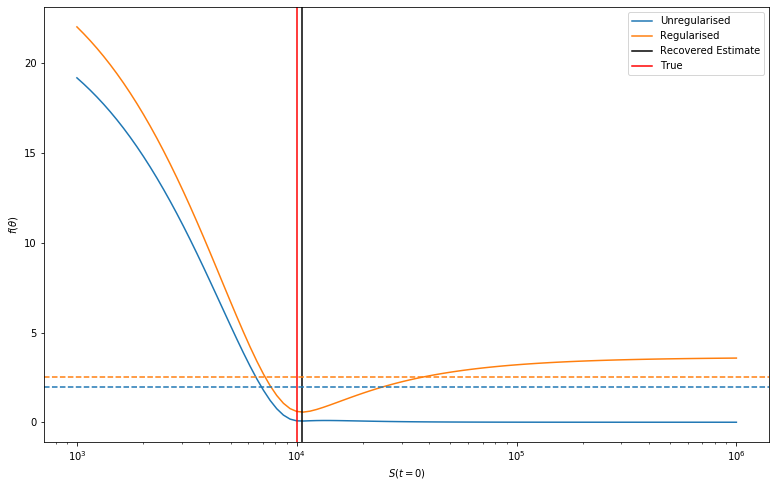

In [38]:
fs_s0 = [float(pf['f']) for pf in profile_s0]
fs_rs0 = [float(pf['f']) for pf in profile_rs0]

plt.plot(pvals_s0.flatten(), fs_s0, label="Unregularised")
plt.plot(pvals_s0.flatten(), fs_rs0, label="Regularised")
plt.axvline(float(getx(solutions[idx]['x'])[0][0]), color='k', label="Recovered Estimate")
plt.axvline(float(9999), color='r', label="True")
plt.xlabel(r"$S(t=0)$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.xscale('log')
plt.yscale('linear')
plt.axhline(min(fs_s0) +conf, linestyle='--', color='#1f77b4')
plt.axhline(min(fs_rs0)+conf, linestyle='--', color='#ff7f0e')

In [39]:
idx = 35
rho = prange[idx]
pvals_2 = np.linspace(-1, 4, 100)
# profile_2 = []
# profile_r2 = []
# profile_rr2 = []
profile_rrr2 = []
for pval in pvals_2:
    lbxp = [-np.inf]*(config['basis_number']*3) + [-np.inf, pval]
    ubxp = [np.inf]*(config['basis_number']*3) + [np.inf, pval]
#     profile_2.append(solver(x0=solutions[idx]['x'], p=[rho, 0], lbx=lbxp, ubx=ubxp, lbg=0))
#     profile_r2.append(solver(x0=solutions[idx]['x'], p=[rho, 1e-2], lbx=lbxp, ubx=ubxp, lbg=0))
#     profile_rr2.append(solver(x0=solutions[idx]['x'], p=[rho, 0.5], lbx=lbxp, ubx=ubxp, lbg=0))
    profile_rrr2.append(solver(x0=solutions[idx]['x'], p=[rho, 1e2], lbx=lbxp, ubx=ubxp, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      181
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  12  4.0120228e+02 0.00e+00 2.86e-03  -3.8 2.40e+04    -  1.00e+00 1.00e+00f  1
  13  4.0118625e+02 0.00e+00 2.70e-04  -3.8 3.53e+03    -  1.00e+00 1.00e+00f  1
  14  4.0113928e+02 0.00e+00 9.71e-04  -5.7 8.17e+01    -  1.00e+00 1.00e+00f  1
  15  4.0113483e+02 0.00e+00 1.73e-04  -5.7 1.00e+03    -  1.00e+00 1.00e+00f  1
  16  4.0113405e+02 0.00e+00 2.96e-05  -5.7 7.95e+02    -  1.00e+00 1.00e+00f  1
  17  4.0113392e+02 0.00e+00 3.46e-06  -5.7 6.64e+01    -  1.00e+00 1.00e+00h  1
  18  4.0113331e+02 0.00e+00 6.53e-06  -8.6 5.75e+00    -  1.00e+00 9.33e-01f  1
  19  4.0113329e+02 0.00e+00 5.80e-06  -8.6 3.06e-02  -4.0 1.00e+00 7.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.0113328e+02 0.00e+00 6.56e-06  -8.6 6.13e-02  -4.5 1.00e+00 4.83e-01f  1
  21  4.0113327e+02 0.00e+00 3.91e-06  -8.6 7.87e-02  -5.0 7.15e-01 6.79e-01f  1
  22  4.0113326e+02 0.00e+00 9.65e-06  -8.6 1.37e-01  -5.4 3.20e-01 2.73e-01f  1
  23  4.0113326e+02 0.00e+00

   8  3.3432471e+02 0.00e+00 5.87e-02  -2.5 2.58e+03    -  9.20e-01 1.00e+00f  1
   9  3.3348297e+02 0.00e+00 1.54e-01  -2.5 2.42e+04    -  6.05e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3340902e+02 0.00e+00 6.41e-03  -2.5 3.25e+04    -  8.25e-01 1.00e+00f  1
  11  3.3273173e+02 0.00e+00 1.28e-02  -3.8 1.16e+03    -  1.00e+00 1.00e+00f  1
  12  3.3263417e+02 0.00e+00 2.90e-03  -3.8 3.02e+04    -  1.00e+00 1.00e+00f  1
  13  3.3261840e+02 0.00e+00 2.21e-04  -3.8 4.27e+03    -  1.00e+00 1.00e+00f  1
  14  3.3257466e+02 0.00e+00 1.20e-03  -5.7 1.11e+02    -  1.00e+00 1.00e+00f  1
  15  3.3257035e+02 0.00e+00 2.15e-04  -5.7 2.15e+03    -  1.00e+00 1.00e+00f  1
  16  3.3256958e+02 0.00e+00 3.64e-05  -5.7 1.78e+03    -  1.00e+00 1.00e+00f  1
  17  3.3256944e+02 0.00e+00 4.29e-06  -5.7 2.16e+02    -  1.00e+00 1.00e+00h  1
  18  3.3256889e+02 0.00e+00 7.65e-06  -8.6 4.84e+00    -  1.00e+00 9.04e-01f  1
  19  3.3256885e+02 0.00e+00

   6  2.8130646e+02 0.00e+00 1.05e+00  -1.7 3.17e+03    -  6.03e-01 1.00e+00f  1
   7  2.7781993e+02 0.00e+00 5.00e-02  -1.7 2.77e+03    -  8.80e-01 1.00e+00f  1
   8  2.7377856e+02 0.00e+00 6.58e-02  -2.5 2.07e+03    -  8.76e-01 1.00e+00f  1
   9  2.7305765e+02 0.00e+00 1.85e-01  -2.5 1.26e+04    -  8.87e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7303537e+02 0.00e+00 8.95e-02  -2.5 3.31e+04    -  5.23e-01 1.00e+00f  1
  11  2.7292238e+02 0.00e+00 7.83e-02  -2.5 1.99e+04    -  1.00e+00 1.00e+00f  1
  12  2.7291756e+02 0.00e+00 4.39e-03  -2.5 1.92e+04    -  1.00e+00 1.00e+00f  1
  13  2.7231426e+02 0.00e+00 3.08e-02  -3.8 5.13e+02    -  1.00e+00 1.00e+00f  1
  14  2.7222713e+02 0.00e+00 5.03e-03  -3.8 3.51e+03    -  1.00e+00 1.00e+00f  1
  15  2.7221241e+02 0.00e+00 5.11e-04  -3.8 7.85e+02    -  1.00e+00 1.00e+00f  1
  16  2.7217247e+02 0.00e+00 1.54e-03  -5.7 1.46e+02    -  1.00e+00 1.00e+00f  1
  17  2.7216830e+02 0.00e+00

  25  2.1992724e+02 0.00e+00 1.26e-04  -8.6 3.65e+04    -  1.00e+00 8.63e-01f  1
  26  2.1992724e+02 0.00e+00 1.66e-07  -8.6 2.07e+03    -  1.00e+00 1.00e+00f  1
  27  2.1992724e+02 0.00e+00 1.30e-06  -8.6 9.10e+03    -  9.30e-01 1.00e+00h  1
  28  2.1992724e+02 0.00e+00 6.68e-10  -8.6 4.90e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   7.7526100984938068e+01    2.1992723995368902e+02
Dual infeasibility......:   6.6813403065047458e-10    1.8953729313517304e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.8362208862158214e-09    1.0882650625265603e-08
Overall NLP error.......:   3.8362208862158214e-09    1.0882650625265603e-08


Number of objective function evaluations             = 29
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of ineq

  28  1.8651074e+02 0.00e+00 1.47e+00  -5.7 5.30e+03    -  2.13e-01 1.96e-01f  1
  29  1.8643687e+02 0.00e+00 1.30e+00  -5.7 5.18e+03    -  8.54e-01 1.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.8631451e+02 0.00e+00 9.67e-01  -5.7 5.45e+03    -  2.18e-01 2.05e-01f  1
  31  1.8628246e+02 0.00e+00 8.95e-01  -5.7 3.13e+03    -  4.94e-01 7.30e-02f  1
  32  1.8623787e+02 0.00e+00 7.77e-01  -5.7 4.06e+03    -  3.93e-01 1.16e-01f  1
  33  1.8621405e+02 0.00e+00 7.14e-01  -5.7 4.80e+03    -  9.35e-02 7.15e-02f  1
  34  1.8618237e+02 0.00e+00 6.22e-01  -5.7 5.50e+03    -  9.61e-02 1.07e-01f  1
  35  1.8616812e+02 0.00e+00 5.78e-01  -5.7 1.94e+03    -  2.83e-01 6.90e-02f  1
  36  1.8615841e+02 0.00e+00 5.43e-01  -5.7 2.06e+03    -  6.51e-02 5.99e-02f  1
  37  1.8614522e+02 0.00e+00 4.89e-01  -5.7 2.22e+03    -  5.17e-01 9.54e-02f  1
  38  1.8612859e+02 0.00e+00 3.99e-01  -5.7 1.49e+03    -  1.31e-01 1.80e-01f  1
  39  1.8611980e+02 0.00e+00

  12  1.3014382e+02 0.00e+00 1.63e-01  -3.8 9.45e+01  -5.4 4.29e-01 1.00e+00f  1
  13  1.2844692e+02 0.00e+00 4.05e+00  -3.8 1.71e+04    -  1.47e-01 6.25e-02f  1
  14  1.2407013e+02 0.00e+00 5.23e+00  -3.8 4.09e+03    -  5.57e-01 4.63e-01f  1
  15  1.2205887e+02 0.00e+00 4.01e+00  -3.8 2.61e+03    -  6.71e-01 4.70e-01f  1
  16  1.2025452e+02 0.00e+00 8.63e+00  -3.8 2.01e+03    -  1.00e+00 9.21e-01f  1
  17  1.1923014e+02 0.00e+00 4.04e+00  -3.8 9.48e+02    -  1.00e+00 1.00e+00f  1
  18  1.1874818e+02 0.00e+00 6.60e+00  -3.8 1.17e+03    -  1.00e+00 1.00e+00f  1
  19  1.1850136e+02 0.00e+00 1.37e+00  -3.8 5.34e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1843036e+02 0.00e+00 1.99e+00  -3.8 6.79e+02    -  1.00e+00 1.00e+00f  1
  21  1.1841542e+02 0.00e+00 1.20e-01  -3.8 1.67e+02    -  1.00e+00 1.00e+00f  1
  22  1.1841461e+02 0.00e+00 2.72e-02  -3.8 8.05e+01    -  1.00e+00 1.00e+00f  1
  23  1.1841461e+02 0.00e+00

Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 15
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 395.00us ( 26.33us) 437.63us ( 29.18us)        15
       nlp_g  | 166.00us ( 11.07us) 161.98us ( 10.80us)        15
    nlp_grad  |  55.00us ( 55.00us)  54.42us ( 54.42us)         1
  nlp_grad_f  | 863.00us ( 53.94us) 864.65us ( 54.04us)        16
  nlp_hess_l  |   4.55ms (325.07us)   4.55ms (325.18us)        14
   nlp_jac_g  | 217.00us ( 13.56us) 218.84us ( 13.68us)        16
       total  |  27.04ms ( 27.04ms)  27.06ms ( 27.06ms)         1
This is Ipopt version

  16  2.4743756e+01 0.00e+00 1.70e-07  -8.6 3.08e-01    -  1.00e+00 1.00e+00h  1
  17  2.4743756e+01 0.00e+00 7.85e-11  -8.6 7.33e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.2312365390713341e+01    2.4743756425532261e+01
Dual infeasibility......:   7.8478624802990042e-11    1.5771591527007266e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5801769135731797e-09    5.1852968181394654e-09
Overall NLP error.......:   2.5801769135731797e-09    5.1852968181394654e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 18
Num

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2206807e+01 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.8963400e+01 0.00e+00 3.23e-02  -1.0 3.93e+00    -  9.88e-01 1.00e+00f  1
   2  4.0752371e+01 0.00e+00 7.79e-02  -1.0 1.82e+02    -  9.19e-01 1.00e+00f  1
   3  2.5982501e+01 0.00e+00 7.79e-01  -1.0 7.66e+02    -  7.81e-01 1.00e+00f  1
   4  2.1505279e+01 0.00e+00 3.69e-01  -1.0 1.46e+03    -  7.19e-01 1.00e+00f  1
   5  1.4286276e+01 0.00e+00 1.96e-02  -1.7 1.64e+03    -  6.06e-01 1.00e+00f  1
   6  1.0662909e+01 0.00e+00 5.73e-01  -1.7 2.78e+03    -  8.10e-01 1.00e+00f  1
   7  8.8426710e+00 0.00e+00 2.20e+00  -1.7 5.21e+03    -  1.00e+00 1.00e+00f  1
   8  8.2755801e+00 0.00e+00 2.25e+00  -1.7 5.49e+03    -  1.00e+00 1.00e+00f  1
   9  8.2908341e+00 0.00e+00 1.96e+00  -1.7 6.73e+03    -  1.

  11  1.1204775e+01 0.00e+00 1.36e+00  -1.7 2.38e+04    -  1.00e+00 1.00e+00f  1
  12  1.1135884e+01 0.00e+00 3.92e-01  -1.7 1.95e+04    -  1.00e+00 1.00e+00f  1
  13  1.1120026e+01 0.00e+00 3.77e-02  -1.7 7.61e+03    -  1.00e+00 1.00e+00f  1
  14  1.0629855e+01 0.00e+00 3.03e-02  -2.5 4.08e+03    -  1.00e+00 1.00e+00f  1
  15  1.0523971e+01 0.00e+00 9.08e-02  -2.5 1.38e+04    -  1.00e+00 1.00e+00f  1
  16  1.0510396e+01 0.00e+00 6.26e-04  -2.5 1.20e+03    -  1.00e+00 1.00e+00f  1
  17  1.0447258e+01 0.00e+00 7.72e-02  -3.8 1.50e+04    -  9.33e-01 1.00e+00f  1
  18  1.0424948e+01 0.00e+00 2.36e-01  -3.8 3.33e+04    -  1.00e+00 1.00e+00f  1
  19  1.0418361e+01 0.00e+00 5.60e-02  -3.8 2.12e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0416585e+01 0.00e+00 1.06e-02  -3.8 1.05e+04    -  1.00e+00 1.00e+00f  1
  21  1.0416388e+01 0.00e+00 1.95e-04  -3.8 1.51e+03    -  1.00e+00 1.00e+00h  1
  22  1.0411421e+01 0.00e+00

  30  1.8689718e+01 0.00e+00 3.35e-05  -5.7 5.82e+04    -  1.00e+00 1.00e+00h  1
  31  1.8689715e+01 0.00e+00 1.56e-08  -5.7 1.27e+03    -  1.00e+00 1.00e+00h  1
  32  1.8686196e+01 0.00e+00 2.72e-02  -8.6 2.05e+06    -  6.71e-01 1.00e+00f  1
  33  1.8683832e+01 0.00e+00 1.85e-02  -8.6 3.08e+06    -  1.00e+00 1.00e+00f  1
  34  1.8682256e+01 0.00e+00 1.24e-02  -8.6 4.61e+06    -  1.00e+00 1.00e+00f  1
  35  1.8681208e+01 0.00e+00 8.20e-03  -8.6 6.84e+06    -  1.00e+00 1.00e+00f  1
  36  1.8680514e+01 0.00e+00 5.34e-03  -8.6 1.00e+07    -  1.00e+00 1.00e+00f  1
  37  1.8680069e+01 0.00e+00 3.20e-03  -8.6 1.38e+07    -  1.00e+00 1.00e+00h  1
  38  1.8679793e+01 0.00e+00 1.70e-03  -8.6 1.72e+07    -  1.00e+00 1.00e+00h  1
  39  1.8679607e+01 0.00e+00 1.05e-03  -8.6 2.18e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.8679529e+01 0.00e+00 2.16e-04  -8.6 1.44e+07    -  1.00e+00 1.00e+00h  1
  41  1.8679461e+01 0.00e+00

  31  2.7181165e+01 0.00e+00 1.21e-08  -5.7 1.75e+03    -  1.00e+00 1.00e+00h  1
  32  2.7176977e+01 0.00e+00 1.89e-02  -8.6 2.68e+06    -  6.70e-01 1.00e+00f  1
  33  2.7174168e+01 0.00e+00 1.28e-02  -8.6 4.03e+06    -  1.00e+00 1.00e+00f  1
  34  2.7172295e+01 0.00e+00 8.54e-03  -8.6 6.03e+06    -  1.00e+00 1.00e+00f  1
  35  2.7171054e+01 0.00e+00 5.61e-03  -8.6 8.92e+06    -  1.00e+00 1.00e+00f  1
  36  2.7170240e+01 0.00e+00 3.57e-03  -8.6 1.29e+07    -  1.00e+00 1.00e+00f  1
  37  2.7169689e+01 0.00e+00 2.41e-03  -8.6 1.90e+07    -  1.00e+00 1.00e+00h  1
  38  2.7169341e+01 0.00e+00 1.37e-03  -8.6 2.52e+07    -  1.00e+00 1.00e+00h  1
  39  2.7169128e+01 0.00e+00 7.00e-04  -8.6 2.99e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.7169077e+01 0.00e+00 4.33e-05  -8.6 1.06e+07    -  1.00e+00 1.00e+00h  1
  41  2.7169416e+01 0.00e+00 1.21e-03  -8.6 9.50e+07    -  1.00e+00 5.00e-01h  2
  42  2.7169377e+01 0.00e+00

  12  4.5361978e+01 0.00e+00 3.34e-01  -1.7 2.93e+04    -  1.00e+00 1.00e+00f  1
  13  4.5275251e+01 0.00e+00 3.66e-02  -1.7 1.32e+04    -  1.00e+00 1.00e+00f  1
  14  4.4801520e+01 0.00e+00 1.11e-01  -2.5 2.11e+04    -  9.75e-01 1.00e+00f  1
  15  4.4567410e+01 0.00e+00 2.49e-01  -2.5 5.33e+04    -  1.00e+00 1.00e+00f  1
  16  4.4522225e+01 0.00e+00 1.20e-02  -2.5 1.62e+04    -  1.00e+00 1.00e+00f  1
  17  4.4372915e+01 0.00e+00 1.72e-01  -3.8 7.45e+04    -  7.76e-01 1.00e+00f  1
  18  4.4269498e+01 0.00e+00 1.98e-01  -3.8 1.29e+05    -  1.00e+00 1.00e+00f  1
  19  4.4211493e+01 0.00e+00 9.30e-02  -3.8 1.45e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.4180741e+01 0.00e+00 3.48e-02  -3.8 1.30e+05    -  1.00e+00 1.00e+00f  1
  21  4.4170316e+01 0.00e+00 4.47e-03  -3.8 5.97e+04    -  1.00e+00 1.00e+00f  1
  22  4.4168906e+01 0.00e+00 8.32e-05  -3.8 8.87e+03    -  1.00e+00 1.00e+00h  1
  23  4.4129663e+01 0.00e+00

   4  9.1487341e+01 0.00e+00 1.28e+00  -1.0 1.42e+03    -  6.50e-01 1.00e+00f  1
   5  8.1035624e+01 0.00e+00 3.85e-01  -1.0 2.85e+03    -  4.94e-01 1.00e+00f  1
   6  7.7418698e+01 0.00e+00 6.02e-01  -1.0 3.92e+03    -  7.99e-01 1.00e+00f  1
   7  7.3012481e+01 0.00e+00 4.33e-01  -1.7 4.90e+03    -  7.43e-01 1.00e+00f  1
   8  7.0312521e+01 0.00e+00 6.68e-01  -1.7 1.06e+04    -  1.00e+00 1.00e+00f  1
   9  6.8821404e+01 0.00e+00 7.87e-01  -1.7 1.41e+04    -  9.69e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7853413e+01 0.00e+00 8.89e-01  -1.7 2.32e+04    -  1.00e+00 1.00e+00f  1
  11  6.7324101e+01 0.00e+00 4.69e-01  -1.7 2.77e+04    -  1.00e+00 1.00e+00f  1
  12  6.7032213e+01 0.00e+00 2.26e-01  -1.7 2.97e+04    -  1.00e+00 1.00e+00f  1
  13  6.6945442e+01 0.00e+00 2.30e-02  -1.7 1.27e+04    -  1.00e+00 1.00e+00f  1
  14  6.6404525e+01 0.00e+00 1.24e-01  -3.8 2.55e+04    -  8.40e-01 1.00e+00f  1
  15  6.6113993e+01 0.00e+00

  37  8.2583912e+01 0.00e+00 2.67e-04  -8.6 3.78e+07    -  1.00e+00 1.00e+00h  1
  38  8.2583838e+01 0.00e+00 2.16e-05  -8.6 1.55e+07    -  1.00e+00 1.00e+00h  1
  39  8.2583697e+01 0.00e+00 9.86e-05  -8.6 4.12e+07    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  8.2583705e+01 0.00e+00 3.29e-07  -8.6 2.99e+06    -  1.00e+00 1.00e+00h  1
  41  8.2583705e+01 0.00e+00 2.37e-10  -8.6 5.85e-08  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   8.2583704785577240e+01    8.2583704785577240e+01
Dual infeasibility......:   2.3677133529480971e-10    2.3677133529480971e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective funct

  30  1.1173680e+02 0.00e+00 4.76e-03  -8.6 3.47e+06    -  6.69e-01 1.00e+00f  1
  31  1.1173340e+02 0.00e+00 3.21e-03  -8.6 5.21e+06    -  1.00e+00 1.00e+00f  1
  32  1.1173114e+02 0.00e+00 2.13e-03  -8.6 7.77e+06    -  1.00e+00 1.00e+00f  1
  33  1.1172964e+02 0.00e+00 1.41e-03  -8.6 1.15e+07    -  1.00e+00 1.00e+00f  1
  34  1.1172865e+02 0.00e+00 8.98e-04  -8.6 1.67e+07    -  1.00e+00 1.00e+00f  1
  35  1.1172800e+02 0.00e+00 5.63e-04  -8.6 2.37e+07    -  1.00e+00 1.00e+00h  1
  36  1.1172760e+02 0.00e+00 2.95e-04  -8.6 2.94e+07    -  1.00e+00 1.00e+00h  1
  37  1.1172740e+02 0.00e+00 1.02e-04  -8.6 2.70e+07    -  1.00e+00 1.00e+00h  1
  38  1.1172740e+02 0.00e+00 1.59e-09  -8.6 1.59e-05  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   1.1172739511723130e+02    1.1172739511723130e+02
Dual infeasibility......:   1.5947476108186028e-09    1.5947476108186028e-09
Constraint viol

  28  1.4533567e+02 0.00e+00 5.47e-06  -5.7 1.10e+05    -  1.00e+00 1.00e+00h  1
  29  1.4533065e+02 0.00e+00 3.47e-03  -8.6 3.42e+06    -  6.69e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4532729e+02 0.00e+00 2.34e-03  -8.6 5.15e+06    -  1.00e+00 1.00e+00f  1
  31  1.4532506e+02 0.00e+00 1.55e-03  -8.6 7.67e+06    -  1.00e+00 1.00e+00f  1
  32  1.4532358e+02 0.00e+00 1.02e-03  -8.6 1.14e+07    -  1.00e+00 1.00e+00f  1
  33  1.4532259e+02 0.00e+00 6.75e-04  -8.6 1.68e+07    -  1.00e+00 1.00e+00f  1
  34  1.4532197e+02 0.00e+00 3.84e-04  -8.6 2.26e+07    -  1.00e+00 1.00e+00h  1
  35  1.4532156e+02 0.00e+00 2.35e-04  -8.6 3.03e+07    -  1.00e+00 1.00e+00h  1
  36  1.4532126e+02 0.00e+00 1.81e-04  -8.6 4.48e+07    -  1.00e+00 1.00e+00h  1
  37  1.4532116e+02 0.00e+00 2.24e-05  -8.6 2.43e+07    -  1.00e+00 1.00e+00h  1
  38  1.4532114e+02 0.00e+00 1.48e-06  -8.6 7.41e+06    -  1.00e+00 1.00e+00h  1
  39  1.4532114e+02 0.00e+00

  26  2.1119218e+02 0.00e+00 1.33e-04  -5.7 6.06e+05    -  1.00e+00 1.00e+00h  1
  27  2.1119193e+02 0.00e+00 3.46e-06  -5.7 1.09e+05    -  1.00e+00 1.00e+00h  1
  28  2.1118710e+02 0.00e+00 2.07e-03  -8.6 3.30e+06    -  6.69e-01 1.00e+00f  1
  29  2.1118386e+02 0.00e+00 1.40e-03  -8.6 4.96e+06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1118171e+02 0.00e+00 9.26e-04  -8.6 7.40e+06    -  1.00e+00 1.00e+00f  1
  31  2.1118028e+02 0.00e+00 6.13e-04  -8.6 1.10e+07    -  1.00e+00 1.00e+00f  1
  32  2.1117933e+02 0.00e+00 3.97e-04  -8.6 1.61e+07    -  1.00e+00 1.00e+00f  1
  33  2.1117870e+02 0.00e+00 2.62e-04  -8.6 2.35e+07    -  1.00e+00 1.00e+00f  1
  34  2.1117829e+02 0.00e+00 1.64e-04  -8.6 3.32e+07    -  1.00e+00 1.00e+00h  1
  35  2.1117805e+02 0.00e+00 7.38e-05  -8.6 3.77e+07    -  1.00e+00 1.00e+00h  1
  36  2.1117782e+02 0.00e+00 1.72e-04  -8.6 1.19e+09    -  1.21e-01 6.25e-02h  5
  37  2.1117785e+02 0.00e+00

  37  2.5662425e+02 0.00e+00 1.90e-07  -8.6 4.30e+06    -  1.00e+00 1.00e+00h  1
  38  2.5662425e+02 0.00e+00 2.16e-11  -8.6 2.14e-07  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   2.5662424866872203e+02    2.5662424866872203e+02
Dual infeasibility......:   2.1554150606106122e-11    2.1554150606106122e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 39
Num

   1  1.3856315e+03 0.00e+00 6.30e-01  -1.0 1.34e+02    -  9.87e-01 1.00e+00f  1
   2  6.5987103e+02 0.00e+00 2.84e+00  -1.0 1.00e+03    -  9.04e-01 1.00e+00f  1
   3  4.1800445e+02 0.00e+00 3.19e+00  -1.0 1.49e+03    -  6.64e-01 1.00e+00f  1
   4  3.5786476e+02 0.00e+00 2.50e+00  -1.0 1.46e+03    -  6.59e-01 1.00e+00f  1
   5  3.3876113e+02 0.00e+00 3.83e-01  -1.0 2.59e+03    -  5.01e-01 1.00e+00f  1
   6  3.3416135e+02 0.00e+00 6.20e-01  -1.0 4.03e+03    -  8.26e-01 1.00e+00f  1
   7  3.3015717e+02 0.00e+00 6.16e-02  -1.7 3.83e+03    -  7.89e-01 1.00e+00f  1
   8  3.2797259e+02 0.00e+00 1.47e-01  -2.5 7.08e+03    -  7.07e-01 1.00e+00f  1
   9  3.2661999e+02 0.00e+00 6.52e-02  -2.5 1.25e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2580746e+02 0.00e+00 2.47e-03  -2.5 1.77e+04    -  1.00e+00 1.00e+00f  1
  11  3.2526125e+02 0.00e+00 3.25e-02  -3.8 2.48e+04    -  6.82e-01 1.00e+00f  1
  12  3.2489711e+02 0.00e+00

   9  3.8240297e+02 0.00e+00 1.02e-01  -2.5 1.24e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8162355e+02 0.00e+00 2.67e-02  -2.5 1.76e+04    -  1.00e+00 1.00e+00f  1
  11  3.8110073e+02 0.00e+00 1.04e-02  -3.8 2.45e+04    -  6.82e-01 1.00e+00f  1
  12  3.8075233e+02 0.00e+00 1.88e-02  -3.8 3.85e+04    -  1.00e+00 1.00e+00f  1
  13  3.8052391e+02 0.00e+00 1.80e-02  -3.8 5.66e+04    -  1.00e+00 1.00e+00f  1
  14  3.8037367e+02 0.00e+00 1.46e-02  -3.8 8.24e+04    -  1.00e+00 1.00e+00f  1
  15  3.8027721e+02 0.00e+00 9.88e-03  -3.8 1.13e+05    -  1.00e+00 1.00e+00f  1
  16  3.8021745e+02 0.00e+00 5.63e-03  -3.8 1.38e+05    -  1.00e+00 1.00e+00f  1
  17  3.8018509e+02 0.00e+00 2.16e-03  -3.8 1.29e+05    -  1.00e+00 1.00e+00f  1
  18  3.8017242e+02 0.00e+00 3.77e-04  -3.8 7.07e+04    -  1.00e+00 1.00e+00f  1
  19  3.8013474e+02 0.00e+00 4.75e-03  -5.7 3.23e+05    -  6.90e-01 1.00e+00f  1
iter    objective    inf_pr 

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w/o function evaluations)   =      0.043
Total CPU secs in NLP function evaluations           =      0.014

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 26.45us)   1.01ms ( 26.66us)        38
       nlp_g  | 400.00us ( 10.53us) 390.88us ( 10.29us)        38
  

  11  5.2892427e+02 0.00e+00 3.25e-02  -2.5 2.73e+04    -  1.00e+00 1.00e+00f  1
  12  5.2865204e+02 0.00e+00 9.86e-03  -2.5 3.52e+04    -  1.00e+00 1.00e+00f  1
  13  5.2842607e+02 0.00e+00 2.05e-03  -3.8 4.65e+04    -  7.26e-01 1.00e+00f  1
  14  5.2827462e+02 0.00e+00 5.70e-04  -3.8 7.78e+04    -  1.00e+00 1.00e+00f  1
  15  5.2817455e+02 0.00e+00 1.26e-03  -5.7 1.15e+05    -  6.74e-01 1.00e+00f  1
  16  5.2810722e+02 0.00e+00 1.20e-03  -5.7 1.76e+05    -  1.00e+00 1.00e+00f  1
  17  5.2806261e+02 0.00e+00 1.02e-03  -5.7 2.62e+05    -  1.00e+00 1.00e+00f  1
  18  5.2803307e+02 0.00e+00 7.68e-04  -5.7 3.88e+05    -  1.00e+00 1.00e+00f  1
  19  5.2801360e+02 0.00e+00 5.40e-04  -5.7 5.65e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.2800090e+02 0.00e+00 3.53e-04  -5.7 7.92e+05    -  1.00e+00 1.00e+00f  1
  21  5.2799289e+02 0.00e+00 2.04e-04  -5.7 1.02e+06    -  1.00e+00 1.00e+00f  1
  22  5.2798820e+02 0.00e+00

   4  6.7039710e+02 0.00e+00 2.47e+00  -1.0 1.43e+03    -  6.95e-01 1.00e+00f  1
   5  6.4067942e+02 0.00e+00 7.10e-01  -1.0 2.36e+03    -  5.41e-01 1.00e+00f  1
   6  6.3335587e+02 0.00e+00 6.11e-01  -1.0 4.57e+03    -  8.27e-01 1.00e+00f  1
   7  6.2876938e+02 0.00e+00 1.03e-01  -1.7 3.29e+03    -  8.27e-01 1.00e+00f  1
   8  6.2674005e+02 0.00e+00 1.79e-01  -2.5 6.40e+03    -  7.13e-01 1.00e+00f  1
   9  6.2556646e+02 0.00e+00 1.59e-01  -2.5 1.21e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2488703e+02 0.00e+00 7.75e-02  -2.5 1.72e+04    -  1.00e+00 1.00e+00f  1
  11  6.2444782e+02 0.00e+00 4.20e-02  -2.5 2.74e+04    -  1.00e+00 1.00e+00f  1
  12  6.2419597e+02 0.00e+00 1.57e-02  -2.5 3.46e+04    -  1.00e+00 1.00e+00f  1
  13  6.2397791e+02 0.00e+00 2.28e-03  -3.8 4.43e+04    -  7.35e-01 1.00e+00f  1
  14  6.2383247e+02 0.00e+00 4.48e-03  -3.8 7.62e+04    -  1.00e+00 1.00e+00f  1
  15  6.2374476e+02 0.00e+00

   1  2.8171172e+03 0.00e+00 2.55e+00  -1.0 1.88e+02    -  9.87e-01 1.00e+00f  1
   2  1.3384866e+03 0.00e+00 3.00e+00  -1.0 1.06e+03    -  9.28e-01 1.00e+00f  1
   3  8.8311063e+02 0.00e+00 4.09e+00  -1.0 1.68e+03    -  4.99e-01 1.00e+00f  1
   4  7.8261881e+02 0.00e+00 2.01e+00  -1.0 1.35e+03    -  7.16e-01 1.00e+00f  1
   5  7.4704905e+02 0.00e+00 6.82e-01  -1.0 2.33e+03    -  5.75e-01 1.00e+00f  1
   6  7.3792466e+02 0.00e+00 6.68e-01  -1.0 5.18e+03    -  8.16e-01 1.00e+00f  1
   7  7.3241525e+02 0.00e+00 8.18e-02  -1.7 3.22e+03    -  8.50e-01 1.00e+00f  1
   8  7.3025982e+02 0.00e+00 1.40e-01  -2.5 6.20e+03    -  7.23e-01 1.00e+00f  1
   9  7.2909681e+02 0.00e+00 1.42e-01  -2.5 1.23e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.2844396e+02 0.00e+00 7.27e-02  -2.5 1.75e+04    -  9.93e-01 1.00e+00f  1
  11  7.2803356e+02 0.00e+00 4.23e-02  -2.5 2.79e+04    -  1.00e+00 1.00e+00f  1
  12  7.2780397e+02 0.00e+00

  33  8.1019856e+02 0.00e+00 1.46e-05  -8.6 5.09e+07    -  1.00e+00 1.00e+00h  1
  34  8.1019863e+02 0.00e+00 1.17e-06  -8.6 2.09e+07    -  1.00e+00 1.00e+00h  1
  35  8.1019866e+02 0.00e+00 1.22e-07  -8.6 5.60e+06    -  1.00e+00 1.00e+00h  1
  36  8.1019866e+02 0.00e+00 1.17e-10  -8.6 5.14e+04    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   5.3320124803813837e+02    8.1019865690407039e+02
Dual infeasibility......:   1.1651595351527392e-10    1.7704585162415033e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    3.8077174535020885e-09
Overall NLP error.......:   2.5059035596800622e-09    3.8077174535020885e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of ineq

  16  9.2811288e+02 0.00e+00 1.72e-03  -3.8 9.22e+04    -  1.00e+00 1.00e+00f  1
  17  9.2809626e+02 0.00e+00 3.21e-04  -3.8 5.55e+04    -  1.00e+00 1.00e+00f  1
  18  9.2805590e+02 0.00e+00 1.99e-03  -5.7 2.01e+05    -  6.99e-01 1.00e+00f  1
  19  9.2802766e+02 0.00e+00 1.77e-03  -5.7 3.21e+05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2800941e+02 0.00e+00 1.11e-03  -5.7 4.59e+05    -  1.00e+00 1.00e+00f  1
  21  9.2799772e+02 0.00e+00 6.57e-04  -5.7 6.22e+05    -  1.00e+00 1.00e+00f  1
  22  9.2799064e+02 0.00e+00 3.28e-04  -5.7 7.35e+05    -  1.00e+00 1.00e+00f  1
  23  9.2798684e+02 0.00e+00 1.16e-04  -5.7 6.61e+05    -  1.00e+00 1.00e+00f  1
  24  9.2798543e+02 0.00e+00 1.74e-05  -5.7 3.32e+05    -  1.00e+00 1.00e+00h  1
  25  9.2798056e+02 0.00e+00 3.05e-04  -8.6 1.87e+06    -  6.70e-01 1.00e+00f  1
  26  9.2797729e+02 0.00e+00 2.09e-04  -8.6 2.82e+06    -  1.00e+00 1.00e+00f  1
  27  9.2797535e+02 0.00e+00

In [40]:
fs_2 = [float(pf['f']) for pf in profile_2]
fs_r2 = [float(pf['f']) for pf in profile_r2]
fs_rr2 = [float(pf['f']) for pf in profile_rr2]
fs_rrr2 = [float(pf['f']) for pf in profile_rrr2]

plt.plot(pvals_2.flatten(), fs_2, label="Unregularised")
plt.plot(pvals_2.flatten(), fs_r2, label="Weakly Regularised")
plt.plot(pvals_2.flatten(), fs_rr2, label="Regularised")
plt.plot(pvals_2.flatten(), fs_rrr2, label="Strongly Regularised")
plt.axvline(float(pref[1]), color='k', label="Recovered Estimate")
plt.axvline(float(p_true[1]), color='r', label="True")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.yscale('log')
plt.axhline(min(fs_2) +conf, linestyle='--', color='#1f77b4')
plt.axhline(min(fs_r2)+conf, linestyle='--', color='#ff7f0e')
plt.axhline(min(fs_rr2)+conf, linestyle='--', color='#2ca02c')
plt.axhline(min(fs_rrr2)+conf, linestyle='--', color='#d62728')

NameError: name 'profile_2' is not defined